In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf
from scipy.stats import norm
from scipy.stats import gaussian_kde
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep', 'arviz-colors', 'arviz-white', 'arviz-whitegrid', 'arviz-darkgrid']


In [2]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(t,N,D,w0,L):
    nmax = 5
    n = np.arange(1,nmax)
    nn,tt = np.meshgrid(n,t)
    
    efa = nn*np.pi*w0**2*1j
    an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    return np.sum(an,axis=1)/N/2

In [3]:
dt = 0.1
D = 1.0
L = 10
#xl = 5.0
#xr = 6.0
N = 20
length = 100000

In [4]:
acf_all=None
for i in range(2000):
    # generate steps for all particles
    steps=np.random.normal(loc=0.0, scale=np.sqrt(2*D*dt), size=(N,length))
    # initial positions
    x = 2*L*np.random.random(size=(N,))
    # put initial position in front
    x = np.column_stack((x, steps))
    # calculate paths
    paths = np.mod(np.cumsum(x, axis=1),2*L)-L
    # place a Gaussian illumination at x=5.5 with unit variance
    intensity = norm.pdf(paths, loc=0)
    intensity = np.sum(intensity, axis=0)

    # calculate autocorrelation function
    f = np.fft.rfft(intensity)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / length
    autocorr = acf[int(length/2):]/intensity.mean()**2

    autocorr = autocorr[:1000]-1.0
    t = np.arange(0,autocorr.size)*dt
    
    if acf_all is None:
        acf_all = autocorr
    else:
        acf_all = np.vstack((acf_all, autocorr))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

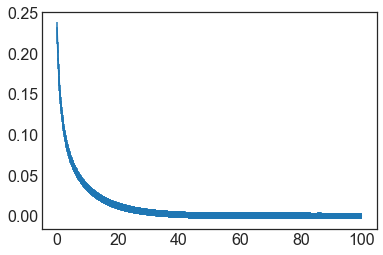

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

In [6]:
N_list=[]
D_list=[]
dN_list=[]
dD_list=[]

NS_list=[]
DS_list=[]
dNS_list=[]
dDS_list=[]

corrfitPB_model=lm.Model(corrfitPB)

for y in acf_all:
    paramsPB = corrfitPB_model.make_params()
    paramsPB['w0'].set(value=1,vary=False)
    paramsPB['N'].set(value=20,vary=True)
    paramsPB['D'].set(value=D,vary=True)
    paramsPB['L'].set(value=L,vary=False)

    resultPB = corrfitPB_model.fit(t=t,data=y,params=paramsPB)
    
    N_list.append(resultPB.values['N'])
    D_list.append(resultPB.values['D'])
    dN_list.append(np.sqrt(resultPB.covar[0,0]))
    dD_list.append(np.sqrt(resultPB.covar[1,1]))
                   
    paramsPBS = corrfitPB_model.make_params()
    paramsPBS['w0'].set(value=1,vary=False)
    paramsPBS['N'].set(value=20,vary=True)
    paramsPBS['D'].set(value=D,vary=True)
    paramsPBS['L'].set(value=L,vary=False)

    resultPBS = corrfitPB_model.fit(t=t,data=y,weights=1/acf_std,params=paramsPBS)
    
    NS_list.append(resultPBS.values['N'])
    DS_list.append(resultPBS.values['D'])
    dNS_list.append(np.sqrt(resultPBS.covar[0,0]))
    dDS_list.append(np.sqrt(resultPBS.covar[1,1]))


In [7]:
N_list = np.array(N_list)
dN_list = np.array(dN_list)
D_list = np.array(D_list)
dD_list = np.array(dD_list)

NS_list = np.array(NS_list)
dNS_list = np.array(dNS_list)
DS_list = np.array(DS_list)
dDS_list = np.array(dDS_list)

1.0010724956281163 0.11678649269008266
1.364206854567564 0.16737579574217296


/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


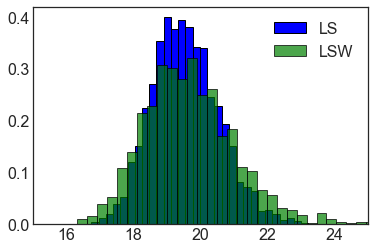

In [8]:
plt.hist(N_list,bins=30,normed=True,color="blue",edgecolor="k",label="LS")
plt.hist(NS_list,bins=30,normed=True,color="green",edgecolor="k",alpha=0.7,label="LSW")
plt.xlim((15,25))
plt.legend()
print(N_list.std(),dN_list.mean())
print(NS_list.std(),dNS_list.mean())

/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


1.0447004095863504 0.1315085395806492 0.009927965447740335
1.0389749953018672 0.15261753125233832 0.011802034765279813


/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


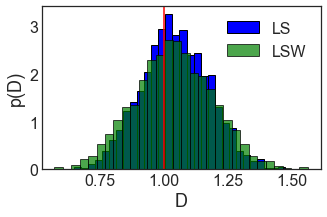

In [9]:
plt.figure(figsize=(5, 3))
plt.hist(D_list,bins=30,normed=True,color="blue",edgecolor="k",label="LS")
plt.hist(DS_list,bins=30,normed=True,color="green",edgecolor="k",label="LSW",alpha=0.7)
plt.axvline(x=1.0,color="r")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend()
print(D_list.mean(),D_list.std(),dD_list.mean())
print(DS_list.mean(),DS_list.std(),dDS_list.mean())
#plt.savefig("FCS_D300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

1.0447004095863504 0.1315085395806492 0.009927965447740335
1.0389749953018672 0.15261753125233832 0.011802034765279813


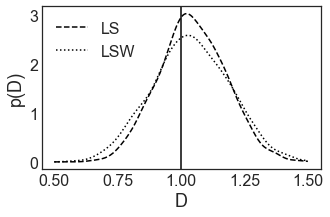

In [10]:
xd = np.linspace(0.5,1.5,200)
densityD = gaussian_kde(D_list)
densityDS = gaussian_kde(DS_list)
plt.figure(figsize=(5, 3))
plt.plot(xd,densityD(xd),"k--",label="LS")
plt.plot(xd,densityDS(xd),"k:",label="LSW")
plt.axvline(x=1.0,color="k")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend()
print(D_list.mean(),D_list.std(),dD_list.mean())
print(DS_list.mean(),DS_list.std(),dDS_list.mean())
#plt.savefig("FCS_D300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

1.2255117560623108 0.06273291556242136 0.007318508116798695
1.2330381752581028 0.08548898685261193 0.010488722552404843


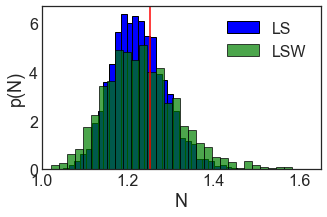

In [11]:
# instead of fitting how many particles per box N, we want to measure how many particles per focus
# size of focus is sqrt(pi/2)*w = 1.25
F_list = N_list/20.0*np.sqrt(np.pi/2)
dF_list = dN_list/20.0*np.sqrt(np.pi/2)
FS_list = NS_list/20.0*np.sqrt(np.pi/2)
dFS_list = dNS_list/20.0*np.sqrt(np.pi/2)

plt.figure(figsize=(5, 3))
plt.hist(F_list,bins=30,density=True,color="blue",edgecolor="k",label="LS")
plt.hist(FS_list,bins=30,density=True,color="green",edgecolor="k",alpha=0.7,label="LSW")
plt.axvline(x=np.sqrt(np.pi/2),color="r")
plt.legend()
plt.xlim((1,1.65))
plt.xlabel("N")
plt.ylabel("p(N)")
print(F_list.mean(),F_list.std(),dF_list.mean())
print(FS_list.mean(),FS_list.std(),dFS_list.mean())
#plt.savefig("FCS_N300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

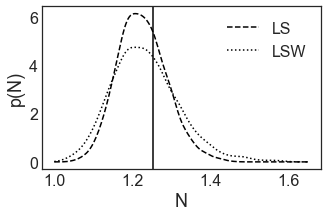

In [12]:
xn = np.linspace(1,1.65,200)
densityF = gaussian_kde(F_list)
densityFS = gaussian_kde(FS_list)
plt.figure(figsize=(5, 3))
plt.plot(xn,densityF(xn),"k--",label="LS")
plt.plot(xn,densityFS(xn),"k:",label="LSW")
plt.axvline(x=np.sqrt(np.pi/2),color="k")
plt.xlabel("N")
plt.ylabel("p(N)")

plt.legend()
#plt.savefig("FCS_N300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [13]:
#find out whether the means are ok
stderr = np.sqrt(N_list.size)
print(D_list.mean(),D_list.std(),dD_list.mean(),D_list.std()/stderr)
print(DS_list.mean(),DS_list.std(),dDS_list.mean(),DS_list.std()/stderr)
print(F_list.mean(),F_list.std(),dF_list.mean(),F_list.std()/stderr)
print(FS_list.mean(),FS_list.std(),dFS_list.mean(),FS_list.std()/stderr)

1.0447004095863504 0.1315085395806492 0.009927965447740335 0.002940620341240533
1.0389749953018672 0.15261753125233832 0.011802034765279813 0.0034126317443842705
1.2255117560623108 0.06273291556242136 0.007318508116798695 0.001402750636243286
1.2330381752581028 0.08548898685261193 0.010488722552404843 0.0019115918593002605


In [14]:
N_list2=[]
D_list2=[]
dN_list2=[]
dD_list2=[]

NS_list2=[]
DS_list2=[]
dNS_list2=[]
dDS_list2=[]

w0 = 1.0
L = 10.0
nmax = 5
n = np.arange(1,nmax)
nn,tt = np.meshgrid(n,t)
    
efa = nn*np.pi*w0**2*1j
an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))

def residual(pars, x, data=None, eps=None):
    # unpack parameters: extract .value attribute for each parameter
    parvals = pars.valuesdict()
    N = parvals['N']
    D = parvals['D']

    ann = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    model = np.sum(ann,axis=1)/N/2

    if data is None:
        return model
    if eps is None:
        return model - data
    return (model-data) / eps

for y in acf_all:
    pars = lm.Parameters()
    pars.add_many(('D', 1), ('N', 20))

    result = lm.minimize(residual, pars,kws = {'x':t,'data':y,'eps':acf_std})
    #result.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))
    res = lm.minimize(residual, kws = {'x':t,'data':y,'eps':acf_std},method='emcee', nan_policy='omit', burn=300, steps=1000, thin=20,
                     params=result.params)

    print(lm.fit_report(result.params))
    N_list2.append(result.params.valuesdict()['N'])
    D_list2.append(result.params.valuesdict()['D'])
    dD_list2.append(np.sqrt(result.covar[0,0]))
    dN_list2.append(np.sqrt(result.covar[1,1]))
    print(N_list2[-1],D_list2[-1],dN_list2[-1],dD_list2[-1])

    NS_list2.append(res.flatchain['N'].mean())
    DS_list2.append(res.flatchain['D'].mean())
    dNS_list2.append(res.flatchain['N'].std())
    dDS_list2.append(res.flatchain['D'].std())
    print(NS_list2[-1],DS_list2[-1],dNS_list2[-1],dDS_list2[-1])
    



/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/emcee/ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  0.85571348 +/- 0.00927082 (1.08%) (init = 1)
    N:  20.8561226 +/- 0.16991016 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.85612259027915 0.8557134809344367 0.16991016459497124 0.009270816938191252
20.857421430471764 0.8558983045744227 0.20661949419334927 0.011285238496719656


  1%|          | 7/1000 [00:00<00:15, 65.93it/s]

[[Variables]]
    D:  0.67923337 +/- 0.00702618 (1.03%) (init = 1)
    N:  23.5700189 +/- 0.18299779 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
23.5700188565184 0.679233374549748 0.18299778834197125 0.007026175618060636
23.56845649944834 0.6792998513614881 0.24832723657745712 0.009946921225779556


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.04785469 +/- 0.01011228 (0.97%) (init = 1)
    N:  20.0836033 +/- 0.14559254 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.083603285867447 1.0478546865239442 0.14559254213687883 0.0101122804499418
20.08669809972244 1.0478576821833994 0.2151861807365095 0.015191072563626505


  1%|          | 7/1000 [00:00<00:15, 66.13it/s]

[[Variables]]
    D:  1.18639083 +/- 0.01999127 (1.69%) (init = 1)
    N:  19.4126836 +/- 0.24525759 (1.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.412683566496415 1.1863908266976437 0.2452575933005517 0.019991270004734142
19.411362851424347 1.1865946679884845 0.2019318537169258 0.01651534783286777


  1%|          | 7/1000 [00:00<00:15, 64.47it/s]

[[Variables]]
    D:  1.10859220 +/- 0.01349504 (1.22%) (init = 1)
    N:  17.9841476 +/- 0.16433169 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.984147611658944 1.1085921988221585 0.16433168807767537 0.013495039000429936
17.98741871903375 1.1083057677238155 0.16368400731874588 0.013070406227422575


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  0.84160372 +/- 0.01142818 (1.36%) (init = 1)
    N:  21.3885399 +/- 0.21838735 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.388539890630753 0.8416037195419309 0.218387347883939 0.011428181144764881
21.379029695964864 0.8421852386151097 0.2159423826081489 0.011172816436756402


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  1.04405630 +/- 0.01418261 (1.36%) (init = 1)
    N:  18.9825079 +/- 0.19368524 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.98250794578579 1.0440562980690848 0.1936852366189711 0.014182607030954001
18.977165840706267 1.0448575374971725 0.18196647968442003 0.01302088738908165


  1%|          | 7/1000 [00:00<00:15, 65.34it/s]

[[Variables]]
    D:  1.08676357 +/- 0.01487084 (1.37%) (init = 1)
    N:  19.9706314 +/- 0.20516955 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.970631367113373 1.0867635742999993 0.20516955011282756 0.014870842493060341
19.96840619483167 1.0873484745243727 0.2073043507653008 0.015081228939517336


  1%|          | 7/1000 [00:00<00:14, 66.63it/s]

[[Variables]]
    D:  1.16003254 +/- 0.01133105 (0.98%) (init = 1)
    N:  18.4158064 +/- 0.13491770 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.415806429266826 1.1600325371790532 0.13491769964865488 0.011331050702301082
18.418637979341742 1.1597275545692702 0.1859871446377213 0.015532312042221115


  1%|          | 7/1000 [00:00<00:15, 66.17it/s]

[[Variables]]
    D:  1.05227230 +/- 0.01126509 (1.07%) (init = 1)
    N:  19.9616386 +/- 0.16052602 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.961638570926752 1.052272299790524 0.1605260222237071 0.011265087536519478
19.965210479837506 1.0525244486656855 0.2061117627439869 0.014610787168244238


  1%|          | 7/1000 [00:00<00:15, 63.22it/s]

[[Variables]]
    D:  1.14171815 +/- 0.01165741 (1.02%) (init = 1)
    N:  19.6930851 +/- 0.15086012 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.693085057071038 1.14171815041557 0.1508601160313292 0.011657412673128868
19.698604994854204 1.1419099366441017 0.20637433087041065 0.015296351324694068


  1%|          | 7/1000 [00:00<00:14, 66.45it/s]

[[Variables]]
    D:  1.23602604 +/- 0.01320249 (1.07%) (init = 1)
    N:  18.7311153 +/- 0.14988770 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.731115268015298 1.2360260397452971 0.14988769780803837 0.013202490907797976
18.738474685579167 1.235642787068191 0.1974008527591895 0.016853351058020993


  1%|          | 7/1000 [00:00<00:15, 63.89it/s]

[[Variables]]
    D:  1.11670467 +/- 0.01121807 (1.00%) (init = 1)
    N:  18.8493193 +/- 0.14210939 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.84931925219593 1.116704671519648 0.14210939199661476 0.011218074734861076
18.854700326309114 1.1165245956187415 0.1826078602125834 0.014416217313196443


  1%|          | 7/1000 [00:00<00:15, 65.98it/s]

[[Variables]]
    D:  1.06779424 +/- 0.01012243 (0.95%) (init = 1)
    N:  19.4890131 +/- 0.13874822 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.48901314579186 1.0677942428870104 0.13874821647966715 0.010122425432287295
19.49317964921206 1.067698134820399 0.20092189223500068 0.014711398023762003


  1%|          | 7/1000 [00:00<00:15, 64.67it/s]

[[Variables]]
    D:  1.20631108 +/- 0.01297054 (1.08%) (init = 1)
    N:  18.4749611 +/- 0.14889120 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.474961089087653 1.206311084349355 0.1488911983143501 0.012970535678770644
18.48291774079627 1.2061316216968763 0.19737175053500902 0.017040914275772732


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  1.09156403 +/- 0.01072534 (0.98%) (init = 1)
    N:  21.7148119 +/- 0.16020464 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
21.71481191408279 1.0915640328462721 0.1602046448073107 0.01072534037417539
21.726384835196342 1.0913421337986655 0.258723420983399 0.017697461806422194


  1%|          | 7/1000 [00:00<00:15, 66.06it/s]

[[Variables]]
    D:  0.89815664 +/- 0.01284926 (1.43%) (init = 1)
    N:  20.4960614 +/- 0.22046634 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.496061397692625 0.8981566417163119 0.2204663404280986 0.01284925933094529
20.501878928450974 0.8980508479045732 0.21155491159284803 0.012885077067924825


  1%|          | 7/1000 [00:00<00:16, 60.92it/s]

[[Variables]]
    D:  1.20036587 +/- 0.01356916 (1.13%) (init = 1)
    N:  17.4970423 +/- 0.14825275 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.497042270443533 1.200365874841776 0.14825275388274592 0.013569164660300745
17.509207309754498 1.1996272357449977 0.1697780271375047 0.015433516499794384


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  0.86440557 +/- 0.00875397 (1.01%) (init = 1)
    N:  18.2838479 +/- 0.13922982 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
18.28384794371753 0.864405566277305 0.13922981770060786 0.00875396602896961
18.290998697410235 0.8642021242060551 0.16137432045129121 0.010109226717102283


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  1.01536874 +/- 0.01136989 (1.12%) (init = 1)
    N:  19.6416685 +/- 0.16526486 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.641668546400204 1.015368742526008 0.16526485715114214 0.011369887095582726
19.645010944513878 1.0156817932780824 0.19624256448288757 0.013607615317940707


  1%|          | 7/1000 [00:00<00:14, 66.27it/s]

[[Variables]]
    D:  0.88886828 +/- 0.00622470 (0.70%) (init = 1)
    N:  22.6294360 +/- 0.11915463 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
22.62943604322208 0.8888682820423841 0.11915462733439706 0.006224702036399077
22.632313675072076 0.8886242757412235 0.25020110488176345 0.013099778193673684


  1%|          | 7/1000 [00:00<00:15, 64.55it/s]

[[Variables]]
    D:  0.97265061 +/- 0.01036054 (1.07%) (init = 1)
    N:  20.9629214 +/- 0.16782941 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.962921393021812 0.9726506088110712 0.16782940527916618 0.010360537661523991
20.958897825034143 0.9730234201549898 0.22831558999181592 0.014195965804291864


  1%|          | 7/1000 [00:00<00:15, 64.86it/s]

[[Variables]]
    D:  1.35630521 +/- 0.01269410 (0.94%) (init = 1)
    N:  18.4065459 +/- 0.12872266 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.406545889278334 1.356305206246002 0.1287226564318334 0.012694101776469598
18.41332158817466 1.3564136414731605 0.19861735485229895 0.019084538377598197


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  0.82951187 +/- 0.01476248 (1.78%) (init = 1)
    N:  21.6009715 +/- 0.28900534 (1.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.600971470531938 0.8295118652961043 0.28900534290731694 0.014762478109602697
21.599393383795032 0.8299913960969516 0.24216932600469576 0.01326622575171844


  1%|          | 7/1000 [00:00<00:15, 65.98it/s]

[[Variables]]
    D:  1.08205431 +/- 0.00805406 (0.74%) (init = 1)
    N:  18.7122407 +/- 0.10458041 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.712240725480388 1.0820543058659051 0.1045804070801183 0.008054057149056547
18.716791937850804 1.0821886153214455 0.18625532983175178 0.014368976058124167


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  0.90072369 +/- 0.01118739 (1.24%) (init = 1)
    N:  21.5038542 +/- 0.20082060 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.503854179916736 0.9007236860381552 0.20082060487105374 0.011187390606659717
21.512717706618364 0.9007607098633658 0.22309993184564736 0.012737826627519882


  1%|          | 7/1000 [00:00<00:15, 62.56it/s]

[[Variables]]
    D:  1.23985570 +/- 0.01495887 (1.21%) (init = 1)
    N:  19.6895832 +/- 0.17796230 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.689583237441592 1.2398556997802128 0.17796229713840564 0.014958866833185085
19.699439377002136 1.2393998951731924 0.22058776179572767 0.01808482867795815


  1%|          | 7/1000 [00:00<00:16, 60.80it/s]

[[Variables]]
    D:  0.85888051 +/- 0.00651296 (0.76%) (init = 1)
    N:  19.7257020 +/- 0.11247543 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.72570203274174 0.8588805067421921 0.11247543037251752 0.006512961310609654
19.717648193200553 0.8593932010937863 0.18441889433127204 0.010941129369661984


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  0.83542497 +/- 0.01030772 (1.23%) (init = 1)
    N:  20.5789964 +/- 0.19092138 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.578996380609055 0.8354249715423696 0.1909213798491063 0.010307717117296241
20.583709238528964 0.8354548909839951 0.20292924618728542 0.011239922157486234


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  1.02124705 +/- 0.01411508 (1.38%) (init = 1)
    N:  19.0748462 +/- 0.19812530 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.074846175561515 1.0212470529296607 0.19812530050043878 0.014115077030561607
19.0749521730994 1.0213753976522992 0.20352130446119915 0.015025182324467158


  1%|          | 7/1000 [00:00<00:15, 66.18it/s]

[[Variables]]
    D:  1.04253158 +/- 0.01162634 (1.12%) (init = 1)
    N:  19.6393397 +/- 0.16453750 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.63933974242175 1.042531582889034 0.16453750302589085 0.011626343385854738
19.640134137040054 1.0430619679017283 0.20385349834757788 0.014448853236087385


  1%|          | 7/1000 [00:00<00:14, 66.85it/s]

[[Variables]]
    D:  1.13695789 +/- 0.01482519 (1.30%) (init = 1)
    N:  19.0089509 +/- 0.18597563 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.00895091980447 1.1369578852086768 0.1859756269838033 0.014825185400514924
19.0114114805093 1.1374250759089484 0.19303579702392493 0.01532180683826252


  1%|          | 7/1000 [00:00<00:14, 66.33it/s]

[[Variables]]
    D:  0.79754314 +/- 0.00897583 (1.13%) (init = 1)
    N:  22.1598315 +/- 0.18746233 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.159831535321967 0.7975431392099109 0.18746233009630134 0.008975830586167913
22.168090387954148 0.797649076877222 0.2327699381424179 0.011523609312703601


  1%|          | 7/1000 [00:00<00:15, 63.02it/s]

[[Variables]]
    D:  0.82512845 +/- 0.01125463 (1.36%) (init = 1)
    N:  21.6456306 +/- 0.22196355 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.645630607376656 0.8251284500213577 0.22196354533923365 0.011254633811002765
21.659341218043973 0.8248298673480373 0.22871982582681546 0.01190768421710318


  1%|          | 7/1000 [00:00<00:14, 66.67it/s]

[[Variables]]
    D:  0.77521177 +/- 0.00835511 (1.08%) (init = 1)
    N:  21.6174605 +/- 0.17511604 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.61746049406793 0.7752117715496925 0.17511603826741504 0.00835510556967775
21.61205579620784 0.775820048564094 0.22152328188061138 0.010802918465736075


  1%|          | 7/1000 [00:00<00:16, 61.16it/s]

[[Variables]]
    D:  1.01507494 +/- 0.01158935 (1.14%) (init = 1)
    N:  19.4229714 +/- 0.16662209 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.422971402423922 1.015074942515409 0.16662209265171013 0.011589351890556567
19.424881664640886 1.0155373644633199 0.18598691991383712 0.012838378578790733


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  1.18204389 +/- 0.01256887 (1.06%) (init = 1)
    N:  19.7142925 +/- 0.15718485 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.714292544388567 1.1820438917478702 0.15718485218060543 0.01256886925242906
19.713871842265092 1.1824665270593924 0.22687025122051824 0.018540745057941812


  1%|          | 7/1000 [00:00<00:15, 62.69it/s]

[[Variables]]
    D:  0.83203036 +/- 0.00937311 (1.13%) (init = 1)
    N:  22.6958784 +/- 0.19222148 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.695878364743212 0.8320303592424599 0.19222147798419922 0.009373105846603124
22.705538091584682 0.8319026758207924 0.2511792891404513 0.012783238760612638


  1%|          | 7/1000 [00:00<00:15, 64.13it/s]

[[Variables]]
    D:  0.83022638 +/- 0.00962916 (1.16%) (init = 1)
    N:  21.9711777 +/- 0.19159105 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.971177711100328 0.8302263842858713 0.19159105286415343 0.009629163617605702
21.977889202502933 0.8300698660165907 0.23289736730431562 0.012295301692951028


  1%|          | 7/1000 [00:00<00:15, 62.32it/s]

[[Variables]]
    D:  1.41410948 +/- 0.01382583 (0.98%) (init = 1)
    N:  18.0460726 +/- 0.13167127 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.04607263379357 1.414109479929575 0.13167127186476682 0.013825830011607589
18.04899781904795 1.4150970820905269 0.19077296770226812 0.0196734451045257


  1%|          | 7/1000 [00:00<00:15, 63.33it/s]

[[Variables]]
    D:  1.08569956 +/- 0.00877641 (0.81%) (init = 1)
    N:  19.1583538 +/- 0.11627742 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.15835380872364 1.0856995614479459 0.11627741863127515 0.008776410054318595
19.156028206146875 1.0860010393906787 0.19278520749699732 0.014287273533273751


  1%|          | 7/1000 [00:00<00:15, 63.82it/s]

[[Variables]]
    D:  1.04977214 +/- 0.01504276 (1.43%) (init = 1)
    N:  17.5066518 +/- 0.18841786 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.50665176707471 1.0497721384176284 0.1884178576165606 0.01504276263860778
17.507928756648262 1.0498304995683911 0.1493058719703885 0.011417134668380884


  1%|          | 7/1000 [00:00<00:15, 65.16it/s]

[[Variables]]
    D:  0.95185903 +/- 0.01036380 (1.09%) (init = 1)
    N:  19.1281984 +/- 0.15657442 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.128198426859896 0.9518590284173333 0.15657442230030286 0.010363804149586988
19.131825649825668 0.9515135553729819 0.17787145094229057 0.01162248652310834


  1%|          | 7/1000 [00:00<00:15, 64.93it/s]

[[Variables]]
    D:  0.93160250 +/- 0.01311255 (1.41%) (init = 1)
    N:  19.0975276 +/- 0.20211025 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.09752763681447 0.9316025015346044 0.2021102470897974 0.013112554733103809
19.103417839533208 0.9316696281235111 0.1669836923620509 0.010401247842150983


  1%|          | 6/1000 [00:00<00:17, 55.74it/s]

[[Variables]]
    D:  0.98229943 +/- 0.00800679 (0.82%) (init = 1)
    N:  19.3381928 +/- 0.11847448 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.338192769167094 0.9822994276199056 0.11847448249107019 0.008006786518641574
19.34215547771586 0.9827215800770981 0.18325975070009012 0.012000737299567844


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  0.85114655 +/- 0.00612397 (0.72%) (init = 1)
    N:  20.4293117 +/- 0.11052513 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.429311729355973 0.8511465512552687 0.11052513199012078 0.006123967639103601
20.424665565436715 0.851676788459826 0.18657984111546352 0.010260534370667448


  1%|          | 7/1000 [00:00<00:15, 66.15it/s]

[[Variables]]
    D:  1.03366608 +/- 0.00824755 (0.80%) (init = 1)
    N:  19.8885043 +/- 0.11922665 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.88850431723268 1.0336660786435496 0.1192266457491794 0.008247547096720095
19.891073779457795 1.0335508708784866 0.20782244103222736 0.014543315174231821


  1%|          | 7/1000 [00:00<00:15, 65.22it/s]

[[Variables]]
    D:  1.01756259 +/- 0.00743410 (0.73%) (init = 1)
    N:  18.6187010 +/- 0.10220171 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.618701022366714 1.017562591007666 0.10220171083493597 0.0074341018933690595
18.619958059717405 1.017638579417292 0.16908809106449946 0.012300243057689713


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  1.00464558 +/- 0.00719494 (0.72%) (init = 1)
    N:  20.0285607 +/- 0.10778995 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.028560745363993 1.0046455803311511 0.1077899501398234 0.007194938638786649
20.034498941970273 1.0046315114927447 0.20073499108292375 0.013558461833645404


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  1.12126069 +/- 0.01836323 (1.64%) (init = 1)
    N:  18.1964104 +/- 0.22369666 (1.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.19641036463727 1.1212606911059544 0.22369665836161307 0.018363225070254348
18.20375924500836 1.1208139753528727 0.16090793857364188 0.012632578596474124


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  1.00973069 +/- 0.01036546 (1.03%) (init = 1)
    N:  20.1090373 +/- 0.15512267 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.109037263688773 1.0097306935205885 0.15512266606586966 0.010365461175230713
20.108567201738225 1.0098292121282604 0.21773143923111563 0.014616304803901659


  1%|          | 7/1000 [00:00<00:14, 66.34it/s]

[[Variables]]
    D:  1.06064477 +/- 0.00749322 (0.71%) (init = 1)
    N:  20.2370356 +/- 0.10737986 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.237035612212868 1.060644773937092 0.10737986488510184 0.007493223908576836
20.24164069636815 1.0607057271089895 0.22734435898245656 0.016206071519000664


  1%|          | 7/1000 [00:00<00:15, 65.73it/s]

[[Variables]]
    D:  0.78775164 +/- 0.00600607 (0.76%) (init = 1)
    N:  21.2202792 +/- 0.12161954 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.220279211652844 0.7877516369069849 0.12161954193013001 0.006006067264184849
21.22261961696612 0.7878051002876924 0.19663449749746545 0.010028943060871074


  1%|          | 7/1000 [00:00<00:15, 63.79it/s]

[[Variables]]
    D:  1.24330663 +/- 0.01799261 (1.45%) (init = 1)
    N:  17.6332974 +/- 0.19111689 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.633297426373943 1.243306633518232 0.1911168930576615 0.017992606088937355
17.63543527158789 1.243380681418837 0.17697056928748506 0.016590786545266405


  1%|          | 7/1000 [00:00<00:15, 65.43it/s]

[[Variables]]
    D:  1.06245152 +/- 0.01230121 (1.16%) (init = 1)
    N:  18.2971473 +/- 0.15910266 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.297147312520273 1.0624515246128472 0.15910266495976744 0.012301213090445169
18.299426058603377 1.0626393736963906 0.17130062103091012 0.01334950381568846


  1%|          | 7/1000 [00:00<00:15, 64.98it/s]

[[Variables]]
    D:  1.09000034 +/- 0.01072912 (0.98%) (init = 1)
    N:  20.0067517 +/- 0.14785789 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.006751720502645 1.0900003393284374 0.1478578913010688 0.010729124386919961
20.011443793770418 1.0902293205198166 0.21817225869846585 0.01600760977498288


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  1.09092672 +/- 0.01165546 (1.07%) (init = 1)
    N:  18.7586150 +/- 0.15046543 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.758615034616238 1.0909267190348932 0.1504654256608418 0.01165546125818872
18.763570394413247 1.0913571131232835 0.18325775594606153 0.014336804336486153


  1%|          | 7/1000 [00:00<00:15, 65.27it/s]

[[Variables]]
    D:  0.70818830 +/- 0.00988458 (1.40%) (init = 1)
    N:  23.0440488 +/- 0.24153641 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
23.04404882507138 0.7081882968705264 0.24153641047210134 0.00988458060946303
23.047360765571735 0.7084330255664263 0.2513898556774419 0.011071614760788467


  1%|          | 7/1000 [00:00<00:15, 65.74it/s]

[[Variables]]
    D:  1.07627703 +/- 0.00901833 (0.84%) (init = 1)
    N:  22.1080301 +/- 0.13910505 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
22.108030059438153 1.076277031183709 0.1391050487997618 0.00901832653689977
22.11563080036398 1.0761430662002722 0.2600783290244123 0.017008441724154544


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  0.96798971 +/- 0.01277551 (1.32%) (init = 1)
    N:  19.4226624 +/- 0.19268604 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.422662366268632 0.9679897120937047 0.1926860372214054 0.012775512188674487
19.423299858296986 0.9681461912095898 0.19688226871951844 0.013377067582436234


  1%|          | 7/1000 [00:00<00:15, 65.29it/s]

[[Variables]]
    D:  1.04832591 +/- 0.00998585 (0.95%) (init = 1)
    N:  19.4003956 +/- 0.13882437 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.400395616487263 1.0483259097622377 0.1388243739616709 0.009985847727603492
19.408563853131163 1.0484144248859073 0.1947555152915788 0.013995240496144904


  1%|          | 7/1000 [00:00<00:15, 64.90it/s]

[[Variables]]
    D:  0.87673972 +/- 0.00890812 (1.02%) (init = 1)
    N:  19.2217663 +/- 0.14685716 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.22176634271228 0.8767397177166304 0.14685716201961246 0.008908121177398528
19.22396897385333 0.8767517349811105 0.17334043375432281 0.010547043122838067


  1%|          | 7/1000 [00:00<00:15, 65.10it/s]

[[Variables]]
    D:  1.15528309 +/- 0.01160055 (1.00%) (init = 1)
    N:  18.6743678 +/- 0.14063375 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.674367757209513 1.1552830890612518 0.140633746901947 0.011600552579693063
18.682588359617007 1.1550707995345633 0.1842530198271221 0.014942075068162457


  1%|          | 7/1000 [00:00<00:14, 66.96it/s]

[[Variables]]
    D:  0.98449562 +/- 0.00719883 (0.73%) (init = 1)
    N:  20.4858646 +/- 0.11258367 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.48586459537362 0.9844956215743828 0.11258366808520903 0.007198832888640536
20.487884189750737 0.9848477543078431 0.21255196920440822 0.014105233922960272


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  0.80750467 +/- 0.01082787 (1.34%) (init = 1)
    N:  21.7231622 +/- 0.21897520 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.72316219813956 0.8075046687732182 0.21897519909664936 0.010827869985853597
21.721100147619744 0.8076668753333033 0.22371742363226052 0.011388639460209668


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  0.99228051 +/- 0.00956708 (0.96%) (init = 1)
    N:  19.0027968 +/- 0.13768830 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.002796801765083 0.9922805115772707 0.13768829789781495 0.009567083554658974
19.004485986851808 0.992442194798134 0.1780282177923752 0.012297022828312548


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  1.05525832 +/- 0.01262797 (1.20%) (init = 1)
    N:  19.2171275 +/- 0.17269524 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.217127514464245 1.0552583171652006 0.17269524471430522 0.012627972689645588
19.216212013574825 1.056109602215705 0.18342144013529435 0.012997347792235358


  1%|          | 7/1000 [00:00<00:15, 64.67it/s]

[[Variables]]
    D:  1.02681249 +/- 0.00987336 (0.96%) (init = 1)
    N:  18.5493900 +/- 0.13400514 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.549389973240356 1.0268124877250546 0.1340051398475866 0.009873361649271007
18.558471988269943 1.0266597852560888 0.17253910962027558 0.012636276485501648


  1%|          | 7/1000 [00:00<00:15, 65.24it/s]

[[Variables]]
    D:  0.91861402 +/- 0.01091076 (1.19%) (init = 1)
    N:  19.1332765 +/- 0.17085700 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.133276470233522 0.918614024487768 0.1708569986725261 0.010910762821997388
19.139240720804818 0.9184664851108705 0.19070745296175498 0.0125685154781724


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  0.94051448 +/- 0.01032683 (1.10%) (init = 1)
    N:  20.8704516 +/- 0.17227325 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.87045157619048 0.9405144750711146 0.17227324681856893 0.010326826858468434
20.866175746976158 0.9409385254083896 0.2167887172270528 0.01333708432416918


  1%|          | 7/1000 [00:00<00:15, 65.19it/s]

[[Variables]]
    D:  1.21007359 +/- 0.01392665 (1.15%) (init = 1)
    N:  18.1900077 +/- 0.15688670 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.19000766487517 1.2100735912860405 0.15688670084264641 0.013926654254666248
18.196876053430177 1.2098553544507298 0.18073448720431765 0.016012212655603004


  1%|          | 7/1000 [00:00<00:14, 66.22it/s]

[[Variables]]
    D:  1.05581477 +/- 0.00839004 (0.79%) (init = 1)
    N:  17.8912867 +/- 0.10678887 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.891286727767053 1.0558147690278874 0.1067888665404923 0.008390040831307476
17.892304085966224 1.055942011476916 0.161334021955133 0.012499931166112766


  1%|          | 7/1000 [00:00<00:15, 65.49it/s]

[[Variables]]
    D:  0.99616150 +/- 0.00965813 (0.97%) (init = 1)
    N:  19.0396114 +/- 0.13870602 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.039611437129295 0.9961614960077784 0.13870601675786534 0.009658131708460532
19.04562867066034 0.9960438526861162 0.17535969846780994 0.011844189867477838


  1%|          | 7/1000 [00:00<00:14, 66.61it/s]

[[Variables]]
    D:  0.85538845 +/- 0.00529104 (0.62%) (init = 1)
    N:  19.8005077 +/- 0.09209303 (0.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.800507656723752 0.8553884500373559 0.09209302658323311 0.005291039624891839
19.7959725217627 0.8556578250802337 0.18173076012672243 0.010728317031853798


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  1.01141113 +/- 0.00803185 (0.79%) (init = 1)
    N:  20.3861591 +/- 0.12165924 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.38615912439643 1.0114111348599544 0.12165923766759319 0.008031850575472564
20.388423776794497 1.0117136151787762 0.21547118301455398 0.01448787313937071


  1%|          | 7/1000 [00:00<00:15, 64.36it/s]

[[Variables]]
    D:  1.19851636 +/- 0.02205332 (1.84%) (init = 1)
    N:  18.8732291 +/- 0.26031134 (1.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.873229090737784 1.1985163595078776 0.26031134131172456 0.022053318733566103
18.876726261289996 1.1984212806424293 0.19889325182976153 0.017566639529792958


  1%|          | 7/1000 [00:00<00:14, 66.38it/s]

[[Variables]]
    D:  0.86782906 +/- 0.01357078 (1.56%) (init = 1)
    N:  19.3343921 +/- 0.22731950 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.334392067274855 0.8678290562112312 0.2273195018677422 0.013570777459680645
19.337895438682267 0.8680075685913241 0.17179405944658657 0.009798428513135867


  1%|          | 7/1000 [00:00<00:15, 65.58it/s]

[[Variables]]
    D:  0.75565388 +/- 0.00616215 (0.82%) (init = 1)
    N:  22.1311677 +/- 0.13563540 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.131167660400774 0.7556538755913523 0.13563539522712362 0.00616214713300902
22.132511410191483 0.7557737440764855 0.22274689665891836 0.010483215853121982


  1%|          | 7/1000 [00:00<00:14, 66.67it/s]

[[Variables]]
    D:  0.80375386 +/- 0.01221247 (1.52%) (init = 1)
    N:  22.3510221 +/- 0.25529353 (1.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.35102211804718 0.803753856191544 0.255293529302201 0.012212467924630722
22.357131698748063 0.8037103122793074 0.2574982020257789 0.013148004488686638


  1%|          | 7/1000 [00:00<00:14, 66.33it/s]

[[Variables]]
    D:  1.05632691 +/- 0.01088350 (1.03%) (init = 1)
    N:  21.2784974 +/- 0.16466995 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.278497428679817 1.0563269128297188 0.16466995216929983 0.010883501274965918
21.28173013603006 1.0565674870559938 0.24046813038362477 0.01613582057111503


  1%|          | 7/1000 [00:00<00:14, 66.80it/s]

[[Variables]]
    D:  1.18292944 +/- 0.01377719 (1.16%) (init = 1)
    N:  17.2709170 +/- 0.15082394 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.270916968579378 1.1829294449098398 0.15082394304216662 0.013777187896931706
17.2718942032107 1.1832389433788313 0.15958149849258996 0.014057496803164628


  1%|          | 7/1000 [00:00<00:15, 65.05it/s]

[[Variables]]
    D:  1.54491963 +/- 0.02314747 (1.50%) (init = 1)
    N:  17.7565859 +/- 0.19790102 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
17.75658585193224 1.544919633499662 0.19790101964336035 0.02314746779766056
17.758914834281676 1.544961924929089 0.18872007244180775 0.021032575674591124


  1%|          | 7/1000 [00:00<00:15, 63.58it/s]

[[Variables]]
    D:  1.21723931 +/- 0.01142186 (0.94%) (init = 1)
    N:  16.8616078 +/- 0.11856115 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.861607828678924 1.217239312520868 0.1185611518185072 0.011421863057952309
16.867512194305817 1.2171130192793613 0.15416886519421907 0.014450041416047292


  1%|          | 7/1000 [00:00<00:15, 66.14it/s]

[[Variables]]
    D:  0.86326581 +/- 0.00691361 (0.80%) (init = 1)
    N:  20.8878423 +/- 0.12578330 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.88784229471612 0.8632658116569131 0.1257832955998345 0.006913610534962317
20.886883757842504 0.8636379900479342 0.19862679444305165 0.010620410072193241


  1%|          | 7/1000 [00:00<00:15, 62.22it/s]

[[Variables]]
    D:  1.07793875 +/- 0.01131499 (1.05%) (init = 1)
    N:  20.1841839 +/- 0.15910006 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.18418388866009 1.0779387476179825 0.159100062832724 0.011314993771009583
20.182429851739812 1.078600946113085 0.21840101594799463 0.015670985280821722


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  1.02295351 +/- 0.00794764 (0.78%) (init = 1)
    N:  19.8027923 +/- 0.11560362 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.802792263487454 1.022953509079977 0.11560362464042322 0.007947640599434992
19.804397103036788 1.023142936605373 0.19413287384653818 0.01341407918618158


  1%|          | 7/1000 [00:00<00:14, 66.85it/s]

[[Variables]]
    D:  0.79572769 +/- 0.00659467 (0.83%) (init = 1)
    N:  21.2949839 +/- 0.13267611 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.29498394368237 0.7957276940008433 0.13267610611665936 0.0065946658923820055
21.298244352499086 0.795676008735433 0.20522443247556496 0.010618370781424002


  1%|          | 7/1000 [00:00<00:14, 66.47it/s]

[[Variables]]
    D:  0.95846090 +/- 0.01567297 (1.64%) (init = 1)
    N:  20.7747751 +/- 0.25534843 (1.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.774775074505403 0.9584608954742393 0.25534843238951854 0.015672965824205423
20.788201549622926 0.9582219869933332 0.23957618377030102 0.015303176317883516


  1%|          | 7/1000 [00:00<00:15, 63.01it/s]

[[Variables]]
    D:  1.05501610 +/- 0.00915814 (0.87%) (init = 1)
    N:  20.0752834 +/- 0.13088986 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.07528335332027 1.0550161020906144 0.1308898613700001 0.009158140821311117
20.074624626252294 1.055597295880685 0.20997508187841754 0.014888614661567162


  1%|          | 7/1000 [00:00<00:15, 65.03it/s]

[[Variables]]
    D:  1.04444207 +/- 0.01615268 (1.55%) (init = 1)
    N:  20.2993140 +/- 0.23585187 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.29931395986344 1.0444420665278547 0.23585187193278137 0.016152684045241138
20.29722607000895 1.0447118289305661 0.2370205625878334 0.017321270989297644


  1%|          | 7/1000 [00:00<00:15, 66.04it/s]

[[Variables]]
    D:  0.93345428 +/- 0.00810030 (0.87%) (init = 1)
    N:  19.5091478 +/- 0.12728810 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.50914777084157 0.9334542821173393 0.12728810000881374 0.008100295634365503
19.503878661957632 0.9341527518059934 0.18113337522877343 0.011563254622126883


  1%|          | 7/1000 [00:00<00:15, 64.82it/s]

[[Variables]]
    D:  1.16129477 +/- 0.01929272 (1.66%) (init = 1)
    N:  18.2101499 +/- 0.22688019 (1.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.21014986757731 1.1612947718469917 0.22688019459704137 0.019292715708516716
18.21384803301878 1.1616203068264972 0.16812958969819225 0.013835489622188125


  1%|          | 7/1000 [00:00<00:14, 66.65it/s]

[[Variables]]
    D:  0.78629463 +/- 0.01074057 (1.37%) (init = 1)
    N:  20.4237765 +/- 0.20970724 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.423776473125532 0.7862946303147497 0.20970724182078906 0.010740570012615872
20.42184607923251 0.7866036168551105 0.17798955571562927 0.009077795994325122


  1%|          | 7/1000 [00:00<00:15, 65.48it/s]

[[Variables]]
    D:  1.16401273 +/- 0.01361442 (1.17%) (init = 1)
    N:  17.7444886 +/- 0.15566246 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.744488599551744 1.1640127323060891 0.15566246093555866 0.013614417401451223
17.747578475495327 1.1643958889220498 0.1654624900362124 0.014195348121770068


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  0.89142679 +/- 0.01180609 (1.32%) (init = 1)
    N:  19.1166616 +/- 0.19040155 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.11666163249809 0.8914267856381647 0.19040154851051921 0.011806085638080421
19.127047589765773 0.8911721444583939 0.18149953818983103 0.0113390542967909


  1%|          | 7/1000 [00:00<00:15, 66.12it/s]

[[Variables]]
    D:  0.93453308 +/- 0.01031624 (1.10%) (init = 1)
    N:  19.3491560 +/- 0.16058627 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.3491560086954 0.9345330830971997 0.16058626591512187 0.010316239986862066
19.352204771331614 0.9347402015462332 0.18376837367177606 0.011881326942306841


  1%|          | 7/1000 [00:00<00:14, 66.38it/s]

[[Variables]]
    D:  1.01972855 +/- 0.00964771 (0.95%) (init = 1)
    N:  18.9106655 +/- 0.13444115 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.91066546041441 1.0197285500862343 0.13444115219067732 0.00964771070405958
18.91840467626304 1.0197775015166268 0.17905842225651258 0.01274355825529233


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  1.02703766 +/- 0.00921368 (0.90%) (init = 1)
    N:  18.9062907 +/- 0.12742910 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.90629072520505 1.027037658585804 0.1274290968275931 0.009213677954317899
18.907054638906867 1.0272003871388173 0.18487932786469424 0.013606645525733626


  1%|          | 7/1000 [00:00<00:14, 67.05it/s]

[[Variables]]
    D:  1.11088871 +/- 0.01460037 (1.31%) (init = 1)
    N:  19.4873538 +/- 0.19225846 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.487353756801824 1.1108887079201166 0.19225845628055668 0.014600374715437217
19.485441581077737 1.110806660650279 0.20342475913957977 0.015977454495505142


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  1.00174185 +/- 0.01102933 (1.10%) (init = 1)
    N:  18.8738521 +/- 0.15615989 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.873852068190764 1.0017418532391744 0.15615989237531366 0.011029330476781707
18.880477607416104 1.001428344537284 0.17850359287632817 0.012557851873352593


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  0.87409791 +/- 0.00928419 (1.06%) (init = 1)
    N:  19.9634218 +/- 0.15942907 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.96342176500591 0.8740979062568422 0.1594290684984208 0.009284191170408738
19.96436180195961 0.8744470215610076 0.19676081371090276 0.011687590148783159


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  1.23764238 +/- 0.01196363 (0.97%) (init = 1)
    N:  17.3472522 +/- 0.12559695 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.347252236719154 1.2376423762794264 0.12559694994595008 0.011963626711046385
17.356305973324066 1.2370111977776415 0.16234749054239914 0.014940536702222002


  1%|          | 7/1000 [00:00<00:14, 66.22it/s]

[[Variables]]
    D:  0.73358699 +/- 0.01065670 (1.45%) (init = 1)
    N:  21.4408287 +/- 0.23397189 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
21.440828710302718 0.7335869919910936 0.2339718854979109 0.010656700246836131
21.456420765736492 0.7329454284646071 0.22054087307517378 0.010577491072242137


  1%|          | 7/1000 [00:00<00:15, 66.00it/s]

[[Variables]]
    D:  1.04152611 +/- 0.01517249 (1.46%) (init = 1)
    N:  19.3039224 +/- 0.21125516 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.303922384782908 1.0415261065386623 0.21125515626098537 0.01517249196114688
19.307809721114715 1.0418269959006041 0.18048663208882612 0.0129668917931093


  1%|          | 7/1000 [00:00<00:15, 65.51it/s]

[[Variables]]
    D:  0.91990363 +/- 0.01029022 (1.12%) (init = 1)
    N:  19.9198152 +/- 0.16753701 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.91981516244232 0.9199036263949674 0.16753701234301868 0.010290217531903595
19.91880334208202 0.9201546362145786 0.19149008343149884 0.011885885616224515


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  0.77873611 +/- 0.00713327 (0.92%) (init = 1)
    N:  20.9764729 +/- 0.14443402 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
20.97647289530245 0.778736108788592 0.14443401559095895 0.007133272453232615
20.97190267891402 0.7792905567216561 0.20274903517761633 0.010191515382809687


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  1.24856777 +/- 0.01251181 (1.00%) (init = 1)
    N:  20.5914303 +/- 0.15451865 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.59143034101094 1.2485677716643169 0.15451864875062377 0.012511809653842399
20.58886201026612 1.249736972307926 0.23136778865396154 0.018389132650651004


  1%|          | 7/1000 [00:00<00:15, 62.82it/s]

[[Variables]]
    D:  0.92455393 +/- 0.01256858 (1.36%) (init = 1)
    N:  19.8460661 +/- 0.20282156 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.846066061843654 0.9245539259807921 0.20282156429955006 0.012568581439839724
19.849947563598334 0.9246587979840397 0.20120511816303052 0.013131045001042499


  1%|          | 7/1000 [00:00<00:14, 66.22it/s]

[[Variables]]
    D:  1.01996257 +/- 0.01040428 (1.02%) (init = 1)
    N:  20.0723087 +/- 0.15384444 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.072308736293795 1.0199625731996929 0.1538444409122712 0.010404283566283427
20.08303054803481 1.0197144968143583 0.20529676966485816 0.014315468847565762


  1%|          | 7/1000 [00:00<00:14, 66.21it/s]

[[Variables]]
    D:  1.17352333 +/- 0.01452319 (1.24%) (init = 1)
    N:  19.2710809 +/- 0.17885045 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.27108086766861 1.1735233346193426 0.1788504499658995 0.014523190957684652
19.274126217406014 1.173460721013786 0.20188667794327203 0.015980943144223967


  1%|          | 7/1000 [00:00<00:14, 66.98it/s]

[[Variables]]
    D:  0.93592290 +/- 0.00963771 (1.03%) (init = 1)
    N:  19.8511940 +/- 0.15368639 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.851194037317764 0.9359228975468482 0.15368638609048668 0.009637709548809539
19.848865782902966 0.9362132924980127 0.19911491070453738 0.012538582199992111


  1%|          | 7/1000 [00:00<00:15, 66.15it/s]

[[Variables]]
    D:  1.16384397 +/- 0.01458355 (1.25%) (init = 1)
    N:  17.9790465 +/- 0.16898653 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.979046453673778 1.1638439662186457 0.16898652535369346 0.014583552684278238
17.98200199199836 1.1640847773202538 0.1704519601882239 0.013993071776920704


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  0.74542683 +/- 0.00850685 (1.14%) (init = 1)
    N:  23.5877625 +/- 0.20225907 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
23.587762484843882 0.7454268284979381 0.20225906523132423 0.00850684878149263
23.59586161857878 0.7454321759250322 0.2502264844315464 0.010801604778767822


  1%|          | 7/1000 [00:00<00:15, 65.74it/s]

[[Variables]]
    D:  0.98546700 +/- 0.00679165 (0.69%) (init = 1)
    N:  20.9766867 +/- 0.10864980 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.976686676048697 0.9854669951798735 0.108649798310778 0.00679165074417743
20.984179236162458 0.9853468749580846 0.22786578962832568 0.014137909830102567


  1%|          | 7/1000 [00:00<00:15, 65.12it/s]

[[Variables]]
    D:  1.15618721 +/- 0.01799600 (1.56%) (init = 1)
    N:  17.1669570 +/- 0.20042198 (1.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.166956971775335 1.1561872132379387 0.20042198349061852 0.017995995263944357
17.162293846393677 1.1568533908940886 0.15970546092307697 0.014338676973008259


  1%|          | 7/1000 [00:00<00:15, 64.11it/s]

[[Variables]]
    D:  1.33573465 +/- 0.01468764 (1.10%) (init = 1)
    N:  18.5242390 +/- 0.15228203 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.524239011693606 1.3357346532757712 0.15228203440107146 0.014687637026937865
18.52638339056918 1.3365150619370256 0.20029222921724377 0.019210105100980222


  1%|          | 7/1000 [00:00<00:15, 64.97it/s]

[[Variables]]
    D:  0.96360163 +/- 0.01426980 (1.48%) (init = 1)
    N:  19.1965218 +/- 0.21368053 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.196521783165792 0.9636016325509356 0.2136805294545771 0.014269798188269366
19.193178494943812 0.9639135730637272 0.18875591344284973 0.012988980826841318


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  0.96495268 +/- 0.01268464 (1.31%) (init = 1)
    N:  21.6851975 +/- 0.21426988 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.68519751349079 0.9649526777662304 0.2142698800487119 0.012684640836518777
21.68376641935717 0.9656682832450693 0.24576914835942018 0.015168689614350991


  1%|          | 7/1000 [00:00<00:14, 66.89it/s]

[[Variables]]
    D:  0.81710685 +/- 0.00746984 (0.91%) (init = 1)
    N:  20.0514894 +/- 0.13782040 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.051489375934505 0.8171068453394004 0.13782040090207995 0.00746984355752525
20.060002960229188 0.8167212632192503 0.19001628088040634 0.010393475237984106


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  1.12122639 +/- 0.02293428 (2.05%) (init = 1)
    N:  19.6604908 +/- 0.30181122 (1.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.66049077425036 1.121226393213804 0.3018112173513834 0.022934283142169592
19.655092195500565 1.1218509270039692 0.21291629211372348 0.016381481323805843


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  1.03766077 +/- 0.01567672 (1.51%) (init = 1)
    N:  21.2765343 +/- 0.24145694 (1.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.27653428353775 1.0376607721586835 0.24145693606344693 0.015676723104304534
21.27959976575568 1.0377367450683985 0.2196256090057891 0.014047978848868268


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  1.11270804 +/- 0.00987836 (0.89%) (init = 1)
    N:  19.7963359 +/- 0.13191451 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.796335876783463 1.1127080368790219 0.13191451481264965 0.009878359091847665
19.793624719818826 1.113345492226275 0.20903750479997413 0.015839815223383277


  1%|          | 7/1000 [00:00<00:15, 64.73it/s]

[[Variables]]
    D:  1.06269450 +/- 0.00936452 (0.88%) (init = 1)
    N:  19.3389501 +/- 0.12799482 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.338950057005196 1.0626944951874344 0.12799482183949631 0.00936452094068822
19.33427214763655 1.0633719209448518 0.19117981014979726 0.014080227649836505


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  1.03651422 +/- 0.00850646 (0.82%) (init = 1)
    N:  20.5347062 +/- 0.12660402 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.534706217244448 1.0365142172127952 0.1266040200442784 0.008506460068944193
20.545423503632353 1.0364240288530229 0.22086836911018656 0.015050208505882318


  1%|          | 7/1000 [00:00<00:14, 66.73it/s]

[[Variables]]
    D:  1.16514806 +/- 0.01327562 (1.14%) (init = 1)
    N:  19.7261809 +/- 0.16855650 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.726180879525273 1.1651480648518149 0.16855649915004378 0.01327562024378259
19.729012226207843 1.1656860606204036 0.20351546070814894 0.015695348641674718


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  1.03565129 +/- 0.01497866 (1.45%) (init = 1)
    N:  19.7052560 +/- 0.21414360 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.705256000395984 1.0356512929693573 0.21414360257366685 0.014978661710350413
19.714916855417336 1.0353411481512633 0.186618701402605 0.012632943317502265


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  1.12634454 +/- 0.01309580 (1.16%) (init = 1)
    N:  19.4828059 +/- 0.16999137 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.482805917496215 1.1263445416063205 0.16999137439171702 0.013095799296550529
19.489022891006645 1.1259313623029976 0.19678487783798923 0.014723334343407297


  1%|          | 7/1000 [00:00<00:15, 66.12it/s]

[[Variables]]
    D:  1.34658733 +/- 0.02154118 (1.60%) (init = 1)
    N:  18.0948023 +/- 0.21634706 (1.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.094802316050625 1.3465873321364954 0.21634705776141233 0.02154117834474281
18.103652965352968 1.3462539077677684 0.18174259363696443 0.01755932755623667


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  1.26366144 +/- 0.01407765 (1.11%) (init = 1)
    N:  17.5402106 +/- 0.14628544 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.540210632824536 1.26366144307272 0.1462854444233019 0.01407764921355437
17.5466102088446 1.263753781967082 0.16436171904150623 0.01520255718952003


  1%|          | 7/1000 [00:00<00:14, 66.59it/s]

[[Variables]]
    D:  0.98447159 +/- 0.00989427 (1.01%) (init = 1)
    N:  20.5156172 +/- 0.15496265 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.51561717169896 0.9844715894784334 0.15496265384681795 0.009894268957461778
20.51465887899665 0.9847886943631845 0.21979147032857088 0.014515804933209909


  1%|          | 7/1000 [00:00<00:14, 66.73it/s]

[[Variables]]
    D:  1.20832498 +/- 0.01645464 (1.36%) (init = 1)
    N:  21.0064558 +/- 0.21437700 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
21.006455750046257 1.2083249845471082 0.2143769950004027 0.01645464380890087
21.01386462185599 1.2085035741159014 0.2416825948673086 0.018633603674905307


  1%|          | 7/1000 [00:00<00:15, 65.98it/s]

[[Variables]]
    D:  1.00382971 +/- 0.01111336 (1.11%) (init = 1)
    N:  19.8793966 +/- 0.16540537 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.879396639495354 1.0038297082228036 0.16540536822331608 0.0111133588331456
19.886489599320278 1.003847379884826 0.19276958523767546 0.01267720789822431


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  1.04712884 +/- 0.00819168 (0.78%) (init = 1)
    N:  19.1980038 +/- 0.11281080 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.19800376176864 1.0471288430344405 0.11281080220104422 0.008191679275674432
19.205636697741888 1.0470418307131997 0.18760020825482887 0.013156404134255858


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  1.14045875 +/- 0.01878352 (1.65%) (init = 1)
    N:  19.3145281 +/- 0.23863739 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.314528136810697 1.1404587487835038 0.23863739044475138 0.018783519316251114
19.319373898961715 1.1403565930179782 0.19580415252563846 0.015391583248438437


  1%|          | 7/1000 [00:00<00:15, 64.55it/s]

[[Variables]]
    D:  1.05864405 +/- 0.01036275 (0.98%) (init = 1)
    N:  19.6402713 +/- 0.14438920 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.640271266037445 1.0586440518732727 0.1443892037134219 0.010362754562414355
19.634820481540935 1.0592688778750297 0.203100189153969 0.014342063180784313


  1%|          | 7/1000 [00:00<00:14, 66.31it/s]

[[Variables]]
    D:  1.00505441 +/- 0.00929858 (0.93%) (init = 1)
    N:  20.3800604 +/- 0.14170298 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.38006039330143 1.0050544063148363 0.14170298495909103 0.009298582742148596
20.384257414565294 1.0051020577285465 0.20270010964670832 0.013319504203654554


  1%|          | 7/1000 [00:00<00:14, 66.30it/s]

[[Variables]]
    D:  1.07622677 +/- 0.01101238 (1.02%) (init = 1)
    N:  19.7959462 +/- 0.15207943 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.79594616842466 1.0762267673878225 0.1520794301077143 0.011012378347958025
19.794739416261624 1.0764563495276132 0.2009648268622978 0.014148430033284348


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  1.00751912 +/- 0.00708101 (0.70%) (init = 1)
    N:  18.9891224 +/- 0.10028546 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.989122401564543 1.00751912188813 0.10028545567069463 0.007081009291652629
18.993926839160338 1.007487386645089 0.17935671491566427 0.01223970694458804


  1%|          | 7/1000 [00:00<00:14, 66.66it/s]

[[Variables]]
    D:  0.91706204 +/- 0.00935087 (1.02%) (init = 1)
    N:  21.7243352 +/- 0.16654020 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.72433522476642 0.9170620418319648 0.1665401956385609 0.009350874291184148
21.731543444686714 0.9170554260386398 0.2480899635105796 0.014563175919833691


  1%|          | 7/1000 [00:00<00:14, 67.02it/s]

[[Variables]]
    D:  0.92512665 +/- 0.00986589 (1.07%) (init = 1)
    N:  20.4026460 +/- 0.16358786 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.402645962214077 0.9251266454988774 0.16358785650185065 0.00986588668170132
20.404696450243865 0.9250860521712874 0.2014394918240163 0.01203816804482818


  1%|          | 7/1000 [00:00<00:15, 65.23it/s]

[[Variables]]
    D:  1.08407271 +/- 0.01475891 (1.36%) (init = 1)
    N:  18.5871227 +/- 0.19000821 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.58712273190657 1.0840727124542664 0.19000821028137052 0.014758912650396855
18.59130095491443 1.0842107968846912 0.17450715489461305 0.0133190694808294


  1%|          | 7/1000 [00:00<00:15, 65.80it/s]

[[Variables]]
    D:  1.06112901 +/- 0.01191669 (1.12%) (init = 1)
    N:  19.5891972 +/- 0.16521831 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.589197226822776 1.0611290091989196 0.1652183113976359 0.011916689742825998
19.6027742332445 1.060630660390923 0.19859877422823463 0.014370178638134922


  1%|          | 7/1000 [00:00<00:14, 66.71it/s]

[[Variables]]
    D:  1.06401549 +/- 0.00657215 (0.62%) (init = 1)
    N:  18.8491524 +/- 0.08743907 (0.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.849152438025676 1.0640154908607302 0.08743907356121473 0.0065721460605423655
18.849323385514822 1.0640821610513822 0.18652948183712034 0.014149627046638118


  1%|          | 7/1000 [00:00<00:15, 65.52it/s]

[[Variables]]
    D:  0.96379437 +/- 0.01283688 (1.33%) (init = 1)
    N:  19.8971152 +/- 0.19920407 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.897115220082185 0.9637943688695051 0.19920407322527237 0.012836883703085625
19.906692376253314 0.9639308389147889 0.1943060614886008 0.012691445453005119


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  0.88954652 +/- 0.01716048 (1.93%) (init = 1)
    N:  21.1878332 +/- 0.30729104 (1.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.187833209668245 0.889546520209621 0.3072910410988545 0.017160477112468844
21.19297111154861 0.8895052197861635 0.2545627182223938 0.01540274742295999


  1%|          | 7/1000 [00:00<00:15, 66.13it/s]

[[Variables]]
    D:  1.31177623 +/- 0.01837307 (1.40%) (init = 1)
    N:  18.0157037 +/- 0.18871412 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.015703651660097 1.3117762311702714 0.18871411508687372 0.01837307095212665
18.019193040439134 1.312235736220372 0.17724458536027451 0.016812252354250688


  1%|          | 7/1000 [00:00<00:14, 66.83it/s]

[[Variables]]
    D:  0.95272764 +/- 0.00833529 (0.87%) (init = 1)
    N:  20.4709672 +/- 0.13463352 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.47096722772197 0.9527276362595725 0.1346335228534698 0.008335287503345628
20.471894019194817 0.9529902617272747 0.20174144320535983 0.0119934727025531


  1%|          | 7/1000 [00:00<00:14, 66.38it/s]

[[Variables]]
    D:  1.07038093 +/- 0.01042550 (0.97%) (init = 1)
    N:  20.7783069 +/- 0.15198311 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.77830686242322 1.070380933580257 0.1519831050297979 0.010425496253011883
20.785410078716797 1.0699906328312487 0.22256790264237403 0.01490585606099559


  1%|          | 7/1000 [00:00<00:15, 62.20it/s]

[[Variables]]
    D:  1.14021398 +/- 0.01632063 (1.43%) (init = 1)
    N:  18.6260619 +/- 0.20005280 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.626061889115302 1.1402139825461146 0.20005279686959726 0.01632063383845338
18.62794991978023 1.1402388971910078 0.1939512366624394 0.015745056703989225


  1%|          | 7/1000 [00:00<00:15, 65.20it/s]

[[Variables]]
    D:  1.06386481 +/- 0.01324915 (1.25%) (init = 1)
    N:  21.2016297 +/- 0.19831731 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.201629713404362 1.0638648088718468 0.19831731458007743 0.01324915243644143
21.209284384801737 1.063737481097649 0.2575311869288668 0.017921031592199106


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  1.16925115 +/- 0.01934692 (1.65%) (init = 1)
    N:  19.1030818 +/- 0.23702578 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.103081830202054 1.1692511533374266 0.23702578420533316 0.0193469173170506
19.099995235705524 1.169786762610845 0.1847776364907542 0.014908066408363351


  1%|          | 7/1000 [00:00<00:14, 66.37it/s]

[[Variables]]
    D:  0.93389128 +/- 0.00799358 (0.86%) (init = 1)
    N:  21.3865801 +/- 0.13760889 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.386580146584055 0.9338912794405773 0.13760889296863008 0.007993576271584271
21.389757837402055 0.9341171349665378 0.22900086619910162 0.013693527421520052


  1%|          | 7/1000 [00:00<00:15, 62.61it/s]

[[Variables]]
    D:  1.09934996 +/- 0.01700119 (1.55%) (init = 1)
    N:  20.5038087 +/- 0.23806613 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.50380867006469 1.0993499582253914 0.23806612616872416 0.017001186664346926
20.496456294865485 1.100045542083864 0.22622799776195726 0.016341249737063208


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  1.36506138 +/- 0.01969592 (1.44%) (init = 1)
    N:  18.5678583 +/- 0.20011066 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.56785834081244 1.3650613815548536 0.20011065877617784 0.019695922838882603
18.57370578909225 1.3655609494711236 0.19474007119468514 0.018974346969871443


  1%|          | 7/1000 [00:00<00:15, 64.14it/s]

[[Variables]]
    D:  0.91699880 +/- 0.00835528 (0.91%) (init = 1)
    N:  19.8224613 +/- 0.13578899 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.822461276740356 0.9169988039668235 0.13578898697053718 0.008355284467402163
19.827149198267467 0.9167974253660133 0.1929150613152949 0.011514730736263015


  0%|          | 4/1000 [00:00<00:26, 38.23it/s]

[[Variables]]
    D:  0.95105305 +/- 0.00994912 (1.05%) (init = 1)
    N:  20.7288654 +/- 0.16300449 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.72886543443382 0.9510530514750033 0.16300448801680933 0.00994912230080744
20.72981668374915 0.9513285106858638 0.22040568791711235 0.013966443035861148


  1%|          | 6/1000 [00:00<00:18, 54.09it/s]

[[Variables]]
    D:  1.28428341 +/- 0.01253528 (0.98%) (init = 1)
    N:  18.2772216 +/- 0.13349773 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.277221646575146 1.2842834134780907 0.13349772866875953 0.01253528123429628
18.281989374879455 1.284567126688168 0.1850908501947249 0.017210562532936655


  1%|          | 7/1000 [00:00<00:16, 60.71it/s]

[[Variables]]
    D:  1.23648285 +/- 0.01230590 (1.00%) (init = 1)
    N:  19.6804760 +/- 0.14671033 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.68047604812797 1.2364828493428095 0.1467103349644145 0.012305898916452078
19.690411150172256 1.236573168161971 0.21409957312194233 0.017635298736137308


  1%|          | 7/1000 [00:00<00:15, 64.23it/s]

[[Variables]]
    D:  0.82348037 +/- 0.01377560 (1.67%) (init = 1)
    N:  21.1658261 +/- 0.26615208 (1.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.16582609016065 0.823480369762139 0.2661520810874785 0.013775597150500038
21.17138423079416 0.8237464390168369 0.22332599077150267 0.01208802336299298


  1%|          | 7/1000 [00:00<00:14, 66.33it/s]

[[Variables]]
    D:  1.10068032 +/- 0.01171216 (1.06%) (init = 1)
    N:  18.4725105 +/- 0.14755186 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.472510451012695 1.1006803195061627 0.14755186082508814 0.011712163434009513
18.47447116099874 1.1006297264990055 0.1801233254501946 0.013987502615421199


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  1.22712055 +/- 0.02086669 (1.70%) (init = 1)
    N:  17.5881250 +/- 0.22402069 (1.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.588125026378115 1.2271205508613707 0.2240206872559731 0.02086668541761974
17.591918664097612 1.227589270786577 0.16162239404713183 0.014688834310733964


  1%|          | 7/1000 [00:00<00:15, 63.18it/s]

[[Variables]]
    D:  0.92068954 +/- 0.01281219 (1.39%) (init = 1)
    N:  20.5191739 +/- 0.21469729 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.519173873728793 0.9206895364795481 0.21469729444542948 0.01281219329728361
20.515154436251944 0.9213769919933327 0.20816293586925383 0.012098777487414506


  1%|          | 7/1000 [00:00<00:15, 66.04it/s]

[[Variables]]
    D:  1.30563359 +/- 0.01649986 (1.26%) (init = 1)
    N:  17.8546247 +/- 0.16877594 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.85462466684017 1.3056335874945542 0.16877594200278656 0.016499858717563962
17.859408211955884 1.3053800855361486 0.177243122068842 0.01674947800461726


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  0.99375202 +/- 0.01429442 (1.44%) (init = 1)
    N:  20.3654664 +/- 0.22012026 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.365466380672576 0.9937520212211126 0.22012026199580173 0.01429442161940122
20.36649090773675 0.9937109040958526 0.21788666746386973 0.01457540240029274


  1%|          | 7/1000 [00:00<00:15, 65.04it/s]

[[Variables]]
    D:  1.01455691 +/- 0.00812867 (0.80%) (init = 1)
    N:  20.1774592 +/- 0.12147232 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.17745923826806 1.014556908121681 0.12147231996159487 0.008128669841376274
20.178484357072563 1.0147970153771086 0.20087123269954976 0.013292093206128727


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  1.22393239 +/- 0.02122475 (1.73%) (init = 1)
    N:  17.6340727 +/- 0.22908278 (1.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.63407267095 1.223932391632136 0.22908278442214208 0.02122474538040877
17.637904737214303 1.2235533241550027 0.15905239037194452 0.013814095873608401


  1%|          | 7/1000 [00:00<00:14, 66.27it/s]

[[Variables]]
    D:  1.22722816 +/- 0.01545376 (1.26%) (init = 1)
    N:  18.8275633 +/- 0.17762138 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.827563263720574 1.2272281628741786 0.1776213839389891 0.015453760647992525
18.82634843677328 1.227877233147043 0.20577498204903408 0.018662969807439516


  1%|          | 7/1000 [00:00<00:16, 60.72it/s]

[[Variables]]
    D:  1.12118308 +/- 0.01273412 (1.14%) (init = 1)
    N:  19.1099157 +/- 0.16287808 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.10991571093638 1.1211830817116253 0.16287808268031204 0.012734123104206546
19.11304560516807 1.1214251289472015 0.1924467880260941 0.014472094639239713


  1%|          | 7/1000 [00:00<00:15, 65.98it/s]

[[Variables]]
    D:  1.03308698 +/- 0.01163684 (1.13%) (init = 1)
    N:  20.3741967 +/- 0.17242902 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.37419673019327 1.0330869844028976 0.17242902252512016 0.01163684460135777
20.37518558663393 1.0336192768340577 0.20920597774384975 0.014102444263511243


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  0.92730846 +/- 0.00948402 (1.02%) (init = 1)
    N:  20.5696439 +/- 0.15817252 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.5696439260371 0.927308459201412 0.15817252171471813 0.009484017592246985
20.57082363687736 0.9273610705560765 0.20171004328799816 0.01203616687058717


  1%|          | 7/1000 [00:00<00:15, 65.39it/s]

[[Variables]]
    D:  1.10207575 +/- 0.01138247 (1.03%) (init = 1)
    N:  19.1211856 +/- 0.14822161 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.121185579972558 1.1020757529645127 0.14822161333985234 0.011382467100232276
19.123667725859242 1.102178819150641 0.19725840842001194 0.014751075726151081


  1%|          | 7/1000 [00:00<00:15, 63.15it/s]

[[Variables]]
    D:  1.00934568 +/- 0.01113971 (1.10%) (init = 1)
    N:  20.1039522 +/- 0.16674631 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.103952235455868 1.0093456771285545 0.16674631479130655 0.011139706543419585
20.103182833100707 1.0098171979212751 0.2020084503522432 0.0131192555837699


  1%|          | 7/1000 [00:00<00:15, 63.65it/s]

[[Variables]]
    D:  1.16756922 +/- 0.00984037 (0.84%) (init = 1)
    N:  18.0764137 +/- 0.11425248 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.076413681488457 1.1675692198779826 0.11425247615613333 0.009840372177817905
18.07516444039013 1.1677416659751239 0.17842595708514944 0.015109998809227754


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  1.05540718 +/- 0.01249243 (1.18%) (init = 1)
    N:  19.7904230 +/- 0.17593138 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.790422996144283 1.0554071780881147 0.17593137992751737 0.012492425000932283
19.78836889671716 1.0556365054383676 0.19973605705653624 0.013796375543237208


  1%|          | 7/1000 [00:00<00:14, 66.40it/s]

[[Variables]]
    D:  1.05260960 +/- 0.01017332 (0.97%) (init = 1)
    N:  21.0039272 +/- 0.15248859 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.003927176581215 1.0526095981590866 0.15248858930591314 0.010173319947240805
21.00333285741108 1.0532979153880746 0.24313356893900337 0.016657039746186868


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  1.08926468 +/- 0.00816292 (0.75%) (init = 1)
    N:  18.9387497 +/- 0.10655753 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.93874974654108 1.0892646750283743 0.10655753088663801 0.008162922158727165
18.932453474414057 1.0900633832718427 0.19393483469471576 0.015292211402372696


  0%|          | 5/1000 [00:00<00:22, 44.89it/s]

[[Variables]]
    D:  1.10657012 +/- 0.01470611 (1.33%) (init = 1)
    N:  19.8607378 +/- 0.19810485 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.860737792707766 1.1065701168016666 0.19810484964334327 0.01470611096175156
19.86192112035423 1.106717802056377 0.20974280438779727 0.015050753212545792


  1%|          | 7/1000 [00:00<00:15, 63.82it/s]

[[Variables]]
    D:  1.08378890 +/- 0.00823507 (0.76%) (init = 1)
    N:  18.6775435 +/- 0.10656096 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.677543538910516 1.0837889039589805 0.10656095896410399 0.008235074140822474
18.67550128963732 1.0845535070818697 0.18453515548011218 0.014147712949691466


  1%|          | 7/1000 [00:00<00:16, 60.64it/s]

[[Variables]]
    D:  1.16558833 +/- 0.01768021 (1.52%) (init = 1)
    N:  18.8179790 +/- 0.21408570 (1.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.817979008098877 1.1655883292409541 0.21408570088877554 0.017680205772121926
18.815676457732042 1.1660631627731604 0.20270487428065698 0.017198599553378366


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  1.04695992 +/- 0.00873065 (0.83%) (init = 1)
    N:  19.6219351 +/- 0.12290994 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.62193509083698 1.046959921232895 0.12290993502937056 0.008730646335067704
19.62878343738901 1.0469707967990216 0.2009822106026616 0.014248537164008899


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  1.03897199 +/- 0.00846686 (0.81%) (init = 1)
    N:  18.6974984 +/- 0.11446747 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.69749842665437 1.0389719917862763 0.11446747434657781 0.00846685975612297
18.70421258177103 1.0387780496618284 0.1885240559040169 0.014154581971802704


  0%|          | 5/1000 [00:00<00:22, 43.92it/s]

[[Variables]]
    D:  0.99703247 +/- 0.01368463 (1.37%) (init = 1)
    N:  18.9664748 +/- 0.19561703 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.966474844359364 0.9970324697948835 0.19561702875282488 0.013684629637032738
18.971540040211792 0.9969216271406118 0.17563634812856402 0.012077545640201427


  1%|          | 7/1000 [00:00<00:15, 65.34it/s]

[[Variables]]
    D:  1.09828486 +/- 0.01696593 (1.54%) (init = 1)
    N:  20.1898613 +/- 0.23413850 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.189861277860537 1.0982848646546108 0.23413850105765804 0.016965929253206086
20.195177498341963 1.0984041343655209 0.22843265462586296 0.016665591850614052


  1%|          | 7/1000 [00:00<00:15, 65.37it/s]

[[Variables]]
    D:  0.73635731 +/- 0.00641639 (0.87%) (init = 1)
    N:  23.8514732 +/- 0.15613804 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
23.85147322707184 0.7363573135718694 0.1561380412001692 0.006416386637708904
23.84846059331231 0.7366528681946385 0.25895466595041283 0.01084600126726903


  1%|          | 7/1000 [00:00<00:15, 65.66it/s]

[[Variables]]
    D:  0.86580432 +/- 0.00990375 (1.14%) (init = 1)
    N:  22.0606466 +/- 0.18972668 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
22.060646562282333 0.8658043235199976 0.18972668029442527 0.009903750113816308
22.06534630122508 0.8660501788091334 0.24355460774864093 0.013216302943209322


  1%|          | 7/1000 [00:00<00:15, 64.84it/s]

[[Variables]]
    D:  1.24877451 +/- 0.01925266 (1.54%) (init = 1)
    N:  17.6498778 +/- 0.20378691 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.649877827217875 1.2487745071724479 0.20378690965497 0.01925266250866966
17.65472177128723 1.248905141288417 0.17205812628267542 0.01577671998125133


  1%|          | 6/1000 [00:00<00:18, 53.85it/s]

[[Variables]]
    D:  1.03601866 +/- 0.00760797 (0.73%) (init = 1)
    N:  20.6355764 +/- 0.11384332 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.635576356997134 1.0360186593552767 0.11384332315982619 0.0076079742981149485
20.64647557854871 1.0355796924259597 0.21584663686473338 0.01440122102018734


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  1.23178015 +/- 0.01590989 (1.29%) (init = 1)
    N:  20.3707903 +/- 0.19709171 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.37079031035004 1.231780145951372 0.19709171111312884 0.01590988987509013
20.36967320145846 1.2325174707395337 0.22863878161146656 0.01807377807667221


  1%|          | 7/1000 [00:00<00:16, 61.90it/s]

[[Variables]]
    D:  1.19829830 +/- 0.01185549 (0.99%) (init = 1)
    N:  18.1107512 +/- 0.13430587 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.11075124276453 1.198298296359224 0.13430586762944588 0.011855485252558176
18.119345488030103 1.197701273153288 0.1806221950518671 0.015601095652425878


  1%|          | 7/1000 [00:00<00:15, 63.01it/s]

[[Variables]]
    D:  1.09276637 +/- 0.00960500 (0.88%) (init = 1)
    N:  17.9858941 +/- 0.11868599 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.985894068154884 1.092766366100142 0.11868599454703435 0.009605002248969369
17.989070176402887 1.09302169773917 0.1688807955770385 0.013703865907395304


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  0.92957660 +/- 0.01554851 (1.67%) (init = 1)
    N:  20.4465972 +/- 0.25711002 (1.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.446597234404294 0.9295765990982559 0.2571100181520465 0.015548513965777874
20.453468032877293 0.9291724804456746 0.21913124035816736 0.013571566959661387


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  0.93237846 +/- 0.01042849 (1.12%) (init = 1)
    N:  19.5098256 +/- 0.16405337 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.509825597086635 0.9323784602784014 0.1640533680310778 0.010428487343127549
19.508629907024 0.9325508534900895 0.19461209591616854 0.012847013858795085


  1%|          | 7/1000 [00:00<00:15, 62.35it/s]

[[Variables]]
    D:  1.09115775 +/- 0.01899928 (1.74%) (init = 1)
    N:  19.1369099 +/- 0.25021470 (1.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.136909888903197 1.091157752861027 0.2502147041871878 0.018999276181501948
19.130250242405832 1.091885123872462 0.18973391512236742 0.013703954624126742


  1%|          | 6/1000 [00:00<00:19, 50.86it/s]

[[Variables]]
    D:  1.13702308 +/- 0.01315357 (1.16%) (init = 1)
    N:  18.1084685 +/- 0.15715081 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.108468520891645 1.1370230773857344 0.1571508132339213 0.013153565224673529
18.109441615342156 1.136912340653161 0.17581347292209745 0.014225284847009804


  1%|          | 7/1000 [00:00<00:15, 65.40it/s]

[[Variables]]
    D:  0.85679578 +/- 0.00676324 (0.79%) (init = 1)
    N:  19.4801335 +/- 0.11562104 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.480133502923422 0.8567957813596789 0.11562104493416268 0.006763235212184531
19.481976756072118 0.8568799007292424 0.1773467673699578 0.009993655419898466


  1%|          | 7/1000 [00:00<00:16, 61.77it/s]

[[Variables]]
    D:  0.85585540 +/- 0.00830571 (0.97%) (init = 1)
    N:  20.3461510 +/- 0.14848396 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.34615097564372 0.8558553971112661 0.14848395854845273 0.008305709075511612
20.348008629060406 0.8561349345246716 0.20280597563505012 0.011458252854193492


  1%|          | 7/1000 [00:00<00:15, 65.22it/s]

[[Variables]]
    D:  1.20070654 +/- 0.01077997 (0.90%) (init = 1)
    N:  18.2271281 +/- 0.12265679 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.227128073200365 1.200706541872546 0.1226567897650247 0.010779972675770765
18.230287495398706 1.2011143722150994 0.19180290333157546 0.016987037868613903


  1%|          | 7/1000 [00:00<00:15, 63.79it/s]

[[Variables]]
    D:  1.00250397 +/- 0.01105634 (1.10%) (init = 1)
    N:  19.5139883 +/- 0.16173138 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.513988309518794 1.0025039708056205 0.16173138262850234 0.011056342997026581
19.52191815339694 1.0022983923482964 0.1966779176242739 0.013789565346815125


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  1.09648496 +/- 0.01095063 (1.00%) (init = 1)
    N:  19.3331963 +/- 0.14495174 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.333196338055167 1.0964849551781233 0.14495173519639726 0.01095062729181998
19.330336863505448 1.0971839282636997 0.20971624471159192 0.01595632079585709


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  1.07762684 +/- 0.00951280 (0.88%) (init = 1)
    N:  19.2124777 +/- 0.12733526 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.212477711455236 1.0776268375263678 0.1273352638904885 0.009512800639243328
19.21906362397653 1.0773805857053254 0.1895517638194513 0.013848967647171523


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  1.11421753 +/- 0.01074757 (0.96%) (init = 1)
    N:  19.7377240 +/- 0.14289271 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.73772398825833 1.1142175336285707 0.1428927130483684 0.010747568306311541
19.737258471625488 1.1143932801132495 0.21351047822583655 0.01597347083810812


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  0.88826766 +/- 0.01036595 (1.17%) (init = 1)
    N:  20.1427987 +/- 0.17672853 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.14279871969969 0.8882676562510933 0.17672853482833234 0.010365945097507823
20.14744657207799 0.8881090374310393 0.2156789360335466 0.01323132715954041


  1%|          | 7/1000 [00:00<00:15, 64.40it/s]

[[Variables]]
    D:  1.05230396 +/- 0.01038637 (0.99%) (init = 1)
    N:  19.8337314 +/- 0.14704555 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.83373135632128 1.0523039648199342 0.14704554621498142 0.010386365181026152
19.841943750715316 1.0523208681721592 0.2112528553018205 0.014822810148744247


  1%|          | 7/1000 [00:00<00:15, 65.35it/s]

[[Variables]]
    D:  0.73844635 +/- 0.00580516 (0.79%) (init = 1)
    N:  21.2096114 +/- 0.12527563 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
21.20961140542513 0.7384463536352056 0.12527563392210952 0.005805158860429347
21.215587154677646 0.7383042024759523 0.19839690520660888 0.009224183368337274


  1%|          | 7/1000 [00:00<00:15, 64.03it/s]

[[Variables]]
    D:  1.24213501 +/- 0.01339349 (1.08%) (init = 1)
    N:  17.9082272 +/- 0.14461827 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.908227162144325 1.2421350133881615 0.1446182735429324 0.013393488711818155
17.911239985514303 1.2425299262221607 0.1685392649922605 0.015341995573963204


  1%|          | 7/1000 [00:00<00:15, 64.50it/s]

[[Variables]]
    D:  1.29135147 +/- 0.01481002 (1.15%) (init = 1)
    N:  18.8643279 +/- 0.16189265 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.864327868401325 1.2913514747607922 0.16189264914239748 0.014810022738703453
18.865078318791763 1.2921851742851653 0.20310828201972703 0.018116375636286517


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  0.86746406 +/- 0.00776016 (0.89%) (init = 1)
    N:  18.8989592 +/- 0.12712242 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
18.89895921812689 0.8674640589041223 0.12712241756543952 0.007760156258683539
18.898299844659913 0.8679068379264044 0.16623780343226743 0.009865941551503924


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  1.09682960 +/- 0.01015620 (0.93%) (init = 1)
    N:  18.2034180 +/- 0.12653772 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.203417959010903 1.0968295981742144 0.1265377184275036 0.010156202074289222
18.203533882700935 1.0973247554212031 0.17589271737193068 0.014290756238637877


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  0.90044280 +/- 0.01196650 (1.33%) (init = 1)
    N:  21.6239189 +/- 0.21603818 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.62391891893904 0.900442795748791 0.2160381792521736 0.011966498058177982
21.62997372025277 0.9004059357703083 0.22426072574076822 0.012540093221308918


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  0.81831705 +/- 0.00919976 (1.12%) (init = 1)
    N:  20.5667638 +/- 0.17382458 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.566763809403025 0.81831705296337 0.17382457667888024 0.009199762618035803
20.568988368448526 0.8184869961030935 0.20703622220989348 0.01136849266436199


  1%|          | 6/1000 [00:00<00:17, 58.24it/s]

[[Variables]]
    D:  0.99905282 +/- 0.00806888 (0.81%) (init = 1)
    N:  18.2524569 +/- 0.11078442 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.252456864183593 0.9990528150742142 0.11078441733570107 0.008068884077506697
18.25647976666133 0.9990298066601235 0.1626138791581895 0.011816202774131767


  1%|          | 7/1000 [00:00<00:15, 65.16it/s]

[[Variables]]
    D:  0.69597978 +/- 0.01484149 (2.13%) (init = 1)
    N:  24.9427291 +/- 0.39927649 (1.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
24.942729115686763 0.6959797762603392 0.3992764924699325 0.014841491004167082
24.944517945749926 0.6960345073256445 0.34013849481388725 0.013888174807933414


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  0.86790853 +/- 0.00887726 (1.02%) (init = 1)
    N:  20.9031341 +/- 0.16076450 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.90313410022537 0.8679085349230375 0.16076450286801153 0.008877259481428633
20.9068714629149 0.8680178091481725 0.20834019767143588 0.011436910295450423


  1%|          | 7/1000 [00:00<00:15, 64.97it/s]

[[Variables]]
    D:  0.92372856 +/- 0.01521813 (1.65%) (init = 1)
    N:  22.1334496 +/- 0.27411309 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
22.133449641095805 0.9237285645677464 0.27411308606089396 0.01521812885229733
22.140295769654227 0.9236820090948019 0.2652480183124087 0.015605598286502556


  1%|          | 7/1000 [00:00<00:15, 64.77it/s]

[[Variables]]
    D:  1.28247016 +/- 0.01673092 (1.30%) (init = 1)
    N:  19.4394975 +/- 0.18979224 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.439497457010532 1.2824701572037318 0.18979224122244964 0.016730916620874364
19.448671333431122 1.2820095504026154 0.21575068083498122 0.019025068843501435


  1%|          | 7/1000 [00:00<00:14, 66.80it/s]

[[Variables]]
    D:  1.08336539 +/- 0.01287266 (1.19%) (init = 1)
    N:  19.5891200 +/- 0.17477781 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.589120046854745 1.0833653897569295 0.17477780668170642 0.012872658707626163
19.58620145123875 1.0837695261668252 0.19638639115330822 0.014030727828107766


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  0.93742653 +/- 0.00740946 (0.79%) (init = 1)
    N:  19.8668038 +/- 0.11805543 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.86680380789103 0.9374265316459923 0.11805543071156074 0.007409461612991722
19.86909155625788 0.9377050955601984 0.19420005746672386 0.012010683667726285


  1%|          | 7/1000 [00:00<00:15, 63.60it/s]

[[Variables]]
    D:  0.93628439 +/- 0.00906168 (0.97%) (init = 1)
    N:  21.4180250 +/- 0.15582869 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.41802504974641 0.9362843896962183 0.1558286940707853 0.009061680490577383
21.410318527403913 0.9369264884474896 0.2265169512492167 0.013281076871122925


  1%|          | 7/1000 [00:00<00:15, 63.20it/s]

[[Variables]]
    D:  1.04104418 +/- 0.00923984 (0.89%) (init = 1)
    N:  18.7971691 +/- 0.12533066 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.79716905117694 1.0410441812025313 0.1253306642371015 0.009239840841387655
18.800474055404482 1.0411662067380756 0.17907586748971277 0.012662515113270885


  1%|          | 7/1000 [00:00<00:15, 65.38it/s]

[[Variables]]
    D:  1.13475346 +/- 0.01168056 (1.03%) (init = 1)
    N:  20.0910091 +/- 0.15517462 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.0910091002842 1.1347534609920498 0.1551746217661654 0.0116805559678461
20.09251916493184 1.1347776552957378 0.21336519113429864 0.015796186689777652


  1%|          | 7/1000 [00:00<00:15, 64.89it/s]

[[Variables]]
    D:  1.09388778 +/- 0.01382580 (1.26%) (init = 1)
    N:  18.2064240 +/- 0.17277155 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.206424025077236 1.093887784319375 0.17277155262388774 0.013825795375863748
18.208451618142984 1.0941546629687002 0.17038052718991822 0.013352674739974047


  1%|          | 7/1000 [00:00<00:16, 59.18it/s]

[[Variables]]
    D:  1.09433306 +/- 0.01377820 (1.26%) (init = 1)
    N:  19.6779362 +/- 0.18601097 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.67793623580366 1.0943330577686903 0.18601097286376586 0.013778203583881946
19.67929976209148 1.094746101329614 0.19780120789718275 0.014105773267683348


  1%|          | 7/1000 [00:00<00:14, 66.55it/s]

[[Variables]]
    D:  1.18279619 +/- 0.01159376 (0.98%) (init = 1)
    N:  18.6182344 +/- 0.13683334 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.61823444328074 1.1827961932418651 0.13683334281364656 0.011593759925761511
18.61983309341515 1.1831133491631658 0.187933620739945 0.015337847543213351


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  1.14420659 +/- 0.00959855 (0.84%) (init = 1)
    N:  21.2966021 +/- 0.13403052 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.29660206842054 1.1442065869148297 0.13403051658582343 0.009598546155290677
21.305128372696554 1.1443588820492878 0.253750812954904 0.01893844501430145


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  0.72986039 +/- 0.01061228 (1.45%) (init = 1)
    N:  22.3551399 +/- 0.24421147 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
22.355139907824856 0.729860389691672 0.24421147103124013 0.010612283702728093
22.356109137799468 0.7301599283456242 0.21618463585428552 0.009326317623507935


  1%|          | 7/1000 [00:00<00:14, 66.20it/s]

[[Variables]]
    D:  0.78518448 +/- 0.01123151 (1.43%) (init = 1)
    N:  19.2319821 +/- 0.20680783 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.231982110822038 0.7851844775426866 0.20680783007117665 0.01123150704331243
19.24035498646136 0.7850798405968561 0.18120978957485148 0.010303073391091818


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  0.96894815 +/- 0.01201891 (1.24%) (init = 1)
    N:  20.1001774 +/- 0.18739765 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.100177405006246 0.9689481500094429 0.18739765191384528 0.01201890716428972
20.10620754961803 0.9691008109496247 0.2051438365284937 0.013278291365602069


  1%|          | 7/1000 [00:00<00:15, 66.00it/s]

[[Variables]]
    D:  0.79629489 +/- 0.01344904 (1.69%) (init = 1)
    N:  19.1215867 +/- 0.24275568 (1.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.12158669151621 0.7962948897485662 0.24275568486505794 0.013449038451979551
19.12053111852967 0.7965027013992066 0.16179423701010992 0.008672363528367241


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  0.95301075 +/- 0.00887604 (0.93%) (init = 1)
    N:  18.7376424 +/- 0.13118609 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.737642386211853 0.9530107475188988 0.13118609278869925 0.008876035267667797
18.745360529023603 0.9526862873923909 0.16721230586149416 0.011119670770984668


  1%|          | 7/1000 [00:00<00:15, 65.62it/s]

[[Variables]]
    D:  1.18888493 +/- 0.01639301 (1.38%) (init = 1)
    N:  18.8755403 +/- 0.19512714 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.87554026136015 1.1888849327811049 0.1951271442393885 0.01639301421991546
18.877224810471574 1.1892816366524495 0.19566106931079194 0.016216104799088443


  1%|          | 7/1000 [00:00<00:15, 64.86it/s]

[[Variables]]
    D:  1.20671118 +/- 0.00951784 (0.79%) (init = 1)
    N:  19.2702639 +/- 0.11391207 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.270263915882094 1.206711184672528 0.11391206959901501 0.009517843158959233
19.275126304825623 1.2068726889534578 0.21263763881968012 0.017880035482611967


  1%|          | 7/1000 [00:00<00:14, 66.42it/s]

[[Variables]]
    D:  1.00526438 +/- 0.01607257 (1.60%) (init = 1)
    N:  19.5443965 +/- 0.23483241 (1.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.544396536647344 1.0052643801728258 0.2348324072145339 0.016072568063864773
19.553312408258506 1.0047952645902647 0.2097619248388647 0.015028084700889094


  1%|          | 7/1000 [00:00<00:14, 66.33it/s]

[[Variables]]
    D:  1.24889322 +/- 0.01156567 (0.93%) (init = 1)
    N:  17.6651294 +/- 0.12251872 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.665129374486067 1.2488932216038293 0.12251871764960118 0.01156566504876542
17.672096591366913 1.2492066435734677 0.17580299413807574 0.015845544715000243


  1%|          | 7/1000 [00:00<00:14, 66.28it/s]

[[Variables]]
    D:  1.09018801 +/- 0.01127894 (1.03%) (init = 1)
    N:  18.1529717 +/- 0.14100632 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.152971732683586 1.0901880073426065 0.14100632147335748 0.01127893952656496
18.15472573905637 1.0902453688527227 0.1725738928692113 0.013377155392345791


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  1.12191277 +/- 0.01624983 (1.45%) (init = 1)
    N:  19.8819018 +/- 0.21612251 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.881901774769048 1.1219127672702602 0.21612250732366434 0.01624982652854236
19.884423857311546 1.1221556868553375 0.20623501293882104 0.014911102067169469


  1%|          | 7/1000 [00:00<00:14, 67.05it/s]

[[Variables]]
    D:  1.11530791 +/- 0.00977567 (0.88%) (init = 1)
    N:  16.5970616 +/- 0.10918139 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
16.59706158702935 1.115307905664384 0.10918139432172205 0.009775671147177284
16.594488618772676 1.1154677405262399 0.14524025536921784 0.013014382880685392


  1%|          | 7/1000 [00:00<00:16, 61.24it/s]

[[Variables]]
    D:  1.31262444 +/- 0.01938524 (1.48%) (init = 1)
    N:  17.5674997 +/- 0.19406952 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.567499654465045 1.3126244435267116 0.19406952446227688 0.01938524303439628
17.568143420405796 1.3125500598769098 0.17220012089252051 0.01641360031322586


  1%|          | 6/1000 [00:00<00:17, 57.62it/s]

[[Variables]]
    D:  1.17856262 +/- 0.01495909 (1.27%) (init = 1)
    N:  19.7337932 +/- 0.18780981 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.73379324842579 1.1785626225129964 0.18780980865265925 0.014959088493034896
19.743199722195975 1.1784265002979675 0.2189120343327257 0.01752335179634169


  1%|          | 6/1000 [00:00<00:17, 57.97it/s]

[[Variables]]
    D:  0.99457872 +/- 0.00945029 (0.95%) (init = 1)
    N:  19.3382982 +/- 0.13809217 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.338298236328452 0.9945787248189834 0.13809216872909724 0.009450294863157866
19.339569127619 0.9946587686579003 0.1927929783173025 0.013510491235413449


  1%|          | 6/1000 [00:00<00:16, 59.92it/s]

[[Variables]]
    D:  0.91453647 +/- 0.00758418 (0.83%) (init = 1)
    N:  19.7750600 +/- 0.12330215 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.775060040144485 0.9145364712996846 0.12330214612174753 0.007584184283692952
19.772970963669696 0.9149401947284753 0.18982143193789072 0.011651011648420306


  1%|          | 7/1000 [00:00<00:15, 62.67it/s]

[[Variables]]
    D:  1.13395975 +/- 0.01142082 (1.01%) (init = 1)
    N:  18.5751869 +/- 0.14037525 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.575186915611194 1.133959750027284 0.14037524644000227 0.011420820840885389
18.57764562383629 1.1341176608657622 0.18761707350268225 0.015319698873726357


  1%|          | 7/1000 [00:00<00:15, 63.85it/s]

[[Variables]]
    D:  0.88529857 +/- 0.00785646 (0.89%) (init = 1)
    N:  20.3041077 +/- 0.13548999 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.304107737599196 0.8852985687907073 0.13548999211476528 0.00785645814975619
20.29984329505647 0.886224983348354 0.19672287479147518 0.011624174019427764


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  1.35980476 +/- 0.01430104 (1.05%) (init = 1)
    N:  18.0031181 +/- 0.14145954 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.00311812747982 1.359804756078232 0.14145954022184523 0.014301035403199666
18.007134025131514 1.360267881982412 0.19287565884133662 0.018873906712334538


  1%|          | 7/1000 [00:00<00:14, 66.69it/s]

[[Variables]]
    D:  1.25005692 +/- 0.01621760 (1.30%) (init = 1)
    N:  19.2795796 +/- 0.18729511 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.27957959435864 1.2500569195099396 0.1872951109847171 0.016217595295503165
19.278222527476135 1.2506539893655855 0.2031519197983679 0.016777439456458036


  1%|          | 7/1000 [00:00<00:15, 64.47it/s]

[[Variables]]
    D:  1.02513636 +/- 0.01005894 (0.98%) (init = 1)
    N:  18.2515370 +/- 0.13455463 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.251536997078865 1.0251363633947679 0.13455463188060582 0.010058936082438439
18.258014988518784 1.0249561669386704 0.16848351515220356 0.012661870611589469


  1%|          | 6/1000 [00:00<00:16, 58.74it/s]

[[Variables]]
    D:  1.12808438 +/- 0.01140652 (1.01%) (init = 1)
    N:  21.3764223 +/- 0.16220766 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.37642225559063 1.1280843833183223 0.16220766103692344 0.011406522327185267
21.382142038876815 1.12838723846516 0.24210769698797496 0.016715818024981968


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  0.91205668 +/- 0.00760536 (0.83%) (init = 1)
    N:  20.2882767 +/- 0.12721135 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.288276684333816 0.912056678816863 0.12721134933976913 0.007605362218837731
20.290135161887598 0.912104186466826 0.20592624554894604 0.01246693165902416


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  1.05876703 +/- 0.01189402 (1.12%) (init = 1)
    N:  19.9533103 +/- 0.16832530 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.95331032212001 1.0587670321457339 0.16832530166179965 0.011894016967281717
19.949519762110206 1.0595084232677752 0.20108098810248637 0.013637308345902176


  1%|          | 7/1000 [00:00<00:15, 63.92it/s]

[[Variables]]
    D:  1.02031999 +/- 0.01044210 (1.02%) (init = 1)
    N:  20.2785893 +/- 0.15593613 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.278589325176785 1.020319987024756 0.1559361318899245 0.010442096322371712
20.28514017424155 1.0203039472971807 0.2174813497989255 0.01467457621129933


  1%|          | 7/1000 [00:00<00:15, 64.28it/s]

[[Variables]]
    D:  1.19237664 +/- 0.01530572 (1.28%) (init = 1)
    N:  18.3191613 +/- 0.17626896 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.319161337698496 1.192376641542468 0.17626895632970313 0.015305720709080367
18.32413430680223 1.1922178311794116 0.17799615160645432 0.015089174021162402


  1%|          | 7/1000 [00:00<00:15, 65.07it/s]

[[Variables]]
    D:  1.03484045 +/- 0.01036917 (1.00%) (init = 1)
    N:  21.0905609 +/- 0.15876795 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.090560906935487 1.0348404451011202 0.15876795469973184 0.010369172914923772
21.100456665449773 1.0348136945564048 0.24187305873500217 0.01627498531955344


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  0.75636987 +/- 0.00975312 (1.29%) (init = 1)
    N:  20.4603874 +/- 0.19826923 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
20.460387361582132 0.7563698666710745 0.19826923065596383 0.009753115178142991
20.458251794657645 0.7566121569223679 0.18573657261612644 0.009027235934726083


  1%|          | 7/1000 [00:00<00:14, 66.33it/s]

[[Variables]]
    D:  0.85425427 +/- 0.00758986 (0.89%) (init = 1)
    N:  21.6215291 +/- 0.14444530 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.621529098824197 0.8542542717235159 0.14444529697275119 0.007589855113039503
21.627419257258715 0.8542837427500561 0.22055718848521955 0.01185312978094307


  1%|          | 7/1000 [00:00<00:14, 66.69it/s]

[[Variables]]
    D:  1.37036397 +/- 0.01669602 (1.22%) (init = 1)
    N:  20.1736697 +/- 0.18362196 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
20.173669675196763 1.3703639659761955 0.18362196162271896 0.01669602445323879
20.178971070733457 1.370338140539585 0.2500794687886562 0.022953829574115354


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  0.95192290 +/- 0.00689582 (0.72%) (init = 1)
    N:  19.1533070 +/- 0.10430523 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.153307042512623 0.9519229022159618 0.10430522665419692 0.0068958231606678425
19.16301306098951 0.9515768732631747 0.18317562494504885 0.012245901473336348


  1%|          | 7/1000 [00:00<00:15, 64.66it/s]

[[Variables]]
    D:  1.30024666 +/- 0.02853665 (2.19%) (init = 1)
    N:  17.7464489 +/- 0.29142188 (1.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.746448937459025 1.3002466556044487 0.29142187658561003 0.028536650378700505
17.74917258936597 1.3004422136216545 0.1745845014302408 0.016792698437101232


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  1.02568189 +/- 0.00985210 (0.96%) (init = 1)
    N:  21.6533139 +/- 0.15626898 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.65331385489971 1.0256818904904144 0.15626897766736123 0.009852095008028982
21.656597916530124 1.0253805153554665 0.2452574184577926 0.015406550616027184


  1%|          | 7/1000 [00:00<00:14, 66.33it/s]

[[Variables]]
    D:  1.17109120 +/- 0.01471823 (1.26%) (init = 1)
    N:  19.4738278 +/- 0.18354706 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.47382778234011 1.1710911986086285 0.18354706338952612 0.01471823286491857
19.48492988359524 1.170878038151791 0.20351233006579225 0.016265972675336783


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  1.08489181 +/- 0.01083628 (1.00%) (init = 1)
    N:  16.6234658 +/- 0.12466115 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
16.623465829858517 1.0848918116213822 0.12466114591372006 0.010836278843828803
16.624248828086344 1.0850762190984087 0.13897985238562635 0.011698997332295055


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  1.05157427 +/- 0.01114768 (1.06%) (init = 1)
    N:  19.8504471 +/- 0.15807761 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.850447104887568 1.0515742697777268 0.15807760546356825 0.011147682156120354
19.8572080913402 1.0520856420919316 0.21446398908836603 0.015379562056470968


  1%|          | 7/1000 [00:00<00:15, 64.99it/s]

[[Variables]]
    D:  1.05883565 +/- 0.00745423 (0.70%) (init = 1)
    N:  19.4899456 +/- 0.10305522 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.489945617638558 1.0588356476551273 0.10305522081921514 0.007454227415147254
19.488459088538587 1.058932112238009 0.1961696564737052 0.014352848910505435


  1%|          | 7/1000 [00:00<00:16, 61.27it/s]

[[Variables]]
    D:  1.03796567 +/- 0.00643064 (0.62%) (init = 1)
    N:  18.8820886 +/- 0.08788059 (0.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.882088574750405 1.0379656680686826 0.08788058689795365 0.006430642121554255
18.88662830602031 1.0378969577902366 0.1844738889042307 0.013176347425482762


  1%|          | 7/1000 [00:00<00:15, 66.18it/s]

[[Variables]]
    D:  1.00120912 +/- 0.00636260 (0.64%) (init = 1)
    N:  19.0754157 +/- 0.09109742 (0.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.075415718157686 1.0012091203502156 0.09109741869465186 0.00636260088887866
19.071023104574103 1.0016999736835925 0.18562884782209013 0.012803301417441182


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  1.07632930 +/- 0.01012545 (0.94%) (init = 1)
    N:  19.2495367 +/- 0.13598644 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.249536656469598 1.0763293007236918 0.13598644307968688 0.010125451953486313
19.253831024973856 1.076522507645809 0.20012005867198887 0.014947856333532713


  1%|          | 7/1000 [00:00<00:15, 64.94it/s]

[[Variables]]
    D:  1.08116669 +/- 0.01165842 (1.08%) (init = 1)
    N:  19.6776218 +/- 0.15933928 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.67762175320378 1.0811666864911273 0.15933928452611842 0.01165841881368912
19.686034945675356 1.0810566842273623 0.20351292001128068 0.014889915681516302


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  1.08669247 +/- 0.01034278 (0.95%) (init = 1)
    N:  17.4265289 +/- 0.12452112 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.426528875483694 1.0866924694749716 0.12452112210452233 0.010342776667420372
17.4273176965776 1.0869149436047425 0.15471609431472846 0.013015043226951123


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  0.73804602 +/- 0.00539172 (0.73%) (init = 1)
    N:  23.2257158 +/- 0.12748186 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
23.22571579226644 0.7380460150593148 0.1274818576854393 0.005391715331970029
23.22391424192046 0.7382101822045066 0.23558171453594914 0.010156742794953056


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  1.16629259 +/- 0.01208505 (1.04%) (init = 1)
    N:  19.5003347 +/- 0.15154694 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.50033468886112 1.166292594828268 0.15154693505610056 0.012085050167336122
19.49569661445175 1.1669494943664183 0.20885801003203566 0.016194521255155123


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  1.38512042 +/- 0.02057566 (1.49%) (init = 1)
    N:  19.7581150 +/- 0.21916150 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.75811501490473 1.3851204157942154 0.2191615021758563 0.0205756579712161
19.76237567255977 1.3850773480894865 0.23267406813288916 0.021688938421030635


  1%|          | 7/1000 [00:00<00:16, 60.27it/s]

[[Variables]]
    D:  0.94422696 +/- 0.01071670 (1.13%) (init = 1)
    N:  20.4604824 +/- 0.17458347 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.460482423323587 0.9442269568922118 0.1745834656515622 0.010716701162858867
20.45843627472964 0.9448668873686473 0.20761382404589682 0.012728768956864304


  1%|          | 6/1000 [00:00<00:17, 57.98it/s]

[[Variables]]
    D:  0.99896763 +/- 0.00770212 (0.77%) (init = 1)
    N:  21.5011098 +/- 0.12457773 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.501109825501523 0.9989676265809039 0.12457773410195025 0.0077021214111985935
21.515709863330613 0.9986620245510326 0.23894733705400598 0.014711633574788855


  1%|          | 7/1000 [00:00<00:15, 63.56it/s]

[[Variables]]
    D:  1.11509152 +/- 0.00861385 (0.77%) (init = 1)
    N:  21.0858600 +/- 0.12224957 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
21.085860015438836 1.1150915219615856 0.12224957036386713 0.008613850377492079
21.083939447421642 1.115641269964994 0.2349550254673401 0.016475865848765522


  1%|          | 7/1000 [00:00<00:15, 64.67it/s]

[[Variables]]
    D:  0.99891603 +/- 0.00792102 (0.79%) (init = 1)
    N:  19.0576788 +/- 0.11356679 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.057678820665856 0.9989160346723276 0.11356678693549797 0.007921015031834332
19.056650034028994 0.9993331541828416 0.18530305497878655 0.013065177615515738


  1%|          | 7/1000 [00:00<00:14, 66.79it/s]

[[Variables]]
    D:  1.17497884 +/- 0.01048070 (0.89%) (init = 1)
    N:  19.2327848 +/- 0.12865482 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.232784796564406 1.174978839357615 0.12865482326381952 0.010480702881277898
19.240952980929794 1.1749897908868319 0.19716305501466844 0.01569460648199386


  1%|          | 7/1000 [00:00<00:15, 62.60it/s]

[[Variables]]
    D:  1.17188742 +/- 0.00936901 (0.80%) (init = 1)
    N:  19.6428224 +/- 0.11776801 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.64282239934611 1.1718874161868222 0.1177680055792847 0.009369011411232827
19.642753449154267 1.1720569491363209 0.2071057234915445 0.016062682833661798


  1%|          | 7/1000 [00:00<00:15, 66.15it/s]

[[Variables]]
    D:  0.80571939 +/- 0.00866371 (1.08%) (init = 1)
    N:  20.7665691 +/- 0.16789208 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.766569079709903 0.8057193884478939 0.16789207525975966 0.008663705822723668
20.764887770593596 0.8059082200253213 0.21120418069984476 0.01128140366421209


  1%|          | 7/1000 [00:00<00:15, 64.28it/s]

[[Variables]]
    D:  1.15413487 +/- 0.01608140 (1.39%) (init = 1)
    N:  18.0725621 +/- 0.18886757 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.072562052900178 1.154134866864705 0.18886756959059078 0.01608140296455341
18.079318077068002 1.1544886736050375 0.17030244353595264 0.014071842645686712


  1%|          | 7/1000 [00:00<00:14, 66.53it/s]

[[Variables]]
    D:  0.82707812 +/- 0.00892645 (1.08%) (init = 1)
    N:  24.3732329 +/- 0.19776450 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
24.373232923885755 0.8270781234711393 0.19776449882391692 0.008926445375218783
24.36327990450767 0.8279452949162579 0.2938031967394666 0.013908347923646324


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  0.87069288 +/- 0.00965180 (1.11%) (init = 1)
    N:  19.9154003 +/- 0.16600416 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.915400259588164 0.870692884128201 0.16600416117657257 0.009651804667243578
19.920670304637873 0.870734022936822 0.19108408068456398 0.010922057340671715


  1%|          | 7/1000 [00:00<00:15, 62.94it/s]

[[Variables]]
    D:  1.12379865 +/- 0.00991954 (0.88%) (init = 1)
    N:  19.3055284 +/- 0.12786670 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.305528353548862 1.1237986531323718 0.12786670001414957 0.009919535110674591
19.310093653035214 1.1239949556813889 0.1964758491055871 0.01484174688648475


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  0.94825330 +/- 0.01458067 (1.54%) (init = 1)
    N:  21.6443830 +/- 0.25017355 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.64438296516619 0.9482532967946996 0.25017355481575976 0.01458066686386077
21.637861462407763 0.9489743759997931 0.24486745767155965 0.015190010629450657


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  1.00977691 +/- 0.01178254 (1.17%) (init = 1)
    N:  20.6382969 +/- 0.18097251 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.63829692321948 1.009776911813781 0.18097250802219883 0.011782543015304582
20.627116569021705 1.0104271686732262 0.23260783729767823 0.01570745180281639


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  1.04112500 +/- 0.01410114 (1.35%) (init = 1)
    N:  19.8442564 +/- 0.20194286 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.84425643384143 1.041124998735695 0.20194286089114938 0.014101142591076149
19.85088345644595 1.0412026362357745 0.206861805091224 0.014982430050746917


  1%|          | 7/1000 [00:00<00:15, 65.10it/s]

[[Variables]]
    D:  0.87386423 +/- 0.00756133 (0.87%) (init = 1)
    N:  19.8087960 +/- 0.12889628 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.808795959026632 0.8738642343676063 0.1288962780253066 0.007561326324160211
19.808518061471148 0.8742494590346968 0.19256490663125436 0.011611650191198615


  1%|          | 7/1000 [00:00<00:15, 65.27it/s]

[[Variables]]
    D:  1.22447701 +/- 0.01371522 (1.12%) (init = 1)
    N:  18.3206164 +/- 0.15375489 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.32061637317698 1.224477005329194 0.15375488803064855 0.013715219168741365
18.3308290633444 1.22410712920851 0.18713519047546198 0.01624329721864968


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  0.89153296 +/- 0.01169124 (1.31%) (init = 1)
    N:  19.8118804 +/- 0.19535289 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.811880351259838 0.8915329587642841 0.19535289468564543 0.01169124066816387
19.818457122661854 0.8913681194017372 0.18961058759532498 0.011437824575822793


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  0.95188920 +/- 0.00552822 (0.58%) (init = 1)
    N:  20.0292644 +/- 0.08745006 (0.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.02926435495835 0.9518892038179395 0.08745005743677517 0.005528220623468478
20.02896751908599 0.9522952108517364 0.20194185073376383 0.012784151705902259


  1%|          | 7/1000 [00:00<00:15, 64.68it/s]

[[Variables]]
    D:  0.87512712 +/- 0.01106114 (1.26%) (init = 1)
    N:  21.0332873 +/- 0.19989497 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.033287254698052 0.8751271205082667 0.19989496680563845 0.011061137128200865
21.039390898265427 0.875252832327107 0.2176692837954395 0.01221503127113095


  1%|          | 7/1000 [00:00<00:15, 64.48it/s]

[[Variables]]
    D:  1.00659536 +/- 0.00734831 (0.73%) (init = 1)
    N:  19.8120256 +/- 0.10868909 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.812025592056838 1.0065953616702568 0.10868908935246205 0.007348312918638725
19.814249216519745 1.006752505688653 0.20298447342453288 0.013882366315360613


  1%|          | 7/1000 [00:00<00:15, 64.56it/s]

[[Variables]]
    D:  1.22305412 +/- 0.01557940 (1.27%) (init = 1)
    N:  16.5066609 +/- 0.15754555 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.506660861050996 1.2230541220454467 0.15754554536082588 0.015579399742531917
16.513395082944307 1.2227119829057569 0.14695667292563902 0.013660224063180314


  1%|          | 7/1000 [00:00<00:15, 64.59it/s]

[[Variables]]
    D:  1.06433106 +/- 0.01431952 (1.35%) (init = 1)
    N:  18.6814012 +/- 0.18878885 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.68140115344333 1.064331057452794 0.18878885301990608 0.01431951974841546
18.687893841450954 1.06410303976917 0.19524003948089 0.014983612431663759


  1%|          | 7/1000 [00:00<00:15, 64.94it/s]

[[Variables]]
    D:  1.03135437 +/- 0.01385681 (1.34%) (init = 1)
    N:  18.3710713 +/- 0.18542622 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.371071342011756 1.031354370430102 0.1854262198995148 0.013856812701450266
18.371667202737473 1.031187802453654 0.17893400862664877 0.013180767738769025


  1%|          | 7/1000 [00:00<00:15, 62.86it/s]

[[Variables]]
    D:  0.79591238 +/- 0.00696573 (0.88%) (init = 1)
    N:  20.6680505 +/- 0.13598450 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.668050486293662 0.7959123823101926 0.13598449625682982 0.006965726085378336
20.66783983644204 0.7961795798820526 0.20640814777530123 0.010920923397891642


  1%|          | 6/1000 [00:00<00:16, 59.51it/s]

[[Variables]]
    D:  1.00215683 +/- 0.00960631 (0.96%) (init = 1)
    N:  19.5872481 +/- 0.14110397 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.587248105490694 1.0021568297430672 0.1411039737631531 0.00960630825145784
19.593858424189786 1.0020812833542678 0.2077552192548149 0.014658912821179673


  1%|          | 7/1000 [00:00<00:15, 64.77it/s]

[[Variables]]
    D:  0.72544147 +/- 0.00903906 (1.25%) (init = 1)
    N:  22.8698345 +/- 0.21404176 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
22.869834489522532 0.7254414711779232 0.21404176413485848 0.00903906056696836
22.868166695606284 0.7255772977154091 0.24889109623949474 0.011193333559723843


  1%|          | 7/1000 [00:00<00:15, 63.04it/s]

[[Variables]]
    D:  0.96342982 +/- 0.00691595 (0.72%) (init = 1)
    N:  18.7108238 +/- 0.10096479 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.710823759608157 0.9634298231989091 0.1009647909156312 0.006915952404028072
18.710859173902488 0.9638600000915225 0.17656163751240525 0.011997697373323436


  1%|          | 7/1000 [00:00<00:15, 65.50it/s]

[[Variables]]
    D:  1.10919614 +/- 0.00715828 (0.65%) (init = 1)
    N:  18.1524598 +/- 0.08793035 (0.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.152459764276536 1.1091961354101452 0.08793034584507783 0.0071582839724189185
18.150786503054 1.1093521798345007 0.17578443604945634 0.014424272458860275


  1%|          | 7/1000 [00:00<00:15, 65.38it/s]

[[Variables]]
    D:  1.16331214 +/- 0.01167804 (1.00%) (init = 1)
    N:  17.8063516 +/- 0.13407896 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.806351586969946 1.1633121356731753 0.13407896484995901 0.0116780408318084
17.814340064902034 1.1629575093441742 0.1669946014443942 0.014035758563336996


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  1.10041717 +/- 0.01435936 (1.30%) (init = 1)
    N:  19.2070421 +/- 0.18812694 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.20704205277804 1.1004171736044523 0.1881269380946529 0.014359361527278132
19.213829652125444 1.1005732989626411 0.19631164706523405 0.01488176992034411


  1%|          | 7/1000 [00:00<00:14, 66.58it/s]

[[Variables]]
    D:  1.27319472 +/- 0.00977219 (0.77%) (init = 1)
    N:  18.7425005 +/- 0.10767585 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.74250053365296 1.2731947165585737 0.10767585048814672 0.009772189342102723
18.742629569240144 1.2736667343629915 0.1989914976646174 0.01776547677241077


  1%|          | 7/1000 [00:00<00:15, 63.97it/s]

[[Variables]]
    D:  1.08297605 +/- 0.01048432 (0.97%) (init = 1)
    N:  20.9145591 +/- 0.15203182 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.914559119000685 1.0829760502399735 0.15203181596812604 0.010484317310929137
20.916867187558438 1.0830010420457066 0.2268839414045002 0.015388049997134626


  1%|          | 6/1000 [00:00<00:18, 54.68it/s]

[[Variables]]
    D:  1.04482285 +/- 0.00919642 (0.88%) (init = 1)
    N:  18.8562901 +/- 0.12467647 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.856290115134147 1.0448228458045663 0.12467647096843683 0.00919642340808535
18.860824321463134 1.0448489447029548 0.18470644478180454 0.013732323744386295


  1%|          | 7/1000 [00:00<00:15, 64.80it/s]

[[Variables]]
    D:  0.76834539 +/- 0.00765062 (1.00%) (init = 1)
    N:  19.7029701 +/- 0.14745085 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
19.702970084897622 0.7683453872258862 0.14745084639397446 0.007650617636652923
19.703940372280698 0.7684985560197946 0.17355692932182626 0.00898014011227377


  1%|          | 7/1000 [00:00<00:14, 66.43it/s]

[[Variables]]
    D:  1.09966640 +/- 0.00752862 (0.68%) (init = 1)
    N:  20.5879688 +/- 0.10581078 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.58796879445532 1.0996664032374768 0.1058107830095433 0.0075286162583083046
20.590672392429106 1.100017653362299 0.2303524828967582 0.016756156291931


  1%|          | 7/1000 [00:00<00:15, 64.42it/s]

[[Variables]]
    D:  0.87812729 +/- 0.01036713 (1.18%) (init = 1)
    N:  20.9503511 +/- 0.18596437 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.950351086371526 0.8781272948429643 0.185964369741522 0.010367127011579649
20.95052828629869 0.8782727782975037 0.22145435548352907 0.01285584357959646


  1%|          | 7/1000 [00:00<00:15, 64.15it/s]

[[Variables]]
    D:  0.65109470 +/- 0.00489246 (0.75%) (init = 1)
    N:  20.9285352 +/- 0.11797630 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
20.928535235279732 0.6510946953700919 0.11797629777098802 0.0048924563659586305
20.930778687769614 0.6510623517803569 0.18395744470903014 0.00775899435008023


  1%|          | 7/1000 [00:00<00:15, 64.71it/s]

[[Variables]]
    D:  1.06161302 +/- 0.01212926 (1.14%) (init = 1)
    N:  20.0561570 +/- 0.17210804 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.056156978928453 1.0616130176734078 0.172108036317993 0.012129257684729408
20.06653261686018 1.0612681488070739 0.2234016605317205 0.016140746458646712


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  0.93887888 +/- 0.00992943 (1.06%) (init = 1)
    N:  20.7701622 +/- 0.16512700 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.77016220184502 0.9388788846743998 0.16512700143240164 0.009929428642148897
20.780179966940747 0.9383989085229922 0.2254219903996448 0.014122270314227872


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  1.09323895 +/- 0.01482454 (1.36%) (init = 1)
    N:  17.6528038 +/- 0.17973386 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.652803818096448 1.093238947714742 0.17973385805672568 0.014824540636739355
17.65844422716672 1.0935894656069207 0.16028244678939885 0.012784370026763678


  1%|          | 7/1000 [00:00<00:15, 65.37it/s]

[[Variables]]
    D:  1.12374551 +/- 0.01443282 (1.28%) (init = 1)
    N:  18.6308839 +/- 0.17957409 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.630883927313594 1.1237455092378243 0.17957408767558136 0.014432818485984706
18.63228452593984 1.1234775113707622 0.18203670650371268 0.014496684358537298


  1%|          | 7/1000 [00:00<00:15, 65.51it/s]

[[Variables]]
    D:  1.29755594 +/- 0.01373891 (1.06%) (init = 1)
    N:  18.5735007 +/- 0.14715770 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.573500707892943 1.2975559403387056 0.14715769759386851 0.013738914590113498
18.580687711332594 1.297461361635751 0.1954364038175888 0.018217755233588966


  1%|          | 7/1000 [00:00<00:16, 60.61it/s]

[[Variables]]
    D:  0.96276062 +/- 0.00942700 (0.98%) (init = 1)
    N:  20.0855410 +/- 0.14783867 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.085540968750188 0.9627606155428701 0.14783866960401065 0.009427004808272065
20.085378025027747 0.9630343119633733 0.20070827123976023 0.012630427195800204


  1%|          | 6/1000 [00:00<00:17, 56.35it/s]

[[Variables]]
    D:  1.26366533 +/- 0.01233217 (0.98%) (init = 1)
    N:  18.4910275 +/- 0.13509845 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.491027455263804 1.263665332929635 0.1350984464571424 0.012332173595977792
18.499035295020917 1.2636849639729384 0.19747198756132575 0.01809749393032354


  1%|          | 7/1000 [00:00<00:15, 64.20it/s]

[[Variables]]
    D:  1.07744694 +/- 0.00772046 (0.72%) (init = 1)
    N:  19.9924076 +/- 0.10756977 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.99240764904669 1.0774469391915094 0.10756976880441593 0.007720460476893672
20.001678406753406 1.077109010879911 0.21117806071705614 0.015200522370574504


  1%|          | 7/1000 [00:00<00:15, 64.99it/s]

[[Variables]]
    D:  1.13577326 +/- 0.00955870 (0.84%) (init = 1)
    N:  19.0411553 +/- 0.12023831 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.04115532471847 1.1357732572858676 0.12023831309379625 0.009558699767024914
19.041069157688536 1.1363951032857973 0.19592677832062605 0.01575071447674838


  1%|          | 7/1000 [00:00<00:15, 64.04it/s]

[[Variables]]
    D:  0.84273477 +/- 0.00824763 (0.98%) (init = 1)
    N:  21.4507357 +/- 0.15782965 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.450735651105738 0.842734767118739 0.15782965170834687 0.008247633557559498
21.44056392666378 0.8430801312073015 0.22147339188355558 0.011922530754390497


  1%|          | 7/1000 [00:00<00:15, 63.54it/s]

[[Variables]]
    D:  1.12474195 +/- 0.01420374 (1.26%) (init = 1)
    N:  18.9165399 +/- 0.17928382 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.91653990025073 1.1247419513712413 0.17928381970244783 0.014203735271630826
18.912834343829196 1.1252468133645799 0.18454667313575113 0.014209086796272126


  1%|          | 6/1000 [00:00<00:17, 56.65it/s]

[[Variables]]
    D:  1.00232453 +/- 0.01345570 (1.34%) (init = 1)
    N:  18.8492725 +/- 0.19015733 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.849272476641886 1.00232452647123 0.1901573342416199 0.013455700708999244
18.849877772519218 1.0024854067766278 0.18610678707667705 0.01345110581965029


  0%|          | 5/1000 [00:00<00:20, 49.32it/s]

[[Variables]]
    D:  0.94743988 +/- 0.00994419 (1.05%) (init = 1)
    N:  20.7247487 +/- 0.16353062 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.72474869869671 0.9474398761338018 0.16353062066501503 0.009944187167169915
20.73391939563115 0.9472945882815541 0.20610129341287103 0.012385923970534547


  1%|          | 6/1000 [00:00<00:18, 54.60it/s]

[[Variables]]
    D:  0.86637783 +/- 0.00631393 (0.73%) (init = 1)
    N:  21.3280293 +/- 0.11687073 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.32802927674057 0.8663778302057361 0.11687073284027459 0.006313933161495673
21.33337300420517 0.8664628654207732 0.22336922423641448 0.012337617380401575


  1%|          | 6/1000 [00:00<00:18, 54.72it/s]

[[Variables]]
    D:  0.76245191 +/- 0.01024618 (1.34%) (init = 1)
    N:  21.6069867 +/- 0.21825220 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.606986715237937 0.7624519087785383 0.21825219769601248 0.010246178206490533
21.611192451800033 0.762439733368807 0.21868740335301814 0.010319335534549357


  1%|          | 7/1000 [00:00<00:15, 65.30it/s]

[[Variables]]
    D:  0.93482370 +/- 0.01152508 (1.23%) (init = 1)
    N:  22.0856100 +/- 0.20469758 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
22.08561002632404 0.9348236996579302 0.20469757682006928 0.0115250766853031
22.090114095708696 0.9349237254515396 0.2418815046560406 0.014146978037232777


  1%|          | 7/1000 [00:00<00:15, 64.54it/s]

[[Variables]]
    D:  1.02423502 +/- 0.01006604 (0.98%) (init = 1)
    N:  19.2376055 +/- 0.14205548 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.237605498440203 1.0242350228228831 0.14205547826722956 0.010066038969855952
19.236770793958563 1.0245825879787824 0.1932748301035631 0.013715633836807161


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  1.05820398 +/- 0.01241039 (1.17%) (init = 1)
    N:  21.4103397 +/- 0.18860911 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.41033966099898 1.0582039781166943 0.18860911312508735 0.012410390458188222
21.418968519183025 1.058277244233113 0.2580612497982429 0.01756437985132837


  1%|          | 7/1000 [00:00<00:15, 63.65it/s]

[[Variables]]
    D:  1.32093560 +/- 0.01301751 (0.99%) (init = 1)
    N:  18.7800452 +/- 0.13839137 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.780045223875128 1.3209355992698029 0.13839137422605252 0.01301750603265899
18.79412703910313 1.3204339207289875 0.21116467862102545 0.01958087883323561


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  1.01084074 +/- 0.01044078 (1.03%) (init = 1)
    N:  19.9938197 +/- 0.15517316 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.993819687291836 1.0108407392393284 0.15517315804395862 0.010440775444524644
19.99447163426541 1.0112724589215893 0.1958660995445479 0.012923454015709388


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  0.98178894 +/- 0.01297740 (1.32%) (init = 1)
    N:  18.9913946 +/- 0.18867864 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.991394646450292 0.981788940782683 0.18867863840959395 0.012977403909756418
18.99451871345484 0.9818603374296954 0.17940604354041328 0.012020388471970934


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  1.09660069 +/- 0.00955391 (0.87%) (init = 1)
    N:  20.7857608 +/- 0.13595317 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.785760780568552 1.0966006915322932 0.13595317253920736 0.009553912019638565
20.797041292711402 1.0961549926362044 0.2370572694331097 0.016953278429006752


  1%|          | 7/1000 [00:00<00:16, 61.87it/s]

[[Variables]]
    D:  1.31507324 +/- 0.02055892 (1.56%) (init = 1)
    N:  18.7095763 +/- 0.21879998 (1.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.709576344833373 1.315073239557279 0.21879998050075308 0.020558915966939775
18.712015936417124 1.315349117212127 0.20073497653509925 0.018524654173246665


  1%|          | 7/1000 [00:00<00:16, 61.76it/s]

[[Variables]]
    D:  1.16450359 +/- 0.00854060 (0.73%) (init = 1)
    N:  19.0502242 +/- 0.10478886 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.050224180982408 1.164503589788936 0.10478885675219254 0.008540599160206426
19.061682783897584 1.1641634328758121 0.1984948375061561 0.015504128877379961


  1%|          | 7/1000 [00:00<00:15, 66.09it/s]

[[Variables]]
    D:  0.97312831 +/- 0.00812966 (0.84%) (init = 1)
    N:  19.8004909 +/- 0.12433931 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.800490888480113 0.9731283110841888 0.12433931157676881 0.008129662368030394
19.802682437004886 0.9733650845309095 0.1882761367036492 0.012130602257346837


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  1.11080533 +/- 0.00851090 (0.77%) (init = 1)
    N:  17.5228094 +/- 0.10077784 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.522809442594024 1.1108053317512603 0.10077783767252577 0.008510904691331731
17.528436194276438 1.1108925459764842 0.15850227609838866 0.013105131544676829


  1%|          | 7/1000 [00:00<00:15, 63.80it/s]

[[Variables]]
    D:  1.14262813 +/- 0.01089518 (0.95%) (init = 1)
    N:  18.5449664 +/- 0.13266300 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.544966447812254 1.1426281282685427 0.13266299775744064 0.010895184160111352
18.54491876048815 1.143047894513634 0.18621891595770204 0.015141923986874996


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  0.91376190 +/- 0.01111150 (1.22%) (init = 1)
    N:  19.9996897 +/- 0.18282816 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.99968973525979 0.9137619037152849 0.18282816341822222 0.011111495241898384
20.005456518321118 0.9138001723092061 0.20913414186098178 0.013292351940454732


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  1.11258934 +/- 0.01298676 (1.17%) (init = 1)
    N:  17.7565674 +/- 0.15558064 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.75656742574215 1.1125893361449386 0.15558063668481656 0.012986763142580158
17.759605793352154 1.1124030210087077 0.17257610885871288 0.014752810994867471


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  0.92533744 +/- 0.00781817 (0.84%) (init = 1)
    N:  19.1374451 +/- 0.12158097 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.137445099983132 0.9253374387472839 0.12158097425164875 0.007818173652868425
19.139176591108324 0.925044575945808 0.17479690094107875 0.011004520553697406


  1%|          | 6/1000 [00:00<00:16, 59.02it/s]

[[Variables]]
    D:  0.73827686 +/- 0.00993613 (1.35%) (init = 1)
    N:  20.7284703 +/- 0.20961451 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
20.728470277899724 0.7382768577424433 0.20961450712550958 0.009936133178590012
20.72888320347117 0.7381593646875809 0.19216312011953957 0.009450258645795295


  1%|          | 6/1000 [00:00<00:16, 59.83it/s]

[[Variables]]
    D:  0.93124145 +/- 0.01024892 (1.10%) (init = 1)
    N:  21.8519745 +/- 0.18080372 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.85197450155952 0.9312414513954913 0.1808037243321486 0.010248918203192329
21.86292029421415 0.9310027765078551 0.2529327219997735 0.014777501966058208


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  1.38647983 +/- 0.01915122 (1.38%) (init = 1)
    N:  18.3204853 +/- 0.18898419 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.320485297226767 1.386479825550504 0.1889841889170755 0.019151220711386276
18.325620872390648 1.3863875582039002 0.18776018961743104 0.01808618530688768


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  1.17701616 +/- 0.00877996 (0.75%) (init = 1)
    N:  20.1746100 +/- 0.11284581 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.174609974754194 1.1770161558236423 0.1128458079277846 0.008779964064407796
20.1723748867391 1.1775395891152514 0.2264636518953515 0.01756427167473967


  1%|          | 7/1000 [00:00<00:15, 65.39it/s]

[[Variables]]
    D:  1.40033932 +/- 0.01549300 (1.11%) (init = 1)
    N:  18.0564371 +/- 0.14910816 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.056437124994904 1.4003393199975793 0.149108157449954 0.015493001378251825
18.055383106038537 1.4008865440767744 0.19625888906528688 0.02025108122133538


  1%|          | 7/1000 [00:00<00:15, 64.93it/s]

[[Variables]]
    D:  0.99632780 +/- 0.00890302 (0.89%) (init = 1)
    N:  18.9036486 +/- 0.12694581 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.90364859687975 0.9963277979162726 0.1269458079211906 0.008903022005877503
18.912027935328197 0.9961961281951492 0.17972856516813607 0.012886368101261857


  1%|          | 7/1000 [00:00<00:16, 61.84it/s]

[[Variables]]
    D:  1.12587332 +/- 0.01191105 (1.06%) (init = 1)
    N:  18.8308589 +/- 0.14947959 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.830858894280887 1.1258733200494444 0.14947959493391216 0.011911045762384748
18.83843124141447 1.1257497636257427 0.1880295301453765 0.014677489285008503


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  0.79660695 +/- 0.00587553 (0.74%) (init = 1)
    N:  20.5021190 +/- 0.11367999 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.50211902282198 0.7966069492194401 0.113679988859769 0.005875528255341976
20.50722957916998 0.7964526741150961 0.1953280123172716 0.01011460570176068


  1%|          | 7/1000 [00:00<00:15, 65.32it/s]

[[Variables]]
    D:  0.93321319 +/- 0.01281366 (1.37%) (init = 1)
    N:  19.8944606 +/- 0.20537879 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.894460598486386 0.9332131899501886 0.20537879283679794 0.012813659151403685
19.90478982676596 0.9332697214254692 0.19318113853475816 0.011707088332840102


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  1.10108436 +/- 0.01671714 (1.52%) (init = 1)
    N:  18.3354833 +/- 0.20900306 (1.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.335483299311978 1.1010843614483021 0.20900305875111436 0.016717141407767283
18.339118387530814 1.1007578054828095 0.17427559572475956 0.01351439955544982


  1%|          | 7/1000 [00:00<00:15, 66.13it/s]

[[Variables]]
    D:  1.13398504 +/- 0.01672915 (1.48%) (init = 1)
    N:  17.5305829 +/- 0.19401784 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.530582871930914 1.1339850365937059 0.19401784228914137 0.016729153843054612
17.539460696843292 1.133777853924759 0.16401285044648647 0.013757965332625958


  1%|          | 7/1000 [00:00<00:16, 59.68it/s]

[[Variables]]
    D:  1.10403137 +/- 0.00946890 (0.86%) (init = 1)
    N:  19.0310783 +/- 0.12251886 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.031078300421434 1.1040313739172558 0.12251886047403394 0.009468895210139465
19.038685589430155 1.1036248284671804 0.18679563212315278 0.014390314004987673


  1%|          | 7/1000 [00:00<00:15, 66.07it/s]

[[Variables]]
    D:  1.03791505 +/- 0.01377972 (1.33%) (init = 1)
    N:  20.1286412 +/- 0.20074999 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.128641238909566 1.037915053212813 0.2007499946662082 0.0137797227124951
20.136125999430572 1.0381746062002961 0.20619773792993024 0.014473944343378136


  1%|          | 7/1000 [00:00<00:14, 66.45it/s]

[[Variables]]
    D:  0.94115594 +/- 0.00738893 (0.79%) (init = 1)
    N:  19.6443684 +/- 0.11594692 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.644368445920726 0.9411559421289192 0.11594691729289204 0.007388934636104462
19.64823974502787 0.94138077815932 0.19121284363135035 0.012525041352977672


  1%|          | 7/1000 [00:00<00:14, 66.45it/s]

[[Variables]]
    D:  1.02757206 +/- 0.01214968 (1.18%) (init = 1)
    N:  20.5541936 +/- 0.18259413 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.554193574239445 1.0275720622006637 0.18259413321899493 0.01214968071173283
20.555121749915088 1.0280110211924327 0.22774928417782334 0.015586982537076665


  1%|          | 7/1000 [00:00<00:15, 63.73it/s]

[[Variables]]
    D:  0.97937153 +/- 0.01117119 (1.14%) (init = 1)
    N:  20.7165268 +/- 0.17758681 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.71652679078633 0.9793715324775844 0.17758680907290256 0.011171193418850265
20.724338473151292 0.9790203281974953 0.2187905791870767 0.014125020874033247


  1%|          | 7/1000 [00:00<00:15, 66.00it/s]

[[Variables]]
    D:  1.07077394 +/- 0.01163759 (1.09%) (init = 1)
    N:  18.8817000 +/- 0.15410946 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.88170003004373 1.070773944620945 0.1541094592395092 0.01163758793688019
18.878498536062217 1.0712180532110334 0.19176119944886552 0.014693570616354165


  1%|          | 7/1000 [00:00<00:14, 66.63it/s]

[[Variables]]
    D:  1.04385385 +/- 0.00779005 (0.75%) (init = 1)
    N:  20.3578601 +/- 0.11412776 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.35786005531103 1.0438538514243476 0.11412776148890526 0.007790045754485916
20.367165310646403 1.0438285918304262 0.21499749699104173 0.015138102292316727


  1%|          | 7/1000 [00:00<00:15, 64.54it/s]

[[Variables]]
    D:  1.03483589 +/- 0.00877916 (0.85%) (init = 1)
    N:  19.0131663 +/- 0.12117098 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.013166295471787 1.0348358933571487 0.1211709781494744 0.008779157203873287
19.0114360335084 1.0353856358447464 0.18185656145916576 0.012898556001297965


  1%|          | 7/1000 [00:00<00:14, 66.87it/s]

[[Variables]]
    D:  0.88004374 +/- 0.00998820 (1.13%) (init = 1)
    N:  19.6430608 +/- 0.16763072 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.643060821955537 0.8800437407433483 0.1676307183479551 0.00998820075947954
19.64597595911814 0.8800421334650081 0.1767841990031418 0.010499355883848495


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  1.28221784 +/- 0.01768953 (1.38%) (init = 1)
    N:  19.2929698 +/- 0.19920184 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.292969809130998 1.2822178443764853 0.19920184135649993 0.01768952829981025
19.29665439458298 1.2821172181208442 0.21879447923797032 0.019886477234997615


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  0.95104114 +/- 0.01698621 (1.79%) (init = 1)
    N:  19.5679171 +/- 0.26274924 (1.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.567917134994413 0.951041140292105 0.2627492353874986 0.016986213849767503
19.569105749391863 0.9511631617055653 0.18897481533989868 0.012157491280591971


  1%|          | 7/1000 [00:00<00:15, 65.55it/s]

[[Variables]]
    D:  1.08052849 +/- 0.00714617 (0.66%) (init = 1)
    N:  19.1197122 +/- 0.09494757 (0.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.11971218052255 1.0805284894546336 0.09494756924285593 0.007146169933746126
19.119700334131238 1.081123446024604 0.19373534857100327 0.0146926978631407


  1%|          | 7/1000 [00:00<00:15, 65.12it/s]

[[Variables]]
    D:  1.16568859 +/- 0.01222597 (1.05%) (init = 1)
    N:  21.3952384 +/- 0.16828598 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
21.395238364997706 1.1656885947312776 0.16828598458964703 0.012225967404936545
21.394123525059268 1.1662286253487266 0.24454030044402988 0.0174927752689262


  1%|          | 7/1000 [00:00<00:14, 66.47it/s]

[[Variables]]
    D:  1.13793726 +/- 0.00981391 (0.86%) (init = 1)
    N:  17.5794716 +/- 0.11375101 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.579471624826187 1.1379372578222346 0.11375100914090829 0.009813911433394041
17.58359669875225 1.1381284545430927 0.16579622753059575 0.014615010667080097


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  0.96660132 +/- 0.02066103 (2.14%) (init = 1)
    N:  20.8885885 +/- 0.33556980 (1.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.888588549952654 0.9666013177702211 0.33556980042509166 0.020661028961417766
20.90329378941318 0.9663698715128706 0.2594061142710432 0.017235901157160942


  1%|          | 7/1000 [00:00<00:15, 65.56it/s]

[[Variables]]
    D:  0.89285877 +/- 0.01363755 (1.53%) (init = 1)
    N:  19.7362730 +/- 0.22666579 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.736272996191175 0.8928587738734337 0.22666579040084875 0.013637552990151404
19.741937631550048 0.8926546807386201 0.18640562251907647 0.011139714586220942


  1%|          | 7/1000 [00:00<00:15, 65.29it/s]

[[Variables]]
    D:  1.29830548 +/- 0.02343109 (1.80%) (init = 1)
    N:  17.8141637 +/- 0.24051001 (1.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.814163682259373 1.2983054792902267 0.2405100088703714 0.0234310900317694
17.82442250488812 1.2980396725226377 0.17388879085009729 0.01627944505985227


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  0.75344203 +/- 0.00940616 (1.25%) (init = 1)
    N:  24.1433809 +/- 0.22648781 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
24.1433809427805 0.7534420260261306 0.2264878088172611 0.009406158172057835
24.15683587721218 0.7532320413248256 0.28152644024364204 0.012179599895019176


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  0.97516544 +/- 0.01290430 (1.32%) (init = 1)
    N:  20.4818835 +/- 0.20370489 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.48188351681193 0.9751654437253969 0.20370489389775243 0.012904298102069608
20.482488449573687 0.9754857948294771 0.20759161146435456 0.013156505117612561


  1%|          | 7/1000 [00:00<00:15, 64.46it/s]

[[Variables]]
    D:  0.84108204 +/- 0.00754373 (0.90%) (init = 1)
    N:  20.5449902 +/- 0.13855092 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.54499020192459 0.8410820440222918 0.1385509181356663 0.007543732781105817
20.54627721662597 0.8411944464851379 0.19517710598733687 0.010510082905294933


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  1.22468066 +/- 0.01597671 (1.30%) (init = 1)
    N:  18.1501646 +/- 0.17742090 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.150164557832174 1.2246806565514605 0.1774208961877105 0.015976710763208536
18.15713786494274 1.2247118775939931 0.18093076290607368 0.015863691058117135


  1%|          | 7/1000 [00:00<00:15, 65.20it/s]

[[Variables]]
    D:  0.69802513 +/- 0.00863549 (1.24%) (init = 1)
    N:  22.6253336 +/- 0.21018221 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
22.62533363540862 0.6980251266955363 0.21018220656301942 0.00863549450626247
22.618056072373278 0.6982983129525692 0.22204119435703837 0.009228632899823001


  1%|          | 7/1000 [00:00<00:15, 64.97it/s]

[[Variables]]
    D:  0.99284920 +/- 0.01310731 (1.32%) (init = 1)
    N:  19.3170009 +/- 0.19165579 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.317000880430772 0.9928492030241913 0.1916557874512663 0.013107305627815539
19.316380720411704 0.9933232416296884 0.18921219330618194 0.012918890509395086


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  0.96787352 +/- 0.01055020 (1.09%) (init = 1)
    N:  20.6865610 +/- 0.16949261 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.686560958042875 0.9678735187031299 0.16949261378239408 0.010550195189144247
20.68571846965767 0.9683584949105836 0.22014452193529557 0.013965676188909341


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  1.27171558 +/- 0.01173530 (0.92%) (init = 1)
    N:  18.2860271 +/- 0.12630656 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.286027077498122 1.271715581644855 0.1263065599499377 0.011735303938268141
18.286236532487234 1.272204440260563 0.1879578142308042 0.016714244841646204


  1%|          | 7/1000 [00:00<00:15, 66.09it/s]

[[Variables]]
    D:  1.12784315 +/- 0.01219620 (1.08%) (init = 1)
    N:  19.3011879 +/- 0.15662148 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.301187898765612 1.1278431455376212 0.15662147826058914 0.012196195502530682
19.30624715535504 1.1277756908025858 0.20235588548232353 0.015834027394660794


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  1.13637354 +/- 0.01735530 (1.53%) (init = 1)
    N:  18.1313925 +/- 0.20779755 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.131392460632952 1.1363735358570837 0.2077975470838648 0.017355303252810806
18.139593571807207 1.135934616450957 0.16236691097913447 0.012992771139436535


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  1.20032049 +/- 0.01721375 (1.43%) (init = 1)
    N:  18.3320445 +/- 0.19706568 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.332044517076703 1.200320492675109 0.19706568278060752 0.017213749533984066
18.331223574695098 1.2008727948334683 0.18071206845419435 0.015122874156419028


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  1.02371008 +/- 0.01570709 (1.53%) (init = 1)
    N:  18.5436966 +/- 0.21378830 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.54369658002325 1.0237100812463589 0.21378830387428707 0.01570708739387831
18.550786805119923 1.0237327133778595 0.17705596715445393 0.012592335736078833


  1%|          | 7/1000 [00:00<00:14, 66.31it/s]

[[Variables]]
    D:  1.22929634 +/- 0.00965023 (0.79%) (init = 1)
    N:  18.4501303 +/- 0.10851499 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.450130287242917 1.2292963377352402 0.10851498808050827 0.009650227930885604
18.452104380017808 1.2293447827076878 0.18685718987552546 0.01596047349413578


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  0.86473615 +/- 0.00746222 (0.86%) (init = 1)
    N:  22.2108911 +/- 0.14411608 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
22.210891077177497 0.8647361521550941 0.14411607993348816 0.007462215017922137
22.207798432957397 0.8650118330865583 0.24745384193359843 0.013234236659944464


  1%|          | 7/1000 [00:00<00:15, 65.91it/s]

[[Variables]]
    D:  1.25463156 +/- 0.01054182 (0.84%) (init = 1)
    N:  17.5797630 +/- 0.11060565 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.57976302021221 1.2546315567841138 0.11060565203017803 0.010541818641054015
17.583441347014222 1.254433493959446 0.1753608778841821 0.016517190305565366


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  0.89391426 +/- 0.00860921 (0.96%) (init = 1)
    N:  19.1709595 +/- 0.13882936 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.17095946328363 0.8939142646725289 0.13882936309605431 0.00860921289849733
19.17426905227227 0.8937129064871198 0.1742766305080285 0.010987581321594414


  1%|          | 7/1000 [00:00<00:15, 66.12it/s]

[[Variables]]
    D:  0.97750224 +/- 0.01058140 (1.08%) (init = 1)
    N:  19.6898595 +/- 0.16019982 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.68985950840528 0.9775022436939546 0.16019982085325665 0.010581395958264935
19.689683503443423 0.9779653240544993 0.2010007618660828 0.01366497429446987


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  1.07026334 +/- 0.00768528 (0.72%) (init = 1)
    N:  20.2237420 +/- 0.10905839 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.223741985943256 1.070263338676049 0.10905838546585532 0.007685284943847833
20.228143477778932 1.0700234917811242 0.2244554688981991 0.015862631667427303


  1%|          | 7/1000 [00:00<00:14, 66.79it/s]

[[Variables]]
    D:  0.92986706 +/- 0.01658791 (1.78%) (init = 1)
    N:  20.1408065 +/- 0.27013081 (1.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.14080645235121 0.9298670597172697 0.2701308064408264 0.01658790864132312
20.139238379224913 0.9303853459978929 0.19788208295125972 0.011873896470924194


  1%|          | 7/1000 [00:00<00:15, 65.50it/s]

[[Variables]]
    D:  0.84677260 +/- 0.01193967 (1.41%) (init = 1)
    N:  23.4746078 +/- 0.24883098 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
23.474607757614304 0.8467725995120525 0.24883098327115152 0.011939667439839504
23.46853414188796 0.8472685966956655 0.2935874649530743 0.015287609463228779


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  1.06691375 +/- 0.01097364 (1.03%) (init = 1)
    N:  18.2996547 +/- 0.14132848 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.299654683028713 1.066913749247475 0.14132847676557214 0.010973639279169518
18.301456524797604 1.0668739026007856 0.16965029250400485 0.012787053247712472


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  0.83823824 +/- 0.01068549 (1.27%) (init = 1)
    N:  21.9769298 +/- 0.21064622 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.976929783400777 0.8382382397397611 0.21064621993063526 0.010685490440501542
21.981779532308142 0.8383950183961723 0.22136850743631536 0.011405506559017809


  1%|          | 7/1000 [00:00<00:15, 64.94it/s]

[[Variables]]
    D:  1.18266307 +/- 0.01025761 (0.87%) (init = 1)
    N:  20.3048693 +/- 0.13204521 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.3048692703624 1.1826630698680336 0.13204520974666065 0.010257608919046191
20.314282971842662 1.183083649317168 0.23461805270059563 0.018645602883973697


  1%|          | 7/1000 [00:00<00:15, 65.10it/s]

[[Variables]]
    D:  1.06484847 +/- 0.00793060 (0.74%) (init = 1)
    N:  18.9570580 +/- 0.10602875 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.957057963009955 1.064848473580976 0.1060287507711033 0.007930601653179187
18.96581094771811 1.0646028366830502 0.18660356238911815 0.013640062110790928


  1%|          | 7/1000 [00:00<00:15, 65.38it/s]

[[Variables]]
    D:  0.82004413 +/- 0.01683236 (2.05%) (init = 1)
    N:  22.2069551 +/- 0.34264439 (1.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.206955128312174 0.8200441290192378 0.3426443911960221 0.016832360797440903
22.22322309421993 0.8197306056691284 0.2844576282169134 0.014964884223375843


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  0.76712074 +/- 0.00803765 (1.05%) (init = 1)
    N:  22.0157463 +/- 0.17335703 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.015746307488367 0.7671207439738946 0.17335702698078725 0.00803764611988697
22.019662687122057 0.7669888227236511 0.22617742568224547 0.010937257690586644


  1%|          | 7/1000 [00:00<00:15, 65.96it/s]

[[Variables]]
    D:  1.01051119 +/- 0.01470985 (1.46%) (init = 1)
    N:  20.2642362 +/- 0.22164777 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.264236218142774 1.0105111865044143 0.2216477655094931 0.014709852387602479
20.27069986891583 1.0102520145716234 0.2016390776474952 0.013015840946091631


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  1.07196325 +/- 0.00834356 (0.78%) (init = 1)
    N:  18.5361497 +/- 0.10834482 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.536149718988312 1.0719632457552717 0.10834481974600667 0.008343562911289007
18.547715263621477 1.0718218702957694 0.17358203485558413 0.01317640992132491


  1%|          | 7/1000 [00:00<00:15, 65.68it/s]

[[Variables]]
    D:  1.05303342 +/- 0.01025156 (0.97%) (init = 1)
    N:  19.0052953 +/- 0.13899056 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.0052952654566 1.053033422336972 0.13899055959909512 0.010251562041562697
19.00848034501348 1.0531464684689853 0.185761034304601 0.013548527427152067


  1%|          | 7/1000 [00:00<00:15, 64.93it/s]

[[Variables]]
    D:  1.23824380 +/- 0.01252991 (1.01%) (init = 1)
    N:  18.1026518 +/- 0.13722718 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.102651768337893 1.2382438013965473 0.13722717933215425 0.012529909369870163
18.102021809817614 1.2383325155988152 0.1803379212434544 0.016005827600720356


  1%|          | 7/1000 [00:00<00:15, 64.47it/s]

[[Variables]]
    D:  1.18162772 +/- 0.01655824 (1.40%) (init = 1)
    N:  16.8755745 +/- 0.17732646 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.875574459302303 1.181627721632848 0.17732646283784445 0.016558241219672663
16.876488758845714 1.181971943051738 0.14402501708063667 0.012943100660359384


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  1.02298339 +/- 0.01433346 (1.40%) (init = 1)
    N:  21.2402639 +/- 0.22358892 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.240263903942015 1.0229833902432337 0.2235889236371843 0.014333456813910454
21.24256858816705 1.0232542677023702 0.224995319600472 0.014395480599733735


  1%|          | 7/1000 [00:00<00:15, 65.38it/s]

[[Variables]]
    D:  0.96677626 +/- 0.00958559 (0.99%) (init = 1)
    N:  20.1591640 +/- 0.15024551 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.159164025657127 0.9667762599831993 0.15024551079634232 0.009585585247233365
20.16362528345473 0.966855264077897 0.2069129892850694 0.013353440653100982


  1%|          | 7/1000 [00:00<00:15, 65.73it/s]

[[Variables]]
    D:  1.11988213 +/- 0.01014313 (0.91%) (init = 1)
    N:  18.8131499 +/- 0.12787445 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.813149919424866 1.1198821269419432 0.12787444938612563 0.010143128488321855
18.817651637944984 1.1198193489644563 0.1841902460072063 0.01443182095511055


  1%|          | 7/1000 [00:00<00:14, 66.64it/s]

[[Variables]]
    D:  1.10780105 +/- 0.01802620 (1.63%) (init = 1)
    N:  18.9649344 +/- 0.23163976 (1.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.96493435373669 1.1078010537440668 0.23163975999437428 0.018026201333117737
18.974152220603592 1.1075472353857607 0.1947554568528436 0.015458338136166674


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.23760290 +/- 0.01189912 (0.96%) (init = 1)
    N:  19.9303949 +/- 0.14353080 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.93039491516342 1.2376029041197418 0.14353079673315447 0.011899115273298788
19.932861829996707 1.2381224591815905 0.22620391906392998 0.018469277571659764


  1%|          | 7/1000 [00:00<00:15, 65.93it/s]

[[Variables]]
    D:  0.98834530 +/- 0.00679834 (0.69%) (init = 1)
    N:  18.0123344 +/- 0.09311788 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.01233442747728 0.9883452988981024 0.09311788239805907 0.006798343244768609
18.015193312193343 0.9882054166843348 0.16304776705031504 0.011728713720362655


  1%|          | 7/1000 [00:00<00:15, 65.29it/s]

[[Variables]]
    D:  1.04888447 +/- 0.01174157 (1.12%) (init = 1)
    N:  20.0887682 +/- 0.16892557 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.08876818217365 1.048884471748352 0.16892556619994717 0.01174157428934222
20.092022906556664 1.0488791316286326 0.2070507493953122 0.014781883357096074


  1%|          | 7/1000 [00:00<00:15, 64.34it/s]

[[Variables]]
    D:  1.08905536 +/- 0.01777166 (1.63%) (init = 1)
    N:  19.2765821 +/- 0.23616301 (1.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.276582082044573 1.0890553559163503 0.2361630116551529 0.017771655979859864
19.27271337595412 1.0894903815488277 0.1942519789673749 0.014442255442242083


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  0.85975616 +/- 0.00698779 (0.81%) (init = 1)
    N:  20.5344565 +/- 0.12550278 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.534456491922587 0.8597561552225004 0.12550278121191688 0.006987785716445437
20.535761578402735 0.8600157723925106 0.20029775754790827 0.011354836406911328


  1%|          | 7/1000 [00:00<00:15, 65.05it/s]

[[Variables]]
    D:  0.82632171 +/- 0.00629739 (0.76%) (init = 1)
    N:  19.9231430 +/- 0.11416143 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.92314295491991 0.826321708034357 0.11416142655850177 0.006297392110878943
19.921639204648077 0.8264348305420034 0.1859128891618443 0.01046386432032987


  1%|          | 7/1000 [00:00<00:14, 66.94it/s]

[[Variables]]
    D:  0.95901594 +/- 0.01169213 (1.22%) (init = 1)
    N:  20.9088888 +/- 0.19161902 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.90888875590293 0.9590159366122982 0.191619018075923 0.011692133330230699
20.916828113877493 0.9587900832431799 0.2310182469079423 0.014430210140200322


  1%|          | 7/1000 [00:00<00:15, 65.15it/s]

[[Variables]]
    D:  1.09805860 +/- 0.00757298 (0.69%) (init = 1)
    N:  19.6213556 +/- 0.10158709 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.621355649775882 1.0980585980632471 0.10158709369341566 0.007572978183385573
19.61725641756894 1.0987154954876281 0.2055476582847013 0.014979613068726937


  1%|          | 7/1000 [00:00<00:14, 66.34it/s]

[[Variables]]
    D:  0.93703429 +/- 0.00851827 (0.91%) (init = 1)
    N:  21.1933021 +/- 0.14483658 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.19330211656905 0.9370342943520757 0.14483657558443444 0.008518265294599089
21.204885061522365 0.9367026565976404 0.23218357679978324 0.014128668046278822


  1%|          | 7/1000 [00:00<00:16, 60.69it/s]

[[Variables]]
    D:  1.13716875 +/- 0.01363848 (1.20%) (init = 1)
    N:  17.5921158 +/- 0.15830035 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.592115758172053 1.1371687512937418 0.15830035178612395 0.013638477897596198
17.59018262354187 1.1379028443748496 0.16810969274214804 0.014326603276352807


  1%|          | 7/1000 [00:00<00:15, 65.49it/s]

[[Variables]]
    D:  1.20472849 +/- 0.01273394 (1.06%) (init = 1)
    N:  18.5066083 +/- 0.14661056 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.506608312780063 1.2047284855488838 0.14661055534645764 0.012733939997223453
18.50638324781242 1.205364656525201 0.18714700195288686 0.01613224350247358


  1%|          | 7/1000 [00:00<00:15, 64.28it/s]

[[Variables]]
    D:  0.88740593 +/- 0.01075914 (1.21%) (init = 1)
    N:  19.4468155 +/- 0.17728893 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.446815455962767 0.887405932751403 0.17728892575134347 0.010759144526647339
19.449478446025562 0.8876503469220705 0.17801985912764015 0.01073059480262762


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.09042806 +/- 0.01318032 (1.21%) (init = 1)
    N:  19.0955793 +/- 0.17329443 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.095579252674554 1.0904280559368507 0.1732944320606991 0.0131803244823358
19.09458444767033 1.09108166049676 0.20404944872574238 0.015604405183199357


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  1.02579445 +/- 0.01022458 (1.00%) (init = 1)
    N:  21.0417081 +/- 0.15757187 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.041708060084655 1.0257944549684568 0.15757187416351498 0.010224577867880802
21.041581030737085 1.025902271107439 0.2206803365389363 0.013972203794813393


  1%|          | 7/1000 [00:00<00:15, 65.50it/s]

[[Variables]]
    D:  1.13257823 +/- 0.01092484 (0.96%) (init = 1)
    N:  19.6448077 +/- 0.14218494 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.644807720602 1.1325782298934055 0.14218494443251872 0.010924835775797483
19.65000937935781 1.1325333620119926 0.20392513233452206 0.0159524398781495


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  0.85293247 +/- 0.01388365 (1.63%) (init = 1)
    N:  23.1484305 +/- 0.28326710 (1.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
23.148430503504013 0.8529324743820764 0.2832670976018745 0.013883645057191304
23.151855487039636 0.8529223390558379 0.2647579869171012 0.013353462512065737


  1%|          | 7/1000 [00:00<00:14, 66.42it/s]

[[Variables]]
    D:  1.02691355 +/- 0.01164775 (1.13%) (init = 1)
    N:  18.8008531 +/- 0.16021307 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.800853109270097 1.0269135483580465 0.1602130707784729 0.011647753381896837
18.799867139076763 1.027662588390385 0.17644613896557043 0.01277381089184834


  1%|          | 7/1000 [00:00<00:15, 65.80it/s]

[[Variables]]
    D:  1.25002692 +/- 0.01914139 (1.53%) (init = 1)
    N:  17.2991834 +/- 0.19834144 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.299183425636496 1.250026917875109 0.1983414408457074 0.019141389621495954
17.299365201814282 1.25037494620958 0.16206933683640098 0.015067835649288916


  1%|          | 7/1000 [00:00<00:14, 66.41it/s]

[[Variables]]
    D:  1.00580062 +/- 0.00885726 (0.88%) (init = 1)
    N:  19.6369207 +/- 0.12994930 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.63692074892732 1.0058006229634626 0.12994929609305528 0.008857261375739651
19.645814191841918 1.0053670227522182 0.19695069677468258 0.013426973350606742


  1%|          | 7/1000 [00:00<00:14, 66.70it/s]

[[Variables]]
    D:  0.96438521 +/- 0.01344993 (1.39%) (init = 1)
    N:  19.2539138 +/- 0.20184065 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.253913843848476 0.9643852081012033 0.20184064994024634 0.013449928228034409
19.254474648509007 0.9647030644633533 0.17483810298530328 0.01145144930200674


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  1.30548708 +/- 0.01904715 (1.46%) (init = 1)
    N:  18.0368491 +/- 0.19688950 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.03684906385175 1.3054870826631413 0.19688950223413343 0.01904715302541262
18.040868000444853 1.305395126283462 0.1773640184084269 0.0166503882327842


  1%|          | 7/1000 [00:00<00:15, 65.07it/s]

[[Variables]]
    D:  0.92414518 +/- 0.01258495 (1.36%) (init = 1)
    N:  20.2341852 +/- 0.20713063 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.2341851528026 0.9241451774340271 0.20713062517993353 0.01258495006866198
20.235925230336925 0.9240915695940868 0.21284602049935641 0.013239986424695888


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  1.00501355 +/- 0.01467830 (1.46%) (init = 1)
    N:  18.8801582 +/- 0.20722841 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.880158183982008 1.0050135493850132 0.2072284088415312 0.01467830261489726
18.884234091801982 1.0051310852874111 0.16933045174023534 0.01126314813855393


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  1.18614927 +/- 0.01110410 (0.94%) (init = 1)
    N:  18.8548862 +/- 0.13234231 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.85488622853012 1.1861492694146156 0.1323423095634636 0.01110410458730432
18.861481156353936 1.186054217239151 0.19334081738646403 0.016132996318346773


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  1.19054428 +/- 0.01121670 (0.94%) (init = 1)
    N:  18.9654973 +/- 0.13395958 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.965497335400652 1.19054428446471 0.13395957546763324 0.011216701319903153
18.977377937902244 1.1902785594921679 0.19499944315553794 0.016171400304214687


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  1.29491075 +/- 0.01413349 (1.09%) (init = 1)
    N:  18.2047669 +/- 0.14866600 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.204766866583526 1.2949107504532178 0.14866599673462733 0.014133494658159107
18.203815315073655 1.295194733106853 0.19830538077159404 0.018942073974115802


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  0.95985681 +/- 0.01348179 (1.40%) (init = 1)
    N:  21.2135958 +/- 0.22392919 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.2135958145875 0.959856813171289 0.2239291907397952 0.013481792406138665
21.21617886039051 0.9600774505280902 0.2158726694884649 0.012857183743682487


  0%|          | 4/1000 [00:00<00:25, 39.03it/s]

[[Variables]]
    D:  1.00863445 +/- 0.00870854 (0.86%) (init = 1)
    N:  18.7228145 +/- 0.12146893 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.722814514322316 1.008634452180118 0.12146892505922796 0.008708539012156768
18.72374654114451 1.009025127726856 0.1745553991587929 0.012383304781719805


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  1.04828899 +/- 0.01138977 (1.09%) (init = 1)
    N:  19.9609957 +/- 0.16289387 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.960995738102447 1.0482889868829843 0.16289387131615995 0.011389772254085127
19.962617943698216 1.048420921966048 0.20046691541077108 0.013501034133108476


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  1.28543872 +/- 0.02341058 (1.82%) (init = 1)
    N:  19.1070927 +/- 0.26039818 (1.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.10709267996278 1.285438723447049 0.260398183882695 0.023410581359099465
19.103803800846418 1.2864211813019213 0.20351141076078139 0.01797313032107725


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  1.13480534 +/- 0.01609366 (1.42%) (init = 1)
    N:  19.6150792 +/- 0.20874837 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.615079160825264 1.134805344450856 0.20874836862713078 0.016093663513702425
19.614992723396014 1.1349871144154016 0.21085425366940938 0.01658798070691647


  1%|          | 7/1000 [00:00<00:14, 66.72it/s]

[[Variables]]
    D:  1.01239205 +/- 0.00821667 (0.81%) (init = 1)
    N:  19.0143223 +/- 0.11595866 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.01432228333543 1.0123920535588162 0.11595866134126027 0.00821666649370203
19.01384836270619 1.0128207749326656 0.18653838748000576 0.013172068469956201


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  0.94677714 +/- 0.01231584 (1.30%) (init = 1)
    N:  20.3886622 +/- 0.19935495 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.38866220644606 0.9467771376779965 0.19935495026610645 0.012315841267861257
20.396491045248528 0.9463186187146464 0.19343129199544556 0.011372048050650233


  1%|          | 7/1000 [00:00<00:15, 65.15it/s]

[[Variables]]
    D:  0.79587082 +/- 0.00904235 (1.14%) (init = 1)
    N:  21.7642891 +/- 0.18591049 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.764289139620153 0.7958708201804839 0.1859104945464721 0.009042354767520007
21.77010924721276 0.7959086409834905 0.22428988279790116 0.01121098339410148


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  0.91850643 +/- 0.00993993 (1.08%) (init = 1)
    N:  20.2192374 +/- 0.16453376 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.219237372206138 0.9185064272660873 0.16453376012058868 0.009939931959567973
20.22655401708943 0.9186415814129082 0.1976582354486792 0.011911910041309785


  1%|          | 7/1000 [00:00<00:14, 66.53it/s]

[[Variables]]
    D:  0.97871396 +/- 0.01234814 (1.26%) (init = 1)
    N:  19.6313341 +/- 0.18617615 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.631334142607802 0.9787139627222677 0.18617614584335457 0.012348136791103689
19.634086289544282 0.9789846929944945 0.18893340042458015 0.01239099724299984


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  1.05368425 +/- 0.01430066 (1.36%) (init = 1)
    N:  19.7076446 +/- 0.20092904 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.707644567423863 1.0536842526103758 0.2009290390432965 0.014300656938430528
19.71394087817539 1.0534771249536488 0.20286520968520083 0.0143444591513819


  1%|          | 7/1000 [00:00<00:15, 64.82it/s]

[[Variables]]
    D:  1.00910496 +/- 0.00815358 (0.81%) (init = 1)
    N:  19.8918386 +/- 0.12078213 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.891838608282573 1.0091049591413799 0.12078212793750695 0.008153576621633348
19.903774094483712 1.008629143333457 0.20916589463538443 0.013953610321236756


  1%|          | 7/1000 [00:00<00:15, 66.07it/s]

[[Variables]]
    D:  1.09346229 +/- 0.01012229 (0.93%) (init = 1)
    N:  18.7296184 +/- 0.13016316 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.72961838052137 1.093462294415842 0.1301631559877289 0.010122288624976524
18.729976257527838 1.0936582001684048 0.18462905247595476 0.014178459284662409


  1%|          | 7/1000 [00:00<00:15, 64.70it/s]

[[Variables]]
    D:  0.94206641 +/- 0.00729175 (0.77%) (init = 1)
    N:  20.2562591 +/- 0.11786242 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.256259127414566 0.9420664105538954 0.11786241665501788 0.007291745202505771
20.25995698749984 0.9421724200663542 0.21999524956013505 0.013785174044833383


  1%|          | 7/1000 [00:00<00:15, 63.92it/s]

[[Variables]]
    D:  1.13842497 +/- 0.01015285 (0.89%) (init = 1)
    N:  18.8924769 +/- 0.12641853 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.892476914386094 1.1384249693414172 0.12641853169787556 0.010152853174131036
18.89849631765953 1.1389089956509326 0.20277183209771407 0.016612562780971434


  1%|          | 7/1000 [00:00<00:14, 66.64it/s]

[[Variables]]
    D:  0.98607511 +/- 0.01554817 (1.58%) (init = 1)
    N:  20.1598236 +/- 0.23892691 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.159823644613635 0.9860751058015104 0.23892691489716525 0.015548168420815724
20.162479373429868 0.9860685835622753 0.19951867902196418 0.01254696223575662


  1%|          | 7/1000 [00:00<00:15, 64.79it/s]

[[Variables]]
    D:  1.18204775 +/- 0.01482168 (1.25%) (init = 1)
    N:  17.3559266 +/- 0.16316146 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.35592662651033 1.182047754150174 0.16316146491843184 0.014821677376245953
17.36069045419911 1.1819397790287274 0.1599681117900733 0.014024712595163693


  1%|          | 7/1000 [00:00<00:15, 64.54it/s]

[[Variables]]
    D:  1.27770428 +/- 0.01972118 (1.54%) (init = 1)
    N:  18.1749679 +/- 0.20997589 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.17496786717762 1.2777042839510926 0.20997588803543246 0.019721180909269918
18.175307885815013 1.2779123782883761 0.183904296625547 0.016644687062842955


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.19500706 +/- 0.00995226 (0.83%) (init = 1)
    N:  18.4120653 +/- 0.11493512 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.412065320127788 1.1950070565902047 0.11493511981712237 0.009952258541465466
18.41682883626207 1.195323251659815 0.18293404972895852 0.015354009041514639


  1%|          | 7/1000 [00:00<00:14, 66.40it/s]

[[Variables]]
    D:  1.21368861 +/- 0.01513819 (1.25%) (init = 1)
    N:  17.6938786 +/- 0.16537121 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.69387858604762 1.2136886076319433 0.16537121082567652 0.015138188261036151
17.701129674447824 1.213825232791036 0.1673039647304932 0.014847818583354884


  1%|          | 7/1000 [00:00<00:15, 65.58it/s]

[[Variables]]
    D:  0.88095243 +/- 0.00589652 (0.67%) (init = 1)
    N:  21.1738941 +/- 0.10656812 (0.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.173894140332894 0.8809524259386662 0.1065681163144602 0.0058965165162172565
21.179048575493695 0.8808332250015696 0.21323146392296866 0.011444669361885108


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  0.86573120 +/- 0.00755407 (0.87%) (init = 1)
    N:  19.7041215 +/- 0.12928045 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.70412151159805 0.8657312001499967 0.1292804456466909 0.007554065352766125
19.71079419231414 0.8657372682469832 0.18833475353062257 0.011007346509124022


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  1.06707051 +/- 0.00907100 (0.85%) (init = 1)
    N:  19.3993849 +/- 0.12384714 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.399384858958342 1.0670705128970832 0.1238471422571679 0.00907100273765593
19.40229251435014 1.06734836321881 0.20026480345045988 0.014764875630372253


  1%|          | 7/1000 [00:00<00:15, 65.35it/s]

[[Variables]]
    D:  1.17066792 +/- 0.01133909 (0.97%) (init = 1)
    N:  19.2285989 +/- 0.13966854 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.22859892718538 1.1706679186316757 0.13966854458638203 0.011339091234273
19.231499776345593 1.170908620271133 0.20442056409887543 0.016623420417366426


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  0.97410850 +/- 0.00919662 (0.94%) (init = 1)
    N:  20.6276188 +/- 0.14637488 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.62761881356141 0.9741085036813895 0.1463748760950261 0.009196619219929656
20.636846380309954 0.9739353757828146 0.23255135855720552 0.015157998352083287


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  1.06824033 +/- 0.01137644 (1.06%) (init = 1)
    N:  20.2140273 +/- 0.16164369 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.214027340273187 1.0682403339975355 0.1616436926796531 0.011376441154996857
20.22221632963189 1.0683871995777954 0.2043490542989777 0.014111387552777825


  1%|          | 7/1000 [00:00<00:15, 65.55it/s]

[[Variables]]
    D:  0.86284850 +/- 0.00590200 (0.68%) (init = 1)
    N:  20.0442207 +/- 0.10310155 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.04422067050022 0.8628484994615742 0.10310155252652063 0.005902001157355572
20.051174096469474 0.8629817481925259 0.18895182089184978 0.010969316237726066


  1%|          | 7/1000 [00:00<00:15, 62.11it/s]

[[Variables]]
    D:  1.01382425 +/- 0.00834912 (0.82%) (init = 1)
    N:  19.8953303 +/- 0.12311692 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.895330303425688 1.0138242493220035 0.12311692290426207 0.008349121938865075
19.896601271114182 1.0140270699889224 0.19860034118696795 0.013288810216824045


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  0.95546369 +/- 0.01069035 (1.12%) (init = 1)
    N:  21.0140551 +/- 0.17674628 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.014055058777434 0.955463694903022 0.17674627765403533 0.010690354917879267
21.013712024637304 0.9558706962904034 0.21536796419614154 0.01308440127861951


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  1.20924686 +/- 0.00982613 (0.81%) (init = 1)
    N:  18.2598740 +/- 0.11119582 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.25987401888944 1.2092468596470132 0.11119581800534796 0.009826125325160126
18.26148818563227 1.2094600702278542 0.1777195221091894 0.015542059295540981


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  1.00659179 +/- 0.01406242 (1.40%) (init = 1)
    N:  20.9658633 +/- 0.22013152 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.965863307740946 1.0065917872119963 0.2201315198955796 0.014062421287866998
20.97987402488475 1.0065920274769524 0.21497297567098553 0.013556039977297532


  1%|          | 7/1000 [00:00<00:15, 65.50it/s]

[[Variables]]
    D:  0.90072685 +/- 0.00778086 (0.86%) (init = 1)
    N:  18.7279778 +/- 0.12164262 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
18.727977814144705 0.9007268465004465 0.12164262370573993 0.007780855858118864
18.72985368930276 0.9005642744448444 0.16582646263402062 0.01043966528221327


  1%|          | 7/1000 [00:00<00:15, 66.06it/s]

[[Variables]]
    D:  1.19395239 +/- 0.01406939 (1.18%) (init = 1)
    N:  18.7295301 +/- 0.16545824 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.72953010523066 1.1939523871283355 0.16545823657035194 0.01406939346573762
18.729718721368396 1.194367322765241 0.19388928313442477 0.01579777243510395


  1%|          | 7/1000 [00:00<00:14, 66.89it/s]

[[Variables]]
    D:  1.01077132 +/- 0.00779305 (0.77%) (init = 1)
    N:  19.7324302 +/- 0.11432459 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.73243023135907 1.0107713225982022 0.11432459332972683 0.007793052490941169
19.735137479867987 1.010876132483612 0.19739551338985625 0.013302572914364258


  1%|          | 7/1000 [00:00<00:15, 65.50it/s]

[[Variables]]
    D:  0.92463986 +/- 0.00807847 (0.87%) (init = 1)
    N:  21.1208117 +/- 0.13872982 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.120811740285184 0.9246398636299873 0.13872982312784757 0.008078473321734524
21.123618321172433 0.9245339898632575 0.22087975750889843 0.013236242977189106


  1%|          | 7/1000 [00:00<00:14, 66.72it/s]

[[Variables]]
    D:  1.15110527 +/- 0.01054157 (0.92%) (init = 1)
    N:  17.6944711 +/- 0.12155135 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.694471062201075 1.1511052672259396 0.1215513450700185 0.010541565262809385
17.690564681147688 1.1514204139290285 0.17033776095237899 0.014337151686108447


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  1.04344405 +/- 0.00947516 (0.91%) (init = 1)
    N:  19.2376718 +/- 0.13123062 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.237671812910225 1.0434440545488997 0.1312306150376233 0.009475160948462746
19.2416401875036 1.0433974840685767 0.18536999314559074 0.012838873996876566


  1%|          | 7/1000 [00:00<00:15, 65.36it/s]

[[Variables]]
    D:  1.08898388 +/- 0.01334973 (1.23%) (init = 1)
    N:  19.6776599 +/- 0.18111681 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.67765993303402 1.0889838847593158 0.18111681034468974 0.01334973372433436
19.683528911087624 1.0889975308696804 0.19482377544947424 0.014065396693610618


  1%|          | 7/1000 [00:00<00:14, 67.35it/s]

[[Variables]]
    D:  1.10655644 +/- 0.01168884 (1.06%) (init = 1)
    N:  18.2358304 +/- 0.14461193 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.235830373319914 1.1065564420126695 0.14461193326899646 0.011688840237599253
18.24476141090637 1.1063256395172747 0.1677895952224906 0.01317487642730123


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  0.77162186 +/- 0.01015806 (1.32%) (init = 1)
    N:  21.2912297 +/- 0.21065668 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.291229723927568 0.7716218569444483 0.21065667713947198 0.01015805666459437
21.293539748139597 0.7715835089115618 0.22103228545448592 0.011149356516520265


  1%|          | 7/1000 [00:00<00:15, 64.10it/s]

[[Variables]]
    D:  1.06906152 +/- 0.00900655 (0.84%) (init = 1)
    N:  19.4223996 +/- 0.12288573 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.422399638297385 1.0690615238200136 0.12288572902522196 0.009006546789560933
19.421153181424962 1.0696921765862635 0.20384874039147224 0.015595150004247767


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  1.22492944 +/- 0.00829374 (0.68%) (init = 1)
    N:  18.8284355 +/- 0.09551013 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.82843548320006 1.2249294352986635 0.09551013257258949 0.0082937361812942
18.830624595493514 1.2251628298059716 0.19402582925656056 0.01678962449159703


  1%|          | 7/1000 [00:00<00:15, 65.17it/s]

[[Variables]]
    D:  0.95596725 +/- 0.00559554 (0.59%) (init = 1)
    N:  20.5206793 +/- 0.09029229 (0.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.520679320629604 0.9559672465175433 0.09029229229181276 0.0055955391048886265
20.53236190489737 0.9558811735160128 0.21375315733630137 0.013230954930370863


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  0.63734258 +/- 0.00440941 (0.69%) (init = 1)
    N:  21.4024460 +/- 0.11103043 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
21.402445963636342 0.6373425811065668 0.11103042666958698 0.00440941469001154
21.408533206304696 0.6370128386514021 0.18445214627686382 0.00733066772104977


  1%|          | 7/1000 [00:00<00:15, 65.07it/s]

[[Variables]]
    D:  0.74210418 +/- 0.01254192 (1.69%) (init = 1)
    N:  20.8678651 +/- 0.26501129 (1.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
20.867865125146142 0.742104178135779 0.2650112906603335 0.012541917091982631
20.863156455216306 0.7423217713999604 0.19963235189229125 0.009839080743151443


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.02472962 +/- 0.01417533 (1.38%) (init = 1)
    N:  18.6338040 +/- 0.19365967 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.633803957240602 1.0247296232036405 0.19365967246489535 0.014175330288715477
18.633632292359927 1.0251953756242052 0.1796692226867625 0.013098793294008555


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  0.83045029 +/- 0.00952630 (1.15%) (init = 1)
    N:  20.9133611 +/- 0.18039198 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.913361096327055 0.8304502904784975 0.18039198057170977 0.009526304950318724
20.917087413011505 0.8306525834445249 0.21240454744485857 0.011411599454188896


  1%|          | 7/1000 [00:00<00:15, 65.68it/s]

[[Variables]]
    D:  1.06811429 +/- 0.00908032 (0.85%) (init = 1)
    N:  18.1792188 +/- 0.11606195 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.179218835851092 1.0681142852787293 0.1160619546520408 0.009080315149401174
18.17443924782828 1.0687278566981613 0.17761918532531376 0.013917733173152569


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  1.30886774 +/- 0.02138774 (1.63%) (init = 1)
    N:  17.4990992 +/- 0.21383313 (1.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.499099196466187 1.3088677379142908 0.21383313256127837 0.021387735435181313
17.499577505752065 1.3090981060923255 0.17120956972984122 0.01625953779987453


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  1.19716982 +/- 0.01859170 (1.55%) (init = 1)
    N:  19.5985083 +/- 0.22818763 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.59850826674929 1.1971698179926085 0.22818762665279924 0.018591700329440672
19.604922621520398 1.1970070035457678 0.20414542631404328 0.015532634709178613


  1%|          | 7/1000 [00:00<00:15, 66.04it/s]

[[Variables]]
    D:  0.96586496 +/- 0.01502816 (1.56%) (init = 1)
    N:  22.2662292 +/- 0.26036262 (1.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
22.266229162558012 0.9658649559952709 0.2603626183845889 0.015028161140502944
22.278155612911508 0.9657348075693687 0.2756888859708636 0.016586358681393857


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  1.11480361 +/- 0.01528441 (1.37%) (init = 1)
    N:  18.4560968 +/- 0.18992377 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.45609676447469 1.1148036072579413 0.18992376989822501 0.015284411519308918
18.457541279838996 1.1148137568174976 0.17892087039354596 0.014074890353058787


  1%|          | 7/1000 [00:00<00:15, 65.30it/s]

[[Variables]]
    D:  1.02861207 +/- 0.01157173 (1.12%) (init = 1)
    N:  17.7953642 +/- 0.15040637 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.79536423476803 1.0286120672868961 0.15040636816218408 0.011571733050489339
17.790141222924134 1.029214590975448 0.16201486483053712 0.012470933300827724


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  1.03003414 +/- 0.01146609 (1.11%) (init = 1)
    N:  20.7802262 +/- 0.17379714 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.780226203226363 1.0300341397615465 0.17379713501371463 0.011466093559139622
20.78845648877472 1.0301060248013532 0.22605617780811946 0.015211521307374378


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  0.75934076 +/- 0.00651686 (0.86%) (init = 1)
    N:  22.3327473 +/- 0.14402606 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.332747266151543 0.759340763818727 0.14402605938288493 0.006516863624624721
22.33317987299599 0.7596808364197224 0.23406084998327556 0.01066053707065574


  1%|          | 7/1000 [00:00<00:15, 66.20it/s]

[[Variables]]
    D:  0.94762780 +/- 0.01282239 (1.35%) (init = 1)
    N:  19.0372668 +/- 0.19362946 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.03726683424302 0.947627796996273 0.19362946449554316 0.012822394691895438
19.04213359519875 0.9477004086582873 0.17800818569917584 0.011818005370757242


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  1.09442987 +/- 0.01365301 (1.25%) (init = 1)
    N:  19.4459816 +/- 0.18210652 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.44598163333831 1.0944298696156347 0.1821065204398029 0.013653007781897639
19.447391781230394 1.0943699431576623 0.19486971447362747 0.014348499299688367


  1%|          | 7/1000 [00:00<00:15, 64.48it/s]

[[Variables]]
    D:  0.97160442 +/- 0.00759018 (0.78%) (init = 1)
    N:  21.1679308 +/- 0.12429466 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.167930813153387 0.9716044222375338 0.1242946564055314 0.007590180993117136
21.173947807981026 0.9713702686934482 0.22876046744881326 0.014180896774610168


  1%|          | 7/1000 [00:00<00:15, 65.03it/s]

[[Variables]]
    D:  1.27661306 +/- 0.01200736 (0.94%) (init = 1)
    N:  17.1546230 +/- 0.12076714 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.1546230248266 1.27661305795132 0.1207671418943396 0.01200735516992735
17.151476636599728 1.2769669941062194 0.16663263149729673 0.015591980854475442


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  1.20710061 +/- 0.01151368 (0.95%) (init = 1)
    N:  19.0295885 +/- 0.13604869 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.029588536989195 1.2071006137763778 0.13604868555754343 0.011513677793885197
19.02963350406528 1.2074529509258627 0.20038474071747553 0.016553645464330764


  1%|          | 7/1000 [00:00<00:14, 66.71it/s]

[[Variables]]
    D:  1.23809438 +/- 0.01812995 (1.46%) (init = 1)
    N:  20.1489713 +/- 0.22098151 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.148971327002833 1.2380943806517803 0.22098150815118126 0.018129948545274055
20.151624076466803 1.2381846729613564 0.2195105322348197 0.017506743102664073


  1%|          | 7/1000 [00:00<00:15, 65.67it/s]

[[Variables]]
    D:  0.97736636 +/- 0.00814948 (0.83%) (init = 1)
    N:  20.1021732 +/- 0.12597936 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.102173249109633 0.9773663612615721 0.12597935701617677 0.008149482611961705
20.10191956271669 0.977896435793705 0.20348503966798523 0.013006214640247229


  1%|          | 7/1000 [00:00<00:15, 66.00it/s]

[[Variables]]
    D:  0.95116295 +/- 0.00871178 (0.92%) (init = 1)
    N:  20.5738511 +/- 0.14164400 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.573851132657435 0.9511629518288381 0.1416439971397445 0.008711783121856245
20.57667507675803 0.9514675980289098 0.2146130313397223 0.01371073601363094


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  0.91878721 +/- 0.00669608 (0.73%) (init = 1)
    N:  18.9589000 +/- 0.10389788 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.95890003028803 0.9187872138745404 0.10389787871766733 0.006696077805129696
18.965709671192126 0.9185205784803406 0.16951344490505796 0.010781103987233996


  1%|          | 7/1000 [00:00<00:15, 64.81it/s]

[[Variables]]
    D:  1.06092620 +/- 0.01042551 (0.98%) (init = 1)
    N:  20.3381975 +/- 0.15010465 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.3381974520642 1.0609262025983883 0.1501046463169901 0.01042550541280906
20.351334671213394 1.0605710712526324 0.2150055575884419 0.014955387166162034


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  1.22448091 +/- 0.01137536 (0.93%) (init = 1)
    N:  19.2352004 +/- 0.13388610 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.235200395605794 1.2244809078833871 0.13388609514837285 0.011375356019493816
19.236469591073195 1.2249080398045071 0.2133133904865188 0.018237219275923717


  1%|          | 7/1000 [00:00<00:15, 65.56it/s]

[[Variables]]
    D:  1.08312297 +/- 0.00872967 (0.81%) (init = 1)
    N:  18.9975612 +/- 0.11497966 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.997561235750528 1.0831229702948273 0.1149796645008574 0.008729670133272728
19.00006052234102 1.0831693879474584 0.19766168297677345 0.015265667197840836


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  1.00900018 +/- 0.01007557 (1.00%) (init = 1)
    N:  19.6188385 +/- 0.14721573 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.618838480940795 1.0090001754152407 0.1472157302070468 0.010075569680510849
19.625533878136512 1.0088022066595261 0.19659744148886976 0.013310375276690779


  1%|          | 7/1000 [00:00<00:15, 65.12it/s]

[[Variables]]
    D:  1.08887782 +/- 0.00807712 (0.74%) (init = 1)
    N:  17.9856559 +/- 0.10016602 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.985655903396026 1.0888778194163293 0.10016601916396622 0.008077118928723401
17.98800995114508 1.0888377276042505 0.17142566583253296 0.013739563996009134


  1%|          | 7/1000 [00:00<00:14, 66.54it/s]

[[Variables]]
    D:  0.94571742 +/- 0.00884832 (0.94%) (init = 1)
    N:  18.8501676 +/- 0.13258179 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.850167599950456 0.9457174158756423 0.13258179387988395 0.008848322671731917
18.85244472731875 0.945901963127278 0.16921241349068034 0.010942050924043599


  1%|          | 7/1000 [00:00<00:14, 66.54it/s]

[[Variables]]
    D:  0.80230785 +/- 0.00794619 (0.99%) (init = 1)
    N:  22.3291672 +/- 0.16626357 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.32916724327265 0.8023078483892995 0.16626357458609098 0.007946192433834733
22.33525863960087 0.8024094152623089 0.23022828223032718 0.011088362342002596


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  0.90783468 +/- 0.01058942 (1.17%) (init = 1)
    N:  20.3854246 +/- 0.17877858 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.385424631853652 0.9078346776524606 0.17877858361880558 0.01058942083674018
20.386678198812096 0.9080746197406055 0.20746962476502454 0.01261095001921561


  1%|          | 7/1000 [00:00<00:14, 66.34it/s]

[[Variables]]
    D:  1.01039987 +/- 0.01358176 (1.34%) (init = 1)
    N:  20.3010796 +/- 0.20505477 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.301079624307288 1.010399870185163 0.20505476670755166 0.013581759594040753
20.303014968321502 1.010474491960066 0.20333992520261115 0.013538648974070462


  1%|          | 7/1000 [00:00<00:15, 65.38it/s]

[[Variables]]
    D:  1.14767979 +/- 0.01069249 (0.93%) (init = 1)
    N:  19.6241108 +/- 0.13715880 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.624110816614365 1.1476797914566237 0.13715879769966294 0.01069249057014706
19.624097677223084 1.1482348199219987 0.2133557660743612 0.01652054657290951


  1%|          | 7/1000 [00:00<00:15, 65.86it/s]

[[Variables]]
    D:  1.03956283 +/- 0.01461191 (1.41%) (init = 1)
    N:  20.6441263 +/- 0.21800457 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.644126296922554 1.0395628271965816 0.21800456908210855 0.014611906030433401
20.65732859504337 1.0397184973617013 0.22998080991098882 0.015761539452477272


  1%|          | 7/1000 [00:00<00:15, 65.59it/s]

[[Variables]]
    D:  1.15089957 +/- 0.01245631 (1.08%) (init = 1)
    N:  18.8694004 +/- 0.15320252 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.869400352558806 1.1508995669710786 0.153202515874837 0.012456313732149083
18.876816011649964 1.1504560170286073 0.18604146346989128 0.01477918122781187


  1%|          | 7/1000 [00:00<00:15, 65.57it/s]

[[Variables]]
    D:  0.94813423 +/- 0.00919565 (0.97%) (init = 1)
    N:  19.6221621 +/- 0.14307124 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.622162063810602 0.9481342291336167 0.14307124134321592 0.009195651023229081
19.627402067179514 0.9482779921608434 0.1851647223442845 0.011768887661913226


  1%|          | 7/1000 [00:00<00:15, 65.24it/s]

[[Variables]]
    D:  0.97147682 +/- 0.01289713 (1.33%) (init = 1)
    N:  19.3871855 +/- 0.19343909 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.38718554691532 0.971476816413777 0.1934390928665894 0.012897126625105856
19.385300934428827 0.9716002778026399 0.18646938352597342 0.012392771948787528


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  1.07311158 +/- 0.00763345 (0.71%) (init = 1)
    N:  20.5755772 +/- 0.10991013 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.575577194070828 1.0731115806519873 0.10991013323727987 0.007633452836221672
20.573268393343366 1.0732594794375578 0.2221926335434667 0.015501727638861106


  1%|          | 7/1000 [00:00<00:14, 66.76it/s]

[[Variables]]
    D:  1.11955193 +/- 0.01331944 (1.19%) (init = 1)
    N:  18.8766339 +/- 0.16854716 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.876633898722144 1.1195519343296876 0.16854715551052274 0.01331943531955559
18.877467187667303 1.12000321215975 0.18768795561886098 0.0144173465355377


  1%|          | 7/1000 [00:00<00:15, 65.48it/s]

[[Variables]]
    D:  0.81270879 +/- 0.00631096 (0.78%) (init = 1)
    N:  20.6444940 +/- 0.12052518 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.644494009710947 0.8127087897067539 0.12052517705490864 0.006310964267824682
20.645367645544084 0.8128435954411393 0.19214268992575623 0.010186835662797074


  1%|          | 7/1000 [00:00<00:15, 65.13it/s]

[[Variables]]
    D:  0.82067957 +/- 0.00985407 (1.20%) (init = 1)
    N:  19.8962429 +/- 0.17961988 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.896242896113307 0.8206795699207488 0.17961987504897392 0.009854070261636694
19.9010581728097 0.8208995536443635 0.17869804385011603 0.009760593601874534


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  1.07391738 +/- 0.01209798 (1.13%) (init = 1)
    N:  19.0842435 +/- 0.16144733 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.084243517938265 1.0739173797070285 0.16144733477132725 0.012097978810159308
19.07972761073023 1.0746752551763556 0.19579045391063918 0.014737716110747553


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  1.05787037 +/- 0.01065967 (1.01%) (init = 1)
    N:  20.1167684 +/- 0.15223363 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.11676844858067 1.057870373814261 0.15223362552170977 0.01065967156070864
20.125792838971368 1.0574905530901888 0.21641702763860723 0.01466575188850381


  1%|          | 7/1000 [00:00<00:14, 66.22it/s]

[[Variables]]
    D:  1.06486588 +/- 0.01144428 (1.07%) (init = 1)
    N:  18.9245343 +/- 0.15276545 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.924534252558743 1.0648658793535501 0.15276545409463407 0.01144428013460045
18.92536711760876 1.06522616437034 0.19475939633311645 0.015005804625108624


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  1.03460208 +/- 0.00708212 (0.68%) (init = 1)
    N:  19.3918713 +/- 0.09972415 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.39187128190615 1.034602080595921 0.09972414903589055 0.0070821244521798565
19.39331544927312 1.034660908478578 0.19146847877915713 0.013543868304001963


  1%|          | 7/1000 [00:00<00:14, 66.25it/s]

[[Variables]]
    D:  1.15262013 +/- 0.01024695 (0.89%) (init = 1)
    N:  17.7765688 +/- 0.11855050 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.7765687972824 1.1526201326510983 0.11855049938586422 0.010246948042342576
17.774943644226862 1.152999393482983 0.16728447181291456 0.01430465943980491


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  0.98731879 +/- 0.01042056 (1.06%) (init = 1)
    N:  19.5649181 +/- 0.15519322 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.564918055526466 0.9873187934648127 0.15519322436777358 0.010420563037406252
19.567777190994263 0.9874753438384825 0.19222235541441676 0.012809902637732967


  1%|          | 7/1000 [00:00<00:15, 64.55it/s]

[[Variables]]
    D:  1.15320712 +/- 0.01252802 (1.09%) (init = 1)
    N:  19.0212931 +/- 0.15499804 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.02129307814874 1.153207116200454 0.15499804040470141 0.012528024929516775
19.025746643812695 1.1535527805232073 0.19327934825190848 0.01561537592782527


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  0.93242628 +/- 0.01739024 (1.87%) (init = 1)
    N:  19.6729802 +/- 0.27592211 (1.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.672980154544977 0.932426279366446 0.27592210869240213 0.01739023607869764
19.683813819751016 0.9323357853279107 0.1818490009030795 0.011385905513195215


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  0.92890565 +/- 0.00777101 (0.84%) (init = 1)
    N:  20.9924166 +/- 0.13202109 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.992416608528487 0.9289056534867929 0.13202108747394292 0.007771012842670559
20.995738053105846 0.9287990175534658 0.22530868974870777 0.0136328998847987


  1%|          | 7/1000 [00:00<00:15, 65.16it/s]

[[Variables]]
    D:  1.04466024 +/- 0.00725252 (0.69%) (init = 1)
    N:  20.2929234 +/- 0.10582937 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.29292343476323 1.0446602393382618 0.10582937333879966 0.007252523973730666
20.30146722516671 1.044236434112958 0.2165422822991051 0.014820123133976385


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  0.72068538 +/- 0.00846636 (1.17%) (init = 1)
    N:  22.4166426 +/- 0.19783001 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
22.41664262330074 0.7206853799618635 0.19783000756127309 0.00846635597355608
22.41870877487494 0.7206738040081215 0.22296608728322614 0.009705227227950858


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  0.80593948 +/- 0.00655810 (0.81%) (init = 1)
    N:  20.6489120 +/- 0.12632509 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.648911985115724 0.8059394758779179 0.12632508771481882 0.006558101169164516
20.649733790089748 0.806167563100559 0.19989688686053272 0.010550141488516185


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  0.97379194 +/- 0.01795807 (1.84%) (init = 1)
    N:  20.1443626 +/- 0.27920978 (1.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.14436257492285 0.9737919411304428 0.2792097792695191 0.01795806626061008
20.138468533666824 0.9742438576095668 0.20712547811208554 0.013590598806261647


  1%|          | 7/1000 [00:00<00:14, 66.45it/s]

[[Variables]]
    D:  1.16581624 +/- 0.01133619 (0.97%) (init = 1)
    N:  21.1000758 +/- 0.15387864 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
21.100075781538948 1.1658162359922786 0.15387863584687125 0.011336192642643187
21.110337418566832 1.1657666933670134 0.2421105431621096 0.017683755267214205


  1%|          | 7/1000 [00:00<00:14, 67.02it/s]

[[Variables]]
    D:  1.02880212 +/- 0.01134851 (1.10%) (init = 1)
    N:  20.3041204 +/- 0.16828430 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.304120367094512 1.0288021222681754 0.16828429579651297 0.011348508894317858
20.308398812353744 1.0288800552319848 0.22526040216015047 0.015591683610821657


  1%|          | 7/1000 [00:00<00:15, 64.58it/s]

[[Variables]]
    D:  0.90799399 +/- 0.00940025 (1.04%) (init = 1)
    N:  20.8999664 +/- 0.16270713 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.899966387645268 0.907993988553949 0.16270712601796983 0.009400252803002874
20.898783348073334 0.9081730861310272 0.2158079392002547 0.012422365737659497


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  0.76643555 +/- 0.00985772 (1.29%) (init = 1)
    N:  22.5041017 +/- 0.21755655 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.504101731565935 0.7664355541680673 0.21755654527515805 0.009857717206008318
22.503352286055723 0.766821343755817 0.22447002789925885 0.010364730875813638


  1%|          | 7/1000 [00:00<00:15, 65.59it/s]

[[Variables]]
    D:  0.80321195 +/- 0.01185438 (1.48%) (init = 1)
    N:  23.5539331 +/- 0.26128435 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
23.553933076078962 0.803211952758508 0.26128434866000827 0.01185438085708661
23.563292263738504 0.8032016984035013 0.258244649588718 0.01213726826253207


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  1.13930093 +/- 0.01628250 (1.43%) (init = 1)
    N:  19.1612964 +/- 0.20546148 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.161296439038754 1.1393009295438303 0.2054614840871945 0.016282495681247733
19.161369885338786 1.1397797591631924 0.19812495666167534 0.01525451382119077


  1%|          | 7/1000 [00:00<00:15, 65.17it/s]

[[Variables]]
    D:  0.82808317 +/- 0.00753227 (0.91%) (init = 1)
    N:  19.8372384 +/- 0.13566903 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.837238351657476 0.8280831685389659 0.13566903272874203 0.007532266025413006
19.836548781451498 0.8283393399456924 0.1873201895553546 0.010396911251740205


  1%|          | 7/1000 [00:00<00:15, 65.60it/s]

[[Variables]]
    D:  0.70391644 +/- 0.00843132 (1.20%) (init = 1)
    N:  21.1261948 +/- 0.19002843 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
21.126194753578968 0.7039164387445415 0.1900284341824785 0.008431315274872299
21.12993389140488 0.703831610429425 0.18838310464998131 0.008349926565404576


  1%|          | 7/1000 [00:00<00:15, 66.06it/s]

[[Variables]]
    D:  1.33464455 +/- 0.01643217 (1.23%) (init = 1)
    N:  18.2035285 +/- 0.16757115 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.203528496919827 1.3346445525322728 0.16757115308586412 0.01643217238167007
18.210200979142694 1.3345088449674505 0.19024787750933683 0.018475950212459756


  1%|          | 7/1000 [00:00<00:15, 64.22it/s]

[[Variables]]
    D:  0.83999037 +/- 0.00659539 (0.79%) (init = 1)
    N:  20.5174597 +/- 0.12112967 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.517459664312064 0.8399903711035132 0.12112967451623925 0.006595392616248306
20.51520873282438 0.8401567025528694 0.19352063503113776 0.010738330117880028


  1%|          | 7/1000 [00:00<00:15, 65.74it/s]

[[Variables]]
    D:  0.76160530 +/- 0.00695357 (0.91%) (init = 1)
    N:  20.1887474 +/- 0.13852873 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
20.18874740767707 0.7616052974003233 0.13852873015849165 0.006953565231466536
20.190909286763087 0.7618218544316652 0.17981480557223434 0.009126101144962252


  1%|          | 7/1000 [00:00<00:14, 66.34it/s]

[[Variables]]
    D:  1.14504887 +/- 0.01090619 (0.95%) (init = 1)
    N:  18.6227099 +/- 0.13306845 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.622709934124526 1.1450488682960218 0.13306845208920862 0.010906187065423538
18.62369290506229 1.1456460276826002 0.189614027600542 0.01564956354637974


  1%|          | 7/1000 [00:00<00:14, 66.75it/s]

[[Variables]]
    D:  1.08134967 +/- 0.00982274 (0.91%) (init = 1)
    N:  19.3470611 +/- 0.13196974 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.347061073117704 1.0813496688928088 0.13196974332772723 0.009822737394510348
19.351129023132575 1.081496484935442 0.20272089724008951 0.014943702530647904


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  1.22342030 +/- 0.01335819 (1.09%) (init = 1)
    N:  18.4205781 +/- 0.15069429 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.420578135162604 1.2234202971122616 0.15069428719602945 0.013358189472966932
18.41528120091279 1.224128130077198 0.19159019850432596 0.016485254592282204


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  0.95503212 +/- 0.00954359 (1.00%) (init = 1)
    N:  21.1669301 +/- 0.15899533 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.166930130836896 0.9550321182065203 0.1589953349140256 0.009543592904414196
21.16512217215318 0.9556616488226403 0.21812453130509932 0.0130136180477712


  1%|          | 7/1000 [00:00<00:15, 64.94it/s]

[[Variables]]
    D:  1.22990089 +/- 0.01583025 (1.29%) (init = 1)
    N:  18.4383207 +/- 0.17780349 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.438320658474957 1.2299008904643522 0.17780348615799457 0.015830251085238695
18.44196759747361 1.2299768735771415 0.18290269372465992 0.015911527228127838


  1%|          | 7/1000 [00:00<00:15, 65.81it/s]

[[Variables]]
    D:  0.57095147 +/- 0.00805363 (1.41%) (init = 1)
    N:  24.4638268 +/- 0.25809312 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
24.46382675172812 0.5709514703292431 0.2580931159864427 0.00805362844978888
24.473606821292393 0.5708259970454604 0.25029612903943455 0.008278546411643911


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  0.95361624 +/- 0.01295552 (1.36%) (init = 1)
    N:  19.5814804 +/- 0.19996999 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.581480421778387 0.9536162424365593 0.1999699948341714 0.012955522379643366
19.583938253343998 0.9536601095405185 0.17973509747016664 0.01143298798709347


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  0.97491621 +/- 0.00889864 (0.91%) (init = 1)
    N:  19.0920771 +/- 0.13098582 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.092077093013803 0.9749162055020606 0.1309858206847235 0.008898636305817033
19.09821338830037 0.9744654415577346 0.17931881663010094 0.012132580710572126


  1%|          | 7/1000 [00:00<00:15, 65.28it/s]

[[Variables]]
    D:  1.19686198 +/- 0.01295419 (1.08%) (init = 1)
    N:  18.1912082 +/- 0.14759407 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.191208180919038 1.1968619794903925 0.1475940690429548 0.012954194724545577
18.20079318971935 1.1968148368612503 0.1805457219819303 0.0155257911152641


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  1.33146425 +/- 0.01972032 (1.48%) (init = 1)
    N:  18.1799379 +/- 0.20131374 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.179937901557864 1.331464248040012 0.20131374436192478 0.019720317463379284
18.184739873881067 1.3311860131780502 0.19831791686399142 0.019375435605867117


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  0.81085354 +/- 0.01198709 (1.48%) (init = 1)
    N:  21.4095701 +/- 0.23792016 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.40957007289269 0.8108535444382972 0.23792016449301603 0.011987093885505834
21.415488754044965 0.811110009353817 0.22923831338036274 0.012143164120872754


  1%|          | 7/1000 [00:00<00:15, 64.99it/s]

[[Variables]]
    D:  1.00781684 +/- 0.01126253 (1.12%) (init = 1)
    N:  19.8851293 +/- 0.16700215 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.885129284004186 1.0078168427396788 0.1670021519949188 0.011262533279266391
19.885146753728673 1.0080315764584717 0.19578261103693417 0.013087829643933352


  1%|          | 7/1000 [00:00<00:14, 66.28it/s]

[[Variables]]
    D:  1.06258422 +/- 0.00862428 (0.81%) (init = 1)
    N:  21.7459413 +/- 0.13256031 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.74594125794797 1.0625842247304427 0.13256030592586693 0.008624278210732805
21.752250291303504 1.0624139499014749 0.2614105187356091 0.017302970804053082


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  1.12590362 +/- 0.01216665 (1.08%) (init = 1)
    N:  18.6361599 +/- 0.15110180 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.636159942701013 1.1259036247546141 0.15110179795017173 0.012166649424439683
18.644770094586026 1.1256162221468535 0.18628173610228174 0.015067294519189117


  1%|          | 7/1000 [00:00<00:15, 65.81it/s]

[[Variables]]
    D:  0.89511463 +/- 0.01569929 (1.75%) (init = 1)
    N:  20.8860194 +/- 0.27540761 (1.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.886019412630702 0.895114633765909 0.2754076102769198 0.015699289739823197
20.88822933520892 0.8953905281883062 0.19809624290044783 0.011137756052796757


  1%|          | 7/1000 [00:00<00:14, 66.20it/s]

[[Variables]]
    D:  1.09384130 +/- 0.01168837 (1.07%) (init = 1)
    N:  18.7536248 +/- 0.15043604 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.753624828804853 1.0938412980307826 0.15043604217898518 0.011688370363999688
18.75559192435163 1.0940437738522941 0.18546861870404108 0.014319510646040673


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  0.98736120 +/- 0.01280418 (1.30%) (init = 1)
    N:  17.8598830 +/- 0.17405506 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
17.859883039586617 0.9873611961179548 0.17405506167319693 0.01280417503127822
17.86314395975455 0.9872571224834191 0.15000477360617545 0.010594790131288124


  1%|          | 7/1000 [00:00<00:14, 67.00it/s]

[[Variables]]
    D:  1.01583677 +/- 0.01575124 (1.55%) (init = 1)
    N:  19.0677993 +/- 0.22210721 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.06779932081076 1.0158367659547969 0.22210721474842632 0.01575124179420426
19.067220655898566 1.016506407610128 0.17797317786900496 0.012323966232746968


  1%|          | 7/1000 [00:00<00:14, 66.80it/s]

[[Variables]]
    D:  1.04686513 +/- 0.01052893 (1.01%) (init = 1)
    N:  18.8207192 +/- 0.14218982 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.82071918940927 1.0468651336130348 0.1421898173576332 0.010528931495334041
18.818430944131535 1.0471369525994743 0.18180162992055576 0.013568206503679786


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  0.96729869 +/- 0.01229165 (1.27%) (init = 1)
    N:  20.8839520 +/- 0.19947413 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.883951955216865 0.9672986895499553 0.19947413053860807 0.012291650968275093
20.88562338696192 0.9674479370488553 0.2233509497599766 0.013759319695147772


  1%|          | 7/1000 [00:00<00:15, 64.92it/s]

[[Variables]]
    D:  1.19536958 +/- 0.01069280 (0.89%) (init = 1)
    N:  18.4849393 +/- 0.12394922 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.484939255166907 1.1953695809243687 0.12394922008814581 0.010692804378839894
18.47632876348495 1.196505666616566 0.19393248974462624 0.01690844519023626


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  1.05574035 +/- 0.00753778 (0.71%) (init = 1)
    N:  20.4842463 +/- 0.10985090 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.484246312360774 1.0557403505972356 0.10985090217334395 0.007537784632906416
20.493757956053518 1.055527091220781 0.2138079009818625 0.01475372396646293


  1%|          | 7/1000 [00:00<00:15, 65.66it/s]

[[Variables]]
    D:  0.91163014 +/- 0.00726224 (0.80%) (init = 1)
    N:  19.0786385 +/- 0.11428321 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.078638487155967 0.9116301435708647 0.11428320606791006 0.007262240965224986
19.085717887248354 0.9114004594621339 0.17192073715250983 0.010940493610674267


  1%|          | 7/1000 [00:00<00:15, 64.52it/s]

[[Variables]]
    D:  1.01435777 +/- 0.01465927 (1.45%) (init = 1)
    N:  19.0021526 +/- 0.20633579 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.002152643670247 1.014357773148592 0.20633578911728118 0.014659273164603874
18.996244575489367 1.0148212317135443 0.1765829473487887 0.012416068079616989


  1%|          | 7/1000 [00:00<00:14, 66.35it/s]

[[Variables]]
    D:  1.24009740 +/- 0.02180509 (1.76%) (init = 1)
    N:  18.9682456 +/- 0.24977156 (1.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.968245556861138 1.240097399204843 0.24977155533787732 0.021805088219347644
18.974167684614862 1.240166071209064 0.18995814722394055 0.016155485011465697


  1%|          | 7/1000 [00:00<00:15, 64.63it/s]

[[Variables]]
    D:  0.78868151 +/- 0.00988652 (1.25%) (init = 1)
    N:  21.9682289 +/- 0.20701387 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.968228854423913 0.7886815142253151 0.20701387373243524 0.009886515208972343
21.976931451406138 0.7885098544934789 0.21935213359992067 0.010368988328585727


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  1.20231284 +/- 0.01261638 (1.05%) (init = 1)
    N:  19.5019832 +/- 0.15338086 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.501983169458168 1.2023128443037896 0.1533808627747972 0.01261638044982655
19.50870411371262 1.201920842610481 0.21238901964104687 0.01753443338049491


  1%|          | 7/1000 [00:00<00:15, 65.11it/s]

[[Variables]]
    D:  1.21414525 +/- 0.01665375 (1.37%) (init = 1)
    N:  20.4271408 +/- 0.20998706 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.427140801478888 1.2141452510856972 0.2099870551720627 0.016653749056751863
20.429214523870886 1.214468288045602 0.2322853648429837 0.01798503725904704


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  1.00090090 +/- 0.00771961 (0.77%) (init = 1)
    N:  21.0640297 +/- 0.12208961 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.064029687479263 1.0009009044997546 0.12208960584812147 0.007719611613548395
21.069871215830826 1.0010540711891032 0.2389548544903861 0.01548927523996362


  1%|          | 7/1000 [00:00<00:15, 65.35it/s]

[[Variables]]
    D:  1.23374992 +/- 0.02511370 (2.04%) (init = 1)
    N:  17.9632439 +/- 0.27394496 (1.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.96324390227546 1.2337499204018332 0.27394496374610544 0.025113702166055876
17.96815194133797 1.2332744291975513 0.17045199060942434 0.014873040491935803


  1%|          | 7/1000 [00:00<00:14, 66.63it/s]

[[Variables]]
    D:  1.13383881 +/- 0.01336963 (1.18%) (init = 1)
    N:  16.7433945 +/- 0.14815574 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
16.743394458367344 1.1338388131382922 0.1481557387906456 0.013369628698015031
16.747055966176763 1.133827133758522 0.14054279423273466 0.012164106945083257


  1%|          | 7/1000 [00:00<00:15, 66.09it/s]

[[Variables]]
    D:  0.95017986 +/- 0.00583039 (0.61%) (init = 1)
    N:  19.2647002 +/- 0.08886760 (0.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.264700192828634 0.9501798586526156 0.08886760345781168 0.005830393633136163
19.264636349621103 0.950422286368712 0.18526367000347513 0.012059898990329512


  1%|          | 7/1000 [00:00<00:15, 63.74it/s]

[[Variables]]
    D:  1.12686342 +/- 0.00953279 (0.85%) (init = 1)
    N:  18.5590512 +/- 0.11781028 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.559051179539605 1.1268634172404612 0.11781028365785526 0.00953278735737378
18.56142033198128 1.1270373293091243 0.18185885888247397 0.014289894005331405


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  0.86414399 +/- 0.01179512 (1.36%) (init = 1)
    N:  18.5757996 +/- 0.19066917 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
18.575799641740108 0.8641439911585229 0.19066916802601833 0.011795118942004497
18.573941184797327 0.8643906117483884 0.1545875705103367 0.009308011934120458


  1%|          | 7/1000 [00:00<00:15, 66.09it/s]

[[Variables]]
    D:  0.96198602 +/- 0.01222121 (1.27%) (init = 1)
    N:  19.2598533 +/- 0.18392907 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.259853256425508 0.9619860197017948 0.18392906668744005 0.012221208970745278
19.255017007199267 0.962468773508429 0.18879988206797654 0.012857124753355051


  1%|          | 7/1000 [00:00<00:14, 66.81it/s]

[[Variables]]
    D:  0.85644230 +/- 0.00808157 (0.94%) (init = 1)
    N:  19.9772404 +/- 0.14176213 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.97724037116762 0.8564422969154255 0.14176212941269783 0.0080815666623302
19.98561319561783 0.8563916819244956 0.1873254846311244 0.010962540826105666


  1%|          | 7/1000 [00:00<00:15, 65.86it/s]

[[Variables]]
    D:  0.87565844 +/- 0.00838155 (0.96%) (init = 1)
    N:  19.0567630 +/- 0.13716901 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.056763001296652 0.8756584377101096 0.1371690076678444 0.008381549393786448
19.068065847499515 0.8756211592914545 0.17602328781390444 0.010849798285480832


  1%|          | 7/1000 [00:00<00:14, 66.59it/s]

[[Variables]]
    D:  0.90188850 +/- 0.01080853 (1.20%) (init = 1)
    N:  19.5937279 +/- 0.17656474 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.593727903124673 0.9018885011181964 0.17656474128324506 0.010808533932061564
19.598151163569963 0.9016401886291131 0.17764569602657698 0.010883219685294697


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  1.06691305 +/- 0.00841120 (0.79%) (init = 1)
    N:  19.6749067 +/- 0.11648059 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.674906742637926 1.0669130538027891 0.11648058697899095 0.00841119778694867
19.676354241869365 1.0673613169195688 0.1983382479041537 0.014186781009973767


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  1.38360622 +/- 0.01609060 (1.16%) (init = 1)
    N:  18.6978626 +/- 0.16237364 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.697862600176784 1.383606217722263 0.1623736431667572 0.016090601915330294
18.700336628176156 1.3839876974827563 0.20526589523488956 0.020153406304066382


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  0.97139871 +/- 0.01204731 (1.24%) (init = 1)
    N:  20.3394422 +/- 0.18959333 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.33944224941869 0.9713987085246683 0.18959332727457873 0.012047312980737282
20.352488817766815 0.971329401187275 0.20578988146942886 0.012902856006126914


  1%|          | 7/1000 [00:00<00:15, 64.45it/s]

[[Variables]]
    D:  0.98415485 +/- 0.00853866 (0.87%) (init = 1)
    N:  19.4724147 +/- 0.12697204 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.472414710452412 0.9841548473191165 0.12697204090864828 0.008538656946138862
19.48187641319453 0.9839307041605634 0.1918656457295162 0.013206881783907278


  1%|          | 7/1000 [00:00<00:15, 65.96it/s]

[[Variables]]
    D:  1.21209264 +/- 0.01076258 (0.89%) (init = 1)
    N:  17.7437046 +/- 0.11806559 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.743704645073635 1.212092635807516 0.11806558924200192 0.010762577579424266
17.744299644339904 1.2122248190014555 0.17467092981084087 0.015576962057348738


  1%|          | 7/1000 [00:00<00:15, 64.92it/s]

[[Variables]]
    D:  0.95934960 +/- 0.01769343 (1.84%) (init = 1)
    N:  21.3596581 +/- 0.29610314 (1.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.359658148413804 0.9593495977629948 0.2961031378137139 0.017693427685977075
21.36732853700704 0.959275757846261 0.24442237587214927 0.015476494687013564


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  0.87943204 +/- 0.00743431 (0.85%) (init = 1)
    N:  20.4828535 +/- 0.13019248 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.482853483374793 0.8794320442025064 0.13019247834013034 0.007434309777137032
20.486129145537685 0.8794829616209556 0.21438836133930975 0.012478289575988032


  1%|          | 7/1000 [00:00<00:14, 66.42it/s]

[[Variables]]
    D:  1.28719901 +/- 0.01319221 (1.02%) (init = 1)
    N:  18.5169601 +/- 0.14201952 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.51696008040697 1.287199007662667 0.14201952447191735 0.013192206284838772
18.526722240659147 1.2866237674533905 0.19476924942510068 0.018129924103316687


  1%|          | 7/1000 [00:00<00:14, 66.49it/s]

[[Variables]]
    D:  1.22902492 +/- 0.01323960 (1.08%) (init = 1)
    N:  17.2976105 +/- 0.13959438 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.297610479174057 1.2290249202662233 0.13959438283723052 0.013239597533285881
17.296550512825277 1.229743174308286 0.1673354066982118 0.015548875021524064


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  0.85266314 +/- 0.01158648 (1.36%) (init = 1)
    N:  21.5749101 +/- 0.22039825 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.574910142423974 0.852663140164799 0.2203982515574673 0.01158648356369865
21.57704954994889 0.8528015488106558 0.2436874022784537 0.013457082852658979


  1%|          | 7/1000 [00:00<00:14, 66.67it/s]

[[Variables]]
    D:  0.82437073 +/- 0.00645912 (0.78%) (init = 1)
    N:  19.2791002 +/- 0.11357877 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.279100166035715 0.8243707302758162 0.11357876819610621 0.006459115327115105
19.27522993624528 0.8246401823622357 0.17513992658709726 0.010167012757433971


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  1.05222037 +/- 0.01540224 (1.46%) (init = 1)
    N:  20.3533555 +/- 0.22379294 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.353355549479566 1.0522203673179562 0.22379294047084095 0.01540224046604296
20.359977637841933 1.0518614819685255 0.2060553981441282 0.013669325727860076


  1%|          | 7/1000 [00:00<00:14, 67.02it/s]

[[Variables]]
    D:  1.22807426 +/- 0.00997971 (0.81%) (init = 1)
    N:  19.5186445 +/- 0.11882594 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.51864448022089 1.2280742643965457 0.11882594341445857 0.009979708657989188
19.514056157244227 1.2290288593064156 0.21214219964010486 0.017298120456384392


  1%|          | 7/1000 [00:00<00:14, 66.21it/s]

[[Variables]]
    D:  1.05689795 +/- 0.00965352 (0.91%) (init = 1)
    N:  19.4485590 +/- 0.13341340 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.448559038561097 1.0568979485631087 0.13341340331872176 0.009653515816469274
19.454462261009255 1.056834654311452 0.19200908913802534 0.013874074741764119


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  0.75966032 +/- 0.00434529 (0.57%) (init = 1)
    N:  20.3041591 +/- 0.08728460 (0.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
20.304159118755233 0.7596603235584772 0.0872845975556833 0.004345291676754671
20.302871936428136 0.7600043430314062 0.1839240705255038 0.009086666127424545


  1%|          | 7/1000 [00:00<00:15, 65.96it/s]

[[Variables]]
    D:  1.00137913 +/- 0.01178825 (1.18%) (init = 1)
    N:  19.2078195 +/- 0.16992479 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.207819546392106 1.0013791349698318 0.16992479055205958 0.011788251543030124
19.21002110449706 1.0014544091954793 0.1986190499344578 0.013798279209642621


  1%|          | 7/1000 [00:00<00:14, 66.71it/s]

[[Variables]]
    D:  1.00418024 +/- 0.01141284 (1.14%) (init = 1)
    N:  20.2660355 +/- 0.17308707 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.26603552898947 1.004180243677698 0.1730870665064693 0.011412840213636416
20.264504967153126 1.004377111619353 0.2075704146810786 0.013396651158085004


  1%|          | 7/1000 [00:00<00:15, 65.68it/s]

[[Variables]]
    D:  1.19610249 +/- 0.01205441 (1.01%) (init = 1)
    N:  20.2597049 +/- 0.15304672 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.259704949569958 1.196102489269787 0.15304672177165687 0.012054407773306838
20.262457502358025 1.1963887033829594 0.22040590552178943 0.016934351682712134


  1%|          | 7/1000 [00:00<00:14, 66.96it/s]

[[Variables]]
    D:  1.01556367 +/- 0.01431331 (1.41%) (init = 1)
    N:  18.2530411 +/- 0.19330131 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.25304110832806 1.0155636655423315 0.19330131177619184 0.01431331189174221
18.251438269737225 1.0156993491435709 0.16627189986547264 0.012528573298591682


  1%|          | 7/1000 [00:00<00:14, 66.30it/s]

[[Variables]]
    D:  1.18426408 +/- 0.02440141 (2.06%) (init = 1)
    N:  18.9439018 +/- 0.29261184 (1.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.94390184359068 1.1842640769688553 0.292611838633769 0.024401412609299726
18.9481686042765 1.1841929489294103 0.189801607717005 0.014929203073458281


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  0.91347645 +/- 0.01158786 (1.27%) (init = 1)
    N:  20.2859596 +/- 0.19347155 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.285959613587785 0.913476451591974 0.19347155258981644 0.01158786293007422
20.285149987371156 0.9137679940154266 0.20207760993214133 0.011945394073280775


  1%|          | 7/1000 [00:00<00:15, 62.99it/s]

[[Variables]]
    D:  1.03006460 +/- 0.01080696 (1.05%) (init = 1)
    N:  19.7678578 +/- 0.15582076 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.76785776637084 1.0300646031531306 0.1558207558112259 0.010806959494847978
19.765514155674516 1.0301623778051259 0.21503747002706464 0.015550057918383039


  1%|          | 7/1000 [00:00<00:14, 66.45it/s]

[[Variables]]
    D:  1.23729731 +/- 0.00930385 (0.75%) (init = 1)
    N:  17.8554979 +/- 0.10057443 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.855497938128394 1.237297305158821 0.10057443264897294 0.0093038498925201
17.856912723496464 1.2377542420571577 0.17708439091287378 0.015898371933558312


  1%|          | 7/1000 [00:00<00:15, 65.04it/s]

[[Variables]]
    D:  1.06581438 +/- 0.01302523 (1.22%) (init = 1)
    N:  19.1995881 +/- 0.17621098 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.199588107992447 1.0658143823426778 0.17621097923444748 0.013025234891438288
19.193688564125065 1.0663824685669365 0.19463707353659274 0.014214155610345957


  1%|          | 7/1000 [00:00<00:15, 62.14it/s]

[[Variables]]
    D:  1.02496943 +/- 0.01639184 (1.60%) (init = 1)
    N:  21.0387572 +/- 0.25281168 (1.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.03875716396509 1.0249694298509733 0.25281168016014943 0.016391841126028754
21.048055466107385 1.0248930492677075 0.24293278280412467 0.015888804486340453


  1%|          | 7/1000 [00:00<00:14, 66.79it/s]

[[Variables]]
    D:  0.95976595 +/- 0.00610413 (0.64%) (init = 1)
    N:  18.5479256 +/- 0.08867690 (0.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.54792555861859 0.9597659450066456 0.08867690303694227 0.006104126848814445
18.542873522313958 0.9601292077189963 0.17148902355463203 0.011911249988223509


  1%|          | 7/1000 [00:00<00:14, 66.30it/s]

[[Variables]]
    D:  0.91377056 +/- 0.01359566 (1.49%) (init = 1)
    N:  19.5038011 +/- 0.21819243 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.503801149826547 0.9137705576743089 0.2181924346533634 0.013595663332675442
19.508512850765747 0.9141095438075818 0.19321126762672652 0.012386628943075361


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  1.15533629 +/- 0.01105049 (0.96%) (init = 1)
    N:  20.2679081 +/- 0.14541895 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.267908102090992 1.1553362928814273 0.14541895225224388 0.011050491272406303
20.27057708739388 1.155863339444834 0.22564072985701664 0.016556524318305673


  1%|          | 7/1000 [00:00<00:14, 66.58it/s]

[[Variables]]
    D:  0.91199581 +/- 0.00757851 (0.83%) (init = 1)
    N:  18.8313492 +/- 0.11766193 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
18.831349185088754 0.9119958063383958 0.11766192539579308 0.007578507190328844
18.8257633396301 0.9128868842710738 0.17418107099225041 0.011386644229823934


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  0.99965983 +/- 0.02142313 (2.14%) (init = 1)
    N:  21.0533779 +/- 0.33906180 (1.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.053377905247086 0.999659831488398 0.3390617981551994 0.02142312779543693
21.050506313605773 1.000133036918517 0.22347251230346493 0.01415975820115073


  1%|          | 7/1000 [00:00<00:15, 64.60it/s]

[[Variables]]
    D:  0.96052496 +/- 0.01311131 (1.37%) (init = 1)
    N:  20.4487755 +/- 0.20982486 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.44877548591855 0.9605249594790011 0.20982485944734042 0.013111309823897167
20.444942529367864 0.9610404038352106 0.21236588084133673 0.013348490646544666


  1%|          | 7/1000 [00:00<00:15, 64.03it/s]

[[Variables]]
    D:  0.93374237 +/- 0.01147716 (1.23%) (init = 1)
    N:  17.8674833 +/- 0.16511682 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
17.86748330071633 0.9337423687644851 0.16511682416256096 0.011477161763917167
17.866614346482656 0.9340170590022332 0.15520217191912358 0.01076283776037728


  1%|          | 7/1000 [00:00<00:14, 66.45it/s]

[[Variables]]
    D:  0.90074607 +/- 0.00969945 (1.08%) (init = 1)
    N:  21.5622508 +/- 0.17457726 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.56225080144882 0.9007460740693792 0.17457726478162489 0.009699454296476161
21.555158783071185 0.9014177204151546 0.22988181371628358 0.012865067733260311


  1%|          | 7/1000 [00:00<00:15, 65.00it/s]

[[Variables]]
    D:  1.08392018 +/- 0.00926648 (0.85%) (init = 1)
    N:  20.0354373 +/- 0.12858813 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.03543729512861 1.0839201768804887 0.12858813031739258 0.009266481653082548
20.041686214558172 1.0836892394626831 0.2121274991867443 0.015458986253440062


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.05136168 +/- 0.01008073 (0.96%) (init = 1)
    N:  19.5253921 +/- 0.14062471 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.525392051110735 1.0513616761563152 0.140624711181844 0.010080726082449082
19.524715999715248 1.0518543413946995 0.19048535998161745 0.013571572168912182


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  0.98289127 +/- 0.00993583 (1.01%) (init = 1)
    N:  19.4976175 +/- 0.14814240 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.497617515288702 0.9828912672926091 0.1481423984442162 0.009935830679785795
19.495236004106093 0.9833496056525804 0.18573670806700737 0.012479037241103278


  1%|          | 7/1000 [00:00<00:14, 66.55it/s]

[[Variables]]
    D:  1.35784108 +/- 0.02115254 (1.56%) (init = 1)
    N:  18.5505082 +/- 0.21589882 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.550508171530602 1.3578410821991844 0.215898816199879 0.021152535331898367
18.55513393383247 1.3581394541537732 0.19173349305881218 0.017281862197937054


  1%|          | 7/1000 [00:00<00:14, 66.69it/s]

[[Variables]]
    D:  0.92893846 +/- 0.00761981 (0.82%) (init = 1)
    N:  21.1890898 +/- 0.13066800 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.189089767259038 0.9289384622420622 0.1306680047569532 0.00761980544623623
21.19331697472355 0.928794602565464 0.2278823518891605 0.013167319146400635


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  1.18133356 +/- 0.00808553 (0.68%) (init = 1)
    N:  18.8679559 +/- 0.09683201 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.86795587697074 1.1813335610640323 0.09683200987299057 0.008085529095381872
18.872918727882436 1.1812136462484635 0.18648425941922236 0.015355930933725913


  1%|          | 7/1000 [00:00<00:15, 65.86it/s]

[[Variables]]
    D:  0.99894356 +/- 0.00962315 (0.96%) (init = 1)
    N:  20.4568208 +/- 0.14809361 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.456820807660428 0.9989435628154937 0.1480936123481951 0.009623151722624922
20.460533026745335 0.9988556612406514 0.20856692683892805 0.01308233491991716


  1%|          | 7/1000 [00:00<00:15, 65.15it/s]

[[Variables]]
    D:  1.02973334 +/- 0.01011529 (0.98%) (init = 1)
    N:  19.5886145 +/- 0.14456306 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.5886145323734 1.0297333442620518 0.1445630593085266 0.010115292290734379
19.58773164327854 1.030297255775109 0.1927560469120571 0.013348125930634737


  1%|          | 7/1000 [00:00<00:15, 65.62it/s]

[[Variables]]
    D:  1.13110112 +/- 0.01349056 (1.19%) (init = 1)
    N:  18.5606732 +/- 0.16608872 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.560673191151253 1.131101123655734 0.16608871578802106 0.013490559144955562
18.561607696211475 1.1312974891477836 0.18587992700936162 0.015022120651738493


  1%|          | 7/1000 [00:00<00:15, 65.74it/s]

[[Variables]]
    D:  0.89563532 +/- 0.01088696 (1.22%) (init = 1)
    N:  21.6635075 +/- 0.19797754 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.663507518491112 0.8956353238655047 0.1979775419748874 0.010886957628345956
21.658447385734025 0.8963069883273926 0.24525509559015027 0.014338337363951771


  1%|          | 7/1000 [00:00<00:14, 66.55it/s]

[[Variables]]
    D:  1.02834035 +/- 0.01316014 (1.28%) (init = 1)
    N:  21.3720474 +/- 0.20548893 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.372047361749203 1.0283403517666745 0.20548892858781936 0.013160140315623889
21.381636292682906 1.0280480832409022 0.2330813937127799 0.014718668376138083


  1%|          | 7/1000 [00:00<00:15, 64.70it/s]

[[Variables]]
    D:  1.10744447 +/- 0.01576579 (1.42%) (init = 1)
    N:  18.8328252 +/- 0.20126285 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.832825180934325 1.107444471936705 0.20126285320948484 0.015765787928437927
18.836363303915764 1.1071194784488683 0.19681640942427345 0.015636077019548666


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  1.12922438 +/- 0.01330956 (1.18%) (init = 1)
    N:  20.0918351 +/- 0.17770962 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.091835148600616 1.1292243818452246 0.17770962356668882 0.013309555212239184
20.094589164801665 1.1294527248837298 0.20910219062936983 0.01503881743046627


  1%|          | 7/1000 [00:00<00:15, 66.12it/s]

[[Variables]]
    D:  0.88391785 +/- 0.00743685 (0.84%) (init = 1)
    N:  21.0992678 +/- 0.13347998 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.09926778942254 0.8839178458671348 0.13347997723693586 0.007436846985788024
21.10816674622741 0.8835607559602777 0.21253151221998268 0.01178669047807531


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  1.13141377 +/- 0.01093771 (0.97%) (init = 1)
    N:  18.2859783 +/- 0.13264608 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.28597831837429 1.1314137728470273 0.13264607807211423 0.01093770656173612
18.28401518441536 1.1316653546013244 0.18203072893547526 0.015022239474957361


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  1.19075608 +/- 0.01181208 (0.99%) (init = 1)
    N:  19.7051324 +/- 0.14653528 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.7051324116065 1.1907560844979823 0.14653528152360548 0.011812081519331767
19.69909386884336 1.191400973544192 0.2200127050710803 0.017624307523011595


  1%|          | 7/1000 [00:00<00:15, 66.17it/s]

[[Variables]]
    D:  0.74196074 +/- 0.00656076 (0.88%) (init = 1)
    N:  21.9165076 +/- 0.14561996 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
21.91650755006637 0.7419607442095362 0.1456199571861689 0.006560761305009277
21.922876070216805 0.7418176258824313 0.2136225566085456 0.009765576221114895


  1%|          | 7/1000 [00:00<00:14, 66.28it/s]

[[Variables]]
    D:  0.91815808 +/- 0.01030301 (1.12%) (init = 1)
    N:  20.3147861 +/- 0.17138813 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.314786124236516 0.9181580804849304 0.171388129928313 0.01030301152690635
20.32232327101625 0.9180062016616607 0.2062195258742941 0.012500455445760521


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  0.88755595 +/- 0.01208764 (1.36%) (init = 1)
    N:  20.3268957 +/- 0.20815475 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.326895681059174 0.8875559535374324 0.20815474684111984 0.012087638020566801
20.32877181483993 0.8877973494155115 0.2001594015213377 0.011485341706714688


  1%|          | 7/1000 [00:00<00:15, 66.07it/s]

[[Variables]]
    D:  1.05695294 +/- 0.01408477 (1.33%) (init = 1)
    N:  20.2390595 +/- 0.20258052 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.239059536721996 1.0569529352856903 0.20258051798719623 0.014084765716470514
20.235911998104445 1.0574036869115404 0.22501141830906177 0.016197356089595046


  1%|          | 7/1000 [00:00<00:15, 62.48it/s]

[[Variables]]
    D:  1.01389550 +/- 0.00701042 (0.69%) (init = 1)
    N:  19.7751970 +/- 0.10274397 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.775197034721323 1.0138955038914714 0.10274396894533987 0.007010419650926571
19.771135650214962 1.014404279007088 0.19904184316490656 0.0136384578352235


  1%|          | 7/1000 [00:00<00:14, 66.27it/s]

[[Variables]]
    D:  1.07636307 +/- 0.01495968 (1.39%) (init = 1)
    N:  19.3157675 +/- 0.20160873 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.315767504159204 1.0763630683200922 0.20160873423311515 0.014959681106390527
19.319881124468363 1.0759423988873988 0.1868456416214187 0.013361070264949537


  1%|          | 7/1000 [00:00<00:15, 65.57it/s]

[[Variables]]
    D:  1.06813025 +/- 0.00843939 (0.79%) (init = 1)
    N:  20.2388707 +/- 0.12008944 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.238870746259927 1.0681302500593064 0.12008943847387539 0.008439389740110978
20.238352837881912 1.0689476783262837 0.21306928551192597 0.014963826881587013


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  1.05631307 +/- 0.01059039 (1.00%) (init = 1)
    N:  20.4398877 +/- 0.15393778 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.43988766393028 1.0563130666863076 0.15393778097835556 0.010590386289025736
20.442361202038004 1.0565100443772215 0.20931556496392564 0.014358472867914853


  1%|          | 7/1000 [00:00<00:15, 65.36it/s]

[[Variables]]
    D:  1.28652613 +/- 0.01452868 (1.13%) (init = 1)
    N:  17.6555362 +/- 0.14921411 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.655536153620957 1.286526128202826 0.14921411224283732 0.014528684576468496
17.662216536221088 1.2862039816719752 0.1734835392531808 0.016384970461889147


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  0.93104997 +/- 0.01240693 (1.33%) (init = 1)
    N:  19.6705872 +/- 0.19706753 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.67058718007611 0.9310499712974375 0.19706753094411186 0.01240693208445296
19.676888814623393 0.9311224821982129 0.18955920716181346 0.011635474171343467


  1%|          | 7/1000 [00:00<00:15, 65.96it/s]

[[Variables]]
    D:  0.90757036 +/- 0.00916050 (1.01%) (init = 1)
    N:  19.9849859 +/- 0.15166999 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.984985935719155 0.9075703594901052 0.15166998595323936 0.009160500209217094
19.98234033556164 0.9078205453363943 0.1894671388105126 0.01145924248324597


  1%|          | 7/1000 [00:00<00:15, 65.27it/s]

[[Variables]]
    D:  0.84459767 +/- 0.00623934 (0.74%) (init = 1)
    N:  19.9999277 +/- 0.11110310 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.99992771298083 0.8445976733197144 0.11110310492037033 0.006239336182913158
19.994475393976476 0.8448429842243181 0.189005736333712 0.010592868774763186


  1%|          | 7/1000 [00:00<00:14, 66.80it/s]

[[Variables]]
    D:  1.14221151 +/- 0.01034954 (0.91%) (init = 1)
    N:  18.8989187 +/- 0.12847270 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.898918666738684 1.1422115063656224 0.12847270436986444 0.010349544195447275
18.898552327183616 1.1422645652117862 0.19499828283857976 0.015399005419547066


  1%|          | 7/1000 [00:00<00:15, 64.79it/s]

[[Variables]]
    D:  0.74405704 +/- 0.01076165 (1.45%) (init = 1)
    N:  22.1751472 +/- 0.24101543 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
22.17514721787934 0.744057044975689 0.241015430830433 0.010761653892568892
22.184892579989047 0.7441379623195052 0.22760163525956292 0.010645152718409852


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  1.12890013 +/- 0.01267537 (1.12%) (init = 1)
    N:  19.6041128 +/- 0.16517349 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.604112807685887 1.1289001304524067 0.16517348968305093 0.012675374311586895
19.60538334064583 1.1290969979602556 0.20163709211184194 0.015296997372845254


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  1.21550520 +/- 0.01466955 (1.21%) (init = 1)
    N:  19.6173269 +/- 0.17740177 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.617326871080255 1.215505196374789 0.17740177001344887 0.014669546723708219
19.612591375747098 1.2159529752063645 0.2048023943715548 0.016680353936340812


  1%|          | 7/1000 [00:00<00:15, 65.33it/s]

[[Variables]]
    D:  0.97172159 +/- 0.01117295 (1.15%) (init = 1)
    N:  21.1922647 +/- 0.18313257 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.19226467306703 0.9717215946533836 0.18313256579564835 0.011172952984577881
21.195795504540566 0.9715864438323988 0.24611565381682798 0.015637379757402287


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  0.99714218 +/- 0.01149355 (1.15%) (init = 1)
    N:  19.8244983 +/- 0.17171818 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.82449830402316 0.9971421798304485 0.17171817681348378 0.011493546485733844
19.819431498764327 0.9979932115003448 0.20685911116362884 0.014467833019178452


  1%|          | 7/1000 [00:00<00:14, 66.73it/s]

[[Variables]]
    D:  1.14368774 +/- 0.01191625 (1.04%) (init = 1)
    N:  19.4078321 +/- 0.15170699 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.407832072206897 1.1436877422954177 0.15170699047388592 0.011916252217623565
19.403957065731362 1.1445136997113365 0.19613053022159996 0.01515369553457726


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  1.03190102 +/- 0.00712180 (0.69%) (init = 1)
    N:  19.4857367 +/- 0.10104339 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.485736656193705 1.0319010207059702 0.1010433862232431 0.007121804693004751
19.483000333541376 1.0324965765579004 0.19905133679825462 0.014121443057275706


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  0.90145151 +/- 0.01487904 (1.65%) (init = 1)
    N:  19.7793569 +/- 0.24545549 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.779356894136964 0.9014515140716147 0.24545548802592204 0.014879035019160363
19.784295270329675 0.9013068069554264 0.17840221257257757 0.010692470824640973


  1%|          | 7/1000 [00:00<00:15, 66.17it/s]

[[Variables]]
    D:  0.76298481 +/- 0.00824082 (1.08%) (init = 1)
    N:  22.7516270 +/- 0.18470716 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.751627012451916 0.7629848055095093 0.18470716352483832 0.008240823255543669
22.75541315732762 0.7630226090450866 0.22949180621122173 0.010531588786268324


  1%|          | 7/1000 [00:00<00:15, 64.81it/s]

[[Variables]]
    D:  1.03192992 +/- 0.01343549 (1.30%) (init = 1)
    N:  19.6918901 +/- 0.19262272 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.69189013781788 1.0319299180167651 0.1926227165788042 0.013435487406164643
19.697490676216898 1.031808621598972 0.20959183286269353 0.014751162604052955


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  0.95603095 +/- 0.00674674 (0.71%) (init = 1)
    N:  19.6510128 +/- 0.10425062 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.651012823830225 0.9560309467490823 0.1042506218861822 0.006746741792038181
19.653198742019477 0.956017225928564 0.1866675178488212 0.012009353664680825


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  0.97581241 +/- 0.01018189 (1.04%) (init = 1)
    N:  19.2566408 +/- 0.15103390 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.256640833469408 0.9758124055023766 0.15103389756410504 0.010181889582693459
19.25246263390254 0.9763314129932449 0.17970329311037392 0.011905488553785525


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  1.24706764 +/- 0.01292586 (1.04%) (init = 1)
    N:  20.3076881 +/- 0.15763191 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.307688100174378 1.2470676353057346 0.15763190661127285 0.012925857204641893
20.30264293400236 1.2480211384857323 0.2360838171655494 0.019489861268500164


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  1.24012846 +/- 0.01581328 (1.28%) (init = 1)
    N:  20.1951378 +/- 0.19289081 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.195137769445545 1.2401284585661798 0.19289081497259347 0.01581327752028718
20.200384736940208 1.2402699317329684 0.23728454932648652 0.019966035677774746


  1%|          | 7/1000 [00:00<00:15, 66.14it/s]

[[Variables]]
    D:  1.01571886 +/- 0.00827210 (0.81%) (init = 1)
    N:  20.2336124 +/- 0.12382404 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.233612398908285 1.0157188551778302 0.12382403802538863 0.008272103279852222
20.245782128333403 1.0155995520491443 0.22119839020087234 0.01536897214794082


  1%|          | 6/1000 [00:00<00:17, 58.13it/s]

[[Variables]]
    D:  1.03462434 +/- 0.01233862 (1.19%) (init = 1)
    N:  19.7421259 +/- 0.17688266 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.74212590127741 1.0346243449563213 0.1768826599233393 0.012338616212491098
19.746028946040415 1.034677328276637 0.2137880277772309 0.015168304539876687


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  1.07354367 +/- 0.00978754 (0.91%) (init = 1)
    N:  20.2095634 +/- 0.13836273 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.209563396238202 1.073543667055733 0.13836273493270582 0.009787537927771987
20.21412571511568 1.07372931320938 0.22292983133577274 0.01610296454479249


  1%|          | 7/1000 [00:00<00:15, 63.71it/s]

[[Variables]]
    D:  1.01435894 +/- 0.01083858 (1.07%) (init = 1)
    N:  20.9783766 +/- 0.16843644 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.978376629619294 1.0143589434381959 0.16843643821315057 0.010838580775102663
20.982555389754822 1.0142739286461822 0.23220077244822235 0.015164367408660102


  1%|          | 7/1000 [00:00<00:14, 66.98it/s]

[[Variables]]
    D:  1.18753226 +/- 0.01443236 (1.22%) (init = 1)
    N:  17.1067313 +/- 0.15584206 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.10673134136054 1.1875322633116407 0.1558420558325063 0.01443236381685896
17.112055945701332 1.1873909123902973 0.1524492465830955 0.01357160641267113


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  1.16129483 +/- 0.01272076 (1.10%) (init = 1)
    N:  17.6563511 +/- 0.14504966 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.65635109630237 1.1612948293167982 0.1450496570417199 0.012720761892250038
17.65424029288392 1.1617603800044651 0.15854755558205966 0.013661838618450432


  1%|          | 7/1000 [00:00<00:14, 66.92it/s]

[[Variables]]
    D:  1.19485699 +/- 0.01562199 (1.31%) (init = 1)
    N:  19.0281031 +/- 0.18646004 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.028103056121914 1.19485699278805 0.18646003624700577 0.015621992960211765
19.031783746981752 1.195096958024947 0.193892193090295 0.015760073694805293


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  1.07381006 +/- 0.01594221 (1.48%) (init = 1)
    N:  18.9752355 +/- 0.21153207 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.97523545566943 1.073810062317773 0.211532070205691 0.015942214859722994
18.980427051898378 1.0736306243297038 0.17549603346683249 0.01299755673033685


  1%|          | 7/1000 [00:00<00:14, 66.57it/s]

[[Variables]]
    D:  0.96281496 +/- 0.01140024 (1.18%) (init = 1)
    N:  19.0540517 +/- 0.16959500 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.05405166137705 0.962814962908437 0.16959500439315997 0.01140024209278943
19.05211484787503 0.9630409772031485 0.17797297233139966 0.01189807205690518


  1%|          | 7/1000 [00:00<00:14, 66.40it/s]

[[Variables]]
    D:  0.92528463 +/- 0.00694558 (0.75%) (init = 1)
    N:  21.3981502 +/- 0.12075287 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.398150195434155 0.9252846287314619 0.12075286667990721 0.006945582248811966
21.399231838296704 0.9255424230234659 0.22686764834173875 0.012851047483971732


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  1.07618759 +/- 0.01258767 (1.17%) (init = 1)
    N:  20.9900207 +/- 0.18436908 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.990020734038456 1.0761875880271472 0.18436908094754975 0.012587673107796927
21.004030659355433 1.0754752260369893 0.23621566073115835 0.01607350096401196


  1%|          | 7/1000 [00:00<00:14, 67.11it/s]

[[Variables]]
    D:  1.21690079 +/- 0.01481187 (1.22%) (init = 1)
    N:  18.0534508 +/- 0.16464146 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.05345080887137 1.2169007937205072 0.164641459708227 0.014811869152027793
18.05434296960325 1.2172481137919529 0.17355974951823305 0.014706951914809308


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  1.05529514 +/- 0.00880571 (0.83%) (init = 1)
    N:  18.6466670 +/- 0.11687078 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.646666985843606 1.0552951433719142 0.11687078324435546 0.00880570556332075
18.642926936693886 1.0557565750300983 0.17234946269154117 0.01259448167861397


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  0.99926315 +/- 0.00889558 (0.89%) (init = 1)
    N:  18.9445702 +/- 0.12673259 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.94457018495269 0.9992631547125992 0.1267325891169301 0.008895577828208892
18.949374344918947 0.99934192333716 0.17070633401890684 0.011791539070125784


  1%|          | 7/1000 [00:00<00:15, 65.91it/s]

[[Variables]]
    D:  0.80070057 +/- 0.00831773 (1.04%) (init = 1)
    N:  19.8764835 +/- 0.15523392 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.87648348049548 0.8007005745138567 0.15523392340789896 0.008317730666069615
19.882406539212308 0.8006171469256455 0.18428986584627635 0.010035738613444789


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  1.25350009 +/- 0.01352941 (1.08%) (init = 1)
    N:  18.6069179 +/- 0.15037615 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.606917851277945 1.2535000881535294 0.15037614691278908 0.013529414143417002
18.60934719220145 1.2533681863537267 0.18874873280849472 0.0162265027250145


  1%|          | 7/1000 [00:00<00:15, 65.80it/s]

[[Variables]]
    D:  0.95507688 +/- 0.00805255 (0.84%) (init = 1)
    N:  19.4180738 +/- 0.12307799 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.41807375042773 0.9550768792577704 0.12307799113988552 0.008052549182333453
19.424647093962204 0.9547106463217537 0.18531636948273145 0.011841320292993193


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  1.04337614 +/- 0.01202823 (1.15%) (init = 1)
    N:  18.4768595 +/- 0.16001058 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.476859474739133 1.0433761434848143 0.16001057825105525 0.012028227849514067
18.48321685277129 1.043140388668518 0.1696721372697855 0.012550785512457014


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  1.12376077 +/- 0.01166651 (1.04%) (init = 1)
    N:  19.6139706 +/- 0.15279358 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.613970631854627 1.1237607691829765 0.15279357577723296 0.011666512705992787
19.621259441107053 1.123523746147161 0.20253340134328335 0.014892282573582974


  1%|          | 7/1000 [00:00<00:14, 66.27it/s]

[[Variables]]
    D:  1.30435997 +/- 0.01365562 (1.05%) (init = 1)
    N:  18.3685887 +/- 0.14387186 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.368588675511 1.3043599747361045 0.1438718593368335 0.0136556195622902
18.36561952459091 1.3050987397380158 0.19164277858954276 0.01799769099016081


  1%|          | 7/1000 [00:00<00:15, 65.80it/s]

[[Variables]]
    D:  0.65760270 +/- 0.01007689 (1.53%) (init = 1)
    N:  25.0912025 +/- 0.28840465 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
25.0912024938871 0.6576027009953231 0.28840465080210487 0.010076892209169939
25.097265927362912 0.6577519195167997 0.2953836674162076 0.010988060502208758


  1%|          | 7/1000 [00:00<00:14, 66.78it/s]

[[Variables]]
    D:  0.97051621 +/- 0.00899630 (0.93%) (init = 1)
    N:  19.2917668 +/- 0.13442390 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.291766808574142 0.9705162106972064 0.13442389792136544 0.008996297941292095
19.294702684988497 0.9707729280732885 0.1884442152626467 0.012613732471042015


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  0.86273967 +/- 0.00612387 (0.71%) (init = 1)
    N:  20.2968233 +/- 0.10832822 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.296823290156023 0.862739667285872 0.10832821760337503 0.006123873363827658
20.298033223872338 0.8628318410930138 0.20038499961848744 0.011889958067712965


  1%|          | 7/1000 [00:00<00:15, 65.74it/s]

[[Variables]]
    D:  1.01997321 +/- 0.00771792 (0.76%) (init = 1)
    N:  19.8890690 +/- 0.11309010 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.889069012336062 1.0199732071775234 0.11309009711952883 0.007717919013717422
19.89646166692177 1.019903986638967 0.20434153850580233 0.013597383471018876


  1%|          | 7/1000 [00:00<00:15, 65.57it/s]

[[Variables]]
    D:  1.32762298 +/- 0.02033682 (1.53%) (init = 1)
    N:  17.1070089 +/- 0.19592715 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.107008905793105 1.3276229785243796 0.19592715428596783 0.020336817929109456
17.115816804674157 1.3273039702884089 0.16646787900646803 0.016824639878632086


  1%|          | 7/1000 [00:00<00:14, 66.77it/s]

[[Variables]]
    D:  0.80146808 +/- 0.00804453 (1.00%) (init = 1)
    N:  21.7096876 +/- 0.16381304 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.709687624733267 0.8014680771008869 0.16381304302427588 0.008044526670335115
21.705609209376412 0.8019253739287222 0.20988244125781613 0.010274691689073794


  1%|          | 7/1000 [00:00<00:15, 65.48it/s]

[[Variables]]
    D:  1.00581467 +/- 0.01255579 (1.25%) (init = 1)
    N:  19.6123662 +/- 0.18398622 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.61236616688232 1.0058146699356634 0.18398621824083053 0.012555794071688985
19.614946080845165 1.006137442030635 0.1976085766948409 0.01356779688979565


  1%|          | 7/1000 [00:00<00:15, 66.13it/s]

[[Variables]]
    D:  0.88832058 +/- 0.00716542 (0.81%) (init = 1)
    N:  20.5128884 +/- 0.12441625 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.512888374643662 0.8883205802426273 0.12441624817618348 0.00716541988903502
20.51503603172128 0.888752131557359 0.2001419238120041 0.01163020336924838


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  1.21984100 +/- 0.01255827 (1.03%) (init = 1)
    N:  18.4267854 +/- 0.14214972 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.4267853780391 1.2198410003129951 0.1421497185322442 0.012558268116617321
18.424617219251026 1.2204476921593905 0.18921369927589105 0.016476559971843427


  1%|          | 7/1000 [00:00<00:15, 65.49it/s]

[[Variables]]
    D:  1.17644541 +/- 0.01531489 (1.30%) (init = 1)
    N:  19.3584541 +/- 0.18896937 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.358454091801796 1.1764454080604687 0.18896937393884913 0.015314886449442431
19.36290192807052 1.1767834785870361 0.2131643497236871 0.017052230676639763


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  0.98609623 +/- 0.01218448 (1.24%) (init = 1)
    N:  19.7495121 +/- 0.18339562 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.7495121275673 0.9860962310133161 0.18339562167764145 0.01218447734007412
19.742295904014043 0.9865152608695998 0.19209623147072205 0.012751517755234955


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.03144603 +/- 0.01183447 (1.15%) (init = 1)
    N:  19.9465968 +/- 0.17194535 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.94659677634046 1.0314460343714464 0.1719453469182768 0.01183447171842653
19.949831652102297 1.031721798516267 0.20804412031526573 0.014590786515660531


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  1.05679275 +/- 0.00926817 (0.88%) (init = 1)
    N:  19.6160495 +/- 0.12921401 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.61604954592625 1.0567927545339255 0.1292140070779319 0.009268173689061491
19.61812216412548 1.0569657394504013 0.21336590428313482 0.015531400276822722


  1%|          | 7/1000 [00:00<00:15, 65.49it/s]

[[Variables]]
    D:  1.08043107 +/- 0.01235656 (1.14%) (init = 1)
    N:  20.2476452 +/- 0.17384986 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.24764522028432 1.0804310719912 0.1738498612629741 0.012356560633384313
20.247103147924964 1.0809500947398885 0.21558505093812033 0.01518840991256066


  1%|          | 7/1000 [00:00<00:15, 64.71it/s]

[[Variables]]
    D:  1.05102117 +/- 0.01668970 (1.59%) (init = 1)
    N:  19.7409261 +/- 0.23547454 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.740926126705865 1.0510211703025052 0.2354745437268981 0.016689697735328614
19.74177726667508 1.0516384001575094 0.19021554183275566 0.01312156053286185


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  1.06152032 +/- 0.01108908 (1.04%) (init = 1)
    N:  19.4968394 +/- 0.15296204 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.49683936875508 1.0615203248395946 0.15296203639749945 0.011089081278747324
19.5017364441555 1.0616181612582265 0.1938079587367061 0.013934583121135156


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  1.00608758 +/- 0.01432878 (1.42%) (init = 1)
    N:  19.6358857 +/- 0.21015900 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.635885679054237 1.0060875767164288 0.21015899596469662 0.014328778875462743
19.63430598145364 1.0063697305662824 0.19958359065046216 0.013970598332801986


  1%|          | 7/1000 [00:00<00:15, 64.35it/s]

[[Variables]]
    D:  1.04900813 +/- 0.00897903 (0.86%) (init = 1)
    N:  17.6640739 +/- 0.11357012 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.664073909517267 1.0490081321893527 0.11357011660173212 0.00897902753360916
17.66798133543237 1.048933166324804 0.16359793162474648 0.012777683987040343


  1%|          | 7/1000 [00:00<00:14, 66.31it/s]

[[Variables]]
    D:  1.04918929 +/- 0.01330740 (1.27%) (init = 1)
    N:  19.8167367 +/- 0.18879244 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.816736706248474 1.0491892858131642 0.1887924415188361 0.013307397556117009
19.81532570083158 1.0497480186372516 0.19513409004693455 0.013740609299514272


  1%|          | 7/1000 [00:00<00:14, 66.50it/s]

[[Variables]]
    D:  0.93228083 +/- 0.01827835 (1.96%) (init = 1)
    N:  19.0367149 +/- 0.28064931 (1.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.03671494271222 0.9322808266872219 0.28064930922293824 0.018278348105485034
19.041680686483875 0.9322671075859195 0.17405306500547701 0.01121713806650903


  1%|          | 7/1000 [00:00<00:15, 65.60it/s]

[[Variables]]
    D:  1.06432757 +/- 0.01003652 (0.94%) (init = 1)
    N:  19.2247549 +/- 0.13614753 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.2247548932161 1.0643275688192588 0.13614753331038967 0.010036522143341676
19.232669940201802 1.0641508164400106 0.19278384106613675 0.014178643073062266


  1%|          | 7/1000 [00:00<00:15, 64.93it/s]

[[Variables]]
    D:  1.30841693 +/- 0.02273815 (1.74%) (init = 1)
    N:  18.1879894 +/- 0.23646077 (1.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.187989431325256 1.3084169285281537 0.23646076820460654 0.022738151065305162
18.190203777019807 1.308188804455662 0.1771804575991678 0.01576445362387682


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  0.91972442 +/- 0.00776042 (0.84%) (init = 1)
    N:  20.0825672 +/- 0.12741124 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.082567215118093 0.9197244230337245 0.12741124316954913 0.007760416649758431
20.086709509539727 0.9201670247934584 0.19119836416728164 0.011549918106046178


  1%|          | 7/1000 [00:00<00:15, 65.96it/s]

[[Variables]]
    D:  1.26421493 +/- 0.02195424 (1.74%) (init = 1)
    N:  18.4616713 +/- 0.24002041 (1.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.461671328463293 1.2642149278179688 0.24002041454148662 0.021954240820627233
18.454598817589105 1.2650601820088778 0.19665647074659182 0.018035294599369037


  1%|          | 7/1000 [00:00<00:14, 66.56it/s]

[[Variables]]
    D:  0.90140308 +/- 0.01231033 (1.37%) (init = 1)
    N:  22.7044950 +/- 0.23311910 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
22.704494953311066 0.9014030778138663 0.2331190980472979 0.012310325819060906
22.71566181714027 0.901460727425812 0.2776384672244814 0.015560829081401589


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  0.90699777 +/- 0.00627969 (0.69%) (init = 1)
    N:  20.8560463 +/- 0.10858005 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.856046300176608 0.9069977678327985 0.10858004860677653 0.006279687168104034
20.860207714725764 0.9069015088545901 0.2123323369485334 0.012214615416502586


  1%|          | 7/1000 [00:00<00:15, 65.23it/s]

[[Variables]]
    D:  0.95985722 +/- 0.00810603 (0.84%) (init = 1)
    N:  19.2928547 +/- 0.12247712 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.29285468556254 0.9598572245631848 0.12247711553990391 0.008106026595837227
19.29897121110983 0.9598524946288106 0.1811393273382725 0.011806215877948657


  1%|          | 7/1000 [00:00<00:14, 66.63it/s]

[[Variables]]
    D:  1.02686030 +/- 0.01271110 (1.24%) (init = 1)
    N:  21.6268061 +/- 0.20114268 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.62680612326703 1.026860299132498 0.20114268023828072 0.012711095116865124
21.634661935984514 1.0270359119179715 0.2456672763115659 0.015528414104720804


  1%|          | 7/1000 [00:00<00:15, 65.06it/s]

[[Variables]]
    D:  0.89968436 +/- 0.00780512 (0.87%) (init = 1)
    N:  20.7984614 +/- 0.13566243 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.79846138925872 0.8996843559217375 0.13566243380645865 0.0078051207463583185
20.795238617789074 0.9001578098326193 0.21593520409728073 0.01327865272558348


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  1.11995699 +/- 0.01385852 (1.24%) (init = 1)
    N:  18.1148319 +/- 0.16823927 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.114831858089428 1.1199569911242495 0.16823927062517555 0.013858519082020678
18.11312035920803 1.120576744918771 0.1699275072799015 0.013453608466332187


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  1.15025095 +/- 0.01865701 (1.62%) (init = 1)
    N:  19.0925041 +/- 0.23230920 (1.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.092504065448647 1.150250953060612 0.23230920339612202 0.01865700546676413
19.09628864146898 1.1506751967969375 0.19481962689849078 0.015271140412036947


  1%|          | 7/1000 [00:00<00:14, 66.66it/s]

[[Variables]]
    D:  1.21293507 +/- 0.01574229 (1.30%) (init = 1)
    N:  18.8511043 +/- 0.18336849 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.85110434995127 1.2129350741334544 0.18336849406043307 0.01574228800602699
18.849622872003646 1.2131990854689136 0.19712987146136257 0.017242573541901795


  1%|          | 7/1000 [00:00<00:15, 65.60it/s]

[[Variables]]
    D:  0.98034940 +/- 0.01189559 (1.21%) (init = 1)
    N:  18.7382864 +/- 0.17086738 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.738286401587466 0.9803494017285419 0.17086738167320456 0.011895589809726744
18.738760548801203 0.9807244933797215 0.1834570378798788 0.012991741622309275


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  0.99759478 +/- 0.01160545 (1.16%) (init = 1)
    N:  18.4375817 +/- 0.16119376 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.43758171919307 0.997594781880569 0.16119376395552923 0.011605454749530772
18.444634931052097 0.9975301673060275 0.17820751243670255 0.012879885194495889


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  1.20137111 +/- 0.01449582 (1.21%) (init = 1)
    N:  18.7909100 +/- 0.16992046 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.790910042005606 1.2013711133944065 0.16992045904605188 0.014495820888196212
18.79279048919515 1.2019236179443862 0.1825144699065989 0.014931442588959488


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  1.01459449 +/- 0.00891711 (0.88%) (init = 1)
    N:  19.4751382 +/- 0.12861943 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.475138202367482 1.0145944850317092 0.12861943111975227 0.00891710513324963
19.47917030401256 1.0143238063410374 0.1867481466276208 0.012769202533994816


  1%|          | 7/1000 [00:00<00:15, 65.86it/s]

[[Variables]]
    D:  1.07909545 +/- 0.01700457 (1.58%) (init = 1)
    N:  18.5542597 +/- 0.21957692 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.554259707894474 1.079095452289483 0.21957692313601015 0.01700457410481358
18.559275043401286 1.0792578417882268 0.1775036806014417 0.013902688022645803


  1%|          | 7/1000 [00:00<00:14, 66.84it/s]

[[Variables]]
    D:  1.34960445 +/- 0.01102599 (0.82%) (init = 1)
    N:  18.1337323 +/- 0.11072649 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.133732325229364 1.3496044525511475 0.1107264885027164 0.011025990000531094
18.134568065345686 1.349935584519822 0.18689755541962094 0.018536699289565195


  1%|          | 7/1000 [00:00<00:15, 64.01it/s]

[[Variables]]
    D:  1.01261022 +/- 0.01108767 (1.09%) (init = 1)
    N:  19.0838407 +/- 0.15702193 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.083840725324087 1.0126102166172264 0.15702192983157134 0.011087666074292237
19.087801277560207 1.0126222524567414 0.18459164845834228 0.013007268027157093


  1%|          | 7/1000 [00:00<00:14, 66.64it/s]

[[Variables]]
    D:  1.17999985 +/- 0.01125007 (0.95%) (init = 1)
    N:  17.9644486 +/- 0.12841951 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.964448565619925 1.1799998499967022 0.12841950748485464 0.011250066467177522
17.95887367133212 1.1806002987788684 0.17240185233930538 0.015072073036885278


  1%|          | 7/1000 [00:00<00:15, 66.15it/s]

[[Variables]]
    D:  1.26544077 +/- 0.01302532 (1.03%) (init = 1)
    N:  19.4822865 +/- 0.15013209 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.482286458771423 1.2654407658250588 0.15013208826040164 0.01302532380832703
19.48300531716883 1.2656765559989338 0.21962752327795743 0.01935856731357542


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  1.20427077 +/- 0.01658165 (1.38%) (init = 1)
    N:  17.7341873 +/- 0.18301927 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.73418733802148 1.2042707742104326 0.18301927446176797 0.016581650490360648
17.737678012402476 1.204055014861621 0.16767276946686455 0.01488502696457139


  1%|          | 7/1000 [00:00<00:15, 64.98it/s]

[[Variables]]
    D:  1.02848055 +/- 0.01348045 (1.31%) (init = 1)
    N:  20.2763831 +/- 0.19967364 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.276383107055242 1.0284805511762711 0.19967364232038728 0.013480445791798882
20.280925407445984 1.0285670972809946 0.2144762925473669 0.014829968099709007


  1%|          | 7/1000 [00:00<00:14, 66.28it/s]

[[Variables]]
    D:  0.92762274 +/- 0.01079746 (1.16%) (init = 1)
    N:  21.5243610 +/- 0.18835362 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.524361018100226 0.9276227350363442 0.18835361968952882 0.01079745703220765
21.53128098775893 0.9276652530256941 0.23874125391406661 0.01419721620529838


  1%|          | 7/1000 [00:00<00:14, 66.63it/s]

[[Variables]]
    D:  0.93822240 +/- 0.01208872 (1.29%) (init = 1)
    N:  20.8627872 +/- 0.20207777 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.86278716038035 0.9382224028360384 0.2020777674277346 0.012088718298847431
20.869225302621057 0.9381103901227236 0.2253754786034224 0.014034158527461031


  1%|          | 7/1000 [00:00<00:15, 65.66it/s]

[[Variables]]
    D:  0.92249894 +/- 0.00681868 (0.74%) (init = 1)
    N:  20.2719717 +/- 0.11265872 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.271971664440887 0.9224989369375317 0.11265872220575852 0.006818676633118335
20.28303593864513 0.9224971348367195 0.20369767863574972 0.012425300915534952


  1%|          | 7/1000 [00:00<00:14, 66.65it/s]

[[Variables]]
    D:  1.17241897 +/- 0.00920128 (0.78%) (init = 1)
    N:  18.8621303 +/- 0.11100669 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.862130250520035 1.172418974769207 0.11100669284840686 0.009201283067028807
18.861599785938804 1.1723571495054266 0.19425096161964742 0.016138383301637447


  1%|          | 7/1000 [00:00<00:14, 66.41it/s]

[[Variables]]
    D:  1.12358913 +/- 0.00969918 (0.86%) (init = 1)
    N:  19.1055315 +/- 0.12376799 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.1055314922363 1.1235891270224851 0.12376799247246764 0.009699182228931482
19.102535621509258 1.124302960009145 0.19579757083361174 0.015080525868872013


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  0.89386602 +/- 0.01168130 (1.31%) (init = 1)
    N:  20.0568549 +/- 0.19706246 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.056854881098115 0.8938660244803571 0.19706246283098694 0.011681300968343142
20.06405798576257 0.8939227902068447 0.20466651043898423 0.012643353549750413


  1%|          | 7/1000 [00:00<00:15, 66.04it/s]

[[Variables]]
    D:  0.93359239 +/- 0.01028527 (1.10%) (init = 1)
    N:  21.2277791 +/- 0.17579829 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.227779129747034 0.9335923931165732 0.17579829129535235 0.010285265363299503
21.230485259253907 0.9337265776620397 0.22856076907212922 0.013586753929862274


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  0.72048497 +/- 0.00694272 (0.96%) (init = 1)
    N:  20.8962767 +/- 0.15126651 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
20.89627673589672 0.7204849748522515 0.15126651386089798 0.006942719369303237
20.89748248210143 0.7206045570160021 0.19559314211813836 0.009417351042370674


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  1.22700930 +/- 0.01553516 (1.27%) (init = 1)
    N:  19.9745274 +/- 0.18946689 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.974527374657345 1.2270092950617213 0.18946688834607292 0.015535155148544338
19.9734957962768 1.2275585568810858 0.22569161950499075 0.018490014698366877


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  1.11252741 +/- 0.00627083 (0.56%) (init = 1)
    N:  18.6244823 +/- 0.07879186 (0.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.62448227264759 1.1125274079056446 0.07879185657771928 0.006270828873036117
18.62893119266731 1.1127113615481492 0.1850829292115867 0.014392660937069852


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  0.81926581 +/- 0.01131596 (1.38%) (init = 1)
    N:  19.3759842 +/- 0.20121921 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.375984206507216 0.8192658102281868 0.20121921216049524 0.01131596031191634
19.37691277515473 0.8193610698815047 0.17280614530868363 0.009702468817275024


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  1.08639361 +/- 0.00834520 (0.77%) (init = 1)
    N:  18.4495713 +/- 0.10640025 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.449571334646972 1.0863936108668784 0.10640024580250931 0.008345203369735418
18.447671021387624 1.086715787152995 0.1739890722573149 0.0134976191174013


  1%|          | 7/1000 [00:00<00:14, 66.99it/s]

[[Variables]]
    D:  0.89234818 +/- 0.01213371 (1.36%) (init = 1)
    N:  21.9033215 +/- 0.22394503 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.903321481892494 0.8923481794731911 0.22394502920664372 0.01213371211045328
21.895472654190616 0.8930234921759727 0.22631292608903283 0.01268550861518119


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  1.15901042 +/- 0.01060020 (0.91%) (init = 1)
    N:  20.5201248 +/- 0.14076667 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.520124848205274 1.1590104223642093 0.14076667300872284 0.010600198497008783
20.529528761320588 1.1585171574832445 0.22278435203308297 0.016621502668860488


  1%|          | 7/1000 [00:00<00:15, 65.91it/s]

[[Variables]]
    D:  1.03275601 +/- 0.01290096 (1.25%) (init = 1)
    N:  19.6276153 +/- 0.18421144 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.627615335242147 1.0327560099308493 0.1842114359996616 0.01290095837278624
19.632321619544648 1.0329167537265456 0.19704678290129482 0.013688130445529833


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  0.96363239 +/- 0.00808230 (0.84%) (init = 1)
    N:  20.6938598 +/- 0.13045584 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.6938598108549 0.9636323947068681 0.13045583529168037 0.008082295872083079
20.700216449969556 0.9638114537846337 0.22668810776068543 0.014439673422433508


  1%|          | 7/1000 [00:00<00:14, 66.21it/s]

[[Variables]]
    D:  1.04894032 +/- 0.01300866 (1.24%) (init = 1)
    N:  20.9194925 +/- 0.19490813 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.91949249303529 1.0489403168235016 0.19490812956512205 0.013008655401259015
20.915755747730774 1.049621227456687 0.2357635667462646 0.016572134762297342


  1%|          | 7/1000 [00:00<00:15, 65.22it/s]

[[Variables]]
    D:  1.02567178 +/- 0.00634870 (0.62%) (init = 1)
    N:  18.8453161 +/- 0.08764085 (0.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.845316106749344 1.0256717792057386 0.08764085251911463 0.0063486951579816145
18.840894328463676 1.0262035216637664 0.1801524138300511 0.012985754801038576


  1%|          | 7/1000 [00:00<00:14, 66.37it/s]

[[Variables]]
    D:  0.95657344 +/- 0.02074533 (2.17%) (init = 1)
    N:  19.6843046 +/- 0.32089265 (1.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.68430460274496 0.9565734402742541 0.320892648978619 0.020745326858584916
19.686175747289717 0.9568417106984665 0.18296415916896033 0.01133511763740106


  1%|          | 7/1000 [00:00<00:14, 66.53it/s]

[[Variables]]
    D:  0.76529126 +/- 0.00792226 (1.04%) (init = 1)
    N:  21.1373602 +/- 0.16445779 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.13736023705074 0.7652912612743976 0.16445778707072936 0.007922258305105274
21.14533657035603 0.7653354883087228 0.18848008951757225 0.008728043388839249


  1%|          | 7/1000 [00:00<00:14, 66.50it/s]

[[Variables]]
    D:  1.12296021 +/- 0.02315858 (2.06%) (init = 1)
    N:  18.2757654 +/- 0.28287055 (1.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.275765403583915 1.1229602095368971 0.2828705494790011 0.023158577756643425
18.277335688111375 1.1233459926247547 0.18625421395188643 0.01600456374969641


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  0.97835993 +/- 0.00992647 (1.01%) (init = 1)
    N:  19.9844443 +/- 0.15238866 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.984444349381366 0.9783599283205131 0.15238865966506973 0.00992646658061962
19.98506731529758 0.9787886652279759 0.20098433432103835 0.013320497008918119


  1%|          | 7/1000 [00:00<00:15, 66.15it/s]

[[Variables]]
    D:  0.81061942 +/- 0.00990848 (1.22%) (init = 1)
    N:  21.6265907 +/- 0.19873985 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.626590712681743 0.8106194223619964 0.1987398453867655 0.00990848359639079
21.624314408751907 0.8111676134009184 0.22173129724394838 0.011180568431263504


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  1.08738077 +/- 0.00933745 (0.86%) (init = 1)
    N:  19.4991184 +/- 0.12570456 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.499118359187868 1.0873807704493783 0.12570456051865891 0.009337453336436409
19.49885274375338 1.0877893676752746 0.19011640925325743 0.013854125097563914


  1%|          | 7/1000 [00:00<00:15, 66.06it/s]

[[Variables]]
    D:  1.16404954 +/- 0.01398120 (1.20%) (init = 1)
    N:  20.2824682 +/- 0.18270316 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.282468160676316 1.164049540120052 0.18270315783464147 0.013981198883750502
20.28139839806526 1.164703619026164 0.22704029223398095 0.01745874747751244


  1%|          | 7/1000 [00:00<00:15, 65.96it/s]

[[Variables]]
    D:  1.10066934 +/- 0.01235587 (1.12%) (init = 1)
    N:  18.9201206 +/- 0.15944910 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.920120592955467 1.100669338697026 0.1594490967590966 0.012355866932682879
18.93231720311018 1.1003158733581806 0.18719793763867876 0.014588394382083895


  1%|          | 7/1000 [00:00<00:15, 64.30it/s]

[[Variables]]
    D:  0.84498240 +/- 0.00909897 (1.08%) (init = 1)
    N:  20.9258474 +/- 0.16944015 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.925847351573758 0.8449823986729532 0.16944014648249 0.009098969949961351
20.924178641609767 0.8454039732894955 0.19917523887142077 0.010408053459955956


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.05487688 +/- 0.01417212 (1.34%) (init = 1)
    N:  19.6441027 +/- 0.19824334 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.644102737812233 1.0548768815875613 0.19824333909219138 0.014172122423420506
19.648262828076163 1.0550402196898074 0.19665905504758116 0.013891189406362104


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  0.94981812 +/- 0.00645717 (0.68%) (init = 1)
    N:  19.6312126 +/- 0.10032618 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.63121260929942 0.9498181198707696 0.10032617666986575 0.006457173272797072
19.631208088906757 0.9496574769906312 0.1980310772566294 0.012839198355808774


  1%|          | 7/1000 [00:00<00:15, 65.91it/s]

[[Variables]]
    D:  1.08643116 +/- 0.01503998 (1.38%) (init = 1)
    N:  19.0103253 +/- 0.19755247 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.010325272881133 1.0864311596099365 0.19755246584175354 0.015039980984514685
19.01379603033577 1.086552622529144 0.1776688026498667 0.012849353716187123


  1%|          | 7/1000 [00:00<00:15, 65.49it/s]

[[Variables]]
    D:  1.21179568 +/- 0.01170617 (0.97%) (init = 1)
    N:  18.1054178 +/- 0.13107183 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.10541784861894 1.2117956783382757 0.1310718281407429 0.011706166496256954
18.11125958376682 1.211984534299863 0.1769978965881561 0.015955077888224665


  1%|          | 7/1000 [00:00<00:14, 66.25it/s]

[[Variables]]
    D:  1.23980456 +/- 0.01565458 (1.26%) (init = 1)
    N:  18.3983470 +/- 0.17401540 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.39834699766014 1.2398045649795522 0.17401540424139136 0.015654580252815097
18.404773825128125 1.2396284220985596 0.18398233149107635 0.015892546024392572


  1%|          | 7/1000 [00:00<00:15, 62.76it/s]

[[Variables]]
    D:  0.95403388 +/- 0.00897389 (0.94%) (init = 1)
    N:  19.7711872 +/- 0.13979803 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.77118720952644 0.9540338837780199 0.13979802999216592 0.008973888711577139
19.770893878531936 0.954227837281839 0.1855530303249804 0.01176716599529187


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  1.36428238 +/- 0.02064667 (1.51%) (init = 1)
    N:  20.7702588 +/- 0.23484461 (1.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
20.77025875525769 1.364282381469366 0.23484461257006586 0.020646671847823053
20.780672675450525 1.3642684031964787 0.2679075453596951 0.023933013326002384


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  1.08446705 +/- 0.00904562 (0.83%) (init = 1)
    N:  19.4275922 +/- 0.12166619 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.427592152752474 1.084467050410089 0.12166619299106697 0.009045618179914493
19.441072946545216 1.0842145004994417 0.1934195741017359 0.014610437043227273


  1%|          | 7/1000 [00:00<00:14, 66.91it/s]

[[Variables]]
    D:  0.98457308 +/- 0.01038419 (1.05%) (init = 1)
    N:  19.8969773 +/- 0.15772606 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.896977250814746 0.9845730785443406 0.15772606409024714 0.01038418562320604
19.90536244767021 0.9843950746273727 0.19111281323909107 0.012534633688337142


  1%|          | 7/1000 [00:00<00:15, 65.64it/s]

[[Variables]]
    D:  1.16805673 +/- 0.00935245 (0.80%) (init = 1)
    N:  19.3463926 +/- 0.11617317 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.346392565670516 1.1680567346946202 0.11617316542597084 0.009352454725564771
19.351371558970087 1.167671259923968 0.1999038758893399 0.016137321106355837


  1%|          | 7/1000 [00:00<00:16, 61.73it/s]

[[Variables]]
    D:  1.13011484 +/- 0.01509110 (1.34%) (init = 1)
    N:  18.4675519 +/- 0.18507361 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.467551905349225 1.1301148423654939 0.18507360827929573 0.015091099748908583
18.469512783170785 1.1303110020789917 0.176434100560484 0.01392786325027372


  1%|          | 7/1000 [00:00<00:15, 63.46it/s]

[[Variables]]
    D:  0.80911148 +/- 0.00877885 (1.08%) (init = 1)
    N:  19.4361565 +/- 0.15856175 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.43615645848732 0.8091114838961042 0.1585617455161898 0.008778849467060501
19.441492424520842 0.8092626455122502 0.16643605087369145 0.009268967189629372


  1%|          | 7/1000 [00:00<00:15, 65.64it/s]

[[Variables]]
    D:  1.10218184 +/- 0.01234642 (1.12%) (init = 1)
    N:  18.2575942 +/- 0.15353053 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.257594214832018 1.1021818398380157 0.15353052751276586 0.012346424750824984
18.25833447317767 1.1021641971220555 0.16881955752618252 0.013269884718189169


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.19453591 +/- 0.00997491 (0.84%) (init = 1)
    N:  18.5563590 +/- 0.11615538 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.55635899964558 1.1945359096124293 0.11615538133081557 0.009974907015206206
18.55583324041651 1.1950621768867757 0.1842319614168287 0.015645685470534194


  1%|          | 7/1000 [00:00<00:15, 66.12it/s]

[[Variables]]
    D:  1.26086019 +/- 0.01752770 (1.39%) (init = 1)
    N:  19.6916143 +/- 0.20495544 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.69161432570669 1.2608601929118077 0.20495543512516534 0.017527703912644174
19.69898717087418 1.2604447526257458 0.22054447205768407 0.01869570513438488


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  1.09436416 +/- 0.01051947 (0.96%) (init = 1)
    N:  20.6874065 +/- 0.14929284 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.687406475974413 1.0943641600503173 0.14929283559891499 0.010519470729104155
20.69097580430299 1.0942886196382309 0.2283951135098343 0.016444083326909737


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  0.98052797 +/- 0.00794227 (0.81%) (init = 1)
    N:  19.4299982 +/- 0.11828252 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.42999824270985 0.9805279711395525 0.11828252357885848 0.007942271446407365
19.43206739662753 0.980797542571916 0.1917317603925536 0.013134535374617352


  1%|          | 7/1000 [00:00<00:15, 65.56it/s]

[[Variables]]
    D:  0.85598667 +/- 0.00729668 (0.85%) (init = 1)
    N:  19.0065811 +/- 0.12183547 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.006581110945753 0.8559866680306848 0.12183546812011585 0.007296677780359639
19.00676954377356 0.8558678042517495 0.15989760309325954 0.009587547959290984


  1%|          | 7/1000 [00:00<00:15, 64.21it/s]

[[Variables]]
    D:  0.83335575 +/- 0.01097548 (1.32%) (init = 1)
    N:  20.8049663 +/- 0.20598452 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.804966287177578 0.833355749330341 0.2059845233726816 0.010975482727467662
20.801187608489123 0.8336729304184871 0.2194634630188603 0.012529957555464767


  1%|          | 7/1000 [00:00<00:14, 66.82it/s]

[[Variables]]
    D:  0.92091810 +/- 0.01198728 (1.30%) (init = 1)
    N:  20.8112879 +/- 0.20366842 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.811287924737098 0.9209180987995287 0.20366841789167298 0.011987278756286378
20.806538411193912 0.9215731876543656 0.20502490222152203 0.01175983214534882


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  0.89621641 +/- 0.01545364 (1.72%) (init = 1)
    N:  21.6864287 +/- 0.28111813 (1.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.686428693350283 0.8962164063670165 0.28111813307504785 0.015453636420696215
21.686969142355895 0.8965747352208583 0.24671691803976575 0.014356689876947491


  1%|          | 7/1000 [00:00<00:15, 65.80it/s]

[[Variables]]
    D:  1.06025179 +/- 0.01576525 (1.49%) (init = 1)
    N:  19.8866549 +/- 0.22204683 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.88665487574268 1.060251785222974 0.22204683185223048 0.015765247494800644
19.8961033691792 1.0600252052451689 0.19717755219028363 0.013830242841776334


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  0.98046000 +/- 0.01029277 (1.05%) (init = 1)
    N:  20.6592434 +/- 0.16300622 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.659243365288347 0.9804600016452361 0.16300621708660032 0.010292773620726225
20.66472123644326 0.9805358692610704 0.22362231375238428 0.014237507465114861


  1%|          | 7/1000 [00:00<00:14, 66.27it/s]

[[Variables]]
    D:  1.13885381 +/- 0.01537129 (1.35%) (init = 1)
    N:  18.6665808 +/- 0.18901520 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.666580847369108 1.1388538076479038 0.1890152010608104 0.015371289164226155
18.6646994385091 1.139409665347149 0.17836942075260545 0.01403791127807814


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  1.24849743 +/- 0.01282718 (1.03%) (init = 1)
    N:  19.4247038 +/- 0.14944735 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.424703829262306 1.2484974322581905 0.1494473501590559 0.012827177338103892
19.430893303247764 1.2484851946290025 0.20760951401596772 0.01774588133186268


  1%|          | 7/1000 [00:00<00:14, 66.28it/s]

[[Variables]]
    D:  1.10635403 +/- 0.01490603 (1.35%) (init = 1)
    N:  19.0697147 +/- 0.19285092 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.06971468353677 1.1063540298135102 0.19285092161845774 0.014906025547839288
19.069227082204236 1.1062511505891084 0.19137773619477977 0.014568395554005556


  1%|          | 7/1000 [00:00<00:15, 65.27it/s]

[[Variables]]
    D:  0.98838641 +/- 0.00673616 (0.68%) (init = 1)
    N:  19.7145919 +/- 0.10097906 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.71459189863926 0.9883864070116198 0.10097905526214973 0.00673615883290009
19.720188980280412 0.9884000455331909 0.1929298332416765 0.013041943605578752


  1%|          | 7/1000 [00:00<00:15, 64.58it/s]

[[Variables]]
    D:  1.13268506 +/- 0.02205566 (1.95%) (init = 1)
    N:  18.4367709 +/- 0.26944327 (1.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.43677085498278 1.1326850603386494 0.26944327421639536 0.02205566173823287
18.431528653884374 1.133142804743528 0.17692137660118673 0.013886323280772687


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  1.19330069 +/- 0.01850473 (1.55%) (init = 1)
    N:  17.7907897 +/- 0.20683743 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.790789715218224 1.193300691962394 0.20683742807264693 0.018504729457258496
17.796903527676776 1.1935446035712363 0.16765811297734987 0.014391780291021537


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  1.16221131 +/- 0.01965309 (1.69%) (init = 1)
    N:  19.1843199 +/- 0.24332090 (1.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.18431990242756 1.1622113074322478 0.24332089783762428 0.01965309174017293
19.183795418938768 1.162557055854573 0.21089272514270335 0.017122539263241223


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  0.89364278 +/- 0.00973170 (1.09%) (init = 1)
    N:  20.5944403 +/- 0.16863387 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.59444034496303 0.8936427783055004 0.16863386904739686 0.009731698103864195
20.596199241590167 0.8940554230493016 0.20426728338802078 0.011847174944058665


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  0.82266541 +/- 0.00648035 (0.79%) (init = 1)
    N:  21.6070476 +/- 0.12796463 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.607047588784535 0.8226654058692616 0.1279646344247889 0.006480354899096258
21.61089824810105 0.8224413104649311 0.2155014020439927 0.01125825404716096


  1%|          | 7/1000 [00:00<00:15, 65.93it/s]

[[Variables]]
    D:  0.98142737 +/- 0.01053863 (1.07%) (init = 1)
    N:  17.9239606 +/- 0.14467715 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
17.92396059521181 0.9814273663429011 0.14467714652535826 0.010538627592170037
17.927150928780563 0.9813288662715854 0.15890795493593854 0.011284047526170826


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  1.18265928 +/- 0.00900927 (0.76%) (init = 1)
    N:  18.2076373 +/- 0.10399520 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.20763734126183 1.1826592797942128 0.10399520021936952 0.009009265651629692
18.215539010890602 1.1823091898279188 0.1850829687425516 0.01528699144373989


  1%|          | 7/1000 [00:00<00:15, 64.06it/s]

[[Variables]]
    D:  0.91190971 +/- 0.01061664 (1.16%) (init = 1)
    N:  19.0963670 +/- 0.16716514 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.09636695469108 0.9119097107843316 0.16716514285803857 0.0106166398285333
19.099963138467192 0.9115079911345618 0.18347226741112788 0.011905468183852713


  1%|          | 7/1000 [00:00<00:15, 64.04it/s]

[[Variables]]
    D:  1.12330169 +/- 0.01155972 (1.03%) (init = 1)
    N:  18.2255396 +/- 0.14075948 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.225539620569684 1.1233016882894629 0.14075948311303774 0.011559723621008133
18.229957106606424 1.1230727146291648 0.1716366388304324 0.013694356896030617


  1%|          | 7/1000 [00:00<00:14, 66.88it/s]

[[Variables]]
    D:  0.95067055 +/- 0.01389227 (1.46%) (init = 1)
    N:  22.3814583 +/- 0.24584564 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
22.38145827897343 0.9506705507387844 0.24584563993928488 0.013892272140832808
22.38631857429863 0.9508806548737071 0.2610992857081783 0.015457011249120703


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  1.07785785 +/- 0.01487684 (1.38%) (init = 1)
    N:  20.1168764 +/- 0.20850473 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.116876389160648 1.0778578459032375 0.20850473112597773 0.014876838810242078
20.11884415828409 1.0781328587624555 0.21777137392032056 0.015568533223877325


  1%|          | 7/1000 [00:00<00:14, 66.47it/s]

[[Variables]]
    D:  1.27734286 +/- 0.01118803 (0.88%) (init = 1)
    N:  17.6737835 +/- 0.11587544 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.673783481369394 1.2773428616842875 0.11587544016107731 0.011188026299218319
17.67483719293265 1.2777733685644226 0.17487201644283717 0.01678481358784488


  1%|          | 7/1000 [00:00<00:15, 66.07it/s]

[[Variables]]
    D:  1.17486446 +/- 0.01394697 (1.19%) (init = 1)
    N:  18.3858003 +/- 0.16368897 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.3858003253626 1.1748644622397808 0.16368896840030905 0.013946967748871423
18.38839799949959 1.1747613391892056 0.17556115040369563 0.014344626450567352


  1%|          | 7/1000 [00:00<00:15, 65.81it/s]

[[Variables]]
    D:  1.19173429 +/- 0.00914642 (0.77%) (init = 1)
    N:  20.1339833 +/- 0.11583866 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.133983348312594 1.1917342861245348 0.11583866473153254 0.00914641646987496
20.13699024166128 1.1919423086393977 0.2285758196963906 0.017895154564731678


  1%|          | 7/1000 [00:00<00:15, 65.18it/s]

[[Variables]]
    D:  1.16280515 +/- 0.01450355 (1.25%) (init = 1)
    N:  18.7751218 +/- 0.17564850 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.77512178792291 1.1628051483807853 0.17564850175086008 0.014503553090932948
18.78337355530864 1.1628635259626852 0.1911415863474499 0.01572402278113285


  1%|          | 7/1000 [00:00<00:15, 66.07it/s]

[[Variables]]
    D:  1.39821791 +/- 0.00921336 (0.66%) (init = 1)
    N:  17.8676134 +/- 0.08788776 (0.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.86761336300404 1.3982179086817497 0.0878877627710332 0.009213359420739118
17.869921293491462 1.3987306111538902 0.18400054409428473 0.019365517087735193


  1%|          | 7/1000 [00:00<00:15, 62.88it/s]

[[Variables]]
    D:  0.76959415 +/- 0.00863645 (1.12%) (init = 1)
    N:  21.5169359 +/- 0.18147586 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.516935882728706 0.7695941479771088 0.18147585920867645 0.008636450311690917
21.51590637729989 0.7699027228924274 0.21455690282146236 0.01047523097083288


  1%|          | 7/1000 [00:00<00:16, 60.92it/s]

[[Variables]]
    D:  1.16054286 +/- 0.00889554 (0.77%) (init = 1)
    N:  18.1562448 +/- 0.10437884 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.15624480893284 1.160542856619568 0.10437884322019043 0.00889554403274538
18.15532129026288 1.1608452706289665 0.17578791540703703 0.014975968398197396


  1%|          | 7/1000 [00:00<00:15, 66.12it/s]

[[Variables]]
    D:  1.43678835 +/- 0.01181950 (0.82%) (init = 1)
    N:  17.7192782 +/- 0.10871763 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
17.71927820748941 1.4367883530360297 0.10871762750261897 0.011819496396221424
17.72277482353502 1.4369708268849288 0.18524339990177263 0.01937375529485493


  1%|          | 7/1000 [00:00<00:15, 66.17it/s]

[[Variables]]
    D:  0.97072574 +/- 0.00894756 (0.92%) (init = 1)
    N:  19.5064412 +/- 0.13514594 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.50644118439574 0.9707257428150301 0.13514594139042313 0.008947561658850555
19.508894446492985 0.9709071994295211 0.19584161075027737 0.013194398376406052


  1%|          | 7/1000 [00:00<00:16, 61.65it/s]

[[Variables]]
    D:  0.94276639 +/- 0.01151604 (1.22%) (init = 1)
    N:  19.6477387 +/- 0.18042458 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.647738718892654 0.9427663865994566 0.18042457540422804 0.011516043045235229
19.64882849317084 0.9428237883267614 0.18177444806943419 0.011300039192188374


  1%|          | 7/1000 [00:00<00:15, 65.63it/s]

[[Variables]]
    D:  1.34320351 +/- 0.01484008 (1.10%) (init = 1)
    N:  18.2440654 +/- 0.15066794 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.244065440736172 1.3432035072953796 0.1506679429190015 0.014840080238376607
18.247370663200098 1.343424898153653 0.20102322339234338 0.01993739097436554


  1%|          | 7/1000 [00:00<00:15, 65.05it/s]

[[Variables]]
    D:  1.08086134 +/- 0.00730351 (0.68%) (init = 1)
    N:  19.8379658 +/- 0.10065252 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.837965848933013 1.080861342342931 0.1006525230262382 0.00730351427873004
19.84422914622296 1.0808347642480132 0.20865936840569846 0.014697232903631455


  1%|          | 7/1000 [00:00<00:15, 65.30it/s]

[[Variables]]
    D:  1.09097973 +/- 0.00986859 (0.90%) (init = 1)
    N:  19.5529818 +/- 0.13278660 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.552981776265096 1.0909797334720348 0.1327866017007424 0.009868588293336368
19.553788712881907 1.091332837319714 0.20150978848754142 0.01540633748922159


  1%|          | 7/1000 [00:00<00:15, 65.66it/s]

[[Variables]]
    D:  0.83957552 +/- 0.00791816 (0.94%) (init = 1)
    N:  19.3056668 +/- 0.13690780 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.305666845323092 0.8395755248940985 0.13690779970242162 0.00791815625925969
19.306556182212486 0.8399896152745605 0.18443987403127163 0.010863171624713874


  1%|          | 7/1000 [00:00<00:15, 65.57it/s]

[[Variables]]
    D:  0.97681237 +/- 0.00802968 (0.82%) (init = 1)
    N:  17.9616415 +/- 0.11098564 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
17.961641487458795 0.9768123689059496 0.11098563711066621 0.00802968294716259
17.959481719487417 0.9775822881076048 0.1595606404320217 0.011282214954446963


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  1.08379831 +/- 0.01558703 (1.44%) (init = 1)
    N:  19.5708772 +/- 0.21136432 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.570877178834948 1.0837983098033905 0.21136431802379685 0.01558703487153321
19.57162093702446 1.0841123201616842 0.21520836585111305 0.016525219948504238


  1%|          | 7/1000 [00:00<00:15, 65.24it/s]

[[Variables]]
    D:  0.80465983 +/- 0.01032871 (1.28%) (init = 1)
    N:  19.1309417 +/- 0.18459940 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.13094171518777 0.8046598298196702 0.18459940102080405 0.010328710616840426
19.134299975686478 0.804600748783449 0.17920793694459966 0.010662511730396642


  1%|          | 7/1000 [00:00<00:15, 65.23it/s]

[[Variables]]
    D:  0.93882142 +/- 0.01660761 (1.77%) (init = 1)
    N:  20.2486506 +/- 0.26932530 (1.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.24865064418053 0.938821415318683 0.26932529556420254 0.0166076077676899
20.249393083794168 0.9390782293295244 0.19917435788085666 0.011912159650786729


  1%|          | 7/1000 [00:00<00:15, 64.52it/s]

[[Variables]]
    D:  1.11660905 +/- 0.01655490 (1.48%) (init = 1)
    N:  19.4533193 +/- 0.21646272 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.453319295819337 1.1166090525536247 0.21646272148924725 0.01655489919989412
19.453624811241127 1.116885839698938 0.20554396761869884 0.01595167527154573


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  0.98922822 +/- 0.01170298 (1.18%) (init = 1)
    N:  19.7370975 +/- 0.17547598 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.737097541283873 0.989228218254705 0.17547597732887346 0.01170298142975817
19.74020337360437 0.9894634965114929 0.19403026703921936 0.012772447326737192


  1%|          | 7/1000 [00:00<00:15, 65.81it/s]

[[Variables]]
    D:  1.13606376 +/- 0.01355672 (1.19%) (init = 1)
    N:  19.8151662 +/- 0.17741723 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.815166176520044 1.1360637572899446 0.17741722613329902 0.013556719212724418
19.820116451887223 1.1360741008671376 0.21780616882144815 0.016618175715515923


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  0.87802883 +/- 0.00808113 (0.92%) (init = 1)
    N:  18.8253368 +/- 0.13029671 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
18.825336826847973 0.8780288307399731 0.13029670922324127 0.008081127006538262
18.830908264436633 0.8777932827858083 0.16946869672788667 0.010693764798908857


  1%|          | 7/1000 [00:00<00:14, 66.50it/s]

[[Variables]]
    D:  1.08883597 +/- 0.01791909 (1.65%) (init = 1)
    N:  19.9875463 +/- 0.24699785 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.987546275776975 1.0888359706493018 0.2469978466445889 0.01791908860552537
19.99031590298721 1.089059743887522 0.2257364042389119 0.016892307609343366


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  1.14851332 +/- 0.01693518 (1.47%) (init = 1)
    N:  18.6103117 +/- 0.20589923 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.610311738556504 1.1485133171497455 0.2058992301503263 0.016935183727207585
18.62059930997372 1.1481967388640115 0.17969170222557407 0.014131832225620068


  1%|          | 7/1000 [00:00<00:15, 66.17it/s]

[[Variables]]
    D:  1.08349054 +/- 0.02111190 (1.95%) (init = 1)
    N:  19.2345891 +/- 0.28139963 (1.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.23458905848356 1.0834905381436721 0.28139963358656245 0.021111901732668442
19.233524456546238 1.0835449381498843 0.1904121068765766 0.013947963443175261


  1%|          | 7/1000 [00:00<00:15, 65.06it/s]

[[Variables]]
    D:  0.90643473 +/- 0.01504771 (1.66%) (init = 1)
    N:  19.1430761 +/- 0.23896895 (1.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.143076056063883 0.9064347250641176 0.2389689526971926 0.015047708301468985
19.140063076595766 0.9066693180868513 0.16413395856675728 0.010029355250993513


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  0.98761924 +/- 0.01268794 (1.28%) (init = 1)
    N:  19.3726062 +/- 0.18705278 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.372606197580254 0.9876192383972972 0.18705278243319712 0.01268794212848196
19.372498089415238 0.9878635948124146 0.1876586137714644 0.012915850620759088


  1%|          | 7/1000 [00:00<00:15, 63.80it/s]

[[Variables]]
    D:  0.94115373 +/- 0.01088717 (1.16%) (init = 1)
    N:  20.9055793 +/- 0.18178950 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.90557927476437 0.9411537267790792 0.18178949572368797 0.010887165322107
20.903330883626367 0.9414479146899954 0.2193166132503188 0.013333210888399139


  1%|          | 7/1000 [00:00<00:15, 65.29it/s]

[[Variables]]
    D:  1.22001169 +/- 0.01467939 (1.20%) (init = 1)
    N:  18.3235055 +/- 0.16519866 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.32350548618686 1.220011692717531 0.16519866311069586 0.014679389476591585
18.32704518182326 1.2201590130634878 0.18263026934273138 0.015565940201381051


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  0.83368863 +/- 0.01106437 (1.33%) (init = 1)
    N:  20.4382243 +/- 0.20392152 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.438224335389553 0.8336886339331396 0.20392151681011117 0.011064369935048793
20.438550498186483 0.8337036496130147 0.2079885572214037 0.011985122711823957


  1%|          | 7/1000 [00:00<00:15, 65.43it/s]

[[Variables]]
    D:  0.92055563 +/- 0.00598084 (0.65%) (init = 1)
    N:  19.0283966 +/- 0.09295440 (0.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.028396603734492 0.920555629996463 0.09295440350105641 0.005980836876819418
19.031397761771004 0.9205877574493362 0.17324633849113794 0.011500181254378131


  1%|          | 7/1000 [00:00<00:15, 64.84it/s]

[[Variables]]
    D:  0.76837905 +/- 0.01211496 (1.58%) (init = 1)
    N:  19.2758310 +/- 0.22844047 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
19.27583098786486 0.7683790545576751 0.22844047271043205 0.012114960044038293
19.282792395855374 0.7682889998782911 0.1711828030064128 0.009312064043233918


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  1.24242582 +/- 0.01161210 (0.93%) (init = 1)
    N:  19.3719423 +/- 0.13560497 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.3719422936649 1.2424258168690554 0.13560496686987772 0.011612104279479318
19.382147295595924 1.2422274756274518 0.20784742376996568 0.017607279720360004


  1%|          | 7/1000 [00:00<00:14, 66.49it/s]

[[Variables]]
    D:  0.79617156 +/- 0.00931721 (1.17%) (init = 1)
    N:  20.0534747 +/- 0.17644533 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.053474732658636 0.796171557474825 0.17644532500918148 0.009317206497880322
20.04973881857027 0.7966043952065549 0.19096784418718005 0.010297886848144517


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  0.82779843 +/- 0.01533682 (1.85%) (init = 1)
    N:  20.8591863 +/- 0.29058708 (1.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.85918625889614 0.8277984285552554 0.29058708119027515 0.015336821146940493
20.86288024415241 0.8276196771690845 0.19312906730431828 0.010172596522760965


  1%|          | 7/1000 [00:00<00:15, 66.13it/s]

[[Variables]]
    D:  0.98703672 +/- 0.00562009 (0.57%) (init = 1)
    N:  18.5344726 +/- 0.07931649 (0.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.534472648030658 0.9870367167311782 0.07931649480757333 0.005620090320589348
18.540479991988267 0.9869770447159744 0.16912488276996862 0.011801984236384752


  1%|          | 7/1000 [00:00<00:15, 64.99it/s]

[[Variables]]
    D:  0.92384201 +/- 0.00837725 (0.91%) (init = 1)
    N:  19.4861032 +/- 0.13285161 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.48610324024142 0.9238420134042846 0.13285160582345543 0.008377245694479002
19.488906744854127 0.9241000150891144 0.18527966989887817 0.011812007575170718


  1%|          | 7/1000 [00:00<00:15, 64.56it/s]

[[Variables]]
    D:  1.29941239 +/- 0.01418517 (1.09%) (init = 1)
    N:  18.0533564 +/- 0.14743346 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.053356350915365 1.2994123945461198 0.14743345875754138 0.014185171687937419
18.056293233403238 1.2994628419937517 0.1860856404405079 0.017452714839319382


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  0.78037629 +/- 0.00827904 (1.06%) (init = 1)
    N:  22.8196148 +/- 0.18196969 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.819614833487172 0.7803762894725811 0.18196969231097224 0.008279036950219965
22.82782471322094 0.7802383337454853 0.23744315690040518 0.010983386078296048


  1%|          | 7/1000 [00:00<00:14, 66.50it/s]

[[Variables]]
    D:  1.09782044 +/- 0.01188035 (1.08%) (init = 1)
    N:  20.8831572 +/- 0.16966878 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.883157170311033 1.0978204426932074 0.16966878070852862 0.011880351989948907
20.887540363913324 1.0979676983243247 0.24475160863022236 0.017564955467908115


  1%|          | 7/1000 [00:00<00:15, 63.17it/s]

[[Variables]]
    D:  1.19933947 +/- 0.01237044 (1.03%) (init = 1)
    N:  17.2230546 +/- 0.13314747 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.223054560500636 1.1993394747139474 0.1331474651015167 0.012370437458003685
17.225868692897752 1.1995251581672068 0.1611797292896049 0.014955581517021903


  1%|          | 7/1000 [00:00<00:14, 66.33it/s]

[[Variables]]
    D:  0.86807920 +/- 0.00760695 (0.88%) (init = 1)
    N:  20.3160689 +/- 0.13387404 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.316068868373428 0.8680791970612627 0.13387403611602658 0.007606946175334144
20.32060113922431 0.8682606639902275 0.20500364755322634 0.01197241917764242


  1%|          | 7/1000 [00:00<00:14, 66.34it/s]

[[Variables]]
    D:  1.13924392 +/- 0.01618907 (1.42%) (init = 1)
    N:  20.2480958 +/- 0.21589635 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.248095796693704 1.1392439188251464 0.21589635412083227 0.016189073341371905
20.251163174091158 1.1395127114980126 0.21629551510463055 0.016234978471659507


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  1.06112657 +/- 0.01120322 (1.06%) (init = 1)
    N:  18.5312520 +/- 0.14694498 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.531252013542016 1.0611265700905403 0.14694497637013798 0.01120321511400438
18.543466467217115 1.0602936017323952 0.1706567209298196 0.012755626583229002


  1%|          | 7/1000 [00:00<00:15, 64.58it/s]

[[Variables]]
    D:  0.98677320 +/- 0.00961108 (0.97%) (init = 1)
    N:  19.9294941 +/- 0.14587229 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.92949411496391 0.98677320186082 0.14587228849628178 0.009611081634357244
19.938949536634045 0.9866657610421495 0.21018077571204644 0.013895053257903658


  1%|          | 7/1000 [00:00<00:15, 64.07it/s]

[[Variables]]
    D:  1.15275507 +/- 0.01354602 (1.18%) (init = 1)
    N:  19.5033006 +/- 0.17192305 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.503300575431027 1.1527550730723113 0.17192304735313388 0.013546023813095569
19.5098408158666 1.1529424813406028 0.2088772440189082 0.01674421257511349


  1%|          | 7/1000 [00:00<00:15, 65.63it/s]

[[Variables]]
    D:  1.17565189 +/- 0.01025517 (0.87%) (init = 1)
    N:  19.5770567 +/- 0.12806771 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.57705668234728 1.1756518934570697 0.12806771034946413 0.01025516666584352
19.58604929711187 1.1754206268537268 0.20253088171984626 0.015812277158055596


  1%|          | 7/1000 [00:00<00:14, 66.43it/s]

[[Variables]]
    D:  1.07655088 +/- 0.01600791 (1.49%) (init = 1)
    N:  18.6527012 +/- 0.20826636 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.652701185975662 1.0765508801563597 0.20826635562213922 0.01600791212573661
18.64769286616749 1.0772978731931377 0.1795361198105345 0.013768775356564624


  1%|          | 7/1000 [00:00<00:15, 64.85it/s]

[[Variables]]
    D:  1.15603542 +/- 0.01062538 (0.92%) (init = 1)
    N:  18.3257962 +/- 0.12634488 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.32579615592967 1.1560354244925932 0.12634488325947074 0.010625384303814194
18.333345176688447 1.1558244253079626 0.18605470408047084 0.01575459314886995


  1%|          | 7/1000 [00:00<00:15, 64.61it/s]

[[Variables]]
    D:  0.93220013 +/- 0.01297886 (1.39%) (init = 1)
    N:  21.5454940 +/- 0.22548232 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.54549395302502 0.9322001278868798 0.2254823197464662 0.012978857211448269
21.54744650910266 0.9324978072103822 0.22907310772268663 0.01320026460773203


  1%|          | 7/1000 [00:00<00:15, 64.67it/s]

[[Variables]]
    D:  1.32046961 +/- 0.02647194 (2.00%) (init = 1)
    N:  18.2740913 +/- 0.27388018 (1.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.27409133527928 1.320469614873442 0.27388017701053763 0.026471938099390913
18.275215609849603 1.3208944463682897 0.18373402659719842 0.01661538593277744


  1%|          | 7/1000 [00:00<00:15, 65.09it/s]

[[Variables]]
    D:  1.30869846 +/- 0.01902273 (1.45%) (init = 1)
    N:  17.1260386 +/- 0.18616561 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.126038558270853 1.3086984636133152 0.1861656131822899 0.019022733558851375
17.124249873559545 1.3090384954071022 0.159339929213666 0.015755377085778694


  1%|          | 7/1000 [00:00<00:15, 65.52it/s]

[[Variables]]
    D:  1.07393880 +/- 0.01039938 (0.97%) (init = 1)
    N:  18.8616829 +/- 0.13716306 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.861682921833122 1.0739387956974544 0.13716306246493934 0.010399378780590761
18.87328777751187 1.073605450187197 0.19067860727085711 0.01476838974870885


  1%|          | 7/1000 [00:00<00:15, 63.51it/s]

[[Variables]]
    D:  1.05333682 +/- 0.01207893 (1.15%) (init = 1)
    N:  19.8134261 +/- 0.17067341 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.81342612000177 1.0533368213805845 0.1706734108078105 0.012078931464424859
19.822440431023722 1.0527828167594802 0.21528245253368328 0.015353865624321433


  1%|          | 7/1000 [00:00<00:15, 63.45it/s]

[[Variables]]
    D:  1.06969513 +/- 0.01003295 (0.94%) (init = 1)
    N:  19.5684762 +/- 0.13781678 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.568476236822082 1.0696951332089384 0.13781678438285516 0.010032946798505532
19.570836062732173 1.0695789492077694 0.19533162422551426 0.014191090942262662


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  1.10927301 +/- 0.01459637 (1.32%) (init = 1)
    N:  18.6257325 +/- 0.18397139 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.62573254009216 1.1092730090693799 0.18397139353609926 0.014596370255799013
18.627352505589 1.109260790869445 0.18350987798692658 0.014823982989168514


  1%|          | 7/1000 [00:00<00:15, 66.09it/s]

[[Variables]]
    D:  1.42707004 +/- 0.01223282 (0.86%) (init = 1)
    N:  17.9115452 +/- 0.11454070 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.91154520941602 1.4270700424679954 0.11454069742414548 0.012232820292754458
17.905871206008896 1.4270910015965086 0.18450586240560796 0.01886088253326056


  1%|          | 7/1000 [00:00<00:15, 65.81it/s]

[[Variables]]
    D:  0.74799908 +/- 0.01098688 (1.47%) (init = 1)
    N:  19.7827138 +/- 0.21836925 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
19.78271377614567 0.7479990814670252 0.21836925240048488 0.010986878586661917
19.786985887253014 0.7479381545531856 0.1688151534808539 0.008531542481702422


  1%|          | 7/1000 [00:00<00:15, 63.39it/s]

[[Variables]]
    D:  0.96836863 +/- 0.01212518 (1.25%) (init = 1)
    N:  20.8883040 +/- 0.19657527 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.888303978455376 0.9683686260758613 0.19657527368091696 0.012125182858666038
20.893895063648827 0.9683261100937676 0.23672543786165992 0.015327986581679888


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  1.08598574 +/- 0.01367623 (1.26%) (init = 1)
    N:  18.8360225 +/- 0.17810938 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.836022527304706 1.0859857356268987 0.17810938394694564 0.013676232576195314
18.83787654715358 1.0862163922067225 0.1780565643388245 0.013211618847095674


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  0.94747878 +/- 0.00970430 (1.02%) (init = 1)
    N:  18.6212626 +/- 0.14338400 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.621262560333385 0.9474787770668085 0.1433839958853072 0.009704295008043649
18.619770293762084 0.9475307019519189 0.16770399623833188 0.011055213952285006


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  0.82277941 +/- 0.00776285 (0.94%) (init = 1)
    N:  21.8735521 +/- 0.15516358 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.87355212764822 0.822779408350311 0.15516358323032775 0.007762851056233928
21.86914391056372 0.8232436456458052 0.21539660351983894 0.010815392190767983


  1%|          | 7/1000 [00:00<00:15, 64.41it/s]

[[Variables]]
    D:  1.01091203 +/- 0.00979657 (0.97%) (init = 1)
    N:  19.0264384 +/- 0.13856154 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.02643843662343 1.010912028832229 0.13856154282379232 0.009796571088958187
19.02319612722811 1.0111144198278896 0.18174903254565125 0.012622331505448055


  1%|          | 7/1000 [00:00<00:15, 64.97it/s]

[[Variables]]
    D:  0.93109815 +/- 0.01076965 (1.16%) (init = 1)
    N:  19.4345648 +/- 0.16899897 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.43456480075919 0.9310981540714781 0.16899896524049368 0.010769652555961375
19.435350173675882 0.9312017882034603 0.1888977981432682 0.012419497654256423


  1%|          | 7/1000 [00:00<00:16, 60.92it/s]

[[Variables]]
    D:  0.85510250 +/- 0.00522845 (0.61%) (init = 1)
    N:  20.0370611 +/- 0.09212832 (0.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.03706112196307 0.8551025043567166 0.0921283220197741 0.0052284478429782955
20.039801181662263 0.8551233619358627 0.1912808270839139 0.010967821631209886


  1%|          | 7/1000 [00:00<00:15, 65.67it/s]

[[Variables]]
    D:  1.00834425 +/- 0.00661086 (0.66%) (init = 1)
    N:  19.5407551 +/- 0.09627270 (0.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.540755052007253 1.0083442497584107 0.09627270193040219 0.006610857158146111
19.53865509862496 1.0089154813394072 0.19663841738598203 0.013639366817778434


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  0.90296719 +/- 0.01469690 (1.63%) (init = 1)
    N:  21.8176166 +/- 0.26696082 (1.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.817616565402087 0.9029671887823846 0.26696082133989424 0.014696896287432754
21.820923250830237 0.9035490625843869 0.25926148953308187 0.01542179051308241


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  1.04687444 +/- 0.01023793 (0.98%) (init = 1)
    N:  20.3947282 +/- 0.14983759 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.39472817781562 1.0468744378827142 0.14983758524009955 0.01023793238225305
20.39812586010854 1.04701256572499 0.23665772612305666 0.016518628610804966


  1%|          | 7/1000 [00:00<00:15, 63.25it/s]

[[Variables]]
    D:  1.12507019 +/- 0.01363810 (1.21%) (init = 1)
    N:  17.5534909 +/- 0.15965640 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.553490872330297 1.1250701941162238 0.15965640147437038 0.013638096565198323
17.56339264872059 1.1247474211218909 0.1551987340676151 0.013101515760318492


  1%|          | 7/1000 [00:00<00:14, 66.25it/s]

[[Variables]]
    D:  1.09022647 +/- 0.00918135 (0.84%) (init = 1)
    N:  19.0331271 +/- 0.12033416 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.033127110650923 1.0902264679633364 0.1203341642978716 0.009181351473956446
19.034336343992663 1.0903514142493074 0.1886516020393042 0.014410653365178371


  1%|          | 7/1000 [00:00<00:15, 65.63it/s]

[[Variables]]
    D:  1.18337829 +/- 0.01005029 (0.85%) (init = 1)
    N:  19.3989636 +/- 0.12352282 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.398963647332813 1.1833782853280301 0.1235228167527531 0.010050288709203508
19.40142853565902 1.1833288409856135 0.20833571978624515 0.016984312520091718


  1%|          | 7/1000 [00:00<00:16, 62.03it/s]

[[Variables]]
    D:  0.80539599 +/- 0.00646377 (0.80%) (init = 1)
    N:  21.9991216 +/- 0.13273041 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.99912156006924 0.8053959864738794 0.13273040688206525 0.006463765131514415
21.993603006861594 0.8058302962914184 0.2299440450730609 0.011411005795210335


  1%|          | 7/1000 [00:00<00:15, 64.34it/s]

[[Variables]]
    D:  1.37377330 +/- 0.02001023 (1.46%) (init = 1)
    N:  17.5310061 +/- 0.19076767 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.53100610750099 1.3737733008963913 0.1907676749278941 0.020010231499463446
17.528512786669133 1.3745029003384361 0.17354985903685863 0.017089622564817646


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  0.98028419 +/- 0.01332565 (1.36%) (init = 1)
    N:  20.8993610 +/- 0.21352497 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.899360976978322 0.980284193887031 0.21352496768463075 0.01332564649268406
20.90225143774504 0.9802226218684537 0.21061696040828182 0.013220613670108157


  1%|          | 7/1000 [00:00<00:15, 65.06it/s]

[[Variables]]
    D:  1.25351022 +/- 0.01928898 (1.54%) (init = 1)
    N:  18.1296283 +/- 0.20893862 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.129628347759745 1.2535102171359502 0.20893861659765386 0.01928898257805945
18.131840985887465 1.2535094404418967 0.17282461193402934 0.015638670428548457


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  0.95401327 +/- 0.00633691 (0.66%) (init = 1)
    N:  19.6604695 +/- 0.09817398 (0.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.66046952439444 0.9540132664430302 0.09817398166447698 0.006336911439572804
19.655648138356895 0.954530262967034 0.1914657686667163 0.012212424036531692


  1%|          | 7/1000 [00:00<00:15, 64.21it/s]

[[Variables]]
    D:  0.98755613 +/- 0.01381847 (1.40%) (init = 1)
    N:  18.2805941 +/- 0.19225782 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.280594104139706 0.9875561276022756 0.19225782171801772 0.013818468717689391
18.287054685161472 0.9874743927251712 0.15986604777215052 0.011386753576909787


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  0.96980033 +/- 0.01193612 (1.23%) (init = 1)
    N:  18.9789430 +/- 0.17556856 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.978942954407458 0.9698003320808661 0.17556856132078996 0.01193611778263999
18.979362473137066 0.9699840145259205 0.18560745228016953 0.012943269834884927


  1%|          | 7/1000 [00:00<00:15, 64.41it/s]

[[Variables]]
    D:  1.02668667 +/- 0.01041651 (1.01%) (init = 1)
    N:  18.7845021 +/- 0.14319460 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.784502050424486 1.0266866694815604 0.14319459742755689 0.010416512090386123
18.788176467196614 1.0267024238149285 0.17797709445482812 0.013059110598924634


  1%|          | 7/1000 [00:00<00:14, 66.21it/s]

[[Variables]]
    D:  1.08145087 +/- 0.01462924 (1.35%) (init = 1)
    N:  20.6251409 +/- 0.20949856 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.625140910001363 1.0814508708582193 0.20949855839588113 0.014629240321556618
20.62471817306657 1.0817557215315023 0.23624316928178823 0.016543214986127805


  1%|          | 7/1000 [00:00<00:15, 65.00it/s]

[[Variables]]
    D:  0.79311450 +/- 0.01181445 (1.49%) (init = 1)
    N:  20.9975124 +/- 0.23508351 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.99751235869428 0.7931145006618614 0.2350835060827753 0.011814449177403857
20.994347805692797 0.7936717985701336 0.2153920247365263 0.01135768723615944


  1%|          | 7/1000 [00:00<00:15, 65.24it/s]

[[Variables]]
    D:  1.47649028 +/- 0.02172252 (1.47%) (init = 1)
    N:  17.9021852 +/- 0.19625582 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.902185199673706 1.4764902776241227 0.19625581685516474 0.021722517346737254
17.903274755055286 1.4768130892750617 0.18613183266177483 0.02011779702440673


  1%|          | 7/1000 [00:00<00:14, 66.75it/s]

[[Variables]]
    D:  1.13805613 +/- 0.00972445 (0.85%) (init = 1)
    N:  19.2642408 +/- 0.12350289 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.26424075217124 1.1380561338229707 0.12350288613623714 0.009724446879248314
19.26414673368388 1.138568053302713 0.1962224876924618 0.015633343085765798


  1%|          | 7/1000 [00:00<00:15, 64.49it/s]

[[Variables]]
    D:  0.76792577 +/- 0.00778976 (1.01%) (init = 1)
    N:  21.4305485 +/- 0.16336699 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.43054854480024 0.7679257694843346 0.16336698980463876 0.007789762099491288
21.433109667985 0.7679804645560393 0.198514693934728 0.009151533893017427


  1%|          | 7/1000 [00:00<00:15, 64.99it/s]

[[Variables]]
    D:  0.97222077 +/- 0.00714367 (0.73%) (init = 1)
    N:  19.2484648 +/- 0.10631250 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.248464787739977 0.9722207680016322 0.10631249791300024 0.007143673746704562
19.24986786213782 0.972242334404165 0.1847056432023704 0.012521096235766844


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  1.25217352 +/- 0.00874086 (0.70%) (init = 1)
    N:  19.2855495 +/- 0.10081322 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.285549487767508 1.252173515858184 0.10081321650378784 0.008740857893214023
19.297159979166977 1.2517067780731603 0.21495422836679323 0.018761281863319695


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  0.96546493 +/- 0.02296326 (2.38%) (init = 1)
    N:  20.2190887 +/- 0.36146539 (1.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.2190887096215 0.9654649286669836 0.3614653886212083 0.022963264118056333
20.22868855501605 0.9650795991300003 0.20801407008155584 0.013359191875185875


  1%|          | 7/1000 [00:00<00:16, 60.26it/s]

[[Variables]]
    D:  0.78985894 +/- 0.01013890 (1.28%) (init = 1)
    N:  23.2410487 +/- 0.22421916 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
23.24104871068471 0.789858942080733 0.22421915902875175 0.010138900701122583
23.246110908231334 0.7897610254747145 0.25807738681242415 0.012234025862576445


  1%|          | 7/1000 [00:00<00:15, 63.92it/s]

[[Variables]]
    D:  0.82708191 +/- 0.01063191 (1.29%) (init = 1)
    N:  22.0642092 +/- 0.21324167 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.064209231725332 0.8270819088199985 0.21324167106232225 0.010631913538486953
22.070635161500363 0.8272205380568679 0.22943648071520312 0.011735434812045937


  1%|          | 7/1000 [00:00<00:15, 64.19it/s]

[[Variables]]
    D:  1.30310607 +/- 0.01518660 (1.17%) (init = 1)
    N:  18.4188860 +/- 0.16059214 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.41888599704243 1.3031060657045745 0.1605921404587825 0.015186595854916364
18.426164399909865 1.3034858823207391 0.191835444060133 0.017744514332471678


  1%|          | 7/1000 [00:00<00:15, 64.77it/s]

[[Variables]]
    D:  1.06981562 +/- 0.00614172 (0.57%) (init = 1)
    N:  18.5911633 +/- 0.08015138 (0.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.591163317247272 1.069815621098499 0.0801513761704104 0.006141724256015689
18.590865251423594 1.070553525970327 0.18375440886559052 0.014349169625471385


  1%|          | 7/1000 [00:00<00:15, 64.94it/s]

[[Variables]]
    D:  0.88752953 +/- 0.00925829 (1.04%) (init = 1)
    N:  20.8128538 +/- 0.16323355 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.812853834270186 0.8875295252198232 0.1632335463644073 0.009258290634809731
20.8172220752003 0.8878116240925864 0.22642983283465642 0.013645760498102627


  1%|          | 7/1000 [00:00<00:14, 66.75it/s]

[[Variables]]
    D:  0.99980168 +/- 0.01001726 (1.00%) (init = 1)
    N:  18.6049302 +/- 0.14007823 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.604930237419875 0.9998016807569245 0.14007823493104143 0.010017261018541853
18.606993253238812 0.9999902075124164 0.16673199010957934 0.011721573274192761


  1%|          | 7/1000 [00:00<00:15, 65.14it/s]

[[Variables]]
    D:  1.02405404 +/- 0.00683358 (0.67%) (init = 1)
    N:  21.3001434 +/- 0.10679737 (0.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.300143411967582 1.0240540409837489 0.1067973669467768 0.006833580072088031
21.303915061691583 1.0241188010364184 0.2372649182949119 0.015301490892936996


  1%|          | 7/1000 [00:00<00:15, 64.32it/s]

[[Variables]]
    D:  0.95143305 +/- 0.01104469 (1.16%) (init = 1)
    N:  19.3044003 +/- 0.16845314 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.304400299605536 0.951433046437961 0.16845313725157804 0.011044689892032661
19.31467371029291 0.9510987023375006 0.17702840716746532 0.011131977458550834


  1%|          | 7/1000 [00:00<00:15, 65.01it/s]

[[Variables]]
    D:  0.93993757 +/- 0.01003847 (1.07%) (init = 1)
    N:  20.8800040 +/- 0.16765051 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.880004004111793 0.9399375685221781 0.16765051156776462 0.010038467776344338
20.890003092961297 0.93953458002606 0.21083292788250618 0.012577734423089484


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  1.08648162 +/- 0.01334115 (1.23%) (init = 1)
    N:  17.4549695 +/- 0.16091684 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.454969453541686 1.0864816228126066 0.16091683603726076 0.013341146355522871
17.458968004870687 1.0864150713050051 0.14975354272803687 0.012193252073382982


  1%|          | 6/1000 [00:00<00:18, 55.13it/s]

[[Variables]]
    D:  1.05539674 +/- 0.01214810 (1.15%) (init = 1)
    N:  19.3219216 +/- 0.16706664 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.321921573547808 1.0553967382558407 0.16706663947712208 0.012148100757796786
19.330351630503696 1.0552273218249442 0.2012470217906855 0.014755851529420834


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  1.30921684 +/- 0.01351537 (1.03%) (init = 1)
    N:  17.9101861 +/- 0.13828701 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.91018610180145 1.3092168368972559 0.13828701431746826 0.013515371209385296
17.91503695673207 1.3094819246173897 0.1807664086995263 0.016840563046178588


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  0.93558565 +/- 0.01126303 (1.20%) (init = 1)
    N:  19.7433195 +/- 0.17868412 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.743319472120845 0.9355856471513602 0.17868411578772248 0.011263034278689545
19.747855835428105 0.9356091775915957 0.19505301623199586 0.012460256030052646


  1%|          | 7/1000 [00:00<00:15, 64.54it/s]

[[Variables]]
    D:  1.12025148 +/- 0.00886177 (0.79%) (init = 1)
    N:  17.9734492 +/- 0.10670388 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.97344918527379 1.120251480009505 0.10670387779315538 0.008861768051831507
17.97029939819666 1.121038323046783 0.1705894824721809 0.013636996075705397


  1%|          | 7/1000 [00:00<00:15, 64.03it/s]

[[Variables]]
    D:  1.21216558 +/- 0.01174545 (0.97%) (init = 1)
    N:  20.7735855 +/- 0.15083988 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.773585517021413 1.212165578115955 0.15083987938386945 0.011745451729765865
20.781932069467338 1.2120257886682304 0.23740898666635935 0.018357058258628885


  1%|          | 7/1000 [00:00<00:16, 60.46it/s]

[[Variables]]
    D:  0.97346472 +/- 0.00993363 (1.02%) (init = 1)
    N:  21.2840053 +/- 0.16324740 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.284005267696543 0.97346472472273 0.1632473951411179 0.009933625537104206
21.286121952177304 0.9737515753629798 0.22209197172807132 0.014041941148996128


  0%|          | 5/1000 [00:00<00:23, 41.75it/s]

[[Variables]]
    D:  0.98293458 +/- 0.01212986 (1.23%) (init = 1)
    N:  21.8482856 +/- 0.20263736 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.84828560593123 0.9829345778678495 0.20263735562956378 0.012129858921185701
21.85706188145821 0.9832108148553012 0.24450296203007005 0.015025553609293845


  1%|          | 6/1000 [00:00<00:16, 58.62it/s]

[[Variables]]
    D:  0.99172461 +/- 0.01149425 (1.16%) (init = 1)
    N:  21.2940001 +/- 0.18547536 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.29400006348077 0.9917246065001227 0.18547535920074631 0.011494250075087831
21.296713853611845 0.9917575514206228 0.2367381279704396 0.015206467078426903


  0%|          | 5/1000 [00:00<00:21, 47.32it/s]

[[Variables]]
    D:  1.05495358 +/- 0.00718297 (0.68%) (init = 1)
    N:  20.0031995 +/- 0.10230105 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.00319954926066 1.0549535788291813 0.10230105043263138 0.007182973652872396
20.006678795572977 1.0549214811118466 0.20901129849901698 0.015051133567374031


  1%|          | 6/1000 [00:00<00:17, 58.05it/s]

[[Variables]]
    D:  1.06476678 +/- 0.01082180 (1.02%) (init = 1)
    N:  20.0645033 +/- 0.15317066 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.064503275938673 1.064766776981233 0.15317065586556414 0.010821795702413543
20.061999943328743 1.065428578459505 0.20275819627142586 0.014250018702842314


  1%|          | 7/1000 [00:00<00:16, 61.00it/s]

[[Variables]]
    D:  1.20692412 +/- 0.01358721 (1.13%) (init = 1)
    N:  18.5351152 +/- 0.15636876 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.53511517627299 1.2069241188254596 0.15636876431928165 0.013587205378117138
18.535594744240917 1.207218674463428 0.18144154139685761 0.01525556518691281


  1%|          | 6/1000 [00:00<00:17, 57.56it/s]

[[Variables]]
    D:  0.75212326 +/- 0.01010968 (1.34%) (init = 1)
    N:  21.6205068 +/- 0.21839846 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.620506803716484 0.7521232635377194 0.21839845629018304 0.01010967806052055
21.623723332625666 0.7520191411771698 0.21324603756609775 0.010138443345059305


  1%|          | 6/1000 [00:00<00:16, 58.68it/s]

[[Variables]]
    D:  1.10729148 +/- 0.00919328 (0.83%) (init = 1)
    N:  19.6086530 +/- 0.12220468 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.60865301577331 1.1072914759468722 0.12220468308865816 0.009193282285187263
19.6005836901686 1.1081013455655921 0.20972996439787409 0.0161362872393138


  1%|          | 6/1000 [00:00<00:16, 58.83it/s]

[[Variables]]
    D:  1.12233173 +/- 0.01810151 (1.61%) (init = 1)
    N:  18.2937769 +/- 0.22147788 (1.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.293776853313318 1.122331728113776 0.2214778809139714 0.018101513417719022
18.297738642213517 1.122225483624647 0.17024891072739845 0.013249764300786396


  1%|          | 6/1000 [00:00<00:16, 59.07it/s]

[[Variables]]
    D:  0.67387093 +/- 0.00755949 (1.12%) (init = 1)
    N:  23.8057011 +/- 0.20043987 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
23.805701133676337 0.673870929455442 0.20043987462857643 0.007559486725982314
23.809148603998747 0.6739403162377068 0.24698528201302242 0.00958561381480984


  1%|          | 6/1000 [00:00<00:16, 59.61it/s]

[[Variables]]
    D:  1.06962194 +/- 0.00681674 (0.64%) (init = 1)
    N:  18.9298427 +/- 0.09059769 (0.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.92984266389631 1.0696219367382993 0.09059768650112365 0.0068167400501854426
18.931185023172713 1.069817336067296 0.1885178197416536 0.014408307902106298


  1%|          | 7/1000 [00:00<00:16, 61.93it/s]

[[Variables]]
    D:  1.13519177 +/- 0.01119324 (0.99%) (init = 1)
    N:  21.0432074 +/- 0.15568460 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.04320742346434 1.1351917715322952 0.15568459756266845 0.011193239539614647
21.047504042931283 1.135503821765969 0.2401897455245098 0.017655372065237044


  1%|          | 7/1000 [00:00<00:15, 64.52it/s]

[[Variables]]
    D:  1.00375277 +/- 0.00861776 (0.86%) (init = 1)
    N:  18.6295131 +/- 0.12018991 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.6295131369401 1.0037527666374362 0.12018990968458923 0.00861776257650903
18.632184821271665 1.003690066715283 0.17555617107535076 0.012550221355038537


  1%|          | 7/1000 [00:00<00:15, 64.19it/s]

[[Variables]]
    D:  1.12952453 +/- 0.01409673 (1.25%) (init = 1)
    N:  19.3572979 +/- 0.18125906 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.357297869714415 1.1295245311949764 0.1812590612133096 0.014096730576907718
19.357926807071937 1.129996913589711 0.1979423168166738 0.015044143027919966


  1%|          | 7/1000 [00:00<00:15, 62.37it/s]

[[Variables]]
    D:  1.18345489 +/- 0.01293788 (1.09%) (init = 1)
    N:  18.6252711 +/- 0.15266216 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.625271102463884 1.183454890052457 0.15266216009354353 0.012937878536119348
18.627004216635054 1.183390090181461 0.19615316903020097 0.016325133435408323


  1%|          | 7/1000 [00:00<00:16, 61.77it/s]

[[Variables]]
    D:  1.11213814 +/- 0.01763288 (1.59%) (init = 1)
    N:  21.0999290 +/- 0.25109047 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
21.099929024282286 1.1121381432104809 0.25109047311087346 0.017632881508054022
21.11603712800545 1.111670738819955 0.23566056508158956 0.016438728349611235


  1%|          | 7/1000 [00:00<00:16, 60.60it/s]

[[Variables]]
    D:  1.23565924 +/- 0.01167878 (0.95%) (init = 1)
    N:  18.0532346 +/- 0.12781962 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.05323458762159 1.2356592374784563 0.12781961752902504 0.011678779400672171
18.051158515422 1.2362736806075494 0.17625533127109355 0.0157593808512408


  1%|          | 7/1000 [00:00<00:16, 61.72it/s]

[[Variables]]
    D:  0.93175460 +/- 0.00959222 (1.03%) (init = 1)
    N:  20.3005058 +/- 0.15711429 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.300505758078323 0.9317546037908294 0.1571142902441941 0.009592223854540897
20.30610180369397 0.9318083831307875 0.21256475730321073 0.013181084494557424


  1%|          | 7/1000 [00:00<00:16, 61.59it/s]

[[Variables]]
    D:  0.93222514 +/- 0.00959361 (1.03%) (init = 1)
    N:  20.9550455 +/- 0.16212734 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.955045525657283 0.9322251435090705 0.16212734249804645 0.009593607820112673
20.969367701651745 0.9317967973470883 0.22355155715001643 0.013447412753935505


  1%|          | 7/1000 [00:00<00:15, 62.67it/s]

[[Variables]]
    D:  1.01760731 +/- 0.00900764 (0.89%) (init = 1)
    N:  19.8950170 +/- 0.13232561 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.895016957705298 1.0176073068404727 0.13232560542917166 0.009007641485830572
19.89791572202944 1.0178210590600187 0.20546125977874288 0.014198539032351321


  1%|          | 7/1000 [00:00<00:16, 58.57it/s]

[[Variables]]
    D:  0.81643398 +/- 0.00947067 (1.16%) (init = 1)
    N:  21.8410662 +/- 0.19048974 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.841066194242003 0.8164339843206299 0.19048974305928415 0.009470666643005159
21.847201593866508 0.816196229076783 0.21987261804235722 0.011169779420852998


  1%|          | 6/1000 [00:00<00:18, 52.59it/s]

[[Variables]]
    D:  0.82481707 +/- 0.01048804 (1.27%) (init = 1)
    N:  21.2313314 +/- 0.20296757 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.231331384698404 0.8248170661324729 0.20296756917165856 0.010488044839354171
21.235702834421595 0.8249635402607862 0.2195359664386397 0.011534670053866613


  1%|          | 7/1000 [00:00<00:15, 62.56it/s]

[[Variables]]
    D:  0.99481948 +/- 0.00873649 (0.88%) (init = 1)
    N:  19.6924565 +/- 0.12995734 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.692456458911234 0.994819483012371 0.12995734355993716 0.008736487201150646
19.688313615188765 0.995534221347993 0.1911815692980357 0.012372993720063105


  1%|          | 7/1000 [00:00<00:16, 60.76it/s]

[[Variables]]
    D:  0.94143901 +/- 0.00618895 (0.66%) (init = 1)
    N:  19.9776269 +/- 0.09874220 (0.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.977626920685445 0.9414390071456336 0.09874220215431699 0.006188952027328803
19.975988089798975 0.9416333581062352 0.19915759377953676 0.012572314306515932


  1%|          | 6/1000 [00:00<00:16, 58.89it/s]

[[Variables]]
    D:  0.88179630 +/- 0.00806091 (0.91%) (init = 1)
    N:  20.4776902 +/- 0.14075654 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.47769024272468 0.8817963047024273 0.14075653901713078 0.008060907806132889
20.480266907040445 0.8818331643245008 0.19673569822521872 0.011075736057372504


  1%|          | 6/1000 [00:00<00:16, 59.06it/s]

[[Variables]]
    D:  0.97338755 +/- 0.00876990 (0.90%) (init = 1)
    N:  19.8808682 +/- 0.13461825 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.88086819258414 0.9733875514517092 0.13461824867864747 0.00876990025315804
19.883226962972543 0.9735155333961635 0.20064370377489427 0.013302245336619676


  1%|          | 7/1000 [00:00<00:16, 60.03it/s]

[[Variables]]
    D:  1.23928758 +/- 0.00980395 (0.79%) (init = 1)
    N:  18.1182957 +/- 0.10735943 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.118295736426386 1.239287582921376 0.10735942746833621 0.009803954901943827
18.112442585406004 1.2404654117000136 0.1862786106480682 0.0175634736217155


  1%|          | 6/1000 [00:00<00:16, 59.38it/s]

[[Variables]]
    D:  1.02503754 +/- 0.01431403 (1.40%) (init = 1)
    N:  19.0684435 +/- 0.20007133 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.0684435473556 1.0250375415134074 0.20007132696360735 0.014314033099358074
19.065212774684973 1.0257284440644452 0.18104886075813248 0.012503820811880726


  1%|          | 6/1000 [00:00<00:16, 58.73it/s]

[[Variables]]
    D:  0.99544790 +/- 0.00998987 (1.00%) (init = 1)
    N:  19.0720474 +/- 0.14384437 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.07204742905662 0.995447903369918 0.14384437098523872 0.009989869168443374
19.08026754162562 0.9952445381996591 0.174734277869179 0.011804039308151187


  1%|          | 7/1000 [00:00<00:15, 63.49it/s]

[[Variables]]
    D:  1.21143438 +/- 0.01991344 (1.64%) (init = 1)
    N:  19.5595244 +/- 0.24092296 (1.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.55952439858641 1.2114343774178205 0.24092296355051643 0.019913436933601498
19.564969329228166 1.2117491163885095 0.19590370609667374 0.015828681880659404


  0%|          | 5/1000 [00:00<00:21, 45.84it/s]

[[Variables]]
    D:  1.16575496 +/- 0.01453238 (1.25%) (init = 1)
    N:  18.1487565 +/- 0.16969744 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.1487565446811 1.1657549559508704 0.169697438627676 0.014532384332640013
18.151092310849478 1.16594279440974 0.17576638975770165 0.01452872160545025


  1%|          | 7/1000 [00:00<00:15, 63.77it/s]

[[Variables]]
    D:  0.95830631 +/- 0.01056707 (1.10%) (init = 1)
    N:  21.0717594 +/- 0.17465509 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.0717594045583 0.9583063123301291 0.17465509175261967 0.010567073041128498
21.065971346691573 0.95921484909821 0.23010521597241734 0.014216431566475321


  1%|          | 6/1000 [00:00<00:18, 54.61it/s]

[[Variables]]
    D:  0.92085381 +/- 0.01177308 (1.28%) (init = 1)
    N:  19.9029960 +/- 0.19131870 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.902996037096337 0.9208538059239241 0.1913186981947474 0.011773075915519437
19.91053476699683 0.9207924146972718 0.1888296461364554 0.011911256375740255


  1%|          | 7/1000 [00:00<00:16, 61.92it/s]

[[Variables]]
    D:  1.02691843 +/- 0.01409787 (1.37%) (init = 1)
    N:  19.5153184 +/- 0.20131138 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.515318447917178 1.0269184345598732 0.20131137628031898 0.014097869417925565
19.515567976493525 1.0272940586587482 0.19941631603231044 0.014029024858340679


  1%|          | 6/1000 [00:00<00:16, 58.63it/s]

[[Variables]]
    D:  0.97647787 +/- 0.01150603 (1.18%) (init = 1)
    N:  20.4191169 +/- 0.18083066 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.419116853781468 0.9764778733190234 0.18083065701867118 0.01150602603179788
20.423966217519833 0.9764659057599208 0.2167444361848427 0.013965988046183785


  1%|          | 7/1000 [00:00<00:15, 62.84it/s]

[[Variables]]
    D:  0.92917810 +/- 0.00799041 (0.86%) (init = 1)
    N:  19.1627397 +/- 0.12389605 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.16273968327386 0.9291780953178619 0.12389604678549473 0.00799040549279339
19.162895700384034 0.9290347726730775 0.17779677960707657 0.011768806168322706


  1%|          | 7/1000 [00:00<00:16, 60.23it/s]

[[Variables]]
    D:  1.15201017 +/- 0.00856221 (0.74%) (init = 1)
    N:  19.0946807 +/- 0.10646221 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.094680741473486 1.1520101747220683 0.10646220553720188 0.008562213850343997
19.10107504009801 1.1523056739706754 0.20100808029325326 0.01623073603667919


  1%|          | 7/1000 [00:00<00:15, 62.81it/s]

[[Variables]]
    D:  1.28237962 +/- 0.01607899 (1.25%) (init = 1)
    N:  17.1089736 +/- 0.16052064 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.108973634376785 1.2823796229676423 0.16052064280008385 0.01607899001873049
17.112942828120083 1.2824110661380999 0.15799647668880884 0.015266227136863745


  1%|          | 7/1000 [00:00<00:15, 64.35it/s]

[[Variables]]
    D:  0.88769901 +/- 0.00759560 (0.86%) (init = 1)
    N:  20.3858240 +/- 0.13116160 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.385824048344176 0.8876990142013466 0.1311615980297095 0.007595596120590557
20.381749584970965 0.8880780564712735 0.20144609627615645 0.011891577917061068


  0%|          | 5/1000 [00:00<00:22, 43.61it/s]

[[Variables]]
    D:  1.05567033 +/- 0.02730380 (2.59%) (init = 1)
    N:  19.5714537 +/- 0.38010092 (1.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.571453655174032 1.0556703345689122 0.38010092117433775 0.02730380258901627
19.584929213128515 1.055241757348398 0.19048426053651815 0.013432894041420835


  1%|          | 7/1000 [00:00<00:15, 64.87it/s]

[[Variables]]
    D:  1.01806506 +/- 0.01206275 (1.18%) (init = 1)
    N:  20.5535049 +/- 0.18299090 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.553504886392645 1.0180650619817262 0.18299089898121407 0.012062749539381495
20.55446188727572 1.0183560113715022 0.22363627689785961 0.01508356127981904


  1%|          | 7/1000 [00:00<00:15, 62.62it/s]

[[Variables]]
    D:  1.25325398 +/- 0.01073613 (0.86%) (init = 1)
    N:  18.7986621 +/- 0.12059925 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.79866213949316 1.2532539828898792 0.12059925036756718 0.010736130496037768
18.808657656754995 1.2529277409218942 0.19908522571966222 0.017526375169130137


  1%|          | 7/1000 [00:00<00:16, 61.43it/s]

[[Variables]]
    D:  0.92026754 +/- 0.01456045 (1.58%) (init = 1)
    N:  19.3427716 +/- 0.23007202 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.342771631187055 0.9202675379962906 0.23007202295433804 0.014560448500403967
19.338796249883274 0.9206201256526411 0.2032870515569834 0.013490378024839284


  1%|          | 6/1000 [00:00<00:17, 57.80it/s]

[[Variables]]
    D:  0.86892644 +/- 0.00711704 (0.82%) (init = 1)
    N:  19.4803103 +/- 0.11998743 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.48031032804424 0.8689264443044544 0.11998743340062426 0.007117039393364203
19.48010360574613 0.8692758990156222 0.1821526609906537 0.011087624129670112


  1%|          | 6/1000 [00:00<00:19, 50.17it/s]

[[Variables]]
    D:  0.95814389 +/- 0.01214353 (1.27%) (init = 1)
    N:  20.4183065 +/- 0.19450579 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.418306544886235 0.9581438863049843 0.19450578995428155 0.012143529242496044
20.4081837155047 0.9589914015370334 0.22742403590658292 0.014538579140985596


  1%|          | 6/1000 [00:00<00:16, 58.48it/s]

[[Variables]]
    D:  0.91923761 +/- 0.00949705 (1.03%) (init = 1)
    N:  21.0769243 +/- 0.16370206 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.076924289419843 0.9192376134460736 0.16370205688206005 0.009497048498361112
21.074247124185806 0.9196559517416244 0.2231293007689728 0.013150581054317705


  1%|          | 7/1000 [00:00<00:15, 63.42it/s]

[[Variables]]
    D:  1.27192225 +/- 0.01307774 (1.03%) (init = 1)
    N:  17.7775598 +/- 0.13683719 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.777559799472 1.271922250984755 0.13683719212884315 0.013077735249553022
17.770477726205865 1.2728258869191564 0.17752038960844366 0.01659960198006479


  1%|          | 7/1000 [00:00<00:16, 61.37it/s]

[[Variables]]
    D:  1.17105241 +/- 0.01423417 (1.22%) (init = 1)
    N:  18.9079517 +/- 0.17233665 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.907951651623 1.1710524127931525 0.1723366457532888 0.014234165048818333
18.913166593654026 1.171314544363305 0.1879184018548304 0.015202487087362182


  1%|          | 7/1000 [00:00<00:15, 62.08it/s]

[[Variables]]
    D:  1.06934360 +/- 0.01656362 (1.55%) (init = 1)
    N:  19.8045302 +/- 0.23039968 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.804530169582243 1.0693436023342766 0.23039968269099653 0.016563620691451505
19.80370888509549 1.070003533090543 0.22931847628194488 0.017096757525307774


  1%|          | 7/1000 [00:00<00:15, 62.72it/s]

[[Variables]]
    D:  1.15782724 +/- 0.01374722 (1.19%) (init = 1)
    N:  20.3493645 +/- 0.18123876 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.349364459731518 1.157827244792194 0.18123876297321723 0.013747218811488085
20.34432815800873 1.1587688410042762 0.21805469912978054 0.016526696728331916


  1%|          | 7/1000 [00:00<00:15, 63.61it/s]

[[Variables]]
    D:  1.29685500 +/- 0.01364810 (1.05%) (init = 1)
    N:  18.6189952 +/- 0.14660448 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.618995200758345 1.296855001667527 0.14660447763853335 0.01364809796291588
18.6273151467191 1.2968648436950487 0.197955238695127 0.01825792423918079


  1%|          | 7/1000 [00:00<00:15, 62.79it/s]

[[Variables]]
    D:  0.64259322 +/- 0.01192549 (1.86%) (init = 1)
    N:  24.8863362 +/- 0.34627766 (1.39%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.807
24.886336162514866 0.6425932193725109 0.3462776600068503 0.011925489589496886
24.887751576625423 0.6428952848257633 0.29592065083332936 0.010752911700755534


  1%|          | 7/1000 [00:00<00:15, 62.86it/s]

[[Variables]]
    D:  0.87733534 +/- 0.00746450 (0.85%) (init = 1)
    N:  20.7602493 +/- 0.13281759 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.760249338285256 0.8773353362705512 0.13281758930873497 0.0074644996323915015
20.759928625101796 0.8776857567028439 0.20678194278363152 0.011984333859568585


  1%|          | 7/1000 [00:00<00:15, 64.06it/s]

[[Variables]]
    D:  1.01559680 +/- 0.01251698 (1.23%) (init = 1)
    N:  20.3023345 +/- 0.18803109 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.302334515686585 1.015596798784371 0.18803109257824713 0.012516976880248642
20.3081402667152 1.015771429923165 0.21267794792758055 0.014210341123357565


  1%|          | 7/1000 [00:00<00:15, 63.48it/s]

[[Variables]]
    D:  1.05027232 +/- 0.01294307 (1.23%) (init = 1)
    N:  19.5207765 +/- 0.18072814 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.520776506904618 1.0502723191318515 0.18072814241279242 0.012943068598941575
19.52090671412096 1.050934202108548 0.20690181252031312 0.01526745561568742


  1%|          | 7/1000 [00:00<00:16, 61.62it/s]

[[Variables]]
    D:  0.80648955 +/- 0.01157062 (1.43%) (init = 1)
    N:  20.9443189 +/- 0.22590656 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.94431887870479 0.8064895544890397 0.2259065648185279 0.011570616387807669
20.946271039340314 0.8065896364977729 0.1929546795708738 0.009979825900528769


  1%|          | 7/1000 [00:00<00:15, 63.45it/s]

[[Variables]]
    D:  1.26800014 +/- 0.01640073 (1.29%) (init = 1)
    N:  18.7101596 +/- 0.18115979 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.710159649729505 1.2680001389727555 0.18115978928372733 0.0164007275169779
18.719472287030484 1.2676571908169039 0.19265506374036473 0.01749226245034702


  1%|          | 7/1000 [00:00<00:15, 63.18it/s]

[[Variables]]
    D:  1.04931887 +/- 0.01040918 (0.99%) (init = 1)
    N:  19.4860832 +/- 0.14520005 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.48608321535775 1.0493188680931191 0.14520004857402824 0.010409182296520648
19.487942619537936 1.0497089143491753 0.1859816571845542 0.01297846071973176


  1%|          | 7/1000 [00:00<00:15, 63.83it/s]

[[Variables]]
    D:  0.94980827 +/- 0.01076232 (1.13%) (init = 1)
    N:  20.3824204 +/- 0.17362542 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.3824204034877 0.9498082672182856 0.1736254180361772 0.010762322286784462
20.382977996752825 0.9499433225499505 0.20583729678567408 0.012402487577263857


  1%|          | 7/1000 [00:00<00:15, 63.69it/s]

[[Variables]]
    D:  0.71933647 +/- 0.00712221 (0.99%) (init = 1)
    N:  20.7091305 +/- 0.15403625 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
20.70913047023918 0.7193364672387337 0.15403625498382287 0.0071222138206027165
20.707853355251224 0.7197303638457734 0.19043013972505696 0.009069589330649068


  1%|          | 7/1000 [00:00<00:16, 61.85it/s]

[[Variables]]
    D:  1.15112770 +/- 0.01007574 (0.88%) (init = 1)
    N:  20.2891925 +/- 0.13322500 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.289192529702973 1.1511277049240118 0.13322499999779183 0.01007574392534931
20.290200607701273 1.151547879847336 0.22833013443431366 0.017620731075501616


  1%|          | 7/1000 [00:00<00:16, 59.92it/s]

[[Variables]]
    D:  1.21208056 +/- 0.01352531 (1.12%) (init = 1)
    N:  19.3528164 +/- 0.16184389 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.352816399852117 1.2120805639320176 0.16184389188376838 0.013525307771837029
19.35901263147086 1.2120568747662823 0.22007200356001164 0.018912598294687746


  1%|          | 6/1000 [00:00<00:17, 58.46it/s]

[[Variables]]
    D:  0.92151913 +/- 0.00668582 (0.73%) (init = 1)
    N:  20.3886908 +/- 0.11121474 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.388690777800132 0.921519128213515 0.11121474091826848 0.006685815893419565
20.393584815433094 0.9218032127517896 0.21162650604354313 0.013190215571047026


  1%|          | 7/1000 [00:00<00:15, 62.83it/s]

[[Variables]]
    D:  0.99101284 +/- 0.01171526 (1.18%) (init = 1)
    N:  21.4912620 +/- 0.19091996 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.491261993335403 0.9910128384569005 0.19091995623413452 0.011715260165340725
21.494677785395936 0.9916476297407092 0.249180004310112 0.015904570110359482


  1%|          | 7/1000 [00:00<00:15, 64.01it/s]

[[Variables]]
    D:  1.13004459 +/- 0.01057897 (0.94%) (init = 1)
    N:  20.0868508 +/- 0.14110736 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.086850841961777 1.1300445890896653 0.14110735705700148 0.010578974378869913
20.08927396146036 1.1301880295955742 0.2232892496575818 0.016755608884014606


  1%|          | 7/1000 [00:00<00:15, 63.16it/s]

[[Variables]]
    D:  1.08820967 +/- 0.00701458 (0.64%) (init = 1)
    N:  19.3161723 +/- 0.09348329 (0.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.31617225479619 1.0882096741359486 0.09348328736817772 0.007014581555977495
19.316426112897712 1.0886165053268277 0.1940164752506943 0.014861796603552234


  1%|          | 7/1000 [00:00<00:15, 62.99it/s]

[[Variables]]
    D:  1.13836272 +/- 0.01512438 (1.33%) (init = 1)
    N:  18.3272667 +/- 0.18266968 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.32726668078367 1.1383627189475813 0.1826696762981966 0.015124375896570246
18.32887000750828 1.1386416389745548 0.1789677914991824 0.014432815749120453


  1%|          | 7/1000 [00:00<00:15, 62.29it/s]

[[Variables]]
    D:  1.22008060 +/- 0.01725814 (1.41%) (init = 1)
    N:  17.7782014 +/- 0.18844378 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.778201415804958 1.2200806020260537 0.18844377516056593 0.01725813514996426
17.782450359198073 1.2202590783733567 0.1615081394544904 0.014407780445397693


  1%|          | 7/1000 [00:00<00:16, 61.92it/s]

[[Variables]]
    D:  0.89205289 +/- 0.00903114 (1.01%) (init = 1)
    N:  20.9550393 +/- 0.15951783 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.9550393298508 0.8920528909066067 0.15951782769560688 0.009031140056903782
20.963998931757494 0.891878702488339 0.2091809973302 0.011704233690684079


  1%|          | 7/1000 [00:00<00:15, 63.24it/s]

[[Variables]]
    D:  1.06645946 +/- 0.01140822 (1.07%) (init = 1)
    N:  20.0604070 +/- 0.16116050 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.06040699428018 1.0664594646444503 0.1611605047142016 0.011408221754555265
20.054361253779735 1.066902887964414 0.2167788615629947 0.01566964972704475


  1%|          | 7/1000 [00:00<00:15, 63.51it/s]

[[Variables]]
    D:  1.03414662 +/- 0.01197252 (1.16%) (init = 1)
    N:  18.2991863 +/- 0.15917448 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.29918628235141 1.0341466229175416 0.15917448118851277 0.011972523270449313
18.305622841910694 1.0342066646415142 0.16321171288964953 0.012056459983980448


  1%|          | 7/1000 [00:00<00:15, 62.37it/s]

[[Variables]]
    D:  0.89739220 +/- 0.01204371 (1.34%) (init = 1)
    N:  20.0428461 +/- 0.20223770 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.042846070418616 0.897392196894754 0.20223769993653504 0.012043711062220805
20.04226446420334 0.8979590002611637 0.2057767197198829 0.012558375656990334


  1%|          | 7/1000 [00:00<00:15, 62.15it/s]

[[Variables]]
    D:  0.97215208 +/- 0.01497020 (1.54%) (init = 1)
    N:  18.7783181 +/- 0.21737718 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.778318101757243 0.9721520815952596 0.21737717560037018 0.014970200544472135
18.77785159841632 0.9723439135437582 0.1699071424045083 0.01167518351411466


  1%|          | 7/1000 [00:00<00:15, 63.57it/s]

[[Variables]]
    D:  1.12645495 +/- 0.01164195 (1.03%) (init = 1)
    N:  17.8751140 +/- 0.13862396 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.875113961476018 1.1264549492201859 0.13862396347820696 0.011641954671794819
17.87472397113954 1.126846228397368 0.17080601594248712 0.013929017567571509


  1%|          | 7/1000 [00:00<00:15, 62.37it/s]

[[Variables]]
    D:  1.16772218 +/- 0.01854749 (1.59%) (init = 1)
    N:  19.6598308 +/- 0.23419550 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.659830779652093 1.1677221804227702 0.23419549936313522 0.0185474934786466
19.65822951130421 1.1679144380036455 0.2052669039830412 0.016120655830561912


  1%|          | 7/1000 [00:00<00:15, 64.12it/s]

[[Variables]]
    D:  0.91676414 +/- 0.01281563 (1.40%) (init = 1)
    N:  17.7575156 +/- 0.18666646 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
17.75751562723742 0.9167641381823831 0.18666646475177276 0.012815632539244075
17.76307919173475 0.916475297484953 0.14261388530597083 0.009527425814807417


  1%|          | 7/1000 [00:00<00:15, 63.48it/s]

[[Variables]]
    D:  0.97811140 +/- 0.00552234 (0.56%) (init = 1)
    N:  18.1167391 +/- 0.07688061 (0.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.116739117110654 0.9781113995427764 0.07688060576214305 0.005522343180190285
18.119439539649772 0.9783642618275549 0.16619177014893904 0.011823825842132435


  1%|          | 7/1000 [00:00<00:15, 63.93it/s]

[[Variables]]
    D:  1.22899542 +/- 0.01416935 (1.15%) (init = 1)
    N:  18.9074597 +/- 0.16331240 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.907459721529904 1.2289954235430471 0.16331240077390358 0.014169345987924376
18.89970703609374 1.230124549758627 0.20560310870220047 0.017745677864635052


  1%|          | 7/1000 [00:00<00:15, 62.34it/s]

[[Variables]]
    D:  0.97650122 +/- 0.00864373 (0.89%) (init = 1)
    N:  20.3748538 +/- 0.13555048 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.37485383015728 0.9765012191872305 0.13555047699653772 0.008643729777975182
20.381566806551138 0.9765342246291394 0.21466318207065851 0.013725558777360449


  1%|          | 7/1000 [00:00<00:15, 63.35it/s]

[[Variables]]
    D:  1.04412787 +/- 0.01830525 (1.75%) (init = 1)
    N:  18.0500240 +/- 0.23767384 (1.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.05002400287706 1.0441278658264133 0.23767383938309128 0.018305252577174837
18.051876027760752 1.0441507217968837 0.15821621109674702 0.01143123929530886


  1%|          | 7/1000 [00:00<00:15, 63.36it/s]

[[Variables]]
    D:  1.19576847 +/- 0.01243685 (1.04%) (init = 1)
    N:  18.3164627 +/- 0.14280250 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.31646268037607 1.1957684705739877 0.14280249817423651 0.012436849418680429
18.31203760717422 1.1960379958496448 0.1827207665903996 0.015856420538874278


  1%|          | 7/1000 [00:00<00:15, 62.60it/s]

[[Variables]]
    D:  1.03777812 +/- 0.01508247 (1.45%) (init = 1)
    N:  20.7266963 +/- 0.22625924 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.726696329389032 1.037778119618031 0.22625924078372148 0.015082473071917088
20.728697060397216 1.037976005634047 0.21047651403262715 0.013604791351189641


  1%|          | 7/1000 [00:00<00:15, 62.86it/s]

[[Variables]]
    D:  1.14280327 +/- 0.01420046 (1.24%) (init = 1)
    N:  19.7283168 +/- 0.18392023 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.728316764618736 1.1428032741658336 0.18392022665131733 0.014200464388435622
19.731061318844723 1.1427750177631082 0.2094906907292135 0.01584581688238081


  1%|          | 7/1000 [00:00<00:15, 62.65it/s]

[[Variables]]
    D:  0.90170372 +/- 0.01063852 (1.18%) (init = 1)
    N:  19.8203206 +/- 0.17581040 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.82032064012907 0.9017037173375214 0.17581040159836836 0.010638521527008565
19.824131699011826 0.9016554359203313 0.20241294029889964 0.012697929236060742


  1%|          | 7/1000 [00:00<00:15, 63.66it/s]

[[Variables]]
    D:  1.14576193 +/- 0.01211302 (1.06%) (init = 1)
    N:  18.0888049 +/- 0.14347880 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.08880494108106 1.1457619323755082 0.14347879858568002 0.012113019422148272
18.091370253368545 1.1458596644122039 0.17340919840189575 0.014068992584371916


  1%|          | 7/1000 [00:00<00:15, 63.58it/s]

[[Variables]]
    D:  1.15141741 +/- 0.01431708 (1.24%) (init = 1)
    N:  20.5973645 +/- 0.19212554 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.597364488531177 1.1514174115777673 0.19212553767477097 0.014317081263160268
20.601771387954603 1.1519637657810207 0.2374800978416772 0.018264620638186797


  1%|          | 6/1000 [00:00<00:18, 53.39it/s]

[[Variables]]
    D:  0.99258022 +/- 0.00935223 (0.94%) (init = 1)
    N:  19.6904631 +/- 0.13942839 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.69046307534741 0.9925802239279938 0.1394283908446362 0.009352233283506185
19.69507554631398 0.9927298649036336 0.19893604286004224 0.013409408802321382


  1%|          | 7/1000 [00:00<00:15, 63.96it/s]

[[Variables]]
    D:  0.90322971 +/- 0.00922645 (1.02%) (init = 1)
    N:  21.7403132 +/- 0.16696561 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.740313205024826 0.9032297143620895 0.16696561405876806 0.009226454226339652
21.746805786558717 0.9033102567948317 0.22100386286603307 0.012318380188026952


  1%|          | 6/1000 [00:00<00:18, 52.52it/s]

[[Variables]]
    D:  0.86939147 +/- 0.01214042 (1.40%) (init = 1)
    N:  19.7723720 +/- 0.20758601 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.77237196137951 0.8693914685103512 0.20758601202633395 0.012140416371884103
19.776714625402345 0.8696839730887709 0.20053723169489063 0.012121310857363619


  1%|          | 7/1000 [00:00<00:15, 63.61it/s]

[[Variables]]
    D:  1.00078757 +/- 0.00976893 (0.98%) (init = 1)
    N:  19.2790821 +/- 0.14142195 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.279082068849092 1.0007875658771974 0.14142194580885947 0.009768931723454126
19.273533761017195 1.0015582787135209 0.18717217625943994 0.012679123713603625


  1%|          | 7/1000 [00:00<00:15, 62.35it/s]

[[Variables]]
    D:  1.25199043 +/- 0.01434784 (1.15%) (init = 1)
    N:  17.4165002 +/- 0.14946684 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.41650016318041 1.2519904252805876 0.14946683575119615 0.014347837918010021
17.41453750468383 1.2523975755622068 0.1613553453456169 0.015518355719245772


  1%|          | 7/1000 [00:00<00:16, 61.34it/s]

[[Variables]]
    D:  1.11172139 +/- 0.01152795 (1.04%) (init = 1)
    N:  21.0769104 +/- 0.16404694 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
21.076910370909147 1.1117213900833438 0.1640469432160862 0.011527952027121745
21.08579916691259 1.1118231559728304 0.24773822066691176 0.017596362795342026


  1%|          | 7/1000 [00:00<00:15, 63.25it/s]

[[Variables]]
    D:  1.06504860 +/- 0.01527904 (1.43%) (init = 1)
    N:  18.7121497 +/- 0.20158943 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.712149656937175 1.0650486034709823 0.20158942661650434 0.015279039222022086
18.71702202932064 1.0649574464499145 0.17384821235519313 0.01278502770145466


  1%|          | 7/1000 [00:00<00:15, 63.79it/s]

[[Variables]]
    D:  0.91994803 +/- 0.01020490 (1.11%) (init = 1)
    N:  21.0166985 +/- 0.17526543 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.01669854071127 0.9199480254455266 0.1752654343444858 0.010204901761917127
21.009333469697733 0.9202754654711249 0.21814960486575935 0.012971749624591874


  1%|          | 7/1000 [00:00<00:15, 62.24it/s]

[[Variables]]
    D:  1.28778017 +/- 0.02509664 (1.95%) (init = 1)
    N:  16.8440706 +/- 0.24556969 (1.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
16.844070611414573 1.2877801749866318 0.2455696889196567 0.02509663559678561
16.851382696198893 1.2872176533903605 0.15387117904081787 0.014967030852485729


  1%|          | 7/1000 [00:00<00:15, 62.96it/s]

[[Variables]]
    D:  0.92065221 +/- 0.00792635 (0.86%) (init = 1)
    N:  21.0009983 +/- 0.13593586 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.00099827844233 0.9206522073418397 0.13593586484777856 0.007926353020769519
21.003901546193116 0.9210940333229758 0.2212025367537028 0.012984819733214848


  1%|          | 7/1000 [00:00<00:15, 63.93it/s]

[[Variables]]
    D:  1.18766505 +/- 0.01948141 (1.64%) (init = 1)
    N:  17.1388523 +/- 0.21078040 (1.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.138852315936433 1.187665045783401 0.21078039760295247 0.019481410933329578
17.145970115556988 1.1872764979892099 0.15147263586279242 0.013416215977699


  1%|          | 6/1000 [00:00<00:16, 58.48it/s]

[[Variables]]
    D:  1.05102300 +/- 0.00947745 (0.90%) (init = 1)
    N:  19.1863935 +/- 0.12995942 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.186393542821534 1.051022998404459 0.12995942046157122 0.009477449275977866
19.190582749458216 1.0511475753969122 0.19102709312724922 0.013597785485220023


  1%|          | 7/1000 [00:00<00:16, 61.61it/s]

[[Variables]]
    D:  0.92054883 +/- 0.01158263 (1.26%) (init = 1)
    N:  21.4320845 +/- 0.20273749 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.43208446082571 0.9205488255722372 0.20273748870187455 0.011582628483753292
21.43640351501015 0.9206084672334133 0.2310379890345574 0.01325931533300328


  1%|          | 7/1000 [00:00<00:15, 62.62it/s]

[[Variables]]
    D:  1.07303640 +/- 0.00939575 (0.88%) (init = 1)
    N:  19.7904630 +/- 0.13013903 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.790463038907756 1.0730364040610503 0.13013902923374707 0.009395751312700916
19.794169390579448 1.0731848921350744 0.21352315164690827 0.015571646700802355


  0%|          | 5/1000 [00:00<00:21, 47.19it/s]

[[Variables]]
    D:  0.85813617 +/- 0.00621613 (0.72%) (init = 1)
    N:  19.5578934 +/- 0.10653175 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.557893423083744 0.858136166466296 0.10653174600138846 0.0062161331377193286
19.557940747769525 0.8582919028172223 0.17267543361845997 0.01002889727979088


  1%|          | 7/1000 [00:00<00:16, 60.96it/s]

[[Variables]]
    D:  1.18893340 +/- 0.01584007 (1.33%) (init = 1)
    N:  19.1883818 +/- 0.19167303 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.18838177964183 1.1889334005044763 0.19167303147748632 0.01584006588638575
19.18830793425223 1.1892777733080049 0.20120187884051258 0.016400026456203972


  1%|          | 7/1000 [00:00<00:15, 62.20it/s]

[[Variables]]
    D:  1.15492475 +/- 0.01153200 (1.00%) (init = 1)
    N:  18.7744840 +/- 0.14061549 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.774483999263936 1.15492474835801 0.1406154857612206 0.011532003089996235
18.77183937233983 1.1559985254739917 0.18847849156238042 0.01533529686686168


  1%|          | 7/1000 [00:00<00:15, 62.95it/s]

[[Variables]]
    D:  1.11480180 +/- 0.01526804 (1.37%) (init = 1)
    N:  18.4783505 +/- 0.18993949 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.478350487325784 1.1148018039215797 0.1899394880345351 0.015268042836405168
18.47513139427181 1.1153163396386603 0.1840540137737525 0.014814192740549922


  1%|          | 7/1000 [00:00<00:15, 62.52it/s]

[[Variables]]
    D:  1.13071084 +/- 0.00858646 (0.76%) (init = 1)
    N:  18.3669163 +/- 0.10465778 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.366916312951453 1.130710836166791 0.10465778307311069 0.008586463853697936
18.368920578037145 1.1306382812014886 0.1797861984909339 0.014797104199415526


  1%|          | 7/1000 [00:00<00:16, 61.94it/s]

[[Variables]]
    D:  1.01702024 +/- 0.00842926 (0.83%) (init = 1)
    N:  20.3891487 +/- 0.12697816 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.389148744393623 1.0170202432375985 0.12697815956901784 0.008429262093118178
20.396715902575046 1.0170174311127278 0.21003416405370576 0.013915070531594432


  1%|          | 6/1000 [00:00<00:18, 54.82it/s]

[[Variables]]
    D:  0.80511818 +/- 0.01012890 (1.26%) (init = 1)
    N:  22.6848207 +/- 0.21453783 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.684820694231018 0.8051181792827568 0.2145378346856583 0.010128897916489953
22.681406745336783 0.8055176169379317 0.24673167073975144 0.012012937541495121


  1%|          | 7/1000 [00:00<00:16, 60.37it/s]

[[Variables]]
    D:  1.02576602 +/- 0.00954103 (0.93%) (init = 1)
    N:  18.2282043 +/- 0.12738174 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.228204263692117 1.0257660212121793 0.12738174316429374 0.009541032510358323
18.236140618739224 1.025254777434143 0.1685068356208786 0.012549731624130292


  1%|          | 7/1000 [00:00<00:16, 61.20it/s]

[[Variables]]
    D:  1.17355855 +/- 0.01126183 (0.96%) (init = 1)
    N:  20.6566424 +/- 0.14864931 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.656642353623813 1.1735585518010976 0.14864930920740432 0.011261830213775349
20.66296482747309 1.1735368450620862 0.23585093754328826 0.017927404354414617


  1%|          | 7/1000 [00:00<00:15, 62.95it/s]

[[Variables]]
    D:  0.91517614 +/- 0.00795801 (0.87%) (init = 1)
    N:  19.3828198 +/- 0.12674151 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.382819781033866 0.9151761421399885 0.12674151149758892 0.00795800828971254
19.389895009704198 0.9150973903207676 0.17564605153247495 0.01080186611707122


  1%|          | 7/1000 [00:00<00:16, 61.94it/s]

[[Variables]]
    D:  1.19435791 +/- 0.01111614 (0.93%) (init = 1)
    N:  20.2895205 +/- 0.14155674 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.289520456656383 1.1943579127246304 0.14155673800084945 0.011116136770941639
20.300712436780916 1.194443688535294 0.22865908625317885 0.018142980399740345


  1%|          | 7/1000 [00:00<00:16, 61.46it/s]

[[Variables]]
    D:  1.02363577 +/- 0.01742573 (1.70%) (init = 1)
    N:  20.5453658 +/- 0.26281873 (1.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.545365774611874 1.0236357723931173 0.26281872671905854 0.017425726657073797
20.554862161266122 1.023582649666699 0.2311804552145763 0.01585368234489758


  1%|          | 7/1000 [00:00<00:15, 62.80it/s]

[[Variables]]
    D:  1.30555647 +/- 0.01129211 (0.86%) (init = 1)
    N:  18.1038309 +/- 0.11712496 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.103830853201238 1.3055564671440365 0.11712496174978723 0.011292111101522118
18.108441175307828 1.3057717365161365 0.18473920940378033 0.017431290219099876


  1%|          | 7/1000 [00:00<00:16, 60.65it/s]

[[Variables]]
    D:  0.78632854 +/- 0.00969716 (1.23%) (init = 1)
    N:  21.3688525 +/- 0.19808177 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.368852534506903 0.7863285446603067 0.1980817696038757 0.009697156937460743
21.372244820785465 0.7865523647163679 0.21695370039416506 0.011081936205370594


  1%|          | 7/1000 [00:00<00:16, 60.32it/s]

[[Variables]]
    D:  1.16123804 +/- 0.01735352 (1.49%) (init = 1)
    N:  18.2777646 +/- 0.20483134 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.277764598608083 1.1612380426205047 0.20483134483828236 0.017353517700004404
18.273631907998716 1.1620068677687538 0.1670772779187735 0.013787013844284561


  1%|          | 7/1000 [00:00<00:15, 62.72it/s]

[[Variables]]
    D:  1.09487260 +/- 0.00998066 (0.91%) (init = 1)
    N:  17.8095128 +/- 0.12188192 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.80951284544319 1.094872602560274 0.12188192394119979 0.009980660928071141
17.811235623749074 1.0949701359612056 0.1625184461186292 0.013260356997323587


  1%|          | 6/1000 [00:00<00:16, 59.76it/s]

[[Variables]]
    D:  1.19189466 +/- 0.02135518 (1.79%) (init = 1)
    N:  17.9863456 +/- 0.24160471 (1.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.986345626808255 1.1918946570693183 0.24160471183108112 0.021355182222401004
17.983812593308407 1.1921160735043768 0.16699757151954064 0.013857819624767426


  1%|          | 7/1000 [00:00<00:16, 60.58it/s]

[[Variables]]
    D:  1.06599760 +/- 0.00784704 (0.74%) (init = 1)
    N:  18.4896879 +/- 0.10221605 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.489687853897586 1.0659976020898803 0.10221604917925153 0.00784704288557964
18.485089204840914 1.066549335784115 0.17595814794246745 0.013532544173064097


  1%|          | 7/1000 [00:00<00:15, 62.41it/s]

[[Variables]]
    D:  0.95106517 +/- 0.00732122 (0.77%) (init = 1)
    N:  21.0321418 +/- 0.12170898 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.032141830354817 0.951065168589119 0.12170898158437887 0.007321224166380289
21.044341173622033 0.9508938440789436 0.218030009389658 0.012929584359024778


  1%|          | 7/1000 [00:00<00:15, 62.95it/s]

[[Variables]]
    D:  0.99123866 +/- 0.01151823 (1.16%) (init = 1)
    N:  19.3570991 +/- 0.16904257 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.357099132785393 0.991238664244966 0.16904257008461365 0.011518226274114045
19.357992551302168 0.9917002572732202 0.19068815385741836 0.012978591754947562


  1%|          | 7/1000 [00:00<00:15, 62.78it/s]

[[Variables]]
    D:  0.92753421 +/- 0.00709052 (0.76%) (init = 1)
    N:  21.1922372 +/- 0.12179936 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.19223722115022 0.9275342110171211 0.12179935525651948 0.0070905151845693445
21.198219284704567 0.9273782067828656 0.22532763440301679 0.013125631590780616


  1%|          | 7/1000 [00:00<00:16, 61.95it/s]

[[Variables]]
    D:  0.91182018 +/- 0.00746683 (0.82%) (init = 1)
    N:  19.4180746 +/- 0.11955610 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.418074638868042 0.9118201779338942 0.11955609682114372 0.007466827991364299
19.414716074268878 0.91232138335609 0.17843716735437662 0.011089578615292464


  1%|          | 7/1000 [00:00<00:16, 60.86it/s]

[[Variables]]
    D:  1.26932833 +/- 0.01806592 (1.42%) (init = 1)
    N:  19.7566474 +/- 0.21047650 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.756647380472455 1.2693283296947135 0.21047650242263868 0.018065920545901015
19.763774150688953 1.2690563447741365 0.21447310913104498 0.01794606084017702


  1%|          | 7/1000 [00:00<00:15, 62.44it/s]

[[Variables]]
    D:  0.89513143 +/- 0.01043134 (1.17%) (init = 1)
    N:  20.0280466 +/- 0.17549201 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.02804658553174 0.8951314314162925 0.175492006408577 0.010431335781221813
20.02526694058564 0.895280233952794 0.19103431715714625 0.011165787759217014


  1%|          | 7/1000 [00:00<00:15, 63.16it/s]

[[Variables]]
    D:  1.09469255 +/- 0.00749566 (0.68%) (init = 1)
    N:  18.9874619 +/- 0.09760473 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.987461890385223 1.094692548310515 0.0976047330817294 0.007495657942912997
18.994778581827994 1.0944989900011295 0.1913200016596352 0.014539094684929598


  1%|          | 7/1000 [00:00<00:16, 62.02it/s]

[[Variables]]
    D:  0.83925813 +/- 0.00659747 (0.79%) (init = 1)
    N:  22.1275544 +/- 0.13078352 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.127554418509053 0.8392581270309394 0.13078352445228358 0.006597468155868766
22.13199585257359 0.8393558553291491 0.24245817558950425 0.0122694297074688


  1%|          | 7/1000 [00:00<00:16, 61.92it/s]

[[Variables]]
    D:  1.24499402 +/- 0.01228519 (0.99%) (init = 1)
    N:  18.6854879 +/- 0.13808410 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.685487921377852 1.2449940150182963 0.138084095786799 0.012285190428649508
18.689333835163367 1.2456934454980164 0.18907553929981777 0.016311264981003284


  1%|          | 7/1000 [00:00<00:16, 61.99it/s]

[[Variables]]
    D:  1.11579762 +/- 0.01582800 (1.42%) (init = 1)
    N:  17.7110963 +/- 0.18858539 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.71109631389296 1.1157976249877195 0.1885853919855308 0.015827996816280953
17.72051795081643 1.1155853686944412 0.159618720180475 0.013258385247812528


  1%|          | 7/1000 [00:00<00:15, 62.21it/s]

[[Variables]]
    D:  0.99880355 +/- 0.00698693 (0.70%) (init = 1)
    N:  19.6978387 +/- 0.10355169 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.697838716432404 0.9988035507843847 0.10355169247158978 0.006986934831800778
19.71057340291573 0.9983876542552842 0.20056385151469538 0.013503319443943153


  1%|          | 6/1000 [00:00<00:18, 52.51it/s]

[[Variables]]
    D:  1.11372652 +/- 0.00627000 (0.56%) (init = 1)
    N:  19.4754212 +/- 0.08229248 (0.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.47542123862812 1.1137265182968872 0.08229248136495487 0.0062700021520497575
19.475148569845345 1.1142810205528024 0.20144996045389918 0.015089875139310859


  1%|          | 7/1000 [00:00<00:15, 62.55it/s]

[[Variables]]
    D:  1.05467615 +/- 0.00929224 (0.88%) (init = 1)
    N:  18.3633584 +/- 0.12151965 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.36335838790749 1.0546761470276724 0.12151965487266037 0.009292236150423072
18.368595677941354 1.0543051732024062 0.17027075118333887 0.01307258218172407


  1%|          | 7/1000 [00:00<00:16, 62.01it/s]

[[Variables]]
    D:  0.85639695 +/- 0.00732545 (0.86%) (init = 1)
    N:  19.3693586 +/- 0.12457956 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.36935863279438 0.8563969495582605 0.12457956322330303 0.007325449298224358
19.366492213877923 0.8567233308713725 0.17082523631728705 0.010046731664400869


  1%|          | 7/1000 [00:00<00:15, 63.11it/s]

[[Variables]]
    D:  0.86112426 +/- 0.00956188 (1.11%) (init = 1)
    N:  21.1825605 +/- 0.17685192 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.18256054319525 0.8611242557843295 0.17685192266791186 0.00956188128529116
21.185877473313976 0.8611481569278127 0.22783893485704984 0.012775258640482026


  1%|          | 7/1000 [00:00<00:15, 62.22it/s]

[[Variables]]
    D:  1.05607887 +/- 0.01191862 (1.13%) (init = 1)
    N:  18.9293852 +/- 0.16045228 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.929385165564636 1.0560788686428553 0.16045227670893286 0.011918618852975517
18.93423538736488 1.0560748274892833 0.18528994679786442 0.01358607146620604


  1%|          | 7/1000 [00:00<00:15, 63.04it/s]

[[Variables]]
    D:  0.96835189 +/- 0.01109304 (1.15%) (init = 1)
    N:  20.6634626 +/- 0.17792790 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.66346263389742 0.9683518869497734 0.17792789587236313 0.011093040545597902
20.663983584784713 0.9687177776553572 0.21393261836270475 0.013365275861557861


  1%|          | 7/1000 [00:00<00:15, 63.04it/s]

[[Variables]]
    D:  0.87803587 +/- 0.01094206 (1.25%) (init = 1)
    N:  21.6802339 +/- 0.20312616 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.680233923361055 0.8780358661158505 0.20312616343924128 0.01094205921572193
21.68622880051161 0.8779331453947581 0.23529543930868754 0.01314455469619837


  1%|          | 6/1000 [00:00<00:18, 53.88it/s]

[[Variables]]
    D:  0.81738965 +/- 0.00766777 (0.94%) (init = 1)
    N:  21.7199120 +/- 0.15319659 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.719912001651156 0.8173896528865582 0.15319658957631607 0.007667772332441766
21.71937291812605 0.8178547026348453 0.22617737136803986 0.011347230887014777


  1%|          | 7/1000 [00:00<00:15, 62.53it/s]

[[Variables]]
    D:  0.59720014 +/- 0.00561860 (0.94%) (init = 1)
    N:  22.8117397 +/- 0.16073677 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
22.811739724768948 0.5972001355971233 0.1607367683787241 0.00561859943011361
22.821589919392682 0.5971198248981037 0.20908614219782756 0.007530368123294075


  1%|          | 7/1000 [00:00<00:15, 62.11it/s]

[[Variables]]
    D:  1.02991583 +/- 0.01190170 (1.16%) (init = 1)
    N:  18.2939568 +/- 0.15882676 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.293956754201943 1.029915829216491 0.15882675762315726 0.011901696629930623
18.295881277045854 1.0301440710884064 0.1728803386372549 0.01285547827910211


  1%|          | 7/1000 [00:00<00:15, 62.17it/s]

[[Variables]]
    D:  1.22024642 +/- 0.01532278 (1.26%) (init = 1)
    N:  20.2346239 +/- 0.19038249 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.234623867429974 1.2202464160467064 0.19038249403974256 0.015322781096277688
20.244957834315837 1.2195724987388432 0.2281176721322345 0.018531403753197197


  1%|          | 6/1000 [00:00<00:16, 59.89it/s]

[[Variables]]
    D:  1.11301325 +/- 0.01445319 (1.30%) (init = 1)
    N:  20.2137346 +/- 0.19702010 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.213734637344277 1.1130132518450895 0.19702010389524688 0.014453187236740626
20.215826678716528 1.1132002484005619 0.21421170969675649 0.01535035460354257


  1%|          | 7/1000 [00:00<00:16, 61.75it/s]

[[Variables]]
    D:  1.10350663 +/- 0.01367432 (1.24%) (init = 1)
    N:  19.3501858 +/- 0.17996562 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.35018578979063 1.103506630023256 0.17996561645481773 0.013674321050139646
19.361816580957214 1.1032920953510423 0.19893532268083047 0.014758059037228434


  1%|          | 6/1000 [00:00<00:17, 56.74it/s]

[[Variables]]
    D:  0.93740786 +/- 0.00817391 (0.87%) (init = 1)
    N:  19.8399088 +/- 0.13007459 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.839908750367897 0.9374078611565885 0.13007458506753192 0.008173907630156138
19.838559078725158 0.9378015133917788 0.19118563965173255 0.012340185439039808


  1%|          | 7/1000 [00:00<00:15, 62.41it/s]

[[Variables]]
    D:  1.23910170 +/- 0.01478671 (1.19%) (init = 1)
    N:  18.3079073 +/- 0.16365053 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.307907252064794 1.2391016972553586 0.16365052528342056 0.014786707980240224
18.3054130082762 1.2394397833684847 0.18184851341459296 0.015896510557146405


  1%|          | 6/1000 [00:00<00:17, 56.86it/s]

[[Variables]]
    D:  0.81336488 +/- 0.01302060 (1.60%) (init = 1)
    N:  22.0740475 +/- 0.26563641 (1.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.07404746943953 0.8133648780212314 0.2656364104286514 0.013020595648904303
22.076068074012472 0.8134414565951622 0.24786070052209885 0.012743031986408396


  1%|          | 7/1000 [00:00<00:16, 61.45it/s]

[[Variables]]
    D:  0.94999641 +/- 0.00659268 (0.69%) (init = 1)
    N:  19.1715141 +/- 0.10001809 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.17151406348114 0.949996412010813 0.1000180891863961 0.006592680180609037
19.170863794452714 0.9500175150651481 0.1818742308982809 0.011789326021042918


  1%|          | 7/1000 [00:00<00:16, 62.04it/s]

[[Variables]]
    D:  0.88617698 +/- 0.00928808 (1.05%) (init = 1)
    N:  21.4560510 +/- 0.16908984 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.456050997692905 0.8861769774732898 0.16908983847398584 0.009288078011240968
21.443858906404337 0.8866402023086649 0.22773178869550167 0.012817233051505537


  1%|          | 7/1000 [00:00<00:15, 62.62it/s]

[[Variables]]
    D:  0.87376663 +/- 0.01389492 (1.59%) (init = 1)
    N:  21.5142727 +/- 0.25723765 (1.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.514272731949116 0.8737666308213283 0.25723765023152606 0.013894918402469964
21.520068142327517 0.8738894778305135 0.22311738554376725 0.012324392304560722


  1%|          | 7/1000 [00:00<00:17, 58.20it/s]

[[Variables]]
    D:  0.81761992 +/- 0.00738194 (0.90%) (init = 1)
    N:  20.8419907 +/- 0.14147125 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.841990670549 0.8176199222593139 0.1414712545302269 0.007381936278939738
20.847541729658698 0.8176851381120768 0.20865442536476564 0.011143034837968635


  1%|          | 6/1000 [00:00<00:16, 59.33it/s]

[[Variables]]
    D:  1.03161606 +/- 0.00953474 (0.92%) (init = 1)
    N:  20.1332784 +/- 0.13981236 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.13327841592786 1.0316160581816272 0.13981236181535253 0.009534735495435187
20.134705319363494 1.0317743254655696 0.21803561028367158 0.015034887000106571


  1%|          | 6/1000 [00:00<00:17, 56.90it/s]

[[Variables]]
    D:  1.41140473 +/- 0.02448227 (1.73%) (init = 1)
    N:  18.8074429 +/- 0.24347210 (1.29%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.80744294281993 1.4114047256392201 0.2434720997815688 0.024482270204619735
18.813451681879634 1.4113295995594817 0.20584347944913256 0.020077029350528863


  1%|          | 7/1000 [00:00<00:16, 62.04it/s]

[[Variables]]
    D:  1.26619585 +/- 0.01398774 (1.10%) (init = 1)
    N:  17.9757652 +/- 0.14865491 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.97576517509634 1.266195848295518 0.14865490551061275 0.013987741689609551
17.986547825949586 1.265881208554381 0.17142267968632224 0.015719840411235194


  1%|          | 7/1000 [00:00<00:15, 62.41it/s]

[[Variables]]
    D:  0.65961877 +/- 0.00774007 (1.17%) (init = 1)
    N:  21.1066550 +/- 0.18582185 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
21.106655008853103 0.6596187667429266 0.18582184624322 0.007740066360286989
21.107855093378873 0.6595799984703231 0.18667822774258366 0.00772612349037208


  1%|          | 7/1000 [00:00<00:15, 62.08it/s]

[[Variables]]
    D:  0.95985927 +/- 0.00575150 (0.60%) (init = 1)
    N:  19.7738169 +/- 0.08906885 (0.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.773816898634028 0.9598592673410558 0.08906885481716431 0.005751497238354137
19.78378065650993 0.959545951582947 0.18890552878608394 0.011863130189799972


  1%|          | 7/1000 [00:00<00:15, 62.78it/s]

[[Variables]]
    D:  0.93499426 +/- 0.01595234 (1.71%) (init = 1)
    N:  20.7453945 +/- 0.26611038 (1.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.7453945446209 0.9349942637964839 0.26611038466472126 0.015952343207515072
20.752928520943637 0.9349787639881154 0.20636383303144268 0.012187556835785226


  1%|          | 7/1000 [00:00<00:15, 62.26it/s]

[[Variables]]
    D:  1.00947070 +/- 0.01190026 (1.18%) (init = 1)
    N:  19.4270555 +/- 0.17210200 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.42705549131479 1.0094706959163948 0.1721019958166112 0.011900258606446355
19.429343349271495 1.00967657827742 0.20360151837708237 0.014297251149042336


  1%|          | 7/1000 [00:00<00:16, 60.97it/s]

[[Variables]]
    D:  1.18314284 +/- 0.00904586 (0.76%) (init = 1)
    N:  19.7366743 +/- 0.11314447 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.7366742610893 1.1831428356434932 0.11314446659497408 0.009045858351590948
19.733317012821225 1.183760174508882 0.21495236254521546 0.016512024169714302


  1%|          | 7/1000 [00:00<00:16, 61.04it/s]

[[Variables]]
    D:  1.12601597 +/- 0.02199072 (1.95%) (init = 1)
    N:  18.8693156 +/- 0.27654931 (1.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.86931558112149 1.1260159706619917 0.2765493135648149 0.02199072447312323
18.874261567972134 1.1261944016908125 0.18419309728687816 0.014271407532826833


  1%|          | 6/1000 [00:00<00:16, 58.67it/s]

[[Variables]]
    D:  1.09247835 +/- 0.01979664 (1.81%) (init = 1)
    N:  18.5533765 +/- 0.25237097 (1.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.553376498538157 1.0924783538038088 0.25237096741874415 0.01979663593040918
18.543910912005675 1.0933937535038167 0.17367188472399475 0.012952315041601907


  1%|          | 6/1000 [00:00<00:16, 59.61it/s]

[[Variables]]
    D:  1.27524740 +/- 0.01624882 (1.27%) (init = 1)
    N:  17.3503605 +/- 0.16544115 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.350360496646324 1.275247395999007 0.16544115312712157 0.016248824256560254
17.35141139693294 1.2755185710496595 0.16323203882400839 0.015108816152824925


  1%|          | 7/1000 [00:00<00:16, 61.57it/s]

[[Variables]]
    D:  1.01186345 +/- 0.01137826 (1.12%) (init = 1)
    N:  20.5990750 +/- 0.17406105 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.59907502576694 1.0118634494442753 0.17406104852195325 0.011378264104684956
20.595524573828182 1.0122286027140377 0.21281437564947386 0.014248898702842471


  1%|          | 7/1000 [00:00<00:16, 60.07it/s]

[[Variables]]
    D:  1.04621447 +/- 0.00813624 (0.78%) (init = 1)
    N:  19.3463040 +/- 0.11301533 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.346304024206226 1.0462144696316755 0.11301533253187511 0.008136238816245258
19.34264268667261 1.0466797048821546 0.19004337723544523 0.013785838322088071


  1%|          | 6/1000 [00:00<00:16, 58.59it/s]

[[Variables]]
    D:  1.12463736 +/- 0.00979039 (0.87%) (init = 1)
    N:  17.7610282 +/- 0.11601921 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.761028235256685 1.1246373555587619 0.11601921229322763 0.00979039176872327
17.76420241043683 1.1248827600471079 0.1671432465790723 0.01387517954379629


  1%|          | 7/1000 [00:00<00:16, 61.33it/s]

[[Variables]]
    D:  0.83600939 +/- 0.00742535 (0.89%) (init = 1)
    N:  21.0767446 +/- 0.14074821 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.076744626078668 0.8360093904344772 0.14074821454454292 0.007425345537276776
21.086844384527208 0.8357875942776264 0.21531230341082883 0.011614566516054598


  1%|          | 7/1000 [00:00<00:16, 61.56it/s]

[[Variables]]
    D:  0.90182466 +/- 0.00651866 (0.72%) (init = 1)
    N:  20.1057948 +/- 0.10927401 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.105794836308178 0.9018246583432731 0.10927400603644091 0.0065186609083195965
20.112608067717144 0.9015853254462212 0.19294281221244083 0.011547664065002914


  1%|          | 7/1000 [00:00<00:15, 62.26it/s]

[[Variables]]
    D:  0.81901983 +/- 0.00897909 (1.10%) (init = 1)
    N:  20.9414988 +/- 0.17262866 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.9414988196153 0.8190198296043784 0.17262866432176743 0.0089790936919629
20.944746793043347 0.8192700795904102 0.19667961572622686 0.010140542936513331


  1%|          | 7/1000 [00:00<00:15, 62.59it/s]

[[Variables]]
    D:  1.14807509 +/- 0.01228513 (1.07%) (init = 1)
    N:  19.7055156 +/- 0.15818232 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.705515593894592 1.1480750900282508 0.1581823163910688 0.012285130254366911
19.702103971991484 1.1486775235793054 0.21386800069633388 0.01666017535590999


  1%|          | 7/1000 [00:00<00:16, 60.02it/s]

[[Variables]]
    D:  0.87411365 +/- 0.00971797 (1.11%) (init = 1)
    N:  20.4372155 +/- 0.17084776 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.437215488738925 0.8741136450016229 0.17084775534612867 0.009717966550858537
20.438493707533755 0.8745340613346739 0.19757564518089496 0.011255035376295498


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  0.78015484 +/- 0.00993534 (1.27%) (init = 1)
    N:  21.7268324 +/- 0.20796676 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.72683240137686 0.7801548376522873 0.20796675588101335 0.009935344254785091
21.727887548621528 0.7802201851794568 0.23017650847456175 0.011498537325219226


  1%|          | 7/1000 [00:00<00:15, 64.84it/s]

[[Variables]]
    D:  1.09091709 +/- 0.01086569 (1.00%) (init = 1)
    N:  18.6699752 +/- 0.13961460 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.66997515170433 1.0909170885594535 0.13961459994194753 0.010865690703813314
18.675607462778856 1.091279563216386 0.177600674643738 0.013337793383688564


  1%|          | 7/1000 [00:00<00:15, 64.38it/s]

[[Variables]]
    D:  1.21874403 +/- 0.01281614 (1.05%) (init = 1)
    N:  18.6109787 +/- 0.14665779 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.610978669955013 1.2187440293323335 0.146657790046885 0.012816136673595437
18.61032102343044 1.2191658290416931 0.18486038209234276 0.0157045291846365


  1%|          | 7/1000 [00:00<00:15, 63.44it/s]

[[Variables]]
    D:  1.04938746 +/- 0.01632036 (1.56%) (init = 1)
    N:  18.2989799 +/- 0.21375603 (1.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.29897992907028 1.0493874585398077 0.21375602698807367 0.01632035692364818
18.30056493368478 1.0493808534469136 0.16320398981087209 0.011884384928368994


  1%|          | 7/1000 [00:00<00:15, 65.21it/s]

[[Variables]]
    D:  1.28422007 +/- 0.01478881 (1.15%) (init = 1)
    N:  17.4431729 +/- 0.15030897 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.44317287266658 1.2842200714599528 0.1503089731040967 0.014788808500963683
17.4438812230867 1.2850138016908352 0.16427584436048376 0.016014248610586798


  1%|          | 7/1000 [00:00<00:15, 64.32it/s]

[[Variables]]
    D:  0.99656938 +/- 0.00943516 (0.95%) (init = 1)
    N:  20.2432418 +/- 0.14403295 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.24324183548346 0.9965693770582901 0.144032954875647 0.009435158903073938
20.25164259343895 0.9965359787295079 0.2051934989059333 0.01352390431615159


  1%|          | 7/1000 [00:00<00:15, 66.00it/s]

[[Variables]]
    D:  1.31180304 +/- 0.02020256 (1.54%) (init = 1)
    N:  17.8289758 +/- 0.20539400 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.828975809806533 1.311803042639277 0.20539399869441607 0.020202562099074547
17.82913462458489 1.3123644839067363 0.1773289544246187 0.01666429255586844


  1%|          | 7/1000 [00:00<00:15, 66.15it/s]

[[Variables]]
    D:  1.03223007 +/- 0.01346073 (1.30%) (init = 1)
    N:  19.6648447 +/- 0.19266765 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.664844730497283 1.032230066547791 0.19266764564212696 0.01346073024957026
19.671129482778873 1.0320385257353926 0.1939645909512336 0.013200064483036835


  1%|          | 7/1000 [00:00<00:15, 65.10it/s]

[[Variables]]
    D:  0.84346718 +/- 0.01166185 (1.38%) (init = 1)
    N:  20.9475727 +/- 0.21775384 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.94757265589153 0.8434671752376539 0.21775384416211768 0.011661848378884676
20.951801932702704 0.8436524655169083 0.22568400590415927 0.012997751384016699


  1%|          | 7/1000 [00:00<00:15, 62.87it/s]

[[Variables]]
    D:  1.10515006 +/- 0.02089448 (1.89%) (init = 1)
    N:  17.8321342 +/- 0.25310360 (1.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.832134161353498 1.1051500596401782 0.2531036003928341 0.020894478731496708
17.836006151598934 1.1051803317676212 0.15605523106818384 0.01238543448530201


  1%|          | 7/1000 [00:00<00:15, 64.12it/s]

[[Variables]]
    D:  1.18265980 +/- 0.01017905 (0.86%) (init = 1)
    N:  18.1912997 +/- 0.11738914 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.19129965294806 1.1826597959698746 0.1173891437113585 0.010179045080215098
18.196355292310727 1.1826568791954388 0.17537985316970864 0.015066063460042784


  1%|          | 7/1000 [00:00<00:15, 65.16it/s]

[[Variables]]
    D:  1.27229456 +/- 0.00971850 (0.76%) (init = 1)
    N:  18.9922989 +/- 0.10859112 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.992298906687658 1.2722945565700623 0.10859112337987466 0.00971849503059429
18.998859246857457 1.2721019432786587 0.20289797955198474 0.01815961379448305


  1%|          | 7/1000 [00:00<00:15, 63.97it/s]

[[Variables]]
    D:  0.96548585 +/- 0.01588165 (1.64%) (init = 1)
    N:  19.4705057 +/- 0.24080705 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.470505742761436 0.9654858460274681 0.24080705225127555 0.015881653804142953
19.472048824219698 0.965459980677549 0.1821044536084417 0.011706195141228644


  1%|          | 7/1000 [00:00<00:16, 61.06it/s]

[[Variables]]
    D:  1.31373652 +/- 0.01643870 (1.25%) (init = 1)
    N:  18.9438547 +/- 0.17727464 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.943854728798488 1.3137365157154097 0.17727464420732905 0.01643870442269218
18.94056266482716 1.3146235401376873 0.2058843285600415 0.018267051721017724


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  1.36219455 +/- 0.02436672 (1.79%) (init = 1)
    N:  17.2051252 +/- 0.22996888 (1.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.205125159269542 1.3621945503404265 0.2299688844723597 0.02436671923605141
17.209437066167133 1.3622757683337718 0.16137353207357996 0.016111945875445007


  1%|          | 7/1000 [00:00<00:15, 65.80it/s]

[[Variables]]
    D:  0.86268729 +/- 0.00920833 (1.07%) (init = 1)
    N:  20.3631510 +/- 0.16343587 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.363150990587094 0.8626872874643773 0.1634358658364129 0.00920832648063446
20.373985275007247 0.8623687149424255 0.2032017375676927 0.011615871309358164


  1%|          | 7/1000 [00:00<00:15, 65.66it/s]

[[Variables]]
    D:  1.18336219 +/- 0.00944347 (0.80%) (init = 1)
    N:  18.0703608 +/- 0.10811975 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.070360841365954 1.1833621942147958 0.10811975378075803 0.009443474387992354
18.075200461154136 1.18336223092545 0.17381075120306158 0.014672035638255686


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  1.00969775 +/- 0.00720539 (0.71%) (init = 1)
    N:  18.9332341 +/- 0.10152562 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.933234119544757 1.009697750045767 0.10152562165090863 0.007205389062584102
18.940911784168232 1.00934401848511 0.1834343363359011 0.013061792533574616


  1%|          | 7/1000 [00:00<00:15, 63.54it/s]

[[Variables]]
    D:  0.86141063 +/- 0.01099463 (1.28%) (init = 1)
    N:  18.1477837 +/- 0.17413878 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
18.147783656730308 0.8614106270568088 0.17413878108313235 0.010994632838748566
18.142927059147876 0.8618238511037524 0.14516067980692263 0.008996111142552112


  1%|          | 7/1000 [00:00<00:15, 64.35it/s]

[[Variables]]
    D:  1.15735042 +/- 0.01504382 (1.30%) (init = 1)
    N:  19.0634249 +/- 0.18586856 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.06342489584099 1.157350416010219 0.18586856390879436 0.015043817112591777
19.066267526337 1.1573123785208093 0.18905144593978757 0.01476280309353465


  1%|          | 7/1000 [00:00<00:15, 62.43it/s]

[[Variables]]
    D:  0.96967516 +/- 0.00970854 (1.00%) (init = 1)
    N:  18.8883156 +/- 0.14215522 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.888315621122086 0.9696751582635829 0.1421552234149677 0.0097085430626193
18.89214301861351 0.9698720402544942 0.17270540086262165 0.011862300799091013


  1%|          | 7/1000 [00:00<00:15, 66.06it/s]

[[Variables]]
    D:  0.86235173 +/- 0.00700786 (0.81%) (init = 1)
    N:  19.1076295 +/- 0.11676935 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.107629517365876 0.8623517258648938 0.11676935365747271 0.007007858582713035
19.112938125060122 0.862151721380422 0.17260834995054022 0.01040955710580966


  1%|          | 7/1000 [00:00<00:16, 60.71it/s]

[[Variables]]
    D:  0.77025633 +/- 0.01596218 (2.07%) (init = 1)
    N:  22.2311421 +/- 0.34618022 (1.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.23114207586805 0.7702563302374252 0.3461802173097377 0.015962184353892125
22.23274043290156 0.7701764430872293 0.26527435362153556 0.013304788732752506


  1%|          | 7/1000 [00:00<00:15, 63.57it/s]

[[Variables]]
    D:  1.15934483 +/- 0.01054769 (0.91%) (init = 1)
    N:  19.0572078 +/- 0.13004760 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.057207766085096 1.1593448262525008 0.1300476034764129 0.010547694779226412
19.062294360635466 1.1596450479190472 0.19803324564990354 0.015728138421119506


  1%|          | 7/1000 [00:00<00:14, 66.45it/s]

[[Variables]]
    D:  0.91433390 +/- 0.00924047 (1.01%) (init = 1)
    N:  19.1931948 +/- 0.14585757 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.193194779061407 0.9143339016112392 0.14585757179175046 0.009240474657196846
19.19283530199171 0.9144252953550782 0.1746712506860282 0.010940088539049604


  1%|          | 7/1000 [00:00<00:15, 65.06it/s]

[[Variables]]
    D:  0.82005060 +/- 0.00676021 (0.82%) (init = 1)
    N:  20.2428344 +/- 0.12546785 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.24283440067803 0.8200506016725873 0.12546784753861212 0.006760214330602642
20.241934572393383 0.8205595321978834 0.19218186445317734 0.010545972190164675


  1%|          | 7/1000 [00:00<00:15, 65.01it/s]

[[Variables]]
    D:  1.05232427 +/- 0.01149689 (1.09%) (init = 1)
    N:  18.3838067 +/- 0.15088279 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.383806747621318 1.052324274972003 0.15088279256218182 0.011496890562063366
18.38457279386012 1.0526452246417402 0.16725312849711707 0.01206486530358386


  1%|          | 7/1000 [00:00<00:15, 64.83it/s]

[[Variables]]
    D:  1.02157709 +/- 0.00749195 (0.73%) (init = 1)
    N:  19.3640919 +/- 0.10670005 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.364091858875128 1.021577094362839 0.10670005134366277 0.007491948955411959
19.372304595000294 1.0215126019037704 0.19367014655781145 0.013518514842410807


  1%|          | 7/1000 [00:00<00:15, 64.68it/s]

[[Variables]]
    D:  1.15522448 +/- 0.01835229 (1.59%) (init = 1)
    N:  19.0289403 +/- 0.22680775 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.028940294364006 1.1552244828490466 0.2268077548569239 0.018352286304499685
19.02608483342248 1.15556320996978 0.18842377154575773 0.014410868104144194


  1%|          | 7/1000 [00:00<00:15, 65.20it/s]

[[Variables]]
    D:  1.20052013 +/- 0.01164642 (0.97%) (init = 1)
    N:  19.7718329 +/- 0.14376679 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.77183292847593 1.200520131376221 0.14376678888275923 0.011646419828463195
19.780747700802415 1.2003834900024535 0.21464318728781068 0.01699459720220529


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  1.05548242 +/- 0.00814769 (0.77%) (init = 1)
    N:  18.8293751 +/- 0.10917063 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.829375076480773 1.0554824219385002 0.10917063096505449 0.008147691467147422
18.836004038849275 1.0553344295864442 0.1845212856799561 0.013439220006095067


  1%|          | 7/1000 [00:00<00:15, 64.56it/s]

[[Variables]]
    D:  0.80884889 +/- 0.01243992 (1.54%) (init = 1)
    N:  21.5907054 +/- 0.24963643 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.59070539730267 0.808848893074635 0.24963642569775668 0.012439917837574128
21.608074021645873 0.8083595213003066 0.223388964070463 0.011366808640379332


  1%|          | 7/1000 [00:00<00:15, 64.62it/s]

[[Variables]]
    D:  1.03637139 +/- 0.01468774 (1.42%) (init = 1)
    N:  19.5534205 +/- 0.20819804 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.55342053181493 1.03637139023612 0.20819803640886939 0.014687744797209577
19.55474409637671 1.036434224748885 0.19478927864961376 0.013980998099028464


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  0.80501373 +/- 0.00586381 (0.73%) (init = 1)
    N:  18.6841951 +/- 0.10230834 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
18.684195055480878 0.8050137315011815 0.10230833594783281 0.0058638101915194476
18.6791940258661 0.8052736624616283 0.1537506931451959 0.008894338792680109


  1%|          | 7/1000 [00:00<00:15, 65.52it/s]

[[Variables]]
    D:  1.29126444 +/- 0.01209619 (0.94%) (init = 1)
    N:  19.2099859 +/- 0.13466673 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.209985853203392 1.2912644357538174 0.13466672614283332 0.012096192787643564
19.209582490459084 1.2920390027762663 0.20778461624576725 0.018366237632272377


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  1.05878882 +/- 0.00991479 (0.94%) (init = 1)
    N:  19.3109051 +/- 0.13581529 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.31090508925285 1.058788823554477 0.13581529063183617 0.009914789151228603
19.310651623502803 1.0595101112655039 0.1911616878925998 0.013933252424015864


  1%|          | 7/1000 [00:00<00:16, 61.24it/s]

[[Variables]]
    D:  1.21237007 +/- 0.01191195 (0.98%) (init = 1)
    N:  17.1406728 +/- 0.12621094 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.140672835785818 1.2123700735741705 0.12621093711970308 0.011911946347503513
17.145084513956913 1.2121744250847417 0.15690826666866745 0.014579392758187443


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  1.29654156 +/- 0.01154492 (0.89%) (init = 1)
    N:  19.1019065 +/- 0.12724205 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.10190654508276 1.2965415617136895 0.12724205415733747 0.011544922330767184
19.118672037448103 1.2960196909876356 0.20195255166012605 0.017825655882031173


  1%|          | 7/1000 [00:00<00:15, 62.55it/s]

[[Variables]]
    D:  1.07723000 +/- 0.01612208 (1.50%) (init = 1)
    N:  18.7273884 +/- 0.21045642 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.72738835063 1.0772299981163094 0.21045641877285348 0.016122080598974596
18.72995925831089 1.0775336557729964 0.17962248987171262 0.013651754558068798


  1%|          | 7/1000 [00:00<00:15, 65.55it/s]

[[Variables]]
    D:  1.08089473 +/- 0.01072615 (0.99%) (init = 1)
    N:  19.0974250 +/- 0.14229648 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.097424978634386 1.0808947282373014 0.1422964793486515 0.010726148758272236
19.10270159150867 1.0808101559357521 0.1887739574134241 0.01430198774158898


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  1.15251415 +/- 0.01308986 (1.14%) (init = 1)
    N:  19.0290228 +/- 0.16212714 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.02902278983908 1.1525141456078327 0.16212714131245018 0.013089864183701708
19.03102542037026 1.1525075905893412 0.19527674950778726 0.015491341327540048


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.16565121 +/- 0.01229495 (1.05%) (init = 1)
    N:  18.9280799 +/- 0.14970428 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.928079878042674 1.16565121183685 0.14970428217189202 0.012294945625199671
18.93194013726421 1.1656020414552437 0.18817918584958793 0.01493439802115077


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  1.10719967 +/- 0.01182004 (1.07%) (init = 1)
    N:  20.2885350 +/- 0.16259471 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.288534968884903 1.1071996712123622 0.1625947129339417 0.011820038101582775
20.28409426517305 1.1082882934942122 0.22946748579407653 0.01705248536396003


  1%|          | 7/1000 [00:00<00:15, 65.64it/s]

[[Variables]]
    D:  1.11575452 +/- 0.01210232 (1.08%) (init = 1)
    N:  19.3592634 +/- 0.15759569 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.35926339152506 1.1157545238353235 0.15759568970007015 0.012102320232636379
19.366936895778423 1.1157251626207152 0.19765200948047892 0.015013328488776996


  1%|          | 7/1000 [00:00<00:15, 63.72it/s]

[[Variables]]
    D:  1.02131671 +/- 0.01604690 (1.57%) (init = 1)
    N:  17.7433167 +/- 0.20950087 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.743316691775323 1.02131671164965 0.209500872967583 0.016046897328876868
17.74479741214757 1.0217147307008234 0.15034165422849316 0.01115430097378226


  1%|          | 7/1000 [00:00<00:15, 65.81it/s]

[[Variables]]
    D:  1.12538902 +/- 0.01967540 (1.75%) (init = 1)
    N:  18.8403380 +/- 0.24714829 (1.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.840338043452057 1.1253890199624768 0.24714828733721927 0.01967539926615721
18.84993721170522 1.1253956985436393 0.18155825247630447 0.013783565478354073


  1%|          | 7/1000 [00:00<00:15, 65.63it/s]

[[Variables]]
    D:  0.85232477 +/- 0.00651147 (0.76%) (init = 1)
    N:  18.9517840 +/- 0.10887597 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
18.951784046204505 0.8523247698956482 0.10887597150620933 0.006511471151464789
18.95030720224858 0.8524173561117498 0.1664387829568148 0.010046302143775507


  1%|          | 7/1000 [00:00<00:15, 64.03it/s]

[[Variables]]
    D:  0.91389128 +/- 0.01263088 (1.38%) (init = 1)
    N:  20.4731331 +/- 0.21271993 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.47313305521805 0.9138912848196568 0.2127199252996333 0.012630880691307928
20.478610390219643 0.9137499136325647 0.21432402635223197 0.013355599071935885


  1%|          | 7/1000 [00:00<00:15, 66.20it/s]

[[Variables]]
    D:  1.00342719 +/- 0.00649700 (0.65%) (init = 1)
    N:  18.6313558 +/- 0.09065132 (0.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.631355801083938 1.003427185337243 0.09065131725780286 0.0064969996340238124
18.6258598002367 1.0038204554837762 0.178181159243215 0.012783140478184539


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  0.93547167 +/- 0.01218059 (1.30%) (init = 1)
    N:  21.3346687 +/- 0.20881129 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.334668662870417 0.935471672312804 0.20881129308211188 0.012180590954142893
21.335061204084383 0.9358758242198033 0.23284810879399473 0.013924258418081432


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.09220194 +/- 0.01150718 (1.05%) (init = 1)
    N:  18.0613545 +/- 0.14287461 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.06135446774022 1.0922019379788046 0.14287460532569196 0.011507181411497765
18.06601004873456 1.0922680733672965 0.16314515061976148 0.012758275334279005


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  1.19334402 +/- 0.01596492 (1.34%) (init = 1)
    N:  18.4627613 +/- 0.18515716 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.46276126555225 1.1933440171215113 0.185157160255296 0.015964924842239173
18.474136692033262 1.1930936040134383 0.18728914179406217 0.01646863599547015


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  1.16817456 +/- 0.01657617 (1.42%) (init = 1)
    N:  17.0763586 +/- 0.18173541 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.07635862798043 1.1681745561746937 0.18173540858843995 0.016576165063279566
17.077857919080202 1.1683438693763308 0.14966032458841838 0.012784628306453261


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.01148719 +/- 0.00730769 (0.72%) (init = 1)
    N:  20.7805339 +/- 0.11282252 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.780533868227003 1.0114871895541184 0.11282251666443419 0.007307686479671273
20.77750829611931 1.0116712060372177 0.2245621645196475 0.014539343815341327


  1%|          | 7/1000 [00:00<00:15, 64.43it/s]

[[Variables]]
    D:  1.20605022 +/- 0.01123722 (0.93%) (init = 1)
    N:  18.5939681 +/- 0.12985089 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.593968078249848 1.2060502208290433 0.12985089417412582 0.011237219344830348
18.59744151922355 1.2062457709746206 0.1850956895197158 0.015682314826283697


  1%|          | 7/1000 [00:00<00:15, 62.47it/s]

[[Variables]]
    D:  1.09457806 +/- 0.00902998 (0.82%) (init = 1)
    N:  19.4729752 +/- 0.12059040 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.472975239339352 1.0945780603565671 0.12059039733944446 0.009029976418276542
19.476684252786725 1.0949801772403152 0.19917522052585362 0.014656836144608177


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  1.03792421 +/- 0.00790213 (0.76%) (init = 1)
    N:  19.9558334 +/- 0.11413435 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.95583338606403 1.0379242107002191 0.1141343450445886 0.00790213397491575
19.956955124761233 1.0379526705761244 0.20570394872699488 0.014098998423421947


  1%|          | 7/1000 [00:00<00:15, 65.33it/s]

[[Variables]]
    D:  1.24845243 +/- 0.01264506 (1.01%) (init = 1)
    N:  18.0912029 +/- 0.13723299 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.091202909604924 1.2484524317694365 0.13723298642617587 0.0126450558116447
18.09709817371502 1.2481810345647713 0.17667722044142944 0.015631550035153544


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  1.00562301 +/- 0.01241711 (1.23%) (init = 1)
    N:  20.0853278 +/- 0.18638765 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.08532780756249 1.005623010168231 0.18638765303453608 0.012417109459159434
20.088162713682433 1.0054432892731693 0.20171168401281833 0.013048725370256855


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  0.81684720 +/- 0.00550865 (0.67%) (init = 1)
    N:  19.8221047 +/- 0.10050884 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.82210467862861 0.8168472043775822 0.1005088353098088 0.005508653575333498
19.82904030114023 0.8166516237729236 0.18905984341577536 0.010450699088234741


  1%|          | 7/1000 [00:00<00:15, 65.49it/s]

[[Variables]]
    D:  1.28940021 +/- 0.02005362 (1.56%) (init = 1)
    N:  20.0159694 +/- 0.23293141 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.015969397241125 1.289400210592095 0.23293140672959384 0.020053619097999482
20.01857313521968 1.2901242356490918 0.23250618942487053 0.01958951245361637


  1%|          | 7/1000 [00:00<00:15, 66.14it/s]

[[Variables]]
    D:  1.12335197 +/- 0.01086099 (0.97%) (init = 1)
    N:  20.0491488 +/- 0.14547522 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.049148817103866 1.1233519721350989 0.145475223665006 0.010860985391996763
20.044232837545394 1.1243729888362792 0.22487274218631698 0.01719009491260643


  1%|          | 7/1000 [00:00<00:15, 65.93it/s]

[[Variables]]
    D:  1.14112639 +/- 0.00932021 (0.82%) (init = 1)
    N:  18.1944112 +/- 0.11148156 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.194411208428125 1.1411263894025336 0.1114815646930408 0.009320214546264166
18.188749623212153 1.1414447591679353 0.1751658848927714 0.014411696905391801


  1%|          | 7/1000 [00:00<00:15, 64.98it/s]

[[Variables]]
    D:  0.91769499 +/- 0.00775434 (0.84%) (init = 1)
    N:  21.0547256 +/- 0.13375908 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.054725644034015 0.9176949917660899 0.13375908157859098 0.007754344003628203
21.067131658815036 0.9171227388525033 0.21272335606396317 0.012235329862874516


  1%|          | 7/1000 [00:00<00:15, 65.63it/s]

[[Variables]]
    D:  1.22164009 +/- 0.01150715 (0.94%) (init = 1)
    N:  17.9958245 +/- 0.12700539 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.99582445281196 1.2216400938837433 0.1270053887206989 0.011507152933164084
17.997424028301893 1.2216980912302409 0.1829270902190242 0.016514877985940958


  1%|          | 7/1000 [00:00<00:15, 65.02it/s]

[[Variables]]
    D:  0.72334242 +/- 0.00883457 (1.22%) (init = 1)
    N:  20.5547169 +/- 0.18860225 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
20.554716872297156 0.7233424249429534 0.1886022472302082 0.008834573929008873
20.557359654244465 0.7233963704336039 0.186657091149039 0.008979250469200744


  1%|          | 7/1000 [00:00<00:15, 65.06it/s]

[[Variables]]
    D:  0.79446885 +/- 0.01188427 (1.50%) (init = 1)
    N:  23.8735904 +/- 0.26842017 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
23.873590440216297 0.7944688530396902 0.26842016954827563 0.01188427462164818
23.861733681479308 0.7951901069937682 0.2899390552738844 0.01387376249090612


  1%|          | 7/1000 [00:00<00:15, 64.96it/s]

[[Variables]]
    D:  1.20746419 +/- 0.01081725 (0.90%) (init = 1)
    N:  18.7917401 +/- 0.12617093 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.79174009760183 1.2074641861866895 0.12617092731948812 0.010817249584994294
18.79510367854228 1.2077755112918733 0.19429484980125195 0.016504506630615968


  1%|          | 7/1000 [00:00<00:14, 66.20it/s]

[[Variables]]
    D:  1.24983879 +/- 0.01716135 (1.37%) (init = 1)
    N:  18.9513167 +/- 0.19487431 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.951316731374348 1.2498387927333796 0.1948743088452288 0.01716135466633128
18.9581963882139 1.2496697028332746 0.21179049729253283 0.019344236366974563


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  1.07410399 +/- 0.00919649 (0.86%) (init = 1)
    N:  19.6164159 +/- 0.12612378 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.616415941349867 1.07410399345273 0.12612378438919442 0.009196490371357733
19.617314254110866 1.074586127537661 0.20516227852630972 0.015232572112364257


  1%|          | 7/1000 [00:00<00:15, 63.47it/s]

[[Variables]]
    D:  1.12574115 +/- 0.00864902 (0.77%) (init = 1)
    N:  19.7207672 +/- 0.11370421 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.720767226294043 1.1257411481487887 0.11370420836604034 0.008649015008170448
19.721986415548884 1.1259685109649187 0.2101087596879091 0.01609561206680998


  1%|          | 7/1000 [00:00<00:15, 65.14it/s]

[[Variables]]
    D:  0.85993517 +/- 0.00735800 (0.86%) (init = 1)
    N:  23.1050869 +/- 0.14864976 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
23.105086896171855 0.8599351700976341 0.14864976203534241 0.007358003125566388
23.102055485038566 0.8605283221020595 0.26582426501881484 0.013445818860126402


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  0.58250697 +/- 0.00961295 (1.65%) (init = 1)
    N:  25.2562743 +/- 0.31189261 (1.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.809
25.256274312127548 0.5825069673226113 0.31189261009188507 0.009612947601225696
25.246056811276063 0.5828815709821515 0.2633776823055363 0.00867480332067176


  1%|          | 7/1000 [00:00<00:14, 66.66it/s]

[[Variables]]
    D:  0.91797955 +/- 0.01301565 (1.42%) (init = 1)
    N:  21.6710632 +/- 0.23100560 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.671063165370462 0.9179795466849382 0.23100560104138884 0.013015654827813713
21.68322981393116 0.9178560250655332 0.24154665291315794 0.014078956961109517


  1%|          | 7/1000 [00:00<00:15, 63.72it/s]

[[Variables]]
    D:  1.28111985 +/- 0.01046952 (0.82%) (init = 1)
    N:  19.3667262 +/- 0.11844377 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.36672621043094 1.28111985151469 0.1184437688439657 0.010469517728636333
19.367273336080043 1.2815523851536208 0.21248540213700184 0.018165956968692932


  1%|          | 7/1000 [00:00<00:15, 65.59it/s]

[[Variables]]
    D:  0.90218327 +/- 0.01078903 (1.20%) (init = 1)
    N:  21.4914040 +/- 0.19323536 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.491404049197126 0.9021832695687245 0.19323536348285292 0.010789032121450905
21.494980868614757 0.9024576803636339 0.23179453754514603 0.013656379097614588


  1%|          | 7/1000 [00:00<00:15, 65.09it/s]

[[Variables]]
    D:  1.33594590 +/- 0.02830696 (2.12%) (init = 1)
    N:  20.9019002 +/- 0.33110828 (1.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
20.90190015529513 1.3359458976334972 0.33110828450898977 0.028306956751163487
20.90439846944012 1.336334861935371 0.2570130889930329 0.021392924949978277


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  1.07769707 +/- 0.00868900 (0.81%) (init = 1)
    N:  18.9061237 +/- 0.11446214 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.906123745325697 1.0776970665289263 0.11446213886852719 0.00868900028799863
18.907191586920042 1.077607747472527 0.18386923751626802 0.014076508529346846


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  1.09925239 +/- 0.00579011 (0.53%) (init = 1)
    N:  18.7932290 +/- 0.07431124 (0.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.79322903917691 1.0992523858492906 0.07431124083248548 0.0057901115202747214
18.789292220807106 1.0999363408619733 0.18788503355391056 0.014864520489762409


  1%|          | 7/1000 [00:00<00:15, 64.75it/s]

[[Variables]]
    D:  1.13126515 +/- 0.01580929 (1.40%) (init = 1)
    N:  19.4915441 +/- 0.20443177 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.491544135920506 1.1312651474468924 0.20443176579945316 0.015809292577775077
19.498093447106786 1.1310502077378588 0.18992543378108595 0.014164887802555318


  1%|          | 7/1000 [00:00<00:15, 64.63it/s]

[[Variables]]
    D:  0.77545605 +/- 0.00921790 (1.19%) (init = 1)
    N:  21.3091498 +/- 0.19038772 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.30914983743096 0.7754560477738416 0.1903877160629543 0.009217897910552397
21.312580108634965 0.7753557419818023 0.19356319190877802 0.009361073630909128


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  0.95098137 +/- 0.00880535 (0.93%) (init = 1)
    N:  21.3956126 +/- 0.14892092 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.395612586918848 0.9509813656927767 0.14892091963975723 0.00880534720581593
21.40162862905051 0.9505703089952914 0.23451380881191336 0.014314550141871175


  1%|          | 7/1000 [00:00<00:14, 66.61it/s]

[[Variables]]
    D:  1.09232738 +/- 0.01593910 (1.46%) (init = 1)
    N:  19.7037135 +/- 0.21585423 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.70371345882598 1.0923273847749948 0.21585422809306812 0.01593910236187928
19.7079714870552 1.0924997957149394 0.2042960818191191 0.014989959010727224


  1%|          | 7/1000 [00:00<00:15, 65.74it/s]

[[Variables]]
    D:  1.09580148 +/- 0.01692825 (1.54%) (init = 1)
    N:  18.7753266 +/- 0.21773651 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.775326627843317 1.0958014830406326 0.21773651402933583 0.016928247353096643
18.776263104174713 1.096250070911814 0.18773944940054152 0.014693246081790744


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  1.14033256 +/- 0.01454515 (1.28%) (init = 1)
    N:  18.6087767 +/- 0.17806865 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.608776685528856 1.14033255546105 0.17806865107348555 0.014545148436299324
18.618523946106002 1.1398863106468868 0.1837004759812068 0.014772231859423238


  1%|          | 7/1000 [00:00<00:15, 65.68it/s]

[[Variables]]
    D:  0.79357892 +/- 0.00938239 (1.18%) (init = 1)
    N:  20.4341126 +/- 0.18159373 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.434112592583794 0.7935789195106606 0.18159372963956466 0.009382390197812574
20.437700269791037 0.7935239896480814 0.20420439107438376 0.011013969029265066


  1%|          | 7/1000 [00:00<00:15, 65.33it/s]

[[Variables]]
    D:  0.96355041 +/- 0.01578669 (1.64%) (init = 1)
    N:  20.5277214 +/- 0.25280399 (1.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.527721439117784 0.9635504149070453 0.25280398546966093 0.015786692770685153
20.5374554508086 0.9636360914734757 0.2162800376378607 0.01379548308056173


  1%|          | 7/1000 [00:00<00:15, 65.08it/s]

[[Variables]]
    D:  1.16570294 +/- 0.01630818 (1.40%) (init = 1)
    N:  20.7972651 +/- 0.21820979 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.7972651213871 1.1657029410544368 0.21820979152870001 0.016308176899350706
20.805455601519917 1.1653254436831386 0.2378717324655943 0.018100698488850132


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  1.06291691 +/- 0.01399508 (1.32%) (init = 1)
    N:  17.4531341 +/- 0.17260195 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.453134074203984 1.0629169115466621 0.17260195230900957 0.013995081977204633
17.455499317643202 1.0630397926740642 0.14839766958701978 0.011292101932551037


  1%|          | 7/1000 [00:00<00:15, 65.40it/s]

[[Variables]]
    D:  0.87201608 +/- 0.00532903 (0.61%) (init = 1)
    N:  20.5490857 +/- 0.09442899 (0.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.549085743114443 0.8720160796562099 0.09442898509354712 0.0053290262254730705
20.55379926092122 0.8721488293583168 0.19855247298935075 0.01123109116683696


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  1.06071273 +/- 0.01063811 (1.00%) (init = 1)
    N:  19.9762377 +/- 0.15048414 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.97623768881237 1.0607127329825892 0.15048413821568646 0.010638114910959182
19.982489635679116 1.0611008342929689 0.2139527526404278 0.015227032944457151


  1%|          | 7/1000 [00:00<00:15, 64.71it/s]

[[Variables]]
    D:  0.97815032 +/- 0.00938534 (0.96%) (init = 1)
    N:  17.8838676 +/- 0.12896993 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
17.883867561790517 0.9781503206195399 0.12896993112003088 0.00938533883959846
17.88767105445161 0.9778478730586495 0.15380498724502076 0.010776354408235997


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  1.12479960 +/- 0.01245004 (1.11%) (init = 1)
    N:  18.3870718 +/- 0.15273425 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.387071791899626 1.1247996039886368 0.15273425073783684 0.012450035425957635
18.39123262952623 1.1248021529579362 0.1717303754911053 0.013877837762753857


  1%|          | 7/1000 [00:00<00:14, 66.34it/s]

[[Variables]]
    D:  1.06265740 +/- 0.01984546 (1.87%) (init = 1)
    N:  20.0599279 +/- 0.28135811 (1.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.05992790551819 1.0626574045619575 0.28135811002764516 0.01984546358019869
20.059557904903855 1.06267923221619 0.2083481564929482 0.014897479821366407


  1%|          | 7/1000 [00:00<00:15, 65.52it/s]

[[Variables]]
    D:  0.84455183 +/- 0.00986878 (1.17%) (init = 1)
    N:  21.0683697 +/- 0.18512307 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.06836968551218 0.8445518330742261 0.18512307419130336 0.009868775686974023
21.068202748046037 0.8450018168179689 0.206925495866738 0.010965518270824197


  1%|          | 7/1000 [00:00<00:15, 64.80it/s]

[[Variables]]
    D:  1.21662286 +/- 0.01914050 (1.57%) (init = 1)
    N:  17.6108950 +/- 0.20762892 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.61089501639891 1.2166228624983848 0.2076289207515839 0.019140497893072535
17.613695166862847 1.216887667728013 0.16001333114567262 0.014416414648550709


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  0.93112885 +/- 0.01054804 (1.13%) (init = 1)
    N:  19.1426887 +/- 0.16301482 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.142688679167573 0.9311288519509018 0.1630148223972135 0.010548037894822697
19.15198485279782 0.930796067447076 0.19633306944791573 0.012889584082120608


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  0.94343512 +/- 0.00859075 (0.91%) (init = 1)
    N:  19.9544776 +/- 0.13661809 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.954477552680167 0.9434351204797062 0.13661809447064788 0.008590753853477105
19.959268274934164 0.9431062583237565 0.19254922571790123 0.011924176968810646


  1%|          | 7/1000 [00:00<00:14, 66.40it/s]

[[Variables]]
    D:  1.34951707 +/- 0.01901834 (1.41%) (init = 1)
    N:  17.0110843 +/- 0.17912554 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.011084255027694 1.3495170674317287 0.17912553736545805 0.019018341557635116
17.015105808901676 1.3499315411326696 0.16197704007152153 0.016366386818793884


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  1.38850828 +/- 0.01652514 (1.19%) (init = 1)
    N:  18.2796262 +/- 0.16242883 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.279626238705116 1.3885082790975876 0.16242883066049466 0.01652514444842417
18.28319343791435 1.3888351879832823 0.1891376694626641 0.01889403492125374


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  0.84429878 +/- 0.00929821 (1.10%) (init = 1)
    N:  22.4344996 +/- 0.18576187 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.434499594929264 0.8442987793462386 0.18576186882366344 0.00929821319043878
22.44089816281817 0.8444102290693454 0.2502747155168118 0.013268196484989607


  1%|          | 7/1000 [00:00<00:15, 65.21it/s]

[[Variables]]
    D:  1.09646024 +/- 0.01237683 (1.13%) (init = 1)
    N:  19.0939426 +/- 0.16178910 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.093942606618246 1.096460242330484 0.1617891017790353 0.012376831860983886
19.096398876726457 1.0965490197565828 0.19163457037995235 0.014206548590006546


  1%|          | 7/1000 [00:00<00:15, 65.50it/s]

[[Variables]]
    D:  0.87675957 +/- 0.01492969 (1.70%) (init = 1)
    N:  20.1677688 +/- 0.25818619 (1.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.167768809575577 0.8767595745804855 0.25818619237347035 0.014929688894110008
20.171129237975002 0.876913025680011 0.21956845940893713 0.013460543808102122


  1%|          | 7/1000 [00:00<00:15, 63.47it/s]

[[Variables]]
    D:  1.04537925 +/- 0.01396935 (1.34%) (init = 1)
    N:  19.6382882 +/- 0.19714305 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.63828817121032 1.045379247716197 0.1971430515455344 0.013969354069671001
19.646156787375418 1.045025770839382 0.1854652551529613 0.012851970890092053


  1%|          | 7/1000 [00:00<00:14, 66.76it/s]

[[Variables]]
    D:  1.02630535 +/- 0.00732642 (0.71%) (init = 1)
    N:  19.6928952 +/- 0.10561993 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.692895219229474 1.0263053543282532 0.10561992564285269 0.007326415962119965
19.691566088309685 1.026895644515022 0.19333781268967815 0.013249921710679635


  1%|          | 7/1000 [00:00<00:15, 65.49it/s]

[[Variables]]
    D:  1.22598682 +/- 0.01835857 (1.50%) (init = 1)
    N:  16.5966739 +/- 0.18622911 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.596673889928216 1.225986823827989 0.18622911122927016 0.01835856729763185
16.606761219767986 1.2252876344003858 0.14734485312984189 0.014014180773859424


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  0.73910454 +/- 0.01081628 (1.46%) (init = 1)
    N:  20.9465394 +/- 0.23029593 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
20.94653935442073 0.7391045403124283 0.23029592742170513 0.010816284110614858
20.943679764215183 0.7392986064223638 0.18115138138666687 0.008322823482619734


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  0.78475940 +/- 0.01165800 (1.49%) (init = 1)
    N:  20.3414313 +/- 0.22715090 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.341431284450973 0.7847594011359988 0.2271509027366026 0.011657999027874618
20.351654601745636 0.7843988884847345 0.18458643615759798 0.009627749447860033


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  1.02070357 +/- 0.01158271 (1.13%) (init = 1)
    N:  18.5486813 +/- 0.15816320 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.548681285761393 1.0207035672445866 0.1581632000252066 0.011582714245547913
18.55547691338945 1.0207267013396533 0.16582723291870158 0.011927558057621657


  1%|          | 7/1000 [00:00<00:15, 65.24it/s]

[[Variables]]
    D:  1.26760435 +/- 0.01546582 (1.22%) (init = 1)
    N:  18.2838572 +/- 0.16696815 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.283857203221377 1.267604351933638 0.16696814940152546 0.015465816393448576
18.289882129000976 1.2676267006168962 0.18648391097507427 0.01659418980853561


  1%|          | 7/1000 [00:00<00:14, 66.40it/s]

[[Variables]]
    D:  0.96126506 +/- 0.00958572 (1.00%) (init = 1)
    N:  20.3621932 +/- 0.15263152 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.362193158614616 0.9612650637001584 0.1526315210814401 0.009585719304972436
20.37176646586474 0.9610303975463081 0.2164846059894693 0.013952762445946796


  1%|          | 7/1000 [00:00<00:14, 66.41it/s]

[[Variables]]
    D:  1.05455747 +/- 0.02065392 (1.96%) (init = 1)
    N:  19.0455857 +/- 0.28021170 (1.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.045585717093477 1.0545574730055483 0.2802117014215545 0.020653915672647835
19.047721341978562 1.0546799824359057 0.17585972211931808 0.012609914877704185


  1%|          | 7/1000 [00:00<00:15, 65.51it/s]

[[Variables]]
    D:  1.19838104 +/- 0.00970655 (0.81%) (init = 1)
    N:  18.5279144 +/- 0.11248999 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.52791439812646 1.198381037048112 0.1124899929424293 0.009706545947074001
18.5291839839798 1.1987726316148257 0.1905120281246202 0.016232182844959992


  1%|          | 7/1000 [00:00<00:15, 64.13it/s]

[[Variables]]
    D:  1.16540452 +/- 0.01644909 (1.41%) (init = 1)
    N:  19.2175416 +/- 0.20343474 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.217541556421743 1.1654045201011123 0.2034347398325649 0.01644909348150419
19.213816177274783 1.165814225712641 0.1987088695077258 0.01594649921609045


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.06468701 +/- 0.01493452 (1.40%) (init = 1)
    N:  18.8374155 +/- 0.19844974 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.837415461652114 1.0646870083132425 0.19844973782033357 0.014934517541195855
18.8497173928549 1.0642841330086255 0.1890316223898323 0.014462300655426006


  1%|          | 7/1000 [00:00<00:15, 65.40it/s]

[[Variables]]
    D:  0.78628286 +/- 0.00672530 (0.86%) (init = 1)
    N:  19.8691674 +/- 0.12773357 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.8691673880757 0.7862828572722161 0.12773356723323853 0.00672530215814572
19.869500598963917 0.7862724685590817 0.17303598230120726 0.009105199501785606


  1%|          | 7/1000 [00:00<00:15, 65.80it/s]

[[Variables]]
    D:  0.84547688 +/- 0.00669315 (0.79%) (init = 1)
    N:  19.7612141 +/- 0.11763150 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.761214052613788 0.8454768786414054 0.1176314991792082 0.006693149747340508
19.760718374821167 0.8454804268599129 0.18869691692485038 0.010923489681369178


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  1.16366319 +/- 0.01137443 (0.98%) (init = 1)
    N:  17.9384785 +/- 0.13150792 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.93847847890248 1.1636631940038578 0.13150792264697822 0.011374425686953734
17.935830252460907 1.16424758204577 0.1724018363645533 0.014551839221372853


  1%|          | 7/1000 [00:00<00:15, 64.21it/s]

[[Variables]]
    D:  0.80702402 +/- 0.01215160 (1.51%) (init = 1)
    N:  21.4965617 +/- 0.24330804 (1.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.49656168688639 0.8070240214210221 0.24330804341438728 0.0121515981621798
21.49509421652267 0.8072361948682152 0.22029423997897457 0.011556570406556539


  1%|          | 7/1000 [00:00<00:14, 66.73it/s]

[[Variables]]
    D:  0.82794776 +/- 0.00674845 (0.82%) (init = 1)
    N:  21.4146125 +/- 0.13124420 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.414612477135158 0.827947761428415 0.1312441950501741 0.006748449950026355
21.410920659526568 0.8281578900542997 0.21417689667794834 0.010804243060875485


  1%|          | 7/1000 [00:00<00:14, 66.95it/s]

[[Variables]]
    D:  1.14512087 +/- 0.01062480 (0.93%) (init = 1)
    N:  20.1559096 +/- 0.14029754 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.155909597023573 1.1451208688214847 0.1402975379812792 0.01062479818380217
20.166371068472824 1.1449902660802351 0.22140587094015007 0.016702040788890617


  1%|          | 7/1000 [00:00<00:15, 65.10it/s]

[[Variables]]
    D:  1.14061485 +/- 0.01406744 (1.23%) (init = 1)
    N:  18.9017253 +/- 0.17487166 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.901725312387832 1.1406148485270784 0.17487165770827692 0.01406743576372073
18.90368707125688 1.1410133917759036 0.18933395731955496 0.015080401714051006


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  0.89427524 +/- 0.01028333 (1.15%) (init = 1)
    N:  20.5305663 +/- 0.17751271 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.530566335948638 0.8942752375841944 0.17751271088918988 0.010283333520372655
20.52929802831296 0.8946306360981618 0.20310562533573706 0.011647651883770356


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  0.81235124 +/- 0.00819032 (1.01%) (init = 1)
    N:  23.5026680 +/- 0.17813868 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
23.502668024500824 0.8123512446861275 0.17813867686434964 0.00819032010214706
23.5100204218992 0.8123438548644657 0.27428528458579127 0.013051244935442062


  1%|          | 7/1000 [00:00<00:14, 66.91it/s]

[[Variables]]
    D:  0.99776223 +/- 0.01421595 (1.42%) (init = 1)
    N:  20.4582011 +/- 0.21905441 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.458201102468518 0.9977622250356787 0.21905441475187917 0.01421595055862776
20.45543006198887 0.9980664711404118 0.21138288237051436 0.013687234428740768


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  0.97940765 +/- 0.00830336 (0.85%) (init = 1)
    N:  21.2292377 +/- 0.13527378 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.229237748216075 0.9794076485775285 0.13527377973129748 0.008303364827446194
21.23169546384056 0.9795899855368011 0.22668753252631524 0.014401229488205661


  1%|          | 7/1000 [00:00<00:15, 65.28it/s]

[[Variables]]
    D:  1.28007457 +/- 0.01409867 (1.10%) (init = 1)
    N:  20.1802780 +/- 0.16631828 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.18027796189183 1.2800745743944784 0.16631827998906878 0.014098674035885696
20.179862653769327 1.27998958745493 0.2274683170615123 0.018100854563751743


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  0.80777951 +/- 0.00621964 (0.77%) (init = 1)
    N:  20.1723153 +/- 0.11676894 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.17231527857911 0.8077795058649798 0.11676893549859785 0.0062196434739970365
20.16992779585428 0.8079045576704691 0.17824022881193097 0.00957340407959151


  1%|          | 7/1000 [00:00<00:14, 66.54it/s]

[[Variables]]
    D:  0.88723814 +/- 0.01111354 (1.25%) (init = 1)
    N:  20.2423802 +/- 0.19065850 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.242380248289656 0.8872381402591261 0.1906584971105466 0.011113536500922054
20.244895864995122 0.8873206875488634 0.19329899190622205 0.01147676965867914


  1%|          | 7/1000 [00:00<00:15, 66.17it/s]

[[Variables]]
    D:  1.11990765 +/- 0.01629205 (1.45%) (init = 1)
    N:  20.0322910 +/- 0.21869443 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.032290971266132 1.1199076506875372 0.21869442689785581 0.016292051327866024
20.034655622333567 1.1204930952107346 0.20684575554894893 0.014600755629092174


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  1.23198662 +/- 0.01197358 (0.97%) (init = 1)
    N:  19.9294175 +/- 0.14509706 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.929417491781077 1.2319866150679961 0.14509706113672458 0.011973579322189344
19.927642367271073 1.2325821530241818 0.21975124775133195 0.018049853904450856


  1%|          | 7/1000 [00:00<00:15, 65.35it/s]

[[Variables]]
    D:  1.11772905 +/- 0.00690076 (0.62%) (init = 1)
    N:  19.0051609 +/- 0.08806121 (0.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.005160873155287 1.117729050441697 0.08806121390632657 0.006900760034123427
19.006805791092603 1.1180251714596452 0.19099855584673822 0.01496704555772629


  1%|          | 7/1000 [00:00<00:15, 65.52it/s]

[[Variables]]
    D:  0.94952775 +/- 0.01258613 (1.33%) (init = 1)
    N:  20.6094182 +/- 0.20534221 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.609418242789523 0.9495277463509838 0.20534220611208048 0.012586125328812427
20.618685096461572 0.9493655722721819 0.23363562605550128 0.0151572176016707


  1%|          | 7/1000 [00:00<00:15, 65.32it/s]

[[Variables]]
    D:  0.75457473 +/- 0.01280608 (1.70%) (init = 1)
    N:  23.5074207 +/- 0.29977675 (1.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
23.507420680896928 0.7545747320500774 0.29977675316742813 0.012806084621849343
23.511676322383533 0.7544743594042657 0.2825782257494491 0.012983663684990102


  1%|          | 7/1000 [00:00<00:15, 66.14it/s]

[[Variables]]
    D:  0.79146234 +/- 0.01051292 (1.33%) (init = 1)
    N:  21.3410249 +/- 0.21309026 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.34102485321207 0.7914623417145767 0.21309025938043827 0.010512916127823938
21.342534038441592 0.7915540876122408 0.19380447094246375 0.009539597100111867


  1%|          | 7/1000 [00:00<00:15, 65.38it/s]

[[Variables]]
    D:  1.10406269 +/- 0.01191068 (1.08%) (init = 1)
    N:  20.2431115 +/- 0.16394398 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.24311152812993 1.1040626911007012 0.1639439792303042 0.011910682650813237
20.25096230456542 1.1036999546616615 0.22423486402256998 0.016502273183648646


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  1.15100030 +/- 0.01512457 (1.31%) (init = 1)
    N:  19.7749602 +/- 0.19492831 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.77496020684096 1.1510003048565134 0.19492830837743336 0.015124572577145536
19.764727382454197 1.1522864822623793 0.2233142796655496 0.01742706331481175


  1%|          | 7/1000 [00:00<00:15, 66.07it/s]

[[Variables]]
    D:  0.83624580 +/- 0.01184976 (1.42%) (init = 1)
    N:  20.8715497 +/- 0.22238216 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.871549712506255 0.836245795577269 0.222382164635925 0.011849756252151192
20.87406807994757 0.8365124244257864 0.19923078679117182 0.010602244503391922


  1%|          | 7/1000 [00:00<00:14, 66.38it/s]

[[Variables]]
    D:  1.31320852 +/- 0.01659861 (1.26%) (init = 1)
    N:  18.1235081 +/- 0.17132493 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.123508075859124 1.3132085181590496 0.171324933725294 0.016598608508954813
18.122031757956563 1.3139657304436592 0.18894345042279304 0.01792538403721529


  1%|          | 7/1000 [00:00<00:15, 65.40it/s]

[[Variables]]
    D:  1.12715385 +/- 0.01122294 (1.00%) (init = 1)
    N:  20.2196909 +/- 0.15107815 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.219690934262875 1.127153849460269 0.15107815357186485 0.011222940210888196
20.221535951825544 1.127360103140177 0.20868004530676573 0.01522048748090975


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  0.74424991 +/- 0.01052733 (1.41%) (init = 1)
    N:  20.7206774 +/- 0.22022762 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
20.72067741412009 0.7442499136868066 0.22022762350907502 0.010527327192287252
20.7246721114233 0.7442208713865952 0.18436054691356657 0.008832297375325218


  1%|          | 7/1000 [00:00<00:15, 64.78it/s]

[[Variables]]
    D:  1.15437858 +/- 0.01164833 (1.01%) (init = 1)
    N:  19.2297167 +/- 0.14555428 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.229716730718675 1.1543785790552474 0.14555428447119448 0.011648331404023169
19.225296341583473 1.1551958202149384 0.20294166764661986 0.016347210744126546


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  1.26387529 +/- 0.02006326 (1.59%) (init = 1)
    N:  18.5551755 +/- 0.22053370 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.5551755303442 1.2638752941028764 0.22053370384325716 0.020063261798194898
18.559166373462688 1.2639977167301844 0.18740343412249694 0.016338767904199608


  1%|          | 7/1000 [00:00<00:15, 65.57it/s]

[[Variables]]
    D:  1.14229183 +/- 0.01277636 (1.12%) (init = 1)
    N:  19.3018908 +/- 0.16198113 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.30189077333757 1.1422918320199664 0.16198113396295902 0.012776357143706035
19.308297649679332 1.1421764437297588 0.19569656302862473 0.014956066841025116


  1%|          | 7/1000 [00:00<00:15, 65.19it/s]

[[Variables]]
    D:  0.95080122 +/- 0.01021206 (1.07%) (init = 1)
    N:  20.1257819 +/- 0.16249695 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.12578187133848 0.9508012151402844 0.1624969540578835 0.010212058725279107
20.135312357721833 0.9502397875892385 0.20398829170768204 0.012847876688101783


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  1.21019768 +/- 0.01487880 (1.23%) (init = 1)
    N:  18.3080720 +/- 0.16869952 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.30807203306884 1.2101976812397393 0.168699517245831 0.014878795310026203
18.31060831035162 1.2101338403074107 0.18188763473400113 0.015904738646836614


  1%|          | 7/1000 [00:00<00:15, 64.19it/s]

[[Variables]]
    D:  1.05538670 +/- 0.01692774 (1.60%) (init = 1)
    N:  18.7787927 +/- 0.22628629 (1.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.778792732550905 1.0553867048537133 0.22628628685106372 0.01692773857533733
18.780405600994317 1.0555627876513265 0.17519308770161837 0.012684521655642666


  1%|          | 7/1000 [00:00<00:15, 66.13it/s]

[[Variables]]
    D:  1.09920659 +/- 0.01044365 (0.95%) (init = 1)
    N:  19.2558240 +/- 0.13734269 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.255824031998632 1.0992065877660717 0.1373426925594685 0.010443648598075225
19.25730465069418 1.099334056425515 0.20006895512207562 0.015408173737821402


  1%|          | 7/1000 [00:00<00:15, 63.75it/s]

[[Variables]]
    D:  1.22093211 +/- 0.01894482 (1.55%) (init = 1)
    N:  20.2593894 +/- 0.23557844 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.25938940483905 1.2209321063924876 0.2355784393024118 0.018944821044247502
20.25485949616222 1.2214636106324104 0.23122566969037422 0.01884496315229817


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  0.68804287 +/- 0.00869527 (1.26%) (init = 1)
    N:  23.0547913 +/- 0.21870009 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
23.054791339310786 0.6880428730992638 0.21870009266494125 0.008695266548255606
23.05647041521638 0.6881691173304558 0.2381143867559756 0.009902324249157048


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  1.11864335 +/- 0.00871844 (0.78%) (init = 1)
    N:  18.3406151 +/- 0.10728020 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.340615106235056 1.118643353012296 0.1072802006550897 0.008718442216709895
18.341507538167317 1.1186796627095892 0.17633871229348996 0.014164640834320705


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  1.23791260 +/- 0.01943626 (1.57%) (init = 1)
    N:  18.9111972 +/- 0.22241457 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.911197163884076 1.2379126026517133 0.2224145663060838 0.019436258863264347
18.912411099759108 1.2375999741898924 0.19179626590953613 0.016280217669944256


  1%|          | 7/1000 [00:00<00:15, 63.44it/s]

[[Variables]]
    D:  1.10294518 +/- 0.01840621 (1.67%) (init = 1)
    N:  18.2696799 +/- 0.22885147 (1.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.269679943984872 1.102945179962215 0.2288514728116438 0.018406213854576053
18.276191113200106 1.102988500718216 0.18013215557484188 0.014096541811916687


  1%|          | 7/1000 [00:00<00:15, 65.66it/s]

[[Variables]]
    D:  1.33756604 +/- 0.01470107 (1.10%) (init = 1)
    N:  18.2804080 +/- 0.15019574 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.28040797441041 1.3375660357788781 0.15019574323434118 0.014701070455217484
18.28626273526512 1.337591030529553 0.20650014964591276 0.02074364640260977


  1%|          | 7/1000 [00:00<00:15, 65.50it/s]

[[Variables]]
    D:  1.02048844 +/- 0.00694398 (0.68%) (init = 1)
    N:  18.3155880 +/- 0.09363935 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.315587993608915 1.020488439267113 0.09363935032653048 0.006943980028269196
18.31840061214899 1.0208165673001484 0.16964599353470708 0.012228570891440532


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  1.17278814 +/- 0.01305842 (1.11%) (init = 1)
    N:  18.1486523 +/- 0.15153236 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.14865225631899 1.1727881413089365 0.15153236097988673 0.013058418910357859
18.147802089100665 1.1729990068955265 0.18178449539400005 0.015563079529953418


  1%|          | 7/1000 [00:00<00:14, 66.72it/s]

[[Variables]]
    D:  1.16407287 +/- 0.01169242 (1.00%) (init = 1)
    N:  19.9408328 +/- 0.15022391 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.940832824419978 1.1640728702692895 0.15022391470186403 0.011692422282838438
19.950529413772472 1.1638572766230382 0.2116199812051671 0.016504110515064483


  1%|          | 7/1000 [00:00<00:15, 66.13it/s]

[[Variables]]
    D:  0.86200133 +/- 0.01530125 (1.78%) (init = 1)
    N:  20.1046368 +/- 0.26828195 (1.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.10463679610303 0.8620013332619808 0.2682819547445631 0.015301249090739386
20.11155880378962 0.8617738517395702 0.20400533430347084 0.012377819859985073


  1%|          | 7/1000 [00:00<00:15, 65.35it/s]

[[Variables]]
    D:  1.18035663 +/- 0.01495457 (1.27%) (init = 1)
    N:  18.0505682 +/- 0.17149693 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.050568171771907 1.180356630035867 0.17149692922603854 0.014954568950932038
18.0525031025797 1.1804058278553857 0.17053482474990175 0.014228886102914751


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  0.95723850 +/- 0.00891326 (0.93%) (init = 1)
    N:  20.6577799 +/- 0.14458772 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.65777985608335 0.9572384975735831 0.14458772199853231 0.008913263077387597
20.658207055093285 0.9575037944183304 0.21493013540494316 0.01316902850735109


  1%|          | 7/1000 [00:00<00:15, 64.80it/s]

[[Variables]]
    D:  0.97972402 +/- 0.00907886 (0.93%) (init = 1)
    N:  21.0768928 +/- 0.14680176 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.07689283083544 0.9797240156443151 0.14680176211644044 0.009078860384930878
21.086781078680612 0.9795331429039063 0.2184232084027195 0.013551997779824148


  1%|          | 7/1000 [00:00<00:14, 66.34it/s]

[[Variables]]
    D:  0.86806087 +/- 0.00553542 (0.64%) (init = 1)
    N:  20.6553193 +/- 0.09904533 (0.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.65531931301271 0.8680608737384582 0.09904532927441043 0.005535420163397268
20.65516900419714 0.8683767343447589 0.19912428659389808 0.011494943133680734


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  1.09664647 +/- 0.01203231 (1.10%) (init = 1)
    N:  17.8765870 +/- 0.14723246 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.876586958120008 1.0966464683487949 0.14723245635590163 0.012032313404937421
17.87552644598374 1.0973146376765301 0.16622680362842224 0.013194105151198749


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  0.95661713 +/- 0.00772779 (0.81%) (init = 1)
    N:  21.4692782 +/- 0.13037223 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.469278156795895 0.9566171347541843 0.13037222527696563 0.007727791603457109
21.479188407939606 0.956396190999956 0.23507002219105264 0.014330378501061732


  1%|          | 7/1000 [00:00<00:15, 66.09it/s]

[[Variables]]
    D:  0.84400761 +/- 0.00756661 (0.90%) (init = 1)
    N:  21.7140254 +/- 0.14637366 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.714025413675035 0.8440076101962952 0.14637365631051572 0.007566608475206025
21.720913588217762 0.8440668203306 0.22442410539462343 0.011583695683617874


  1%|          | 7/1000 [00:00<00:15, 65.33it/s]

[[Variables]]
    D:  0.94918617 +/- 0.01108048 (1.17%) (init = 1)
    N:  20.5455378 +/- 0.18031917 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.5455377929739 0.94918616971249 0.18031916930889005 0.011080483298367156
20.556186999561902 0.9490542918178351 0.20046844428664656 0.012011046643289133


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  0.90889466 +/- 0.00756167 (0.83%) (init = 1)
    N:  18.9254991 +/- 0.11839666 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
18.925499126645587 0.9088946594761389 0.11839665542466367 0.007561667017557649
18.934170815302515 0.9086573784496415 0.17702312919067673 0.011284072525952515


  1%|          | 7/1000 [00:00<00:14, 66.60it/s]

[[Variables]]
    D:  1.16603446 +/- 0.01510167 (1.30%) (init = 1)
    N:  19.2831822 +/- 0.18731051 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.283182151070374 1.1660344649173509 0.1873105146844196 0.01510167473989569
19.28172905181226 1.1659143444743116 0.19865585704142733 0.015410194337941741


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  1.00892151 +/- 0.00766663 (0.76%) (init = 1)
    N:  18.7360145 +/- 0.10698222 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.73601447222041 1.0089215124464492 0.10698222412919689 0.007666627159641899
18.738200374169008 1.0088327733229463 0.17262473529745725 0.012264689548070954


  1%|          | 7/1000 [00:00<00:15, 65.51it/s]

[[Variables]]
    D:  1.29968608 +/- 0.01368663 (1.05%) (init = 1)
    N:  18.8287599 +/- 0.14834131 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.828759925204558 1.2996860839128201 0.14834130573202214 0.013686632293968978
18.83695249742031 1.299370498526891 0.21052561042149712 0.019304191356942245


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  1.18324800 +/- 0.01178921 (1.00%) (init = 1)
    N:  19.9276898 +/- 0.14888206 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.927689827612205 1.1832480043056053 0.14888206254273922 0.011789207063092222
19.92404278708898 1.1836857788372261 0.21718544058259057 0.016841793030272396


  1%|          | 7/1000 [00:00<00:15, 62.73it/s]

[[Variables]]
    D:  1.22689285 +/- 0.01982437 (1.62%) (init = 1)
    N:  18.2396004 +/- 0.22076443 (1.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.23960037162964 1.226892850270398 0.220764425773195 0.019824372489113916
18.2430633123299 1.2269547530141924 0.17555337825632605 0.015158435532553916


  1%|          | 7/1000 [00:00<00:15, 65.08it/s]

[[Variables]]
    D:  1.25401780 +/- 0.01573745 (1.25%) (init = 1)
    N:  17.5204568 +/- 0.16464972 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.52045681869154 1.2540178018955683 0.16464971668979406 0.015737452114382752
17.524939002704446 1.253885889708545 0.16445571029799222 0.01565473105954929


  1%|          | 7/1000 [00:00<00:14, 66.87it/s]

[[Variables]]
    D:  0.89213866 +/- 0.00719020 (0.81%) (init = 1)
    N:  19.6651658 +/- 0.11917324 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.665165823087694 0.8921386607139139 0.11917324241094887 0.007190201126289597
19.665597283608374 0.8925071072035831 0.18658392102749763 0.011180353646151164


  1%|          | 7/1000 [00:00<00:15, 66.04it/s]

[[Variables]]
    D:  0.96534345 +/- 0.01296223 (1.34%) (init = 1)
    N:  18.6438953 +/- 0.18816335 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.643895250630052 0.9653434536583718 0.1881633502974019 0.012962226931729102
18.64140997737254 0.9655483781636033 0.18303946879428984 0.012972645837303088


  1%|          | 7/1000 [00:00<00:15, 65.69it/s]

[[Variables]]
    D:  1.22501299 +/- 0.00789776 (0.64%) (init = 1)
    N:  20.1185578 +/- 0.09717698 (0.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.118557785865704 1.2250129909453298 0.09717697584251646 0.007897755836590862
20.128885820588966 1.2249536752303074 0.22894234488914667 0.01868694506497743


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  0.96088625 +/- 0.01193990 (1.24%) (init = 1)
    N:  20.6624235 +/- 0.19300165 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.662423477321305 0.960886248970319 0.1930016545440916 0.011939895622940885
20.6614907029333 0.9614264304978719 0.21443051445683267 0.013004802683328907


  1%|          | 7/1000 [00:00<00:15, 65.57it/s]

[[Variables]]
    D:  0.98966391 +/- 0.00924099 (0.93%) (init = 1)
    N:  20.0663835 +/- 0.14081644 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.066383452905658 0.9896639144545643 0.14081643664426152 0.009240986113170362
20.073423267828506 0.9895173033346283 0.1957229175692343 0.012746876013474663


  1%|          | 7/1000 [00:00<00:15, 64.95it/s]

[[Variables]]
    D:  0.96950364 +/- 0.01064624 (1.10%) (init = 1)
    N:  20.3916955 +/- 0.16830928 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.391695494190934 0.9695036433000654 0.16830928439467865 0.010646236977849844
20.395588365505713 0.9698008650014139 0.21312447642906088 0.013727531178133091


  1%|          | 7/1000 [00:00<00:14, 66.53it/s]

[[Variables]]
    D:  0.80702422 +/- 0.00715680 (0.89%) (init = 1)
    N:  19.1107346 +/- 0.12739874 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.11073463109789 0.8070242199447419 0.12739874167807622 0.007156798153843066
19.116344860016945 0.8069976910639912 0.16416920336565757 0.008997089289079963


  1%|          | 7/1000 [00:00<00:15, 65.12it/s]

[[Variables]]
    D:  1.27985945 +/- 0.02412727 (1.89%) (init = 1)
    N:  19.8746722 +/- 0.28042857 (1.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.874672200167122 1.279859447167765 0.28042856928566845 0.024127266526074078
19.87730006982853 1.2797475783727688 0.22837488629705252 0.019084091410379436


  1%|          | 7/1000 [00:00<00:14, 66.48it/s]

[[Variables]]
    D:  0.79524919 +/- 0.00654261 (0.82%) (init = 1)
    N:  21.3164403 +/- 0.13183829 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.316440278091264 0.7952491870122709 0.1318382881070842 0.006542608616843217
21.312987532656006 0.7956393359825465 0.2082752773918661 0.010627366313375783


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  0.92783437 +/- 0.01046814 (1.13%) (init = 1)
    N:  18.7313744 +/- 0.15891572 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.731374415197106 0.9278343667350517 0.1589157186529668 0.010468140734735015
18.733334793821648 0.9280426794583442 0.16524987274722294 0.010542640382916114


  1%|          | 7/1000 [00:00<00:15, 65.03it/s]

[[Variables]]
    D:  1.15513192 +/- 0.01823047 (1.58%) (init = 1)
    N:  19.8579249 +/- 0.23512706 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.85792487030709 1.1551319201442254 0.23512706336763464 0.018230465507699044
19.856883865476764 1.1560865050293525 0.21854738323006515 0.017348810520532873


  1%|          | 7/1000 [00:00<00:15, 65.59it/s]

[[Variables]]
    D:  0.68487094 +/- 0.00644900 (0.94%) (init = 1)
    N:  22.0938155 +/- 0.15618090 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
22.09381554979216 0.6848709408708257 0.1561809009736002 0.006449003152879645
22.094574080691032 0.684955823535728 0.20795978110408608 0.008677455399885861


  1%|          | 7/1000 [00:00<00:15, 66.03it/s]

[[Variables]]
    D:  1.04108869 +/- 0.00876745 (0.84%) (init = 1)
    N:  17.1009990 +/- 0.10818961 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.100999045349695 1.0410886937618418 0.10818960963041431 0.00876744537764836
17.10484083373548 1.0411410014659381 0.14613293014769832 0.011391176919840353


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  0.97822450 +/- 0.01116330 (1.14%) (init = 1)
    N:  19.8200441 +/- 0.17000542 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.820044094836668 0.9782244971847514 0.17000541717972711 0.01116330252244378
19.81850200019818 0.9784697863839209 0.19537554206920343 0.012856899970762246


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  1.09733553 +/- 0.01602979 (1.46%) (init = 1)
    N:  18.5052380 +/- 0.20294815 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.505238015886324 1.0973355342346833 0.20294815201129193 0.016029788670065524
18.505652948333005 1.0975122636383687 0.18883785483042959 0.015411083550276558


  1%|          | 7/1000 [00:00<00:14, 66.30it/s]

[[Variables]]
    D:  1.31206473 +/- 0.01475606 (1.12%) (init = 1)
    N:  18.1998935 +/- 0.15309343 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.199893481291028 1.3120647284851947 0.15309342835975523 0.014756055938383906
18.20088819671482 1.3123125818788763 0.1884031909144101 0.017875338526226865


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  0.69738687 +/- 0.00847136 (1.21%) (init = 1)
    N:  23.8555862 +/- 0.21759223 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
23.855586235648097 0.6973868709631849 0.21759223438882722 0.008471355350234262
23.862117080860045 0.6977597275391044 0.24757345543971365 0.009692853975554678


  1%|          | 7/1000 [00:00<00:15, 63.38it/s]

[[Variables]]
    D:  0.94739699 +/- 0.00914845 (0.97%) (init = 1)
    N:  19.8929643 +/- 0.14442294 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.89296433377631 0.9473969850012826 0.14442293617172558 0.00914845496491363
19.89880921323974 0.9476702085056748 0.19645882884643495 0.012620754575759764


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  1.11104287 +/- 0.01387785 (1.25%) (init = 1)
    N:  17.1813804 +/- 0.16105075 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.181380415466286 1.1110428663123648 0.1610507543154783 0.013877854674715098
17.180451216090994 1.1114447286688645 0.14681616890628343 0.011935050909307394


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  0.92113582 +/- 0.01028578 (1.12%) (init = 1)
    N:  20.4750033 +/- 0.17191950 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.475003275824218 0.9211358188935413 0.17191950346901957 0.010285780526806725
20.47914338254388 0.9211252384543231 0.2075801413384011 0.012444123114401967


  1%|          | 7/1000 [00:00<00:15, 65.26it/s]

[[Variables]]
    D:  1.08199249 +/- 0.01510535 (1.40%) (init = 1)
    N:  18.6051012 +/- 0.19501754 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.605101200857572 1.0819924935552505 0.1950175368718474 0.015105354361499975
18.607389278935543 1.0820032889659366 0.1728585920081993 0.013101361763684257


  1%|          | 7/1000 [00:00<00:15, 64.05it/s]

[[Variables]]
    D:  1.05556341 +/- 0.00724554 (0.69%) (init = 1)
    N:  19.0814747 +/- 0.09838178 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.081474719302847 1.0555634106465241 0.09838178019491949 0.00724553649670228
19.08945779097517 1.0555420710412338 0.18856221790728694 0.01361788873222997


  1%|          | 7/1000 [00:00<00:15, 64.54it/s]

[[Variables]]
    D:  1.03701485 +/- 0.01006667 (0.97%) (init = 1)
    N:  17.3308463 +/- 0.12637305 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.330846314970124 1.0370148540071127 0.12637305148424333 0.010066674807520671
17.336851010479933 1.036982551883031 0.14979209301557705 0.011858336191229047


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  0.89800815 +/- 0.01044400 (1.16%) (init = 1)
    N:  21.8078601 +/- 0.19067717 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.807860064147302 0.8980081490020805 0.19067716537742 0.01044399634971171
21.808786126660877 0.8983443502888978 0.2234974906187099 0.012522130518264698


  1%|          | 7/1000 [00:00<00:14, 66.37it/s]

[[Variables]]
    D:  0.85131638 +/- 0.00788759 (0.93%) (init = 1)
    N:  20.2050693 +/- 0.14076523 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.205069324060123 0.8513163816038486 0.14076522551681708 0.007887585126528164
20.20268429279458 0.8515763384126248 0.19126209697750846 0.010619144907300235


  1%|          | 7/1000 [00:00<00:15, 63.10it/s]

[[Variables]]
    D:  1.12403509 +/- 0.01539623 (1.37%) (init = 1)
    N:  20.2078809 +/- 0.20771588 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.2078808767024 1.124035094170669 0.2077158834895406 0.015396227010254076
20.20943763843485 1.124400878571893 0.2121555137579564 0.015225244430447378


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  0.98464888 +/- 0.01404436 (1.43%) (init = 1)
    N:  17.9796994 +/- 0.19275824 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
17.979699428317492 0.9846488795713351 0.19275824355760524 0.014044363653277464
17.98215927108843 0.9848192048710578 0.15756764773625287 0.011269840890130877


  1%|          | 7/1000 [00:00<00:15, 64.34it/s]

[[Variables]]
    D:  1.01838093 +/- 0.01017734 (1.00%) (init = 1)
    N:  19.8413984 +/- 0.14899551 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.841398407606583 1.0183809266549817 0.1489955106465279 0.010177340253347125
19.842905719645945 1.0185996310345624 0.20917620902325013 0.014739877373163691


  1%|          | 7/1000 [00:00<00:15, 65.96it/s]

[[Variables]]
    D:  1.04766565 +/- 0.01227590 (1.17%) (init = 1)
    N:  20.5006262 +/- 0.18041984 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.500626161616445 1.0476656493123384 0.18041984391234206 0.012275901171950012
20.505752643739193 1.0479356874756922 0.21582117117400676 0.014443057903112256


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  1.18182100 +/- 0.00891816 (0.75%) (init = 1)
    N:  18.7015966 +/- 0.10581290 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.70159655993096 1.1818209983040475 0.10581289509928603 0.008918156278690277
18.700842537693884 1.182536384861132 0.192687867746238 0.016245501400153937


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  1.22223077 +/- 0.01801853 (1.47%) (init = 1)
    N:  18.7296146 +/- 0.20689250 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.729614587776194 1.2222307747342067 0.20689250318685085 0.01801852976085153
18.73315456263087 1.2223060066687708 0.18838348600169574 0.016072637343271103


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  1.03682711 +/- 0.01910043 (1.84%) (init = 1)
    N:  20.3742169 +/- 0.28198003 (1.38%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.374216891716102 1.0368271059416663 0.28198003337046734 0.019100430987772254
20.377900404160503 1.036951731198999 0.2160824216235044 0.01461255661766241


  1%|          | 7/1000 [00:00<00:16, 61.34it/s]

[[Variables]]
    D:  1.10566855 +/- 0.01333473 (1.21%) (init = 1)
    N:  19.8879747 +/- 0.18004669 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.88797465073603 1.105668545372416 0.18004668939014606 0.013334725981406854
19.887300756556574 1.1062843614424158 0.21470057193966643 0.016024539099854063


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  1.25026281 +/- 0.01009036 (0.81%) (init = 1)
    N:  18.7899015 +/- 0.11355936 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.78990148314593 1.2502628092281964 0.11355936251561666 0.01009035664276641
18.789697287169147 1.2504123625791697 0.19585405164580805 0.0175408312269746


  1%|          | 7/1000 [00:00<00:15, 63.53it/s]

[[Variables]]
    D:  0.70844313 +/- 0.00949986 (1.34%) (init = 1)
    N:  22.2191131 +/- 0.22376739 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
22.21911306897689 0.7084431302799444 0.2237673931213304 0.009499856835769874
22.22209206702186 0.7083939602847962 0.2183395949510812 0.009434418713257408


  1%|          | 7/1000 [00:00<00:15, 65.40it/s]

[[Variables]]
    D:  1.27367053 +/- 0.01356862 (1.07%) (init = 1)
    N:  18.3549641 +/- 0.14636628 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.354964129380065 1.273670531113297 0.14636628298918503 0.013568615510871048
18.358932525410687 1.2736188023806851 0.19191820098026796 0.0177147179552005


  1%|          | 7/1000 [00:00<00:15, 64.46it/s]

[[Variables]]
    D:  0.84786483 +/- 0.00863934 (1.02%) (init = 1)
    N:  21.0213815 +/- 0.16104180 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.021381524212707 0.8478648276396445 0.161041803346665 0.00863933687085225
21.031797466258908 0.8476159001576673 0.2192064090788293 0.012079457499299243


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  1.20957857 +/- 0.01581710 (1.31%) (init = 1)
    N:  18.6664601 +/- 0.18292522 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.66646005309955 1.2095785736838498 0.18292522366409777 0.01581709800841342
18.6656519010922 1.2098740880025842 0.1862425446334501 0.01540676944749021


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  0.83431723 +/- 0.01266909 (1.52%) (init = 1)
    N:  23.1153286 +/- 0.26387733 (1.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
23.115328631349012 0.8343172265708428 0.26387733285389886 0.012669093328693372
23.12336586910742 0.83422385665026 0.25711914139713254 0.012805409662999577


  1%|          | 7/1000 [00:00<00:15, 64.22it/s]

[[Variables]]
    D:  1.07060523 +/- 0.01236468 (1.15%) (init = 1)
    N:  19.9458858 +/- 0.17301250 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.945885755837583 1.0706052323523094 0.1730124957386213 0.012364678842708273
19.945999292246395 1.0706645405061828 0.21082780000216886 0.014848754815858586


  1%|          | 7/1000 [00:00<00:15, 64.06it/s]

[[Variables]]
    D:  1.09885228 +/- 0.01517778 (1.38%) (init = 1)
    N:  19.1568543 +/- 0.19862927 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.15685427505429 1.09885228492725 0.19862926676571002 0.015177776917614995
19.16086225552058 1.0990745071064592 0.1884886040144689 0.014448072063560486


  1%|          | 6/1000 [00:00<00:16, 59.00it/s]

[[Variables]]
    D:  1.05129180 +/- 0.00979518 (0.93%) (init = 1)
    N:  18.6452417 +/- 0.13048077 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.6452417477828 1.0512917993026953 0.13048077207883255 0.009795175669451118
18.652477714790567 1.0511047349601146 0.17455558527117376 0.01282851341348946


  1%|          | 7/1000 [00:00<00:15, 64.09it/s]

[[Variables]]
    D:  0.80986909 +/- 0.00900455 (1.11%) (init = 1)
    N:  22.4356173 +/- 0.18752707 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.435617276941603 0.8098690869928241 0.18752707407200497 0.009004552208555556
22.437361734399737 0.8102037055834762 0.24786448656495813 0.012106902331408837


  1%|          | 7/1000 [00:00<00:15, 65.29it/s]

[[Variables]]
    D:  0.97218808 +/- 0.01160806 (1.19%) (init = 1)
    N:  19.4493243 +/- 0.17455082 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.44932428094131 0.9721880812857748 0.1745508191143088 0.011608061038121132
19.447301172762565 0.9725323731174336 0.1959584175407059 0.013322069954605673


  1%|          | 7/1000 [00:00<00:15, 65.22it/s]

[[Variables]]
    D:  1.08436746 +/- 0.01406753 (1.30%) (init = 1)
    N:  18.0989895 +/- 0.17628557 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.098989536482083 1.0843674566797905 0.17628557168406375 0.014067533823119805
18.10003273557194 1.0844500781077835 0.17234608321869233 0.013533175222333103


  1%|          | 7/1000 [00:00<00:15, 62.53it/s]

[[Variables]]
    D:  0.90939390 +/- 0.01508107 (1.66%) (init = 1)
    N:  20.9941300 +/- 0.26176086 (1.25%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.994130014406952 0.9093939004556364 0.2617608646471873 0.015081074322838582
20.992416090557136 0.9098486808007651 0.21419904274723342 0.012011781602800429


  1%|          | 7/1000 [00:00<00:15, 65.23it/s]

[[Variables]]
    D:  0.93532067 +/- 0.00679971 (0.73%) (init = 1)
    N:  20.1486405 +/- 0.11012667 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.148640491644528 0.9353206720520375 0.11012666692430521 0.006799711392144784
20.145524996685896 0.9356513868135808 0.19715604567182785 0.012174590891752522


  1%|          | 7/1000 [00:00<00:15, 64.77it/s]

[[Variables]]
    D:  0.92023278 +/- 0.01419082 (1.54%) (init = 1)
    N:  20.5287527 +/- 0.23803510 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.528752705522532 0.9202327842326454 0.23803509729787992 0.014190817349698272
20.529099206675003 0.9206345468169173 0.20179332723410912 0.0121433750613014


  1%|          | 7/1000 [00:00<00:16, 60.53it/s]

[[Variables]]
    D:  1.09415375 +/- 0.01371209 (1.25%) (init = 1)
    N:  19.9573871 +/- 0.18777617 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.95738710161153 1.0941537531446015 0.1877761733495845 0.013712086352170562
19.95613561626479 1.0945902114235586 0.22157193845091785 0.01655722476516417


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  1.11321857 +/- 0.01289720 (1.16%) (init = 1)
    N:  18.8983846 +/- 0.16435188 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.898384611532446 1.1132185671755015 0.16435188430427763 0.012897199525850375
18.89562938786842 1.114352985468737 0.1918220701641797 0.015400789188644778


  1%|          | 7/1000 [00:00<00:14, 66.53it/s]

[[Variables]]
    D:  1.02596093 +/- 0.01047289 (1.02%) (init = 1)
    N:  18.7202353 +/- 0.14357054 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.720235293401426 1.0259609326508643 0.1435705402637575 0.01047289010573047
18.7254626384885 1.0262952817451363 0.17437277347030422 0.01266164416863823


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.06359251 +/- 0.01165662 (1.10%) (init = 1)
    N:  18.5376264 +/- 0.15258601 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.537626373405427 1.0635925092225877 0.15258600757270077 0.011656617284344334
18.534926330347368 1.0638706726761546 0.1732177304791157 0.012987624110984636


  1%|          | 7/1000 [00:00<00:15, 63.97it/s]

[[Variables]]
    D:  1.40555211 +/- 0.01622330 (1.15%) (init = 1)
    N:  18.8900314 +/- 0.16271232 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.89003139423044 1.4055521070320622 0.16271231992937127 0.016223303709700425
18.88783537325271 1.4059186167584898 0.20318156421699224 0.020040917655382042


  1%|          | 7/1000 [00:00<00:15, 64.94it/s]

[[Variables]]
    D:  0.99498455 +/- 0.01193790 (1.20%) (init = 1)
    N:  20.9734101 +/- 0.18909342 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.973410133363444 0.9949845504965701 0.18909342289869568 0.011937902607787971
20.975215794692403 0.9951984592853148 0.21149659705113616 0.013194413901443124


  1%|          | 7/1000 [00:00<00:14, 66.74it/s]

[[Variables]]
    D:  0.87078442 +/- 0.01172371 (1.35%) (init = 1)
    N:  21.0963396 +/- 0.21356342 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.096339564441344 0.8707844235319551 0.21356341811873464 0.011723706658956128
21.107016895884787 0.870438978071597 0.2155133340179122 0.012233831546789833


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  1.03065118 +/- 0.01634376 (1.59%) (init = 1)
    N:  20.9951284 +/- 0.25015258 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.995128444531712 1.0306511790518464 0.25015258175682287 0.016343758191969194
21.001278434718085 1.0307759738627587 0.25496005960119095 0.01755615672914895


  1%|          | 7/1000 [00:00<00:15, 66.00it/s]

[[Variables]]
    D:  1.31321299 +/- 0.01450218 (1.10%) (init = 1)
    N:  17.6606472 +/- 0.14587032 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.660647194333226 1.3132129887317177 0.14587031814815044 0.01450218314251882
17.66787306579793 1.3126882844739598 0.18591692623682454 0.018675709471178827


  1%|          | 7/1000 [00:00<00:15, 65.20it/s]

[[Variables]]
    D:  1.18969535 +/- 0.01751476 (1.47%) (init = 1)
    N:  18.5858697 +/- 0.20511418 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.585869691878997 1.1896953499201097 0.20511417720046995 0.01751475696072705
18.595088851488853 1.1895108699349233 0.17959803540728303 0.015068680135862104


  1%|          | 7/1000 [00:00<00:15, 64.65it/s]

[[Variables]]
    D:  1.05520230 +/- 0.01119727 (1.06%) (init = 1)
    N:  18.9263698 +/- 0.15085353 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.926369775372756 1.0552022961310559 0.15085352934299695 0.011197274419510099
18.93336425395733 1.0553583882376965 0.17635213812706074 0.013041174816322953


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  1.20941322 +/- 0.01503732 (1.24%) (init = 1)
    N:  18.5020212 +/- 0.17240635 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.50202116365246 1.209413219171089 0.17240635026563797 0.015037315273308004
18.498950008031265 1.2101193993045627 0.18712591238803375 0.015951946177598333


  1%|          | 7/1000 [00:00<00:16, 61.05it/s]

[[Variables]]
    D:  1.00602326 +/- 0.00814602 (0.81%) (init = 1)
    N:  20.4450587 +/- 0.12440522 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.445058720382523 1.0060232578685022 0.12440521513654833 0.008146018541181374
20.45169364327343 1.0062722955734973 0.2227994686121917 0.014697778518761556


  1%|          | 7/1000 [00:00<00:15, 65.86it/s]

[[Variables]]
    D:  0.89792755 +/- 0.00488979 (0.54%) (init = 1)
    N:  20.3823087 +/- 0.08345895 (0.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.382308743581333 0.8979275518418284 0.08345894864958602 0.004889791374031434
20.379313222039027 0.8981496690746094 0.20296460224163373 0.01194287084648801


  1%|          | 7/1000 [00:00<00:15, 62.62it/s]

[[Variables]]
    D:  0.97331350 +/- 0.00886674 (0.91%) (init = 1)
    N:  21.1952157 +/- 0.14512563 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.19521565075307 0.9733135010697576 0.14512563092584144 0.00886673832329716
21.198831404700957 0.9736782023144529 0.2335952236572963 0.014463418383678392


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  1.08339741 +/- 0.01526905 (1.41%) (init = 1)
    N:  19.2007292 +/- 0.20319276 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.20072923893468 1.08339741002388 0.20319275590259814 0.015269050044409507
19.20118293661562 1.0838764047214438 0.18814480677462947 0.013643705165776834


  1%|          | 7/1000 [00:00<00:15, 64.08it/s]

[[Variables]]
    D:  1.40294825 +/- 0.01397880 (1.00%) (init = 1)
    N:  18.2723154 +/- 0.13587410 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.272315424811534 1.4029482504306108 0.135874096363631 0.013978803389950788
18.280286256830195 1.402394274471205 0.1954868667032883 0.01965570233801237


  1%|          | 7/1000 [00:00<00:15, 65.35it/s]

[[Variables]]
    D:  1.05523073 +/- 0.01243363 (1.18%) (init = 1)
    N:  19.6349686 +/- 0.17379713 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.63496858791793 1.0552307327372314 0.1737971267495201 0.012433627374107803
19.635830583042562 1.0558626774285498 0.19599268982162543 0.01391520433351648


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  0.92324758 +/- 0.01076503 (1.17%) (init = 1)
    N:  19.7560647 +/- 0.17318221 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.756064715112625 0.9232475839992939 0.17318220686898772 0.010765033738888222
19.75869960297739 0.9234187042696587 0.18218770956603153 0.01090782725156925


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  1.12751821 +/- 0.01429678 (1.27%) (init = 1)
    N:  19.3721042 +/- 0.18432548 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.372104221619853 1.12751821035048 0.18432548434884322 0.014296776162650175
19.371250647431193 1.1276634134546195 0.1984060400691076 0.015371549185263638


  1%|          | 7/1000 [00:00<00:15, 65.33it/s]

[[Variables]]
    D:  0.97071097 +/- 0.01280518 (1.32%) (init = 1)
    N:  20.1473365 +/- 0.19975609 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.1473364514281 0.9707109744750714 0.199756087662653 0.012805179916449649
20.15893369448841 0.970562543740689 0.21742482810847585 0.014651824304293983


  1%|          | 7/1000 [00:00<00:15, 64.16it/s]

[[Variables]]
    D:  0.98668893 +/- 0.00768740 (0.78%) (init = 1)
    N:  19.5790662 +/- 0.11464813 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.579066202335206 0.9866889259937522 0.11464813131602257 0.007687396626205801
19.5759183373932 0.9873222972881144 0.19275384379240035 0.012991348559692173


  1%|          | 7/1000 [00:00<00:14, 66.25it/s]

[[Variables]]
    D:  0.86085269 +/- 0.01185201 (1.38%) (init = 1)
    N:  21.1617311 +/- 0.21905308 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.161731090932946 0.8608526871630389 0.2190530750402057 0.011852009684576583
21.16149391562249 0.8610613101665803 0.23724558169575005 0.013616186511766


  1%|          | 7/1000 [00:00<00:15, 64.65it/s]

[[Variables]]
    D:  1.29581459 +/- 0.01411923 (1.09%) (init = 1)
    N:  17.4803411 +/- 0.14249820 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.48034112619182 1.2958145943452086 0.14249819569868322 0.014119230618241706
17.480778144299812 1.2961566485432112 0.17006523951075267 0.01626576615755045


  1%|          | 7/1000 [00:00<00:15, 66.18it/s]

[[Variables]]
    D:  1.01388996 +/- 0.01228879 (1.21%) (init = 1)
    N:  19.2927765 +/- 0.17573030 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.29277651397336 1.0138899616783013 0.17573029592656197 0.012288785879789002
19.292418037244744 1.0144969659061283 0.18241032735617602 0.012728524621702682


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  1.19463776 +/- 0.01742664 (1.46%) (init = 1)
    N:  18.5336827 +/- 0.20266370 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.533682716970965 1.1946377558842884 0.2026636983777951 0.017426637621082975
18.53813806612994 1.195249948520051 0.186448020679058 0.0160784465085433


  1%|          | 7/1000 [00:00<00:15, 65.35it/s]

[[Variables]]
    D:  1.03814526 +/- 0.00666357 (0.64%) (init = 1)
    N:  19.4583638 +/- 0.09383454 (0.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.45836376128898 1.0381452617213214 0.09383453940772751 0.006663569294113647
19.461297592768577 1.038550794604126 0.1911375275605543 0.013723837724750677


  1%|          | 7/1000 [00:00<00:15, 66.12it/s]

[[Variables]]
    D:  1.37633367 +/- 0.02320316 (1.69%) (init = 1)
    N:  17.3700182 +/- 0.21868103 (1.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.37001818808092 1.3763336739611602 0.21868103038867892 0.023203162216708564
17.368903483951055 1.3768244424714093 0.17007363113004376 0.016941380587325864


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  0.98947580 +/- 0.00917778 (0.93%) (init = 1)
    N:  18.3521607 +/- 0.12793556 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.35216072828947 0.989475799748693 0.12793555576690613 0.009177776759863535
18.35356479139741 0.9895905668549998 0.1623211395846671 0.011384445563631867


  1%|          | 7/1000 [00:00<00:15, 63.87it/s]

[[Variables]]
    D:  1.04178718 +/- 0.01237715 (1.19%) (init = 1)
    N:  18.5038459 +/- 0.16514004 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.503845931921024 1.0417871780756012 0.16514004031364946 0.012377147892426209
18.50631635779274 1.0421008946028407 0.1761819156973374 0.013008997661899283


  1%|          | 6/1000 [00:00<00:17, 58.40it/s]

[[Variables]]
    D:  1.27389235 +/- 0.01635716 (1.28%) (init = 1)
    N:  18.2271922 +/- 0.17517771 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.227192169985702 1.2738923539023232 0.17517771181689057 0.0163571618526761
18.231579963931434 1.2739789594030702 0.18403123821562417 0.01702322843781554


  1%|          | 7/1000 [00:00<00:15, 65.30it/s]

[[Variables]]
    D:  1.06766737 +/- 0.03026822 (2.83%) (init = 1)
    N:  19.5144875 +/- 0.41552574 (2.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.514487457775907 1.0676673687554437 0.41552573551884575 0.030268224512699993
19.506706390202595 1.0685037589237125 0.18839288777171068 0.01312479093423418


  1%|          | 7/1000 [00:00<00:15, 65.18it/s]

[[Variables]]
    D:  1.18442115 +/- 0.01187386 (1.00%) (init = 1)
    N:  18.0625326 +/- 0.13577905 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.06253257234086 1.1844211517382546 0.13577905107300886 0.01187385956839877
18.060635331910714 1.1848314714163861 0.169542840880522 0.014472166381398172


  1%|          | 7/1000 [00:00<00:15, 65.22it/s]

[[Variables]]
    D:  1.06792156 +/- 0.00982331 (0.92%) (init = 1)
    N:  21.0855902 +/- 0.14567529 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.085590187433763 1.0679215574907552 0.14567529235016502 0.00982330829015533
21.089382928808416 1.068085761150594 0.2391878552879996 0.016096612116689037


  1%|          | 7/1000 [00:00<00:15, 65.38it/s]

[[Variables]]
    D:  1.24176589 +/- 0.01615444 (1.30%) (init = 1)
    N:  18.1818719 +/- 0.17718512 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.181871924378267 1.2417658903823874 0.17718511548589974 0.016154441183827303
18.180232007971675 1.2424101515747579 0.1736184305245296 0.01528153220465455


  1%|          | 7/1000 [00:00<00:15, 64.59it/s]

[[Variables]]
    D:  1.23918270 +/- 0.01253032 (1.01%) (init = 1)
    N:  18.5159856 +/- 0.14025067 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.515985619339975 1.239182696616261 0.14025067169661087 0.01253032061670298
18.519175960593945 1.2392757672311254 0.1877479539953916 0.016434663195855383


  1%|          | 6/1000 [00:00<00:17, 56.56it/s]

[[Variables]]
    D:  1.00174988 +/- 0.01409398 (1.41%) (init = 1)
    N:  18.5577385 +/- 0.19619820 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.55773852660596 1.0017498753310896 0.1961982048456644 0.01409398241755972
18.56093301697629 1.0017667880962413 0.1654750358073722 0.011457374472105486


  1%|          | 6/1000 [00:00<00:16, 59.66it/s]

[[Variables]]
    D:  0.95649911 +/- 0.00747052 (0.78%) (init = 1)
    N:  20.2169309 +/- 0.11869669 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.216930904718666 0.9564991059753294 0.11869668603222552 0.007470522066802612
20.21854315104638 0.9565605097044827 0.20514309088577232 0.013065009899583195


  1%|          | 6/1000 [00:00<00:17, 56.69it/s]

[[Variables]]
    D:  1.23273779 +/- 0.01411929 (1.15%) (init = 1)
    N:  17.5390560 +/- 0.15047388 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.539055985172247 1.232737793107583 0.1504738833797711 0.014119290275588938
17.5448526931291 1.2330515790231147 0.16742406622901604 0.014853195277094534


  1%|          | 6/1000 [00:00<00:16, 59.99it/s]

[[Variables]]
    D:  1.08324245 +/- 0.01465986 (1.35%) (init = 1)
    N:  17.8089093 +/- 0.18097840 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.80890926081457 1.0832424511715883 0.1809783958087314 0.014659859001636294
17.814065492194505 1.0831460652780933 0.15193376259011518 0.011638939600519654


  1%|          | 7/1000 [00:00<00:15, 63.69it/s]

[[Variables]]
    D:  1.09248901 +/- 0.00840798 (0.77%) (init = 1)
    N:  18.9114228 +/- 0.10927278 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.91142277309612 1.0924890072990983 0.1092727843488784 0.008407983816314015
18.92171089313085 1.0922094648820613 0.19119441679763585 0.014892902922100644


  1%|          | 7/1000 [00:00<00:15, 64.53it/s]

[[Variables]]
    D:  0.89592454 +/- 0.01165928 (1.30%) (init = 1)
    N:  20.9891508 +/- 0.20536282 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.989150770694128 0.8959245433915644 0.20536281864647316 0.011659283744602093
20.999299779282286 0.8954375273708034 0.23273067685055124 0.01364508074150907


  1%|          | 7/1000 [00:00<00:15, 63.54it/s]

[[Variables]]
    D:  0.95585312 +/- 0.01703638 (1.78%) (init = 1)
    N:  22.6369391 +/- 0.30329299 (1.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
22.636939127913585 0.9558531224821785 0.30329298780014896 0.017036384359095803
22.625204777369493 0.9566276037218397 0.25656634925300925 0.01442950373394015


  1%|          | 7/1000 [00:00<00:15, 63.28it/s]

[[Variables]]
    D:  1.13778136 +/- 0.01021716 (0.90%) (init = 1)
    N:  17.9527199 +/- 0.12096374 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.952719944877252 1.137781357448671 0.12096374001292491 0.010217159754240345
17.96058580589579 1.1375208487054496 0.1740055224122462 0.014846034306055439


  1%|          | 6/1000 [00:00<00:19, 51.54it/s]

[[Variables]]
    D:  0.93579920 +/- 0.00951866 (1.02%) (init = 1)
    N:  19.8442244 +/- 0.15176461 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.844224407335563 0.9357992042007304 0.15176461160809837 0.009518656014274752
19.850020694502998 0.9359260749884489 0.18763784509580084 0.011467206733592113


  1%|          | 7/1000 [00:00<00:15, 65.63it/s]

[[Variables]]
    D:  1.05969464 +/- 0.01285524 (1.21%) (init = 1)
    N:  19.5646045 +/- 0.17825269 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.564604451220582 1.0596946356962416 0.17825269499458207 0.012855236040288397
19.567626988656308 1.059801345073766 0.19535748622429136 0.014072452266946967


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  1.04443002 +/- 0.01429445 (1.37%) (init = 1)
    N:  19.2619071 +/- 0.19801652 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.261907072642362 1.0444300177121524 0.1980165211871477 0.01429445049819309
19.267210209605167 1.044846907710966 0.1860195327587191 0.013009125927947


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  1.23498068 +/- 0.00972428 (0.79%) (init = 1)
    N:  18.2456162 +/- 0.10761857 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.2456162165475 1.234980682486622 0.10761857242720314 0.009724276292655227
18.24397455639235 1.2357521351627385 0.18944180560608714 0.017207805358105767


  1%|          | 7/1000 [00:00<00:15, 63.95it/s]

[[Variables]]
    D:  1.03105926 +/- 0.01048308 (1.02%) (init = 1)
    N:  19.4083917 +/- 0.14825286 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.40839165090539 1.0310592611824851 0.14825286012633862 0.010483080697206229
19.409190400675733 1.031252755058126 0.1929809720869818 0.013380114345883277


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  1.18346162 +/- 0.01168302 (0.99%) (init = 1)
    N:  18.1652659 +/- 0.13444846 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.16526593592679 1.1834616246437244 0.13444845871087022 0.011683024126688132
18.168781593579574 1.183544284635967 0.1794856006512533 0.015649631106811657


  1%|          | 6/1000 [00:00<00:17, 57.28it/s]

[[Variables]]
    D:  1.01449603 +/- 0.01152767 (1.14%) (init = 1)
    N:  20.1897783 +/- 0.17240309 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.18977827026148 1.0144960257586304 0.1724030916634404 0.011527673272354336
20.19923115574589 1.0142548170455024 0.2033919810828092 0.013210273782261382


  1%|          | 7/1000 [00:00<00:16, 61.82it/s]

[[Variables]]
    D:  1.04077953 +/- 0.01245539 (1.20%) (init = 1)
    N:  19.2478340 +/- 0.17304332 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.247834043364755 1.0407795332168703 0.17304332454219246 0.012455387121563027
19.244515898728014 1.041079130193496 0.1825876623735522 0.012891612484518094


  1%|          | 6/1000 [00:00<00:19, 51.68it/s]

[[Variables]]
    D:  1.08151536 +/- 0.01762255 (1.63%) (init = 1)
    N:  19.1268546 +/- 0.23398117 (1.22%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.126854586063395 1.0815153597763418 0.23398116832612723 0.017622547418809333
19.126181305051936 1.0818332719357497 0.18847331979678664 0.01363276405760756


  1%|          | 7/1000 [00:00<00:15, 62.13it/s]

[[Variables]]
    D:  0.88205729 +/- 0.01723832 (1.95%) (init = 1)
    N:  22.7159081 +/- 0.33375561 (1.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
22.715908146426273 0.8820572948111379 0.3337556139095906 0.017238319046843406
22.71996802609931 0.8824603062737085 0.2755656681470491 0.015264414711404177


  1%|          | 7/1000 [00:00<00:15, 62.07it/s]

[[Variables]]
    D:  0.91333345 +/- 0.01181501 (1.29%) (init = 1)
    N:  19.9748641 +/- 0.19427812 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.97486410397436 0.9133334525208554 0.1942781213529911 0.011815007092341142
19.975851028300326 0.9134925466227722 0.19961120251461098 0.012350113919088994


  1%|          | 7/1000 [00:00<00:16, 61.26it/s]

[[Variables]]
    D:  0.73733073 +/- 0.01390267 (1.89%) (init = 1)
    N:  24.2853597 +/- 0.34398737 (1.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
24.28535974295656 0.7373307322636257 0.34398737341079405 0.013902673633415115
24.29681980549453 0.7372849674869391 0.30298479602275935 0.013310171102844498


  1%|          | 6/1000 [00:00<00:16, 59.44it/s]

[[Variables]]
    D:  0.82501343 +/- 0.00619374 (0.75%) (init = 1)
    N:  20.1717829 +/- 0.11386549 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.17178289478357 0.8250134261216656 0.11386548887498628 0.006193739882010951
20.171488927280592 0.8251145374381881 0.1915855708990309 0.010716042522885204


  1%|          | 6/1000 [00:00<00:16, 59.10it/s]

[[Variables]]
    D:  0.91836704 +/- 0.01318693 (1.44%) (init = 1)
    N:  20.2899465 +/- 0.21904036 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.289946459995296 0.9183670408195578 0.21904035943882286 0.013186928531469022
20.287080962413963 0.9188376549342078 0.19851292462739142 0.011886726894404951


  1%|          | 7/1000 [00:00<00:15, 62.67it/s]

[[Variables]]
    D:  1.06134543 +/- 0.00968312 (0.91%) (init = 1)
    N:  19.5691934 +/- 0.13409395 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.56919342446989 1.0613454321134788 0.13409394660206672 0.009683120384622856
19.570938173204322 1.0614437067123883 0.1998978633647944 0.01417815072712249


  1%|          | 6/1000 [00:00<00:16, 58.76it/s]

[[Variables]]
    D:  1.05778172 +/- 0.00850750 (0.80%) (init = 1)
    N:  19.3236764 +/- 0.11673496 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.323676383579176 1.057781717408076 0.11673495876640094 0.008507500718898262
19.323657257022322 1.058414692809377 0.2030127062152691 0.014743087243570836


  1%|          | 6/1000 [00:00<00:17, 58.00it/s]

[[Variables]]
    D:  0.96407343 +/- 0.01055789 (1.10%) (init = 1)
    N:  19.4149363 +/- 0.15983628 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.414936281937308 0.9640734268431188 0.15983628454351825 0.010557885209170042
19.41381647651082 0.9644975813918548 0.1811002681990887 0.011863256685002509


  1%|          | 7/1000 [00:00<00:15, 63.52it/s]

[[Variables]]
    D:  1.20671197 +/- 0.01012702 (0.84%) (init = 1)
    N:  19.0186673 +/- 0.11961677 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.018667321061244 1.2067119720894794 0.11961677263931782 0.010127022025194173
19.01284062182031 1.207348166560299 0.1922009085967437 0.01613651320641635


  1%|          | 7/1000 [00:00<00:15, 63.28it/s]

[[Variables]]
    D:  1.03056785 +/- 0.01428975 (1.39%) (init = 1)
    N:  21.0327155 +/- 0.21914747 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.032715455447274 1.0305678524772452 0.21914747355184558 0.014289747563587979
21.052559156646034 1.0298013187629946 0.236706073588251 0.01589921190745093


  1%|          | 7/1000 [00:00<00:15, 64.87it/s]

[[Variables]]
    D:  1.12250227 +/- 0.01420887 (1.27%) (init = 1)
    N:  18.9890420 +/- 0.18035550 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.989041996261122 1.1225022693338131 0.1803554957915094 0.01420886734811672
18.992169028117683 1.12278344127859 0.1959257431700097 0.015251302886806982


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  0.90797527 +/- 0.00700579 (0.77%) (init = 1)
    N:  21.0131434 +/- 0.12191321 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.01314337741188 0.9079752735201377 0.12191320656380346 0.007005791739291159
21.013430900357598 0.9083668429628166 0.21197982499008258 0.012356940564711956


  1%|          | 7/1000 [00:00<00:15, 66.20it/s]

[[Variables]]
    D:  0.72751709 +/- 0.00664101 (0.91%) (init = 1)
    N:  21.7646142 +/- 0.14925479 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
21.764614170114125 0.7275170890297612 0.14925478547272128 0.00664100954471529
21.768994132137994 0.7275830602763417 0.21714960542219183 0.010121543866514815


  1%|          | 7/1000 [00:00<00:15, 66.17it/s]

[[Variables]]
    D:  0.95175085 +/- 0.01613430 (1.70%) (init = 1)
    N:  22.0823799 +/- 0.28140308 (1.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
22.08237993280713 0.951750852655041 0.28140308046038615 0.016134295271728105
22.080262991700245 0.9521291866004669 0.23820271345287283 0.013356537405067424


  1%|          | 7/1000 [00:00<00:15, 63.54it/s]

[[Variables]]
    D:  1.53141490 +/- 0.01718644 (1.12%) (init = 1)
    N:  16.9324332 +/- 0.14138703 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.782
16.932433219084388 1.531414902671081 0.14138703407480285 0.017186444152616737
16.92358718901708 1.5321301995392702 0.1696443359078263 0.02014749441275827


  1%|          | 7/1000 [00:00<00:15, 65.56it/s]

[[Variables]]
    D:  1.27659873 +/- 0.01131252 (0.89%) (init = 1)
    N:  19.8235230 +/- 0.13149020 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.82352298118181 1.2765987309641895 0.13149019842614232 0.01131252012815438
19.83032391105939 1.2765110670422732 0.23222053671454762 0.020484301636628757


  1%|          | 7/1000 [00:00<00:14, 66.35it/s]

[[Variables]]
    D:  1.18325719 +/- 0.01150089 (0.97%) (init = 1)
    N:  18.3782613 +/- 0.13392903 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.378261304817446 1.1832571943809191 0.13392903457758198 0.01150088815844081
18.379597223317496 1.1836733687706682 0.17991435102467884 0.015114586540639649


  1%|          | 7/1000 [00:00<00:14, 66.52it/s]

[[Variables]]
    D:  0.95188727 +/- 0.01078188 (1.13%) (init = 1)
    N:  17.5722175 +/- 0.14962337 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
17.57221751942328 0.9518872720004556 0.14962336794789274 0.010781875056188186
17.575800122013593 0.9519631931030283 0.14493620428894088 0.010294905646582999


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  0.93217032 +/- 0.00667911 (0.72%) (init = 1)
    N:  19.9926198 +/- 0.10770006 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.992619847694243 0.9321703168021893 0.10770006393655843 0.006679112342387767
19.998844586294684 0.9321912188062832 0.1892079190250936 0.011591639285337843


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  0.70258708 +/- 0.00811963 (1.16%) (init = 1)
    N:  23.5628871 +/- 0.20447761 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
23.56288713472329 0.7025870767868476 0.20447761131138298 0.00811962511063328
23.56364512771417 0.7027683977175634 0.246013490694617 0.010246263506147437


  1%|          | 7/1000 [00:00<00:15, 65.20it/s]

[[Variables]]
    D:  0.97643469 +/- 0.00956971 (0.98%) (init = 1)
    N:  19.1291818 +/- 0.14091638 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.12918175073934 0.9764346886817229 0.1409163783056843 0.009569706474612487
19.126963315269844 0.9771596560601064 0.18357073460418152 0.012201447731988582


  1%|          | 7/1000 [00:00<00:15, 65.58it/s]

[[Variables]]
    D:  1.19519859 +/- 0.02023775 (1.69%) (init = 1)
    N:  18.8251877 +/- 0.23888408 (1.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.82518767413423 1.1951985928206803 0.23888408490432328 0.020237754225811328
18.826066693888095 1.1957882996403084 0.1885195312775917 0.015490617936789275


  1%|          | 7/1000 [00:00<00:14, 66.30it/s]

[[Variables]]
    D:  1.05225677 +/- 0.01014168 (0.96%) (init = 1)
    N:  18.5256084 +/- 0.13412262 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.525608398086014 1.0522567659737683 0.13412261574706316 0.010141675881217003
18.52797664677141 1.0523612174922585 0.17407247763780226 0.012711580836583625


  1%|          | 7/1000 [00:00<00:15, 64.00it/s]

[[Variables]]
    D:  1.18864906 +/- 0.01401711 (1.18%) (init = 1)
    N:  17.5341608 +/- 0.15502346 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.5341608357782 1.1886490635332998 0.15502345872048867 0.01401710735690091
17.541098216895666 1.1885346521389164 0.1633848425381751 0.014235698822747469


  1%|          | 7/1000 [00:00<00:15, 64.92it/s]

[[Variables]]
    D:  1.15518584 +/- 0.01145650 (0.99%) (init = 1)
    N:  19.6536334 +/- 0.14620369 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.653633392892537 1.1551858368576473 0.14620369161726515 0.011456504489174605
19.662626736794977 1.1550579657270612 0.2080305585538793 0.016044940630877014


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  1.21627575 +/- 0.01092397 (0.90%) (init = 1)
    N:  17.4795800 +/- 0.11763939 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.47958001530794 1.216275754452244 0.11763939378475004 0.010923974881052189
17.476368986671634 1.216790586223384 0.16861123637510775 0.015491077200299781


  1%|          | 7/1000 [00:00<00:15, 64.95it/s]

[[Variables]]
    D:  1.03122983 +/- 0.01275768 (1.24%) (init = 1)
    N:  20.0491197 +/- 0.18637968 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.049119703031483 1.0312298284893102 0.18637968228819343 0.012757680360725518
20.05760848970401 1.0313796164636153 0.1959043971686862 0.013450551872569987


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  1.05865738 +/- 0.01333488 (1.26%) (init = 1)
    N:  21.1257284 +/- 0.19986014 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.12572842645787 1.058657377661458 0.19986014266566696 0.013334878060080116
21.123908186990544 1.0592236252145368 0.22633822270716564 0.015159551935273543


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  1.13679155 +/- 0.00866588 (0.76%) (init = 1)
    N:  19.1652144 +/- 0.10961844 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.165214424941098 1.1367915504422068 0.10961843873602467 0.008665877155691705
19.166291534145092 1.1372096995363647 0.19993258840536435 0.015557592405558903


  1%|          | 7/1000 [00:00<00:15, 65.00it/s]

[[Variables]]
    D:  0.83097153 +/- 0.00858924 (1.03%) (init = 1)
    N:  22.6657771 +/- 0.17612611 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.665777114564435 0.8309715306740761 0.17612611236201586 0.00858924118056134
22.659850892582817 0.8315868721862353 0.24350647652051013 0.01241582225448341


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  0.84565577 +/- 0.00880639 (1.04%) (init = 1)
    N:  21.7091344 +/- 0.16996156 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.709134433409012 0.8456557670485034 0.16996156467089835 0.008806392823543226
21.71104718451034 0.8459721862156708 0.22369714462834264 0.011881639061668232


  1%|          | 7/1000 [00:00<00:14, 66.59it/s]

[[Variables]]
    D:  0.78209105 +/- 0.01239266 (1.58%) (init = 1)
    N:  22.4372315 +/- 0.26723243 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.437231543571954 0.7820910537761487 0.2672324276559615 0.012392656799615912
22.443828811414377 0.7819987355276239 0.23260759370235898 0.010905813358442231


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  1.19558707 +/- 0.01062875 (0.89%) (init = 1)
    N:  19.3765074 +/- 0.12912060 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.376507416715896 1.195587067001055 0.12912060072397807 0.010628754584755006
19.371055264975226 1.196473589475653 0.20009554383884504 0.016291537065024647


  1%|          | 7/1000 [00:00<00:15, 65.43it/s]

[[Variables]]
    D:  1.43789553 +/- 0.01915393 (1.33%) (init = 1)
    N:  17.6182233 +/- 0.17504900 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
17.61822333492897 1.4378955311502726 0.17504899910553906 0.01915392660898487
17.620205566522976 1.43843948802786 0.17821038413970602 0.018640619982172767


  1%|          | 7/1000 [00:00<00:15, 65.33it/s]

[[Variables]]
    D:  0.87012293 +/- 0.01195467 (1.37%) (init = 1)
    N:  20.1101734 +/- 0.20774491 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.110173423378225 0.8701229327697669 0.20774490852625624 0.011954670684592005
20.111340518460068 0.8705223993546687 0.18017876141643133 0.010366326435873107


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  1.09906740 +/- 0.02659994 (2.42%) (init = 1)
    N:  18.7344801 +/- 0.34041203 (1.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.734480065370242 1.0990673959250412 0.3404120332101528 0.02659994132926221
18.734146321637606 1.0995291686909598 0.18957153348276012 0.015029393749724066


  1%|          | 7/1000 [00:00<00:14, 66.60it/s]

[[Variables]]
    D:  0.93836715 +/- 0.01121520 (1.20%) (init = 1)
    N:  21.9608778 +/- 0.19730958 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.960877771677364 0.9383671466712562 0.19730958005552637 0.011215203758264123
21.96273771978716 0.9386039702210827 0.24884489962160328 0.014569286076876613


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  1.22209000 +/- 0.01204801 (0.99%) (init = 1)
    N:  19.4246632 +/- 0.14348174 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.424663233471716 1.222089997210394 0.1434817438251663 0.012048008468949814
19.42571289887123 1.222482059965345 0.20974169324103192 0.017654703354729948


  1%|          | 7/1000 [00:00<00:15, 63.65it/s]

[[Variables]]
    D:  1.19790124 +/- 0.02620588 (2.19%) (init = 1)
    N:  18.2576273 +/- 0.29932022 (1.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.257627271686594 1.197901243907213 0.29932021736817715 0.026205881923976167
18.262871796253297 1.19781006644779 0.16918030945510382 0.014472448070971217


  1%|          | 7/1000 [00:00<00:15, 65.55it/s]

[[Variables]]
    D:  1.05906373 +/- 0.01003376 (0.95%) (init = 1)
    N:  20.4416221 +/- 0.14543878 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.4416220577569 1.0590637341232605 0.14543877845908673 0.010033758046235878
20.436730862539797 1.0596884850376855 0.21129714921703827 0.014474111810817319


  1%|          | 7/1000 [00:00<00:14, 66.55it/s]

[[Variables]]
    D:  1.13981672 +/- 0.00923762 (0.81%) (init = 1)
    N:  18.4290892 +/- 0.11205945 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.42908923027795 1.1398167229006857 0.11205944884151671 0.00923761957682311
18.432957964592617 1.139542095754291 0.1871880157754658 0.015438253530430846


  1%|          | 7/1000 [00:00<00:15, 65.49it/s]

[[Variables]]
    D:  1.02555651 +/- 0.01139647 (1.11%) (init = 1)
    N:  19.5891929 +/- 0.16356138 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.589192897057707 1.025556514444933 0.16356138277587412 0.011396469134552082
19.596223005487758 1.0254013346431368 0.2076238140983211 0.014692284257635902


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  0.95454443 +/- 0.00877975 (0.92%) (init = 1)
    N:  19.4335304 +/- 0.13437731 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.433530372347253 0.9545444316509675 0.13437731240004666 0.0087797539026429
19.437703438615035 0.9543872924743945 0.18220903286370008 0.011710171882149279


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  1.16949216 +/- 0.01529362 (1.31%) (init = 1)
    N:  17.4793071 +/- 0.17140796 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.479307058837414 1.1694921622968295 0.171407957933367 0.015293619006877071
17.47735428694834 1.1697614058561834 0.1573568471666574 0.013669853016505256


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  0.98318965 +/- 0.00748149 (0.76%) (init = 1)
    N:  20.3623489 +/- 0.11645484 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.3623488951948 0.9831896458186714 0.11645483746118307 0.007481487851832584
20.37494695276636 0.9829976785106632 0.21259050640685329 0.013697857052542253


  1%|          | 7/1000 [00:00<00:15, 65.12it/s]

[[Variables]]
    D:  1.15352094 +/- 0.01519732 (1.32%) (init = 1)
    N:  17.2035191 +/- 0.17001259 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.20351909878718 1.1535209435059586 0.1700125940288236 0.01519731955333273
17.204580092643116 1.153890001761698 0.15941977154108797 0.01426720024270865


  1%|          | 7/1000 [00:00<00:15, 64.97it/s]

[[Variables]]
    D:  0.91250443 +/- 0.01322870 (1.45%) (init = 1)
    N:  19.4107422 +/- 0.21161998 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.410742178803595 0.9125044276539855 0.2116199798658837 0.013228699710836895
19.410294653103573 0.9126409843167907 0.1729899995157966 0.010633183014333063


  1%|          | 7/1000 [00:00<00:15, 62.38it/s]

[[Variables]]
    D:  0.98158425 +/- 0.00891779 (0.91%) (init = 1)
    N:  19.7997730 +/- 0.13518240 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.799773010181987 0.9815842464687867 0.13518240477407364 0.008917793600507302
19.798729779589756 0.9819339165901776 0.2032102590409427 0.013416669987853624


  1%|          | 7/1000 [00:00<00:15, 64.83it/s]

[[Variables]]
    D:  0.79707217 +/- 0.01125497 (1.41%) (init = 1)
    N:  23.7766646 +/- 0.25236712 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
23.776664641888562 0.7970721680702213 0.25236711701140446 0.011254974656048775
23.777726300197212 0.7972234190172608 0.2865068777147997 0.013263258390585612


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  0.98841179 +/- 0.01017202 (1.03%) (init = 1)
    N:  19.6570472 +/- 0.15203119 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.657047187176364 0.9884117894583146 0.1520311898348053 0.010172024081601172
19.661889532925986 0.9880136358732641 0.1927296906078748 0.012828645843080988


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  1.09764230 +/- 0.01460224 (1.33%) (init = 1)
    N:  19.9209111 +/- 0.19895761 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.92091109388822 1.097642304476822 0.19895761470748008 0.014602243511920703
19.92668009495245 1.0981516836580787 0.21331481610904066 0.01571742058423695


  1%|          | 7/1000 [00:00<00:15, 64.34it/s]

[[Variables]]
    D:  1.14606630 +/- 0.01138854 (0.99%) (init = 1)
    N:  20.2275418 +/- 0.15079452 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.227541768909518 1.146066298397858 0.15079452365604307 0.011388542917722084
20.232966383357315 1.1464148905012554 0.2345664535744139 0.018134311058977625


  1%|          | 7/1000 [00:00<00:14, 66.66it/s]

[[Variables]]
    D:  1.03739754 +/- 0.01043014 (1.01%) (init = 1)
    N:  18.4942286 +/- 0.13968709 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.49422858728199 1.0373975431072926 0.13968708759910886 0.01043014150451522
18.492914967668668 1.0378925368002179 0.16959005966694848 0.012709469639705696


  1%|          | 7/1000 [00:00<00:15, 65.31it/s]

[[Variables]]
    D:  1.13939652 +/- 0.01254807 (1.10%) (init = 1)
    N:  19.6885690 +/- 0.16268302 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.688568957265286 1.139396521571936 0.1626830201317585 0.012548065506873167
19.685897087131558 1.1400144487692312 0.2092059997136067 0.016141104441883755


  1%|          | 6/1000 [00:00<00:16, 59.23it/s]

[[Variables]]
    D:  1.30543087 +/- 0.01262866 (0.97%) (init = 1)
    N:  20.2192194 +/- 0.14631940 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.219219426480002 1.305430868686982 0.14631940134004115 0.012628655488768438
20.22924685934851 1.3051061127561514 0.2352858091357509 0.020232621333251866


  1%|          | 7/1000 [00:00<00:15, 63.40it/s]

[[Variables]]
    D:  1.05889864 +/- 0.00975478 (0.92%) (init = 1)
    N:  18.1584870 +/- 0.12562775 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.158486960766304 1.0588986391351305 0.1256277507115905 0.009754780730894395
18.160880812855854 1.0590533376453826 0.16800158281697108 0.012665472334999473


  1%|          | 7/1000 [00:00<00:15, 65.37it/s]

[[Variables]]
    D:  1.13169094 +/- 0.01673562 (1.48%) (init = 1)
    N:  21.0205997 +/- 0.23328113 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
21.02059966962092 1.1316909367210226 0.23328113445261592 0.016735622992545714
21.023991011005183 1.1320243682871036 0.25716784337170784 0.019084834830237665


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  1.14621287 +/- 0.01587254 (1.38%) (init = 1)
    N:  18.6409167 +/- 0.19362978 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.640916655868455 1.1462128680925043 0.19362977764162667 0.015872541581899255
18.63674052177101 1.1465462059311435 0.17743805284804592 0.01443744472777552


  1%|          | 7/1000 [00:00<00:15, 64.60it/s]

[[Variables]]
    D:  1.19515576 +/- 0.01212529 (1.01%) (init = 1)
    N:  18.8965128 +/- 0.14371019 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.896512833406536 1.1951557649163493 0.1437101857865997 0.012125292945009095
18.903093515744175 1.1951083024954237 0.19171432429799293 0.01650479799753779


  1%|          | 7/1000 [00:00<00:15, 62.58it/s]

[[Variables]]
    D:  1.02361899 +/- 0.01519655 (1.48%) (init = 1)
    N:  19.7687291 +/- 0.22053807 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.768729054797436 1.0236189929695667 0.22053807004949127 0.015196553254365282
19.774330448326065 1.0235069594519022 0.19456135759308144 0.013017996685804847


  1%|          | 7/1000 [00:00<00:15, 64.64it/s]

[[Variables]]
    D:  1.07829147 +/- 0.01283892 (1.19%) (init = 1)
    N:  18.2650029 +/- 0.16330550 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.265002929769327 1.078291470392239 0.16330550206140568 0.012838922711180598
18.26762431318022 1.0786931587545905 0.16842391589459327 0.012835861825756675


  1%|          | 7/1000 [00:00<00:14, 66.59it/s]

[[Variables]]
    D:  0.89817200 +/- 0.01076424 (1.20%) (init = 1)
    N:  20.2206548 +/- 0.18221472 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.220654849524426 0.8981719967834316 0.18221471787544807 0.010764238238605745
20.223572123961613 0.8983888236789759 0.19993971561730048 0.012108998571527892


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  0.94918042 +/- 0.01093214 (1.15%) (init = 1)
    N:  19.7490354 +/- 0.17099680 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.749035354496108 0.9491804170061061 0.17099679933182413 0.010932137231501673
19.75373035408364 0.9493052575609683 0.1878480428873798 0.01205518597264174


  1%|          | 6/1000 [00:00<00:17, 57.67it/s]

[[Variables]]
    D:  1.12151297 +/- 0.01121695 (1.00%) (init = 1)
    N:  18.1605615 +/- 0.13629534 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.160561547521155 1.1215129713823302 0.1362953362804668 0.011216948071275872
18.165706260749612 1.1213864422640003 0.17629717229998765 0.014145866770430912


  1%|          | 6/1000 [00:00<00:16, 59.54it/s]

[[Variables]]
    D:  1.14186256 +/- 0.01505482 (1.32%) (init = 1)
    N:  17.5331402 +/- 0.17344265 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.53314020857992 1.141862559686787 0.17344264897218825 0.015054817338403812
17.53605586915607 1.1417733443612659 0.15321767316020904 0.012839404966923061


  0%|          | 5/1000 [00:00<00:22, 44.95it/s]

[[Variables]]
    D:  1.01564183 +/- 0.00895358 (0.88%) (init = 1)
    N:  20.4179074 +/- 0.13525378 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.417907422134913 1.0156418288749154 0.1352537816540378 0.008953575797432542
20.420556576401573 1.0162206579225814 0.21985174618328968 0.014907515264242365


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  0.99020470 +/- 0.00692041 (0.70%) (init = 1)
    N:  18.7587390 +/- 0.09853261 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.758739033336944 0.9902047014701165 0.09853261161189233 0.006920413337627467
18.7636291424255 0.9902578525515534 0.17264833938140967 0.012021751391396723


  1%|          | 7/1000 [00:00<00:15, 64.23it/s]

[[Variables]]
    D:  1.00099164 +/- 0.01243692 (1.24%) (init = 1)
    N:  17.8391535 +/- 0.16655733 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
17.839153492550874 1.0009916413847104 0.16655732885146224 0.01243691987225392
17.839704011876087 1.0011729079243419 0.15012575004453924 0.010827806416577546


  1%|          | 6/1000 [00:00<00:18, 52.99it/s]

[[Variables]]
    D:  0.88407399 +/- 0.00654746 (0.74%) (init = 1)
    N:  21.0900999 +/- 0.11743974 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.09009990010445 0.8840739931764288 0.11743974405750407 0.0065474632123741355
21.091464705570463 0.8842718659294391 0.21566565544250715 0.012135289521506845


  1%|          | 7/1000 [00:00<00:15, 65.33it/s]

[[Variables]]
    D:  1.24295336 +/- 0.01990918 (1.60%) (init = 1)
    N:  17.6168177 +/- 0.21134958 (1.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.616817667149355 1.2429533619058635 0.21134957881650782 0.01990917964133788
17.618442748424314 1.2430646013476616 0.17409099231484612 0.0162627441169469


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  0.96809821 +/- 0.01957386 (2.02%) (init = 1)
    N:  19.1228307 +/- 0.29055960 (1.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.12283073808495 0.9680982134541053 0.2905595979004048 0.019573864745422637
19.12271066251179 0.9682434696661368 0.19422770368135878 0.013656487821982616


  1%|          | 7/1000 [00:00<00:15, 64.58it/s]

[[Variables]]
    D:  1.01873776 +/- 0.01006958 (0.99%) (init = 1)
    N:  19.5569421 +/- 0.14524736 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.556942111907258 1.0187377587506699 0.14524736249248793 0.01006958343699703
19.56389941947202 1.0190078233030901 0.19464471988393883 0.01333719245988053


  1%|          | 7/1000 [00:00<00:15, 65.10it/s]

[[Variables]]
    D:  0.68908473 +/- 0.00889865 (1.29%) (init = 1)
    N:  23.7192543 +/- 0.22994295 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
23.719254325852702 0.6890847290327676 0.22994294600708892 0.008898649785182993
23.73403329947859 0.6885958489170205 0.2570472837380124 0.010428332462950374


  1%|          | 7/1000 [00:00<00:15, 64.15it/s]

[[Variables]]
    D:  0.98507057 +/- 0.01420786 (1.44%) (init = 1)
    N:  19.0327223 +/- 0.20632379 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.032722288821336 0.9850705667156667 0.2063237874148851 0.014207862883141636
19.03523715856726 0.9856132587942943 0.18270495251076158 0.012641411157641546


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  1.16025432 +/- 0.01451922 (1.25%) (init = 1)
    N:  18.6028294 +/- 0.17460280 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.602829441180916 1.1602543241454053 0.17460280048670723 0.014519218759995694
18.601010446198096 1.1607706989865685 0.18455527742364755 0.015285836553986288


  1%|          | 7/1000 [00:00<00:15, 64.25it/s]

[[Variables]]
    D:  1.15063182 +/- 0.01119590 (0.97%) (init = 1)
    N:  16.3217329 +/- 0.11913528 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
16.321732911018156 1.1506318196415437 0.11913527678297427 0.011195896170768521
16.32008931146117 1.1512048834353565 0.14343693128997137 0.01305962845249889


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  1.00028991 +/- 0.01048492 (1.05%) (init = 1)
    N:  21.6462646 +/- 0.17050433 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.64626458690572 1.0002899108807424 0.17050433435072082 0.010484919722491116
21.64757159052904 1.0008063105494553 0.24111968476736698 0.01476598043009623


  1%|          | 7/1000 [00:00<00:15, 64.54it/s]

[[Variables]]
    D:  1.00495228 +/- 0.00609196 (0.61%) (init = 1)
    N:  20.6030540 +/- 0.09386115 (0.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.603054017693076 1.004952282675579 0.09386115120770558 0.006091955528068286
20.60370092917497 1.0053216153926738 0.2208069308282637 0.014666556939337914


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  1.24301088 +/- 0.01164414 (0.94%) (init = 1)
    N:  19.6896161 +/- 0.13813341 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.689616063408497 1.2430108756481135 0.1381334116223615 0.0116441403819547
19.684674084186998 1.243496071631448 0.2139380857531745 0.017320411074375947


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  0.84053356 +/- 0.00696645 (0.83%) (init = 1)
    N:  20.9411968 +/- 0.13050379 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.941196754047347 0.8405335588910299 0.13050379363644582 0.006966446763349825
20.946473616589248 0.840575124709173 0.20204013875887109 0.010845415125014751


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  0.82881650 +/- 0.01042603 (1.26%) (init = 1)
    N:  19.2393290 +/- 0.18197663 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.239328985880707 0.8288165037311855 0.1819766300255033 0.010426030914295871
19.239244780867445 0.8290897774765955 0.1786729227348623 0.010652887684964798


  1%|          | 7/1000 [00:00<00:15, 65.55it/s]

[[Variables]]
    D:  0.88698966 +/- 0.00735339 (0.83%) (init = 1)
    N:  20.7023511 +/- 0.12905279 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.702351070671778 0.8869896638787388 0.12905278752822055 0.007353389290790889
20.701122854949663 0.8870790136083899 0.2014854008170103 0.011747665536348838


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  1.14061223 +/- 0.00889562 (0.78%) (init = 1)
    N:  18.5456305 +/- 0.10851547 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.54563048086193 1.1406122267898673 0.10851546756485098 0.008895619860535713
18.54970428837967 1.1410767883345287 0.18018483425870999 0.014914445699775424


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  0.88707992 +/- 0.00708908 (0.80%) (init = 1)
    N:  19.3138411 +/- 0.11605763 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.313841078111828 0.887079923333533 0.11605763203193233 0.007089075876558899
19.320291671831217 0.8872951639140624 0.17780204503617053 0.010771339855777069


  1%|          | 7/1000 [00:00<00:15, 65.51it/s]

[[Variables]]
    D:  0.90122251 +/- 0.00840452 (0.93%) (init = 1)
    N:  19.4644158 +/- 0.13648450 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.464415762256746 0.901222511489315 0.1364844978973509 0.008404522370640882
19.460794147377783 0.9014620524301996 0.1809261030106998 0.011226960952060744


  1%|          | 7/1000 [00:00<00:15, 62.36it/s]

[[Variables]]
    D:  0.84638756 +/- 0.01111576 (1.31%) (init = 1)
    N:  22.1736381 +/- 0.21895012 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.173638088591343 0.8463875649527862 0.21895012363525615 0.011115761077266724
22.18081295900605 0.846445539064348 0.24378134928798825 0.012713505753243969


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  0.96193370 +/- 0.00894524 (0.93%) (init = 1)
    N:  19.4594713 +/- 0.13601914 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.459471292208043 0.961933701521106 0.13601914195901757 0.008945244770291974
19.4549171967809 0.9625333953989936 0.19173441435820468 0.012903652570277757


  1%|          | 7/1000 [00:00<00:15, 64.06it/s]

[[Variables]]
    D:  1.23083134 +/- 0.01277506 (1.04%) (init = 1)
    N:  19.2934119 +/- 0.15001469 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.2934119171652 1.230831337836376 0.15001468924319136 0.012775063315473496
19.29391823466886 1.2311969933668299 0.21116166985460036 0.01821942417746115


  0%|          | 5/1000 [00:00<00:20, 49.52it/s]

[[Variables]]
    D:  1.04119784 +/- 0.01055115 (1.01%) (init = 1)
    N:  20.5865932 +/- 0.15671901 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.586593217895224 1.0411978365217285 0.1567190104061062 0.010551147272605603
20.584563396282295 1.0420112208924006 0.22419485549426268 0.015899875711686776


  1%|          | 7/1000 [00:00<00:15, 64.87it/s]

[[Variables]]
    D:  1.08800787 +/- 0.01266235 (1.16%) (init = 1)
    N:  18.8319178 +/- 0.16456400 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.831917784216117 1.0880078655185104 0.16456399795086762 0.012662352503722316
18.839969435806214 1.0881352267149085 0.18084050147508138 0.013316374957590098


  1%|          | 7/1000 [00:00<00:15, 65.18it/s]

[[Variables]]
    D:  0.98876291 +/- 0.00980008 (0.99%) (init = 1)
    N:  20.6898007 +/- 0.15412077 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.68980066743182 0.988762905061364 0.15412076821699636 0.009800081852197053
20.692138410492493 0.9889979779926114 0.2202748302901746 0.014014823941071793


  1%|          | 7/1000 [00:00<00:15, 64.91it/s]

[[Variables]]
    D:  1.10841059 +/- 0.01047230 (0.94%) (init = 1)
    N:  18.2407690 +/- 0.12936058 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.24076899526869 1.1084105851189365 0.12936057727263803 0.010472301523231803
18.239483042182837 1.1082977656057489 0.17006201192161913 0.013456237850492514


  1%|          | 7/1000 [00:00<00:15, 62.45it/s]

[[Variables]]
    D:  1.00198799 +/- 0.01127490 (1.13%) (init = 1)
    N:  21.0535261 +/- 0.17804462 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.05352606489702 1.0019879927751811 0.17804462355316686 0.011274904178598966
21.064661325497738 1.0020121351563633 0.2395361487020206 0.015492714223611592


  1%|          | 7/1000 [00:00<00:15, 65.38it/s]

[[Variables]]
    D:  1.22644697 +/- 0.01594456 (1.30%) (init = 1)
    N:  16.9185823 +/- 0.16478995 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
16.918582261762026 1.2264469650882033 0.16478995368819985 0.015944564512214945
16.927090517616527 1.2261731229422175 0.15839012566546753 0.01489877060121106


  1%|          | 7/1000 [00:00<00:15, 63.78it/s]

[[Variables]]
    D:  1.06652690 +/- 0.01287029 (1.21%) (init = 1)
    N:  20.2708357 +/- 0.18371096 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.270835651904864 1.0665269021883705 0.18371095889504074 0.012870285948381235
20.269749607722673 1.066869834228988 0.21477232323097778 0.015150466801904768


  1%|          | 7/1000 [00:00<00:15, 64.80it/s]

[[Variables]]
    D:  0.97987784 +/- 0.00985195 (1.01%) (init = 1)
    N:  19.9390362 +/- 0.15068138 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.93903623126522 0.9798778442700733 0.15068138030853276 0.009851948140474335
19.942377930850398 0.9800063759981111 0.1964718563447083 0.012562807872363618


  1%|          | 7/1000 [00:00<00:16, 61.32it/s]

[[Variables]]
    D:  1.18113252 +/- 0.01071449 (0.91%) (init = 1)
    N:  17.9976919 +/- 0.12240741 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.99769193901205 1.1811325214422943 0.12240741181854622 0.010714493299711393
18.002020623181973 1.1812228717838515 0.1687713469810202 0.0150904610216579


  1%|          | 7/1000 [00:00<00:15, 65.21it/s]

[[Variables]]
    D:  1.05522854 +/- 0.00928694 (0.88%) (init = 1)
    N:  17.7056559 +/- 0.11705043 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.705655896230365 1.0552285446998169 0.11705043154886308 0.009286940176163355
17.70865009209118 1.0554608216041097 0.1537668440992016 0.01193426907860687


  1%|          | 7/1000 [00:00<00:15, 65.17it/s]

[[Variables]]
    D:  1.09358587 +/- 0.01568661 (1.43%) (init = 1)
    N:  16.8310920 +/- 0.18121118 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
16.831092022006192 1.093585869813172 0.18121118018081114 0.015686605987330307
16.83342541764457 1.0935796834005989 0.1373087584857508 0.011459750599079247


  1%|          | 7/1000 [00:00<00:15, 65.48it/s]

[[Variables]]
    D:  1.26686198 +/- 0.00937416 (0.74%) (init = 1)
    N:  20.7543000 +/- 0.11496758 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
20.754299972863908 1.2668619751756802 0.11496757757879954 0.009374163716567139
20.749362777668164 1.2679915644488013 0.2471397386360812 0.02039283368832791


  1%|          | 7/1000 [00:00<00:15, 62.16it/s]

[[Variables]]
    D:  0.94853856 +/- 0.01325780 (1.40%) (init = 1)
    N:  21.5784038 +/- 0.22670765 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.578403848786927 0.9485385560401796 0.22670764618727698 0.013257797094442046
21.58074971870992 0.9490653451475911 0.2513021822744142 0.015233079894134612


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  1.03108778 +/- 0.00808865 (0.78%) (init = 1)
    N:  18.8564558 +/- 0.11112955 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.856455761525623 1.031087783487387 0.11112955026789442 0.008088648399707654
18.85814951296066 1.0311349096168136 0.18081136938713346 0.012961411406714946


  1%|          | 7/1000 [00:00<00:15, 65.19it/s]

[[Variables]]
    D:  1.18210150 +/- 0.01572070 (1.33%) (init = 1)
    N:  18.2346230 +/- 0.18182794 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.23462302179695 1.1821015014197973 0.18182793996995933 0.0157207027841965
18.237879201167452 1.1825189906708462 0.17403286391111225 0.014650729553044459


  1%|          | 7/1000 [00:00<00:15, 64.62it/s]

[[Variables]]
    D:  0.98076717 +/- 0.01009688 (1.03%) (init = 1)
    N:  18.4153778 +/- 0.14248687 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.415377821149956 0.9807671677503794 0.14248686755398815 0.010096877636569728
18.421332927176685 0.9808243516243297 0.16154727631734164 0.011027790201853677


  1%|          | 7/1000 [00:00<00:16, 61.02it/s]

[[Variables]]
    D:  1.11237095 +/- 0.01828436 (1.64%) (init = 1)
    N:  20.4669568 +/- 0.25253533 (1.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.466956845163175 1.1123709485065114 0.2525353291592591 0.01828436469547931
20.471313826999694 1.1124297850585116 0.22394939373115091 0.016578830513640612


  1%|          | 7/1000 [00:00<00:15, 66.13it/s]

[[Variables]]
    D:  1.21029245 +/- 0.01268038 (1.05%) (init = 1)
    N:  18.6672757 +/- 0.14658620 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.667275703125313 1.2102924472552343 0.14658620435477296 0.012680376037612223
18.67865580785056 1.209974197930042 0.20145525922462945 0.018056316583781592


  1%|          | 7/1000 [00:00<00:15, 64.65it/s]

[[Variables]]
    D:  1.12847894 +/- 0.01457462 (1.29%) (init = 1)
    N:  20.1987879 +/- 0.19576366 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.198787885867798 1.1284789382324034 0.19576365664820766 0.01457461755539873
20.19883519259596 1.1289713198168028 0.20523485909941713 0.014959912675317173


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  0.76267494 +/- 0.00672980 (0.88%) (init = 1)
    N:  22.1617477 +/- 0.14698611 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.161747748982194 0.762674941533726 0.14698610635436485 0.006729802175974594
22.16111822563176 0.7629782743682606 0.2249984021718623 0.010646971091915605


  1%|          | 7/1000 [00:00<00:14, 66.34it/s]

[[Variables]]
    D:  1.09287113 +/- 0.01748101 (1.60%) (init = 1)
    N:  18.9158074 +/- 0.22710208 (1.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.91580741383516 1.0928711346434445 0.22710207941612642 0.017481005037624446
18.916693684124333 1.0930647024834856 0.18266432943899985 0.013744752588993362


  1%|          | 7/1000 [00:00<00:15, 64.34it/s]

[[Variables]]
    D:  0.68404934 +/- 0.00571378 (0.84%) (init = 1)
    N:  22.5972693 +/- 0.14169532 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
22.597269276141084 0.6840493397441062 0.14169531766071836 0.005713777101785925
22.59917737443699 0.6842677395627155 0.21699049508160148 0.009074432421581657


  1%|          | 7/1000 [00:00<00:15, 65.06it/s]

[[Variables]]
    D:  1.00623179 +/- 0.00811453 (0.81%) (init = 1)
    N:  19.3308304 +/- 0.11714649 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.330830422292816 1.0062317882366882 0.11714648862745496 0.008114527376636147
19.335142421736066 1.0063699563379083 0.182201126124252 0.012388751736808269


  1%|          | 7/1000 [00:00<00:16, 60.55it/s]

[[Variables]]
    D:  0.87632221 +/- 0.00762957 (0.87%) (init = 1)
    N:  20.3773347 +/- 0.13340819 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.37733470946666 0.8763222104829069 0.1334081926004262 0.007629569726211421
20.379063546996548 0.8763720709348617 0.20287974446601975 0.011753694985164112


  1%|          | 6/1000 [00:00<00:16, 58.61it/s]

[[Variables]]
    D:  1.19688468 +/- 0.01110582 (0.93%) (init = 1)
    N:  18.0915516 +/- 0.12581769 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.091551608133315 1.1968846787777845 0.1258176908936257 0.011105824145203955
18.091584812022454 1.19718655506063 0.1744662283406158 0.015100788607325574


  1%|          | 7/1000 [00:00<00:15, 65.67it/s]

[[Variables]]
    D:  0.95194691 +/- 0.00824432 (0.87%) (init = 1)
    N:  18.7432281 +/- 0.12202940 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.743228077254205 0.9519469105731997 0.12202939951933162 0.008244320975303808
18.745457174786644 0.9521049917081646 0.17301735851692543 0.01169792022898254


  1%|          | 7/1000 [00:00<00:15, 65.21it/s]

[[Variables]]
    D:  1.06588048 +/- 0.01047223 (0.98%) (init = 1)
    N:  21.1396929 +/- 0.15598126 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.139692882621418 1.0658804795993155 0.15598125899825954 0.010472228982318586
21.137224370401526 1.066233920920015 0.23471518136088418 0.015548295976804249


  1%|          | 7/1000 [00:00<00:15, 65.91it/s]

[[Variables]]
    D:  1.01167798 +/- 0.00611452 (0.60%) (init = 1)
    N:  18.7670526 +/- 0.08522912 (0.45%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.767052619586778 1.0116779841669064 0.08522912049857308 0.0061145200310768035
18.771943118871945 1.0115772949245663 0.17947971871176543 0.01296073213086981


  1%|          | 7/1000 [00:00<00:15, 64.50it/s]

[[Variables]]
    D:  0.80066370 +/- 0.01147656 (1.43%) (init = 1)
    N:  19.5391614 +/- 0.21053022 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.53916143078742 0.8006637030920052 0.21053021589674786 0.01147656289760121
19.539024255842335 0.8010100388775411 0.19618225179289275 0.011329820634489887


  1%|          | 7/1000 [00:00<00:15, 62.57it/s]

[[Variables]]
    D:  1.15617373 +/- 0.01257967 (1.09%) (init = 1)
    N:  19.3044844 +/- 0.15754941 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.30448437670355 1.1561737275433464 0.15754940903203818 0.012579668674286651
19.305570873971167 1.1564535173699062 0.20734825984712912 0.017114566460912643


  1%|          | 7/1000 [00:00<00:15, 64.66it/s]

[[Variables]]
    D:  1.00821114 +/- 0.01097854 (1.09%) (init = 1)
    N:  19.9662345 +/- 0.16338062 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.96623445901395 1.008211136704063 0.16338061846338134 0.010978536803232545
19.968157407463227 1.008457354137903 0.1958837892481596 0.013312289643909993


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  1.07396409 +/- 0.01374842 (1.28%) (init = 1)
    N:  18.8893666 +/- 0.18159544 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.889366595268648 1.0739640856413057 0.18159543860789154 0.013748415206345661
18.890529952423467 1.0741868212052303 0.1827231879149646 0.013444022761847635


  1%|          | 7/1000 [00:00<00:15, 66.15it/s]

[[Variables]]
    D:  1.13539254 +/- 0.00962907 (0.85%) (init = 1)
    N:  18.0718147 +/- 0.11500073 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.071814716685186 1.1353925436496566 0.1150007342057636 0.009629068048096054
18.07938746339559 1.1352709450760976 0.169843729693984 0.013868091874749697


  1%|          | 6/1000 [00:00<00:18, 53.80it/s]

[[Variables]]
    D:  1.08132322 +/- 0.01791400 (1.66%) (init = 1)
    N:  19.1914184 +/- 0.23874855 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.1914183927112 1.081323221168373 0.2387485479290805 0.017914000488634056
19.19465790939399 1.0817450751346767 0.1805216147082226 0.012825389026381539


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  1.21851092 +/- 0.01353976 (1.11%) (init = 1)
    N:  19.1533636 +/- 0.15946451 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.15336362096411 1.2185109227441886 0.1594645092324238 0.013539760215844833
19.157436960453385 1.219022621152433 0.19333299682431412 0.016060939047398717


  1%|          | 7/1000 [00:00<00:15, 64.06it/s]

[[Variables]]
    D:  1.22556284 +/- 0.01118562 (0.91%) (init = 1)
    N:  18.6657748 +/- 0.12763523 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.665774794070472 1.2255628428421106 0.1276352324015346 0.011185621564359689
18.66825668158013 1.2255884969948667 0.19404105866745933 0.016934973108999045


  1%|          | 7/1000 [00:00<00:16, 61.57it/s]

[[Variables]]
    D:  0.97015655 +/- 0.01339871 (1.38%) (init = 1)
    N:  19.4788458 +/- 0.20220159 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.47884579524225 0.9701565487815846 0.2022015922600843 0.0133987115594759
19.48449815414886 0.9699637044338653 0.19636984853107115 0.013673474186907507


  1%|          | 7/1000 [00:00<00:15, 63.52it/s]

[[Variables]]
    D:  0.93798644 +/- 0.01405809 (1.50%) (init = 1)
    N:  19.0664195 +/- 0.21484127 (1.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.066419549527026 0.937986437008469 0.21484127494556418 0.014058085130158342
19.061796955569697 0.9384502142534218 0.1772196502666544 0.01183265959360419


  1%|          | 7/1000 [00:00<00:15, 62.54it/s]

[[Variables]]
    D:  1.14607931 +/- 0.00944830 (0.82%) (init = 1)
    N:  19.3835463 +/- 0.11988463 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.38354629922136 1.1460793093635158 0.11988463262054676 0.009448299893092163
19.38010860998643 1.1465617212528223 0.19942666945078236 0.015619171133895323


  1%|          | 6/1000 [00:00<00:18, 54.83it/s]

[[Variables]]
    D:  1.40091640 +/- 0.01706523 (1.22%) (init = 1)
    N:  19.7334229 +/- 0.17945748 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
19.73342289299261 1.4009163991107714 0.17945747649379523 0.017065225138565246
19.740259038625204 1.4010531078592314 0.23876780856836438 0.02339205129805465


  1%|          | 7/1000 [00:00<00:15, 64.74it/s]

[[Variables]]
    D:  0.98425247 +/- 0.00772078 (0.78%) (init = 1)
    N:  20.2928829 +/- 0.11962690 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.29288287951628 0.9842524737713608 0.11962690432835708 0.00772077805109793
20.29989000094699 0.9839544996774461 0.21281961079267908 0.013799876170790615


  1%|          | 7/1000 [00:00<00:15, 63.87it/s]

[[Variables]]
    D:  0.84240726 +/- 0.01514913 (1.80%) (init = 1)
    N:  21.5536433 +/- 0.29140780 (1.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.55364333819564 0.8424072560510251 0.2914078006700767 0.015149133773117168
21.554849379774527 0.8426179120052313 0.23528479214228876 0.012762565687137555


  1%|          | 7/1000 [00:00<00:15, 65.07it/s]

[[Variables]]
    D:  0.89736752 +/- 0.00663500 (0.74%) (init = 1)
    N:  20.8375439 +/- 0.11584628 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.83754389521724 0.8973675210639572 0.11584627931390637 0.006635000284932008
20.840360550512173 0.8976710794659459 0.20732637127033351 0.011792665969402887


  1%|          | 6/1000 [00:00<00:17, 55.94it/s]

[[Variables]]
    D:  1.02818955 +/- 0.01235291 (1.20%) (init = 1)
    N:  20.1782652 +/- 0.18213242 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.178265170631146 1.0281895487845243 0.1821324233684512 0.012352912844256589
20.191639262984356 1.0277338888618504 0.2011854307834589 0.013413255309272044


  1%|          | 7/1000 [00:00<00:14, 66.49it/s]

[[Variables]]
    D:  1.27566568 +/- 0.01617057 (1.27%) (init = 1)
    N:  18.7517436 +/- 0.17792181 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.75174362279345 1.2756656824134607 0.17792180889413942 0.016170573040683783
18.763800255037104 1.2752622605106494 0.21107996200544626 0.019955547201078384


  1%|          | 7/1000 [00:00<00:15, 64.89it/s]

[[Variables]]
    D:  1.05185229 +/- 0.01191294 (1.13%) (init = 1)
    N:  18.7561364 +/- 0.15958359 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.75613642125832 1.0518522859438424 0.1595835902652983 0.011912936011669142
18.760522797765777 1.051828737104654 0.1686008498947147 0.01229388965595498


  0%|          | 5/1000 [00:00<00:21, 46.40it/s]

[[Variables]]
    D:  1.20007487 +/- 0.01041404 (0.87%) (init = 1)
    N:  19.7446075 +/- 0.12843217 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.744607459886687 1.2000748689225393 0.1284321732286194 0.010414044240514968
19.747831354195114 1.2004727224225447 0.21571341608665293 0.017058252988147733


  1%|          | 6/1000 [00:00<00:16, 58.88it/s]

[[Variables]]
    D:  1.08192101 +/- 0.01275661 (1.18%) (init = 1)
    N:  18.4333099 +/- 0.16320336 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.433309900312583 1.0819210056057513 0.1632033588985249 0.012756612185809337
18.433040824625046 1.082164895057163 0.17107606260674607 0.013017000903169049


  1%|          | 7/1000 [00:00<00:15, 64.68it/s]

[[Variables]]
    D:  1.09772230 +/- 0.00687796 (0.63%) (init = 1)
    N:  18.8529649 +/- 0.08867170 (0.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.852964937139138 1.0977222999960772 0.08867169967398626 0.0068779602529426415
18.864506722077543 1.0976956970941492 0.1872189764016558 0.014515827863152943


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  1.01107000 +/- 0.00685436 (0.68%) (init = 1)
    N:  19.9708006 +/- 0.10173601 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.970800638869754 1.0110699970964057 0.10173601296860617 0.006854360606673857
19.9659550881951 1.0118159281224395 0.1959243594675044 0.013340095721502415


  1%|          | 7/1000 [00:00<00:15, 64.45it/s]

[[Variables]]
    D:  0.94412704 +/- 0.00929409 (0.98%) (init = 1)
    N:  19.5097768 +/- 0.14437998 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.509776769383365 0.9441270448351853 0.14437998446837552 0.00929408764419092
19.510411046217346 0.9445538349554157 0.1920278706638016 0.012661480704754155


  1%|          | 7/1000 [00:00<00:15, 62.75it/s]

[[Variables]]
    D:  1.02310908 +/- 0.00807372 (0.79%) (init = 1)
    N:  20.9111043 +/- 0.12399123 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.911104312457113 1.0231090822419682 0.12399123307213876 0.008073721313660137
20.911940892803706 1.0234364533754532 0.2229821028030228 0.01446400242702329


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  0.99412392 +/- 0.00914929 (0.92%) (init = 1)
    N:  19.6223117 +/- 0.13571641 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.62231168434864 0.9941239238270533 0.135716410395056 0.009149286847609137
19.62067269609802 0.9943483424552305 0.19029178320775614 0.012820892514643715


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  0.96393069 +/- 0.00649406 (0.67%) (init = 1)
    N:  19.1470050 +/- 0.09696740 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.14700504351827 0.9639306926515065 0.09696739601948319 0.006494058800897087
19.153873968538267 0.9639185460745164 0.1785130103252532 0.011754030249602535


  1%|          | 7/1000 [00:00<00:15, 64.66it/s]

[[Variables]]
    D:  1.16743941 +/- 0.01200058 (1.03%) (init = 1)
    N:  19.1311281 +/- 0.14747422 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.13112810922807 1.1674394063314675 0.14747421980899617 0.01200057531377152
19.130065447281606 1.1679051625140613 0.19457140396769132 0.015526642086341441


  1%|          | 7/1000 [00:00<00:15, 63.80it/s]

[[Variables]]
    D:  1.01910772 +/- 0.01269592 (1.25%) (init = 1)
    N:  18.0901291 +/- 0.16930670 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.09012912257314 1.0191077218177704 0.16930669664601594 0.01269592173090904
18.083183895677955 1.0196051958963475 0.15972102311593794 0.011751523497343439


  1%|          | 6/1000 [00:00<00:16, 59.11it/s]

[[Variables]]
    D:  1.08743615 +/- 0.01625539 (1.49%) (init = 1)
    N:  19.3448780 +/- 0.21712712 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.344877977341447 1.087436147595138 0.21712712440819013 0.016255393834244052
19.34543792964974 1.0873780911297348 0.19774025688889457 0.014733123845774316


  1%|          | 7/1000 [00:00<00:15, 63.68it/s]

[[Variables]]
    D:  1.14230783 +/- 0.01917539 (1.68%) (init = 1)
    N:  18.2872753 +/- 0.23031523 (1.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.287275299380543 1.142307825220892 0.23031523455345274 0.01917538776463736
18.291666114970422 1.142196996234319 0.17399112757381585 0.014257274015706858


  1%|          | 7/1000 [00:00<00:14, 66.61it/s]

[[Variables]]
    D:  0.93408188 +/- 0.01326205 (1.42%) (init = 1)
    N:  19.1987769 +/- 0.20492388 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.19877693777696 0.9340818825564552 0.20492387726080843 0.013262054398562612
19.197309935800803 0.9342307894955166 0.17288480075360868 0.010943702937895122


  1%|          | 7/1000 [00:00<00:15, 63.81it/s]

[[Variables]]
    D:  1.08681957 +/- 0.01570065 (1.44%) (init = 1)
    N:  18.1714420 +/- 0.19712887 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.171441991896025 1.0868195684956914 0.197128866852054 0.01570065017533548
18.176116846811563 1.0866895148463134 0.16660575761171362 0.012785257216377082


  1%|          | 7/1000 [00:00<00:15, 63.65it/s]

[[Variables]]
    D:  1.21962194 +/- 0.01277094 (1.05%) (init = 1)
    N:  18.8772414 +/- 0.14811126 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.87724140221676 1.2196219388952974 0.14811125577921197 0.012770936151665347
18.880381270317862 1.2201833810375249 0.20939820374979626 0.0181963095760298


  1%|          | 7/1000 [00:00<00:14, 66.25it/s]

[[Variables]]
    D:  1.30850146 +/- 0.01398124 (1.07%) (init = 1)
    N:  19.4971853 +/- 0.15582936 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.497185287446104 1.3085014605181031 0.15582935873792547 0.013981238850549537
19.500060653326575 1.3084209714104078 0.2240161562002745 0.020198855289588143


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  1.32384081 +/- 0.01421079 (1.07%) (init = 1)
    N:  19.9552841 +/- 0.16016471 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.95528411306173 1.3238408149413368 0.16016471222807713 0.014210787313691568
19.959451285003002 1.3238515900708745 0.2285091739476172 0.020083683802079883


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  1.25972729 +/- 0.01513230 (1.20%) (init = 1)
    N:  17.3180876 +/- 0.15573883 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.318087555276833 1.2597272929585845 0.15573883015280632 0.015132301654430708
17.315729360719224 1.2607013848098036 0.15872731015701327 0.014835998599954719


  1%|          | 7/1000 [00:00<00:15, 62.60it/s]

[[Variables]]
    D:  1.09069825 +/- 0.01324350 (1.21%) (init = 1)
    N:  20.5833922 +/- 0.18765297 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.58339216913458 1.0906982475407743 0.1876529706887374 0.013243495220200506
20.582561397902744 1.0917513902715332 0.2375633684449559 0.01748094011819631


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  0.99960017 +/- 0.01259781 (1.26%) (init = 1)
    N:  20.1675026 +/- 0.19100624 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.167502633224604 0.9996001704907975 0.19100623612816542 0.012597813939064529
20.170310308741517 0.9996223066519966 0.20197192021099977 0.013054708824331622


  1%|          | 6/1000 [00:00<00:17, 57.50it/s]

[[Variables]]
    D:  1.03466421 +/- 0.00958103 (0.93%) (init = 1)
    N:  20.1083244 +/- 0.13988833 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.10832443042814 1.034664207356006 0.13988833150134294 0.009581031459377042
20.11561178798731 1.0348014341538951 0.21126563732169193 0.014401867766666002


  1%|          | 7/1000 [00:00<00:15, 63.54it/s]

[[Variables]]
    D:  0.77063403 +/- 0.00940825 (1.22%) (init = 1)
    N:  20.5345681 +/- 0.18841179 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
20.53456814811933 0.7706340297213208 0.18841178992139826 0.009408251965578356
20.539051721870223 0.7705595681683838 0.17664411955523163 0.00871712142807427


  1%|          | 7/1000 [00:00<00:14, 66.80it/s]

[[Variables]]
    D:  0.88965507 +/- 0.00676029 (0.76%) (init = 1)
    N:  21.8561925 +/- 0.12487429 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.856192485442488 0.8896550738778181 0.12487428623463416 0.006760290357896683
21.852245759729048 0.8900652919638803 0.2314613395878233 0.012792399432452885


  1%|          | 7/1000 [00:00<00:15, 63.95it/s]

[[Variables]]
    D:  1.03953976 +/- 0.00752393 (0.72%) (init = 1)
    N:  21.4120874 +/- 0.11642287 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
21.412087413724453 1.039539762630967 0.11642287346232093 0.007523930596679003
21.414701489604845 1.0395306968316635 0.249581661032897 0.016568773306853895


  0%|          | 5/1000 [00:00<00:22, 43.72it/s]

[[Variables]]
    D:  0.97228524 +/- 0.00945857 (0.97%) (init = 1)
    N:  20.4674135 +/- 0.14965154 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.46741348878046 0.9722852440090958 0.1496515378191017 0.009458569688088602
20.467474361986532 0.9725977113310161 0.2196882111548279 0.014287384461306882


  0%|          | 5/1000 [00:00<00:20, 48.18it/s]

[[Variables]]
    D:  1.11663497 +/- 0.01229644 (1.10%) (init = 1)
    N:  20.1451079 +/- 0.16649762 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.14510793835274 1.116634974951228 0.16649761666348614 0.012296441240860987
20.150667719546114 1.1168932476585522 0.22356777522599233 0.016618367257369968


  1%|          | 7/1000 [00:00<00:14, 66.21it/s]

[[Variables]]
    D:  0.80189321 +/- 0.00811724 (1.01%) (init = 1)
    N:  21.1641615 +/- 0.16106344 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.164161520424056 0.8018932104117967 0.1610634444152971 0.00811723890478161
21.16152231529244 0.8023371119347519 0.2095423930059489 0.010678430688949903


  1%|          | 7/1000 [00:00<00:15, 65.30it/s]

[[Variables]]
    D:  0.91798609 +/- 0.01309185 (1.43%) (init = 1)
    N:  20.0181217 +/- 0.21468152 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.018121739129374 0.9179860927882749 0.2146815198295028 0.013091847978231446
20.028154837057173 0.9177441346789477 0.1777461583059273 0.010488326522297363


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  0.98750628 +/- 0.01267940 (1.28%) (init = 1)
    N:  20.3841055 +/- 0.19669691 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.384105534003037 0.9875062761208095 0.19669691354344082 0.01267939667951848
20.38631608038143 0.988039205853082 0.2297810058541328 0.015169213758044827


  1%|          | 7/1000 [00:00<00:16, 59.50it/s]

[[Variables]]
    D:  0.94252307 +/- 0.01233929 (1.31%) (init = 1)
    N:  20.3193760 +/- 0.19995750 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.319376036286695 0.9425230665638841 0.19995749619737146 0.012339286936865007
20.318330674373424 0.9432808234080233 0.20325721710485928 0.012617148242397222


  1%|          | 6/1000 [00:00<00:17, 56.06it/s]

[[Variables]]
    D:  1.09105127 +/- 0.01355762 (1.24%) (init = 1)
    N:  18.6519397 +/- 0.17400693 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.65193965919994 1.0910512718961385 0.17400693190563762 0.013557624103590423
18.652813466655303 1.0913618754433951 0.17861545445518692 0.014331501056145333


  1%|          | 7/1000 [00:00<00:15, 64.16it/s]

[[Variables]]
    D:  0.94546178 +/- 0.01191754 (1.26%) (init = 1)
    N:  22.3297963 +/- 0.21157604 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
22.329796254074292 0.9454617814976748 0.21157603782289552 0.011917544595746087
22.32580478901183 0.9459980492075213 0.2637207781444282 0.01537746443071061


  1%|          | 7/1000 [00:00<00:14, 66.30it/s]

[[Variables]]
    D:  1.17536036 +/- 0.01310018 (1.11%) (init = 1)
    N:  18.5054791 +/- 0.15465493 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.5054790689955 1.1753603642730646 0.15465493215056478 0.01310017953487364
18.503782362693897 1.1758665003910396 0.18227117009353 0.015083251996874224


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  0.92442278 +/- 0.00905281 (0.98%) (init = 1)
    N:  19.8453417 +/- 0.14610931 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.845341719977714 0.9244227821804357 0.14610930959578888 0.009052805346155731
19.85162169704412 0.9245635538428119 0.1968604977093754 0.01258782778171919


  1%|          | 7/1000 [00:00<00:15, 63.02it/s]

[[Variables]]
    D:  0.97043394 +/- 0.01565054 (1.61%) (init = 1)
    N:  18.9669503 +/- 0.22989788 (1.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.96695027694689 0.9704339442860798 0.22989787805958767 0.015650542442015185
18.97616854874862 0.9701745654356291 0.16891241978140015 0.01129347895568497


  1%|          | 7/1000 [00:00<00:15, 65.00it/s]

[[Variables]]
    D:  1.03487489 +/- 0.01071156 (1.04%) (init = 1)
    N:  19.4199001 +/- 0.15101780 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.419900116760683 1.0348748890654078 0.15101779578983093 0.010711558884975828
19.426208061887987 1.0349331510537318 0.1956935331942267 0.013819864086461808


  1%|          | 7/1000 [00:00<00:15, 64.98it/s]

[[Variables]]
    D:  1.09043159 +/- 0.00993440 (0.91%) (init = 1)
    N:  19.6329734 +/- 0.13426994 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.63297342146939 1.0904315944291132 0.1342699381442715 0.009934397867184024
19.634337330370126 1.090410895742854 0.20145089798467333 0.015066410119728858


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  0.77506202 +/- 0.01507356 (1.94%) (init = 1)
    N:  23.0377714 +/- 0.33669653 (1.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
23.03777135107304 0.7750620225845224 0.3366965300991594 0.015073560497807871
23.038018241612065 0.7752545543004277 0.28045063831130157 0.013378446225745395


  1%|          | 7/1000 [00:00<00:15, 65.60it/s]

[[Variables]]
    D:  1.12139571 +/- 0.00824126 (0.73%) (init = 1)
    N:  19.0316626 +/- 0.10496674 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.031662595600796 1.1213957067195979 0.10496673821038327 0.008241261695770415
19.040378016508637 1.121328237667505 0.201571999454193 0.0159416868384655


  1%|          | 7/1000 [00:00<00:15, 63.42it/s]

[[Variables]]
    D:  1.17594096 +/- 0.01381456 (1.17%) (init = 1)
    N:  18.8258433 +/- 0.16580493 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.825843307756422 1.1759409577575035 0.16580493465662385 0.013814556344183694
18.83236013051119 1.1760534555338737 0.18655221548792453 0.015128425672855562


  1%|          | 7/1000 [00:00<00:15, 63.07it/s]

[[Variables]]
    D:  1.16440640 +/- 0.00744689 (0.64%) (init = 1)
    N:  18.2217073 +/- 0.08739925 (0.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.221707274468166 1.1644063961328206 0.08739925394300416 0.007446891802930527
18.218421462942086 1.1646910800608097 0.17802469182364178 0.015206830687347054


  1%|          | 7/1000 [00:00<00:15, 63.79it/s]

[[Variables]]
    D:  0.97885545 +/- 0.01067389 (1.09%) (init = 1)
    N:  19.5508396 +/- 0.16023037 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.55083959003529 0.9788554497227938 0.16023037272412594 0.010673888582822156
19.546624888053064 0.9792089662619907 0.19141184321782936 0.012928884418650975


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  1.06173265 +/- 0.01287790 (1.21%) (init = 1)
    N:  17.3017308 +/- 0.15759671 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.301730848380984 1.0617326544511585 0.15759670953524485 0.012877897921178104
17.299576368934595 1.06203339127139 0.1432693029368322 0.011237039569610162


  1%|          | 7/1000 [00:00<00:15, 65.52it/s]

[[Variables]]
    D:  1.03892439 +/- 0.01334256 (1.28%) (init = 1)
    N:  20.8068365 +/- 0.20072907 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.80683645309141 1.038924385869578 0.20072906967781853 0.013342555000121457
20.81192547426473 1.0389796884297189 0.2206605009200177 0.014826211620489816


  1%|          | 7/1000 [00:00<00:16, 60.30it/s]

[[Variables]]
    D:  0.98446977 +/- 0.01166703 (1.19%) (init = 1)
    N:  18.9743834 +/- 0.16900711 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.974383379768906 0.9844697742988807 0.1690071141410404 0.011667027100293093
18.98281853406034 0.984329639190042 0.1810612474986564 0.012985630328144324


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.19773932 +/- 0.01124869 (0.94%) (init = 1)
    N:  18.7409320 +/- 0.13192898 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.74093204990026 1.1977393234745473 0.13192898187970564 0.011248690195919678
18.745584980413813 1.1976861036798288 0.1957134265844186 0.01652775825063654


  1%|          | 7/1000 [00:00<00:15, 63.14it/s]

[[Variables]]
    D:  1.03143213 +/- 0.00867347 (0.84%) (init = 1)
    N:  19.9355152 +/- 0.12594070 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.935515210673714 1.031432134305451 0.12594069523274734 0.008673469941886197
19.940916049700856 1.031616795414965 0.19981274735184848 0.013423108250321189


  1%|          | 7/1000 [00:00<00:15, 62.42it/s]

[[Variables]]
    D:  0.96635175 +/- 0.00874789 (0.91%) (init = 1)
    N:  20.9133107 +/- 0.14230326 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.913310678912882 0.966351752392485 0.1423032558249334 0.008747885841539462
20.916825594388968 0.965985730824058 0.20550876395517584 0.01244652380716127


  1%|          | 7/1000 [00:00<00:15, 64.56it/s]

[[Variables]]
    D:  1.12189265 +/- 0.00845577 (0.75%) (init = 1)
    N:  18.9593415 +/- 0.10723913 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.95934147641097 1.1218926501659792 0.1072391257250204 0.008455769506621327
18.9625538059054 1.1218025330549501 0.19082255818027422 0.014911339271344578


  1%|          | 6/1000 [00:00<00:16, 58.68it/s]

[[Variables]]
    D:  1.12822429 +/- 0.01066253 (0.95%) (init = 1)
    N:  19.6542587 +/- 0.13939035 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.654258672822074 1.1282242908251114 0.13939035457807572 0.010662531228258425
19.652371565014466 1.1286341998328249 0.20867483642577883 0.01577624302520692


  1%|          | 7/1000 [00:00<00:16, 61.27it/s]

[[Variables]]
    D:  1.00453411 +/- 0.01002606 (1.00%) (init = 1)
    N:  22.6293338 +/- 0.16973675 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
22.62933377723915 1.0045341078066323 0.1697367504176329 0.01002605558927337
22.63935896184272 1.0047649708675952 0.2734084908955513 0.016663325312843952


  1%|          | 7/1000 [00:00<00:16, 60.75it/s]

[[Variables]]
    D:  1.05838683 +/- 0.01599274 (1.51%) (init = 1)
    N:  18.8220633 +/- 0.21359965 (1.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.822063286785614 1.0583868334958602 0.21359964559159847 0.015992740747639088
18.826026110017672 1.0583355197755062 0.17139813405654916 0.012418721788480414


  1%|          | 7/1000 [00:00<00:16, 61.71it/s]

[[Variables]]
    D:  0.86414733 +/- 0.00489811 (0.57%) (init = 1)
    N:  20.0576382 +/- 0.08548593 (0.43%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.057638225631198 0.8641473301215702 0.08548593095786196 0.004898108434512305
20.05974177042033 0.8643220413529736 0.19115113856341892 0.010794014682431333


  1%|          | 6/1000 [00:00<00:17, 57.03it/s]

[[Variables]]
    D:  0.78782113 +/- 0.00725523 (0.92%) (init = 1)
    N:  21.2187162 +/- 0.14689641 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.218716249573045 0.787821131151329 0.14689641459860536 0.007255234158989135
21.22776755022657 0.7874787132777986 0.20763507019521735 0.010689728893006253


  1%|          | 6/1000 [00:00<00:16, 59.61it/s]

[[Variables]]
    D:  1.49802630 +/- 0.01632160 (1.09%) (init = 1)
    N:  17.2679064 +/- 0.14011788 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.783
17.267906406252948 1.498026302437091 0.14011788115344304 0.01632160475391027
17.278845795603875 1.4979245502678098 0.1723551706421763 0.01921169251932979


  1%|          | 7/1000 [00:00<00:15, 62.15it/s]

[[Variables]]
    D:  1.25345100 +/- 0.01349307 (1.08%) (init = 1)
    N:  18.1903352 +/- 0.14661613 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.190335237426318 1.253451002177285 0.14661613446727836 0.01349306827803897
18.199405329314427 1.252907416285598 0.1735548559448538 0.015753387751795776


  1%|          | 6/1000 [00:00<00:16, 58.54it/s]

[[Variables]]
    D:  0.99024341 +/- 0.01033302 (1.04%) (init = 1)
    N:  19.8296215 +/- 0.15550082 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.82962152910282 0.9902434109339395 0.15550082320345013 0.01033302257578001
19.823643531850976 0.9910616574296147 0.202774461985589 0.013651414816933887


  1%|          | 7/1000 [00:00<00:16, 61.53it/s]

[[Variables]]
    D:  0.75882277 +/- 0.01313796 (1.73%) (init = 1)
    N:  21.4527611 +/- 0.27909981 (1.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.452761073138593 0.7588227683323003 0.2790998050361351 0.01313796285416846
21.464697168004054 0.7585848313638449 0.23576767667228893 0.011614412716501413


  1%|          | 7/1000 [00:00<00:16, 60.46it/s]

[[Variables]]
    D:  1.00787088 +/- 0.01669148 (1.66%) (init = 1)
    N:  19.0501757 +/- 0.23704642 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.05017568340449 1.007870875400455 0.23704642131364756 0.01669147546807585
19.045871544840246 1.0083210634074469 0.17568430104668473 0.011808665718697455


  1%|          | 7/1000 [00:00<00:16, 61.30it/s]

[[Variables]]
    D:  1.10367531 +/- 0.01618213 (1.47%) (init = 1)
    N:  18.2402955 +/- 0.20071685 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.240295477074113 1.1036753050974202 0.20071685438438736 0.01618213463330892
18.24324198187939 1.10384117470833 0.1719613344384116 0.013565959047279178


  1%|          | 7/1000 [00:00<00:16, 61.71it/s]

[[Variables]]
    D:  1.08072408 +/- 0.02401951 (2.22%) (init = 1)
    N:  18.9440990 +/- 0.31617916 (1.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.94409904341302 1.0807240822125996 0.31617915667545327 0.024019505239462922
18.943757079892183 1.0807930789374711 0.18593109829062515 0.013976737796592698


  1%|          | 7/1000 [00:00<00:16, 61.94it/s]

[[Variables]]
    D:  0.99699157 +/- 0.00807933 (0.81%) (init = 1)
    N:  21.0891660 +/- 0.12842956 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.089166019524225 0.9969915687941552 0.12842956296139627 0.008079326898777552
21.08801140801734 0.9971612200731195 0.2257870225500169 0.01457406305022672


  1%|          | 6/1000 [00:00<00:16, 59.10it/s]

[[Variables]]
    D:  1.29218886 +/- 0.01205676 (0.93%) (init = 1)
    N:  18.9242783 +/- 0.13212957 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.924278349203277 1.2921888645340995 0.1321295652549602 0.012056761510928549
18.92400440675417 1.2926937482265304 0.20393929742540692 0.01842631161588197


  1%|          | 7/1000 [00:00<00:16, 60.51it/s]

[[Variables]]
    D:  0.80401174 +/- 0.00832519 (1.04%) (init = 1)
    N:  22.1958200 +/- 0.17277678 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.19581999276422 0.8040117403730316 0.17277677941392391 0.008325190500873826
22.202621507042462 0.8040246560070423 0.22935613073107686 0.011430915378546834


  1%|          | 7/1000 [00:00<00:16, 60.40it/s]

[[Variables]]
    D:  0.96000110 +/- 0.01514942 (1.58%) (init = 1)
    N:  20.3268947 +/- 0.24113621 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.32689474260408 0.960001097354971 0.2411362090691626 0.015149416280194844
20.33069467998508 0.9601042591894263 0.19921203833394513 0.01245077828855516


  1%|          | 7/1000 [00:00<00:15, 62.17it/s]

[[Variables]]
    D:  1.17539245 +/- 0.01324930 (1.13%) (init = 1)
    N:  18.7698490 +/- 0.15865313 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.76984903788163 1.1753924546533738 0.15865312642516377 0.013249299466006649
18.7761797788981 1.1754023653902566 0.1967534515474854 0.016292352877138285


  1%|          | 7/1000 [00:00<00:15, 62.17it/s]

[[Variables]]
    D:  1.17821518 +/- 0.01073665 (0.91%) (init = 1)
    N:  18.5949277 +/- 0.12705623 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.59492768314822 1.1782151782120318 0.1270562271986813 0.010736654903044077
18.591222631812407 1.1784607328472583 0.19231350046994933 0.015939411964561705


  1%|          | 7/1000 [00:00<00:16, 61.92it/s]

[[Variables]]
    D:  1.06310278 +/- 0.00694857 (0.65%) (init = 1)
    N:  18.8546075 +/- 0.09255136 (0.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.854607540856033 1.0631027753351605 0.0925513636564843 0.0069485660695494875
18.85620071536221 1.0633633604747907 0.18253017342935454 0.01351791699174971


  1%|          | 7/1000 [00:00<00:15, 62.16it/s]

[[Variables]]
    D:  1.10726869 +/- 0.01177001 (1.06%) (init = 1)
    N:  18.7984665 +/- 0.15000675 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.798466549704365 1.1072686907626745 0.1500067495306548 0.011770010390644622
18.802618428783607 1.107290449071541 0.18421416644474428 0.014243686835006087


  1%|          | 6/1000 [00:00<00:18, 53.29it/s]

[[Variables]]
    D:  0.98561950 +/- 0.01119335 (1.14%) (init = 1)
    N:  18.8689370 +/- 0.16104798 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.86893699464569 0.9856195025924778 0.16104797946721247 0.011193352744877642
18.87162311707835 0.9858197089438295 0.19012322490218134 0.013504367464572837


  1%|          | 7/1000 [00:00<00:15, 62.13it/s]

[[Variables]]
    D:  0.94318485 +/- 0.00776348 (0.82%) (init = 1)
    N:  18.6806281 +/- 0.11559243 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.68062809297486 0.9431848498711901 0.11559242533678309 0.007763476921142342
18.676298384947142 0.9436128314025115 0.16557439472593297 0.010888046872863454


  1%|          | 7/1000 [00:00<00:16, 60.80it/s]

[[Variables]]
    D:  1.07791820 +/- 0.01140231 (1.06%) (init = 1)
    N:  19.7774614 +/- 0.15709934 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.77746137124821 1.0779182026005354 0.15709934004221196 0.011402314627652432
19.776811213849367 1.0781972875726196 0.21314942978015047 0.015597963497789389


  1%|          | 7/1000 [00:00<00:16, 61.67it/s]

[[Variables]]
    D:  0.98783429 +/- 0.01494142 (1.51%) (init = 1)
    N:  19.8711013 +/- 0.22593472 (1.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.871101257664723 0.9878342903812025 0.22593471589091318 0.014941420153248092
19.86791064318754 0.9882222295602261 0.188638809058818 0.01175603077967474


  1%|          | 6/1000 [00:00<00:16, 59.82it/s]

[[Variables]]
    D:  1.04192826 +/- 0.01326881 (1.27%) (init = 1)
    N:  19.6340702 +/- 0.18783728 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.634070202127617 1.0419282564579018 0.1878372809512492 0.0132688141397475
19.638058904782323 1.0420993444477105 0.20864172632235306 0.01537975507341665


  1%|          | 7/1000 [00:00<00:15, 62.52it/s]

[[Variables]]
    D:  1.00902208 +/- 0.01228681 (1.22%) (init = 1)
    N:  19.5837143 +/- 0.17920845 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.583714286868343 1.009022081313915 0.17920844861273122 0.012286811351014953
19.58346223898922 1.0092872451754937 0.19839469469678656 0.013953688480699578


  1%|          | 7/1000 [00:00<00:16, 61.01it/s]

[[Variables]]
    D:  0.77710977 +/- 0.00963335 (1.24%) (init = 1)
    N:  23.4939477 +/- 0.21888520 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
23.493947710756565 0.777109774543512 0.21888519774268017 0.009633352433463022
23.497733204703945 0.7771308531261437 0.27037209691177794 0.012653201296126423


  1%|          | 7/1000 [00:00<00:15, 63.98it/s]

[[Variables]]
    D:  1.01041637 +/- 0.01260566 (1.25%) (init = 1)
    N:  20.4649952 +/- 0.19187209 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.464995157327913 1.0104163670832575 0.19187209337265002 0.01260566464290847
20.47334174705744 1.010562263160645 0.2144610500644011 0.014388838783908096


  1%|          | 7/1000 [00:00<00:16, 61.29it/s]

[[Variables]]
    D:  1.23692834 +/- 0.01859367 (1.50%) (init = 1)
    N:  17.8381793 +/- 0.20084081 (1.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.838179259505853 1.2369283379200626 0.20084081407066262 0.018593671266669262
17.842407424059996 1.2368302361688917 0.1691505499599256 0.01520815900399738


  1%|          | 7/1000 [00:00<00:16, 60.85it/s]

[[Variables]]
    D:  1.05073370 +/- 0.01629596 (1.55%) (init = 1)
    N:  18.9871738 +/- 0.22118117 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.987173776219123 1.050733701799678 0.22118116518812936 0.01629596097463412
18.995176184487093 1.0503314621288873 0.18609539735168373 0.013277278820907349


  1%|          | 7/1000 [00:00<00:16, 61.12it/s]

[[Variables]]
    D:  1.16223166 +/- 0.01065570 (0.92%) (init = 1)
    N:  16.7102257 +/- 0.11490241 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
16.710225679259043 1.1622316646545434 0.11490240775864942 0.010655703176533816
16.711948279083053 1.162574657814207 0.15182687786042012 0.013743513084186912


  1%|          | 6/1000 [00:00<00:17, 57.61it/s]

[[Variables]]
    D:  0.90158201 +/- 0.01093673 (1.21%) (init = 1)
    N:  22.3178915 +/- 0.20355300 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
22.317891489223552 0.9015820146071333 0.20355299807864002 0.010936734287262955
22.328488798001565 0.9012834712429308 0.2453670536170708 0.013514599396392078


  1%|          | 7/1000 [00:00<00:16, 60.64it/s]

[[Variables]]
    D:  0.78951171 +/- 0.00639200 (0.81%) (init = 1)
    N:  21.4441763 +/- 0.13051224 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.44417634048998 0.7895117080474431 0.13051223650060673 0.006392002218649239
21.44101774928503 0.7898950562634396 0.2101081891721428 0.010403930541157111


  1%|          | 6/1000 [00:00<00:16, 59.89it/s]

[[Variables]]
    D:  0.86811028 +/- 0.00648664 (0.75%) (init = 1)
    N:  20.5581753 +/- 0.11551308 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.558175339690592 0.8681102772353749 0.1155130802917169 0.006486639305622251
20.556285826921023 0.8683754882864949 0.20124200199394637 0.0113459591091071


  1%|          | 7/1000 [00:00<00:16, 60.75it/s]

[[Variables]]
    D:  1.35829665 +/- 0.01622559 (1.19%) (init = 1)
    N:  17.5076630 +/- 0.15624749 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.507663008876815 1.3582966475490272 0.15624748797548815 0.01622558634110759
17.50479301933755 1.3585629432842123 0.1751233925253035 0.017507434993170423


  1%|          | 7/1000 [00:00<00:16, 61.79it/s]

[[Variables]]
    D:  1.19048181 +/- 0.02059146 (1.73%) (init = 1)
    N:  18.7319630 +/- 0.24287317 (1.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.731962991041904 1.1904818084299058 0.24287316854688773 0.02059146245933609
18.735247865679288 1.1905866272838743 0.18249742621408208 0.014775243581177658


  1%|          | 7/1000 [00:00<00:15, 62.17it/s]

[[Variables]]
    D:  1.05280417 +/- 0.01093822 (1.04%) (init = 1)
    N:  19.1325195 +/- 0.14931116 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.132519519012302 1.0528041725402373 0.14931115624389604 0.010938222184852657
19.145742561693275 1.0523253900603737 0.19059351282140072 0.01385676202361602


  1%|          | 7/1000 [00:00<00:16, 61.60it/s]

[[Variables]]
    D:  0.91308121 +/- 0.00676727 (0.74%) (init = 1)
    N:  21.1436034 +/- 0.11782089 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.14360343134171 0.9130812053577262 0.11782088880200586 0.006767272439993781
21.145278410448338 0.9132064141822965 0.22839389717545674 0.013487678795456726


  1%|          | 7/1000 [00:00<00:16, 60.85it/s]

[[Variables]]
    D:  0.96540773 +/- 0.00769138 (0.80%) (init = 1)
    N:  19.3059683 +/- 0.11561864 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.30596834884425 0.965407733555799 0.11561864161191615 0.007691380892215012
19.30694560075408 0.9653407935011654 0.18721571968635287 0.012505085738720686


  1%|          | 7/1000 [00:00<00:16, 61.54it/s]

[[Variables]]
    D:  1.21673355 +/- 0.01354016 (1.11%) (init = 1)
    N:  18.8543101 +/- 0.15722343 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.854310125517955 1.2167335453471213 0.15722343082269047 0.013540158073170789
18.861748447336623 1.2169099938975287 0.2013760233176296 0.017296660351683264


  1%|          | 7/1000 [00:00<00:16, 60.90it/s]

[[Variables]]
    D:  1.00392067 +/- 0.01018138 (1.01%) (init = 1)
    N:  20.3786826 +/- 0.15531808 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.37868255909047 1.00392066558951 0.15531808259239627 0.010181376205090412
20.37817925346333 1.0043024485795942 0.20586025224576152 0.013170019692693965


  1%|          | 7/1000 [00:00<00:16, 60.49it/s]

[[Variables]]
    D:  1.41224268 +/- 0.01968667 (1.39%) (init = 1)
    N:  17.5783068 +/- 0.18287834 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.57830681969965 1.4122426833513164 0.18287833952716767 0.019686672241187916
17.581942669364338 1.4121251612428396 0.18279662484982287 0.01926187850317575


  1%|          | 7/1000 [00:00<00:15, 62.61it/s]

[[Variables]]
    D:  1.56451493 +/- 0.02871598 (1.84%) (init = 1)
    N:  16.5484363 +/- 0.22584888 (1.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.781
16.54843626167644 1.56451492826673 0.22584888433605818 0.02871598002464424
16.545117944467655 1.565914129094338 0.16417929184798835 0.019939686383389697


  1%|          | 7/1000 [00:00<00:16, 61.48it/s]

[[Variables]]
    D:  1.42408845 +/- 0.01832847 (1.29%) (init = 1)
    N:  18.9753885 +/- 0.18217787 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.975388477535635 1.4240884486552665 0.1821778688905272 0.018328465433867364
18.974324236310515 1.4248557289258739 0.20735861499233205 0.020315368956453556


  1%|          | 7/1000 [00:00<00:16, 61.01it/s]

[[Variables]]
    D:  1.11727263 +/- 0.01358035 (1.22%) (init = 1)
    N:  20.3910682 +/- 0.18601482 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.391068169929923 1.1172726312208712 0.186014815232641 0.01358035450453672
20.396733038693476 1.117412876030334 0.22374951831394288 0.01642202159428798


  1%|          | 7/1000 [00:00<00:15, 62.21it/s]

[[Variables]]
    D:  1.16887447 +/- 0.01173768 (1.00%) (init = 1)
    N:  19.2577474 +/- 0.14503463 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.257747440215947 1.1688744749563729 0.14503462704847192 0.011737678610673544
19.263051604635564 1.1689509450074966 0.19679716105156658 0.01564164797747747


  1%|          | 7/1000 [00:00<00:16, 61.10it/s]

[[Variables]]
    D:  1.00963227 +/- 0.00706767 (0.70%) (init = 1)
    N:  19.1079045 +/- 0.10051056 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.10790448830853 1.0096322746069615 0.10051056214564566 0.007067672336063157
19.10641373473899 1.0102333296346582 0.18210777817675802 0.012490956323288567


  1%|          | 7/1000 [00:00<00:16, 60.46it/s]

[[Variables]]
    D:  0.91448274 +/- 0.00843402 (0.92%) (init = 1)
    N:  19.1049995 +/- 0.13248847 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.104999522053276 0.914482742428084 0.13248847376680453 0.00843401845478735
19.10573195476725 0.9144408154210428 0.1785161484944849 0.011727010427928723


  1%|          | 7/1000 [00:00<00:16, 61.13it/s]

[[Variables]]
    D:  1.25951188 +/- 0.01679559 (1.33%) (init = 1)
    N:  17.8072620 +/- 0.17777071 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.80726195920028 1.2595118811805344 0.1777707086645477 0.01679558700006671
17.80888810167194 1.259555513112087 0.17402645351419743 0.01598374995146065


  1%|          | 7/1000 [00:00<00:16, 61.93it/s]

[[Variables]]
    D:  1.22242749 +/- 0.01517469 (1.24%) (init = 1)
    N:  18.2556403 +/- 0.16979868 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.255640317637912 1.2224274917660596 0.1697986755872509 0.015174690186443294
18.259817588401607 1.2224009290714901 0.17768253544252774 0.015774709397377105


  1%|          | 7/1000 [00:00<00:16, 61.43it/s]

[[Variables]]
    D:  0.93689764 +/- 0.01158626 (1.24%) (init = 1)
    N:  19.5662809 +/- 0.18191744 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.5662809392535 0.9368976364468464 0.18191743955110468 0.011586264876911443
19.574271800151728 0.9369157595534533 0.18337118895313304 0.011588187920816513


  1%|          | 7/1000 [00:00<00:16, 60.98it/s]

[[Variables]]
    D:  0.76840238 +/- 0.01003691 (1.31%) (init = 1)
    N:  23.5491140 +/- 0.23117205 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
23.54911396237567 0.7684023778852264 0.2311720476412193 0.010036913539838408
23.552663769143845 0.7688802323419728 0.2682839959166942 0.012211630954895952


  1%|          | 7/1000 [00:00<00:15, 62.42it/s]

[[Variables]]
    D:  0.96654649 +/- 0.00923501 (0.96%) (init = 1)
    N:  19.0514664 +/- 0.13682185 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.051466416575437 0.9665464947303051 0.13682184576962145 0.009235011982131868
19.04910172557259 0.9669081524424135 0.18236017486304104 0.012394441609736379


  1%|          | 7/1000 [00:00<00:16, 61.18it/s]

[[Variables]]
    D:  0.68978031 +/- 0.00685894 (0.99%) (init = 1)
    N:  20.1210289 +/- 0.15020265 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
20.12102885055015 0.6897803071342783 0.15020265096291702 0.006858944112842831
20.131215731044904 0.689772555793138 0.16395056286411291 0.007385805840920684


  1%|          | 7/1000 [00:00<00:15, 65.20it/s]

[[Variables]]
    D:  1.03270832 +/- 0.00743580 (0.72%) (init = 1)
    N:  19.4323100 +/- 0.10511810 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.432310007072164 1.0327083222372617 0.10511810369672257 0.007435797917239162
19.427054902619776 1.0331714780602383 0.1941986753541529 0.013759621655166523


  1%|          | 6/1000 [00:00<00:17, 56.05it/s]

[[Variables]]
    D:  1.15873017 +/- 0.01338745 (1.16%) (init = 1)
    N:  18.7622950 +/- 0.16259842 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.76229501675508 1.1587301725742882 0.1625984247926566 0.013387448527611048
18.767995398278792 1.1585062554330987 0.1808729457156009 0.014523984058709392


  1%|          | 7/1000 [00:00<00:15, 64.71it/s]

[[Variables]]
    D:  1.24442075 +/- 0.01268900 (1.02%) (init = 1)
    N:  17.6311321 +/- 0.13464844 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.63113206506295 1.2444207518622847 0.13464843950146274 0.0126890043529988
17.6211632211956 1.2457268321430177 0.16342874840352847 0.015167448900001618


  1%|          | 7/1000 [00:00<00:15, 63.10it/s]

[[Variables]]
    D:  1.23445138 +/- 0.01308828 (1.06%) (init = 1)
    N:  18.3463951 +/- 0.14573287 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.3463950664977 1.234451376714115 0.14573287292011503 0.013088278864390018
18.33939128445948 1.2350544727763932 0.18233068803247526 0.01616853148777425


  1%|          | 7/1000 [00:00<00:15, 63.38it/s]

[[Variables]]
    D:  1.18920769 +/- 0.00742610 (0.62%) (init = 1)
    N:  19.9171479 +/- 0.09324539 (0.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.91714794001845 1.1892076938164515 0.09324538761037038 0.007426100013131596
19.92038441917075 1.189597321455983 0.21680667605993129 0.017134165344878802


  1%|          | 7/1000 [00:00<00:15, 65.65it/s]

[[Variables]]
    D:  1.28277532 +/- 0.01710913 (1.33%) (init = 1)
    N:  17.0394706 +/- 0.17009048 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.039470554135228 1.2827753173628442 0.17009048018211714 0.017109133287983337
17.044304569008197 1.2828839829948058 0.15623010035255125 0.014901530010107427


  1%|          | 7/1000 [00:00<00:14, 66.83it/s]

[[Variables]]
    D:  0.97905931 +/- 0.00885071 (0.90%) (init = 1)
    N:  19.7266662 +/- 0.13402636 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.726666192132853 0.979059313724055 0.1340263636907373 0.008850708352432757
19.7339830597192 0.9791141605131867 0.19757584247627213 0.012811685915836472


  1%|          | 7/1000 [00:00<00:15, 64.03it/s]

[[Variables]]
    D:  1.12604413 +/- 0.01039484 (0.92%) (init = 1)
    N:  20.0242213 +/- 0.13871688 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.024221265602666 1.1260441334111235 0.1387168802831925 0.010394841950531652
20.022447878425172 1.1266931981554116 0.21751144469507624 0.016323111322953575


  1%|          | 7/1000 [00:00<00:15, 65.17it/s]

[[Variables]]
    D:  0.95914015 +/- 0.01104980 (1.15%) (init = 1)
    N:  19.9927073 +/- 0.17313653 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.99270727034753 0.9591401519759082 0.17313653084553285 0.011049795965767144
19.998667120097643 0.9590511329149016 0.2040948402680083 0.013145303679190227


  1%|          | 7/1000 [00:00<00:15, 64.97it/s]

[[Variables]]
    D:  1.01935546 +/- 0.01398975 (1.37%) (init = 1)
    N:  17.9183573 +/- 0.18477969 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
17.91835731709843 1.0193554633612598 0.18477968572607129 0.013989746791723027
17.919816476032516 1.0194751414707468 0.1540937488979342 0.0113685777016623


  1%|          | 7/1000 [00:00<00:14, 66.77it/s]

[[Variables]]
    D:  1.18114886 +/- 0.01210380 (1.02%) (init = 1)
    N:  18.2936985 +/- 0.14056249 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.293698529994355 1.181148856427585 0.14056248783499856 0.012103796563320269
18.29858306069284 1.181184713279665 0.1817460573325576 0.015666741813297923


  1%|          | 7/1000 [00:00<00:15, 64.22it/s]

[[Variables]]
    D:  1.06885155 +/- 0.01416026 (1.32%) (init = 1)
    N:  19.0129852 +/- 0.18912392 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.012985176992736 1.0688515524377238 0.18912391972904113 0.014160264590950097
19.014541006565445 1.0687489908688437 0.1760692213305771 0.012498337253043414


  1%|          | 7/1000 [00:00<00:15, 65.67it/s]

[[Variables]]
    D:  1.17725751 +/- 0.02073750 (1.76%) (init = 1)
    N:  20.3063570 +/- 0.26823672 (1.32%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.30635696520484 1.1772575128437803 0.26823672210704586 0.02073749648626749
20.306274546424163 1.1775677707543084 0.2470346579562608 0.01972099770509803


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  1.20196805 +/- 0.01396986 (1.16%) (init = 1)
    N:  18.9016802 +/- 0.16465670 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.901680202253857 1.201968054223247 0.16465669975853542 0.013969857879594169
18.90992054345778 1.2017822089628731 0.19923554307753186 0.01689491049177289


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  1.05222244 +/- 0.01166500 (1.11%) (init = 1)
    N:  17.7335102 +/- 0.14765275 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.733510179897227 1.0522224361880146 0.14765275134097203 0.011665003456713983
17.742310358500994 1.0519989954503737 0.15861839452437973 0.012444295943861634


  1%|          | 7/1000 [00:00<00:15, 65.10it/s]

[[Variables]]
    D:  0.90537902 +/- 0.01329615 (1.47%) (init = 1)
    N:  20.4508371 +/- 0.22583334 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.450837067064157 0.9053790150549602 0.22583334276683847 0.013296152474941255
20.45739510267804 0.9053106859581458 0.1871160776139992 0.010781449798359785


  1%|          | 7/1000 [00:00<00:14, 66.58it/s]

[[Variables]]
    D:  1.03016324 +/- 0.01308438 (1.27%) (init = 1)
    N:  19.4680851 +/- 0.18575972 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.46808510075089 1.0301632411384816 0.18575972408798078 0.013084375849509203
19.474140882314984 1.03039620672759 0.18762563632583235 0.012923570219662646


  1%|          | 6/1000 [00:00<00:16, 58.53it/s]

[[Variables]]
    D:  1.17174743 +/- 0.01191336 (1.02%) (init = 1)
    N:  17.6641992 +/- 0.13465950 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.664199224227254 1.1717474298116364 0.13465950242215363 0.01191335591141746
17.664729923003165 1.1722196667665228 0.16605426961598557 0.014262306772523799


  1%|          | 7/1000 [00:00<00:16, 61.55it/s]

[[Variables]]
    D:  0.84820736 +/- 0.01191629 (1.40%) (init = 1)
    N:  18.8888632 +/- 0.19950951 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
18.88886316790918 0.8482073579916202 0.19950951326738672 0.011916291339339632
18.894769779414464 0.8478928604565003 0.15711950038442832 0.009314927087817799


  1%|          | 7/1000 [00:00<00:15, 63.35it/s]

[[Variables]]
    D:  1.05329310 +/- 0.00922819 (0.88%) (init = 1)
    N:  20.0355668 +/- 0.13185553 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.035566814499845 1.0532930964194565 0.1318555295918291 0.009228190436059503
20.03975895305927 1.0533907061626353 0.20454895801609457 0.014377863642082656


  1%|          | 7/1000 [00:00<00:14, 67.05it/s]

[[Variables]]
    D:  1.22437071 +/- 0.01766478 (1.44%) (init = 1)
    N:  17.1251789 +/- 0.18512953 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.125178886309474 1.2243707093902143 0.18512952653311585 0.017664783935787895
17.12671064744357 1.224569474174115 0.1565428342681483 0.014742242727198762


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  1.09284188 +/- 0.01376453 (1.26%) (init = 1)
    N:  18.6418052 +/- 0.17626657 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.64180520756262 1.0928418785715668 0.176266573818331 0.013764530855825938
18.645581812784144 1.0928447167853734 0.18107875397847858 0.014277551296644994


  1%|          | 7/1000 [00:00<00:15, 64.94it/s]

[[Variables]]
    D:  0.86468748 +/- 0.01347573 (1.56%) (init = 1)
    N:  23.0724904 +/- 0.27032353 (1.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
23.07249044985476 0.8646874769150065 0.27032352903501283 0.013475726774062554
23.075412936575912 0.8647854775133678 0.2844572848277937 0.015035110354714713


  1%|          | 7/1000 [00:00<00:15, 64.58it/s]

[[Variables]]
    D:  1.00578124 +/- 0.01321708 (1.31%) (init = 1)
    N:  19.1603544 +/- 0.18921583 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.160354363743437 1.0057812358345766 0.1892158324718091 0.013217075281329082
19.162625420997866 1.0059860471519826 0.1853927170659507 0.01288581463495596


  1%|          | 6/1000 [00:00<00:17, 57.61it/s]

[[Variables]]
    D:  0.98221884 +/- 0.00998338 (1.02%) (init = 1)
    N:  18.3038530 +/- 0.13984007 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.303853040662652 0.9822188433023037 0.13984007484208996 0.009983381682715637
18.308311708047285 0.982524362662855 0.16253091523232388 0.011559792717382819


  1%|          | 7/1000 [00:00<00:16, 61.60it/s]

[[Variables]]
    D:  1.01067866 +/- 0.00856125 (0.85%) (init = 1)
    N:  20.8353899 +/- 0.13262011 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.835389906427555 1.0106786633127116 0.13262011008554786 0.008561247912210388
20.83720270361659 1.0114258396594407 0.2204071922898122 0.014153568252239318


  1%|          | 7/1000 [00:00<00:16, 60.73it/s]

[[Variables]]
    D:  0.96294146 +/- 0.01125919 (1.17%) (init = 1)
    N:  20.5196190 +/- 0.18034056 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.51961898964343 0.9629414623796257 0.18034056197098838 0.011259187820134695
20.519388187278146 0.9633640592260372 0.21660686596214931 0.013667969092417048


  1%|          | 7/1000 [00:00<00:16, 62.02it/s]

[[Variables]]
    D:  1.11391461 +/- 0.01802678 (1.62%) (init = 1)
    N:  18.4261027 +/- 0.22386514 (1.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.426102700260167 1.1139146132066091 0.2238651436516476 0.018026776288993435
18.425194661891016 1.1141686024877722 0.17187668191326802 0.013368264216228623


  1%|          | 6/1000 [00:00<00:17, 56.73it/s]

[[Variables]]
    D:  1.02278012 +/- 0.01486890 (1.45%) (init = 1)
    N:  19.0367015 +/- 0.20793622 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.036701498622875 1.0227801153252418 0.20793622485110722 0.01486890124494846
19.041424961070398 1.0230819138283456 0.18485442653475753 0.013046473879206323


  1%|          | 7/1000 [00:00<00:16, 60.31it/s]

[[Variables]]
    D:  0.97994630 +/- 0.01169355 (1.19%) (init = 1)
    N:  17.4433413 +/- 0.15642489 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
17.44334127066231 0.9799462994535962 0.15642489283365038 0.011693553131389572
17.44600647244818 0.9798335130286605 0.14229935389149795 0.010038996992061578


  1%|          | 7/1000 [00:00<00:14, 66.59it/s]

[[Variables]]
    D:  1.04439375 +/- 0.00991376 (0.95%) (init = 1)
    N:  19.6341957 +/- 0.14001588 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.634195731892937 1.0443937450686784 0.14001587618825664 0.009913759885938055
19.634923518606477 1.0448038267880844 0.2101551588479815 0.014979249945917646


  1%|          | 7/1000 [00:00<00:15, 65.18it/s]

[[Variables]]
    D:  1.34019652 +/- 0.01340230 (1.00%) (init = 1)
    N:  17.9722862 +/- 0.13433099 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.972286219526907 1.3401965227889883 0.13433098575910513 0.013402299040312272
17.976007360175707 1.3406712965160044 0.1777817000050063 0.01761793163371767


  1%|          | 7/1000 [00:00<00:15, 64.19it/s]

[[Variables]]
    D:  0.86778147 +/- 0.00914767 (1.05%) (init = 1)
    N:  22.0312298 +/- 0.17461695 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
22.031229835089167 0.867781465621746 0.1746169492184951 0.009147671694131733
22.052784606935603 0.867064331973485 0.25049065633071366 0.013582143445257377


  1%|          | 7/1000 [00:00<00:15, 65.35it/s]

[[Variables]]
    D:  0.96733946 +/- 0.01333654 (1.38%) (init = 1)
    N:  19.6049289 +/- 0.20316196 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.60492892041628 0.9673394599589713 0.2031619615368726 0.013336542881187628
19.60952063474806 0.9673350316723681 0.19141105202177822 0.012718464946496933


  1%|          | 7/1000 [00:00<00:14, 66.52it/s]

[[Variables]]
    D:  1.25473504 +/- 0.01714911 (1.37%) (init = 1)
    N:  17.9627332 +/- 0.18381501 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.962733247645748 1.2547350417932814 0.183815010169799 0.017149110596764966
17.958790136194803 1.2554332534761876 0.1701160273871568 0.015163923525820413


  1%|          | 7/1000 [00:00<00:15, 65.34it/s]

[[Variables]]
    D:  1.29175546 +/- 0.01993255 (1.54%) (init = 1)
    N:  18.7727016 +/- 0.21675673 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.772701634612545 1.2917554577879482 0.21675672971908774 0.019932551450950648
18.785515847195413 1.2908131580879776 0.21135339721252602 0.019869136860103546


  1%|          | 7/1000 [00:00<00:15, 65.74it/s]

[[Variables]]
    D:  1.01843651 +/- 0.00917628 (0.90%) (init = 1)
    N:  21.4073464 +/- 0.14493138 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.407346390039198 1.0184365057683311 0.14493137559702282 0.009176283924054037
21.416533115835566 1.018544071863805 0.24824244611531554 0.01653933283975754


  1%|          | 7/1000 [00:00<00:14, 66.38it/s]

[[Variables]]
    D:  0.97184117 +/- 0.00960479 (0.99%) (init = 1)
    N:  19.6827539 +/- 0.14623183 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.682753853347446 0.9718411710078496 0.14623183185893654 0.009604791291350358
19.681404763981753 0.9721782363399019 0.18693565491154424 0.011989690039941244


  1%|          | 7/1000 [00:00<00:15, 63.11it/s]

[[Variables]]
    D:  1.04510353 +/- 0.00985840 (0.94%) (init = 1)
    N:  19.2009387 +/- 0.13605666 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.200938700059766 1.0451035254036942 0.13605665522095067 0.009858400095404701
19.206654122972548 1.044949545315305 0.18258447493113278 0.012822844962321311


  1%|          | 6/1000 [00:00<00:16, 58.59it/s]

[[Variables]]
    D:  0.91954701 +/- 0.01132228 (1.23%) (init = 1)
    N:  20.5637387 +/- 0.19036444 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.563738678834106 0.919547012549973 0.190364438352613 0.011322279366212273
20.57419678012638 0.9193008554385542 0.2166247418330249 0.013136515839383972


  1%|          | 7/1000 [00:00<00:15, 65.18it/s]

[[Variables]]
    D:  1.11665073 +/- 0.00907122 (0.81%) (init = 1)
    N:  18.8038898 +/- 0.11463486 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.80388983350986 1.1166507340400527 0.11463485740717017 0.009071216517687357
18.809074901401278 1.1167147816276568 0.19050428942083203 0.014818322640029842


  1%|          | 6/1000 [00:00<00:17, 57.26it/s]

[[Variables]]
    D:  0.67851123 +/- 0.00600968 (0.89%) (init = 1)
    N:  22.8041383 +/- 0.15160669 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
22.80413825546518 0.6785112338025838 0.15160668660558513 0.006009677998163739
22.80669337142495 0.678668121334063 0.22164207822503 0.008948616038072003


  1%|          | 7/1000 [00:00<00:16, 59.88it/s]

[[Variables]]
    D:  1.16906121 +/- 0.01055330 (0.90%) (init = 1)
    N:  18.0886697 +/- 0.12246564 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.088669739114643 1.1690612082625198 0.12246564444492893 0.010553302053006223
18.09709004066511 1.1688246877917934 0.16848529664565481 0.014164180717030291


  1%|          | 7/1000 [00:00<00:14, 66.77it/s]

[[Variables]]
    D:  1.24881569 +/- 0.01548151 (1.24%) (init = 1)
    N:  19.4924828 +/- 0.18097029 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.492482815929204 1.2488156933474501 0.180970285931705 0.015481508690041057
19.496833901594215 1.2487511463868528 0.22219263254816876 0.019637902854747504


  1%|          | 7/1000 [00:00<00:15, 65.30it/s]

[[Variables]]
    D:  1.05185994 +/- 0.01367065 (1.30%) (init = 1)
    N:  20.5301690 +/- 0.20041241 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.5301689891799 1.051859936369677 0.20041241052072847 0.013670646910204464
20.53571393444267 1.0518669031581709 0.2204986841414811 0.014993490182995206


  1%|          | 7/1000 [00:00<00:15, 65.50it/s]

[[Variables]]
    D:  1.07196140 +/- 0.01673576 (1.56%) (init = 1)
    N:  18.5761134 +/- 0.21776229 (1.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.576113361551187 1.0719613986739815 0.217762292753592 0.01673576026339725
18.577042054613187 1.0719951143120972 0.16854714309001925 0.012213663356443537


  1%|          | 7/1000 [00:00<00:14, 66.94it/s]

[[Variables]]
    D:  1.04884577 +/- 0.00936253 (0.89%) (init = 1)
    N:  18.5709657 +/- 0.12452300 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.57096574803199 1.0488457690844777 0.12452300410216072 0.009362529748288679
18.570881707953063 1.0489352356252601 0.1716877653109633 0.01253897454858639


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  1.21571585 +/- 0.01846998 (1.52%) (init = 1)
    N:  17.6753741 +/- 0.20118326 (1.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.675374116255576 1.2157158545062128 0.20118326247043924 0.018469979864089617
17.675382005432656 1.2162410522988414 0.16529737358111865 0.014435540875332217


  1%|          | 7/1000 [00:00<00:15, 65.98it/s]

[[Variables]]
    D:  1.20926950 +/- 0.00963882 (0.80%) (init = 1)
    N:  19.6655735 +/- 0.11747266 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.66557347541426 1.2092694983230687 0.11747265854745484 0.00963882279698653
19.66004339429721 1.2098639623248115 0.21373472063465157 0.017620351095755767


  1%|          | 7/1000 [00:00<00:15, 64.03it/s]

[[Variables]]
    D:  1.27271242 +/- 0.01419166 (1.12%) (init = 1)
    N:  18.6726787 +/- 0.15585680 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.67267873729318 1.272712417200928 0.1558568025733258 0.014191662133234098
18.67414025551095 1.2730101553680342 0.20101114379116689 0.01878985459733801


  1%|          | 7/1000 [00:00<00:14, 67.16it/s]

[[Variables]]
    D:  1.15117707 +/- 0.01853708 (1.61%) (init = 1)
    N:  20.6119045 +/- 0.24899258 (1.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.61190448195825 1.1511770706810907 0.24899257881074874 0.018537083140951028
20.62113685079583 1.1508277357682164 0.22762000729688062 0.01695181147244034


  1%|          | 7/1000 [00:00<00:15, 65.57it/s]

[[Variables]]
    D:  1.17676545 +/- 0.01360640 (1.16%) (init = 1)
    N:  20.2144548 +/- 0.17526162 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.214454754453477 1.1767654527189892 0.17526161895731576 0.013606397462886157
20.2146013666517 1.1767432602975723 0.22472941109899097 0.01710378451923114


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  0.95248852 +/- 0.00974472 (1.02%) (init = 1)
    N:  20.0958063 +/- 0.15453543 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.095806329545837 0.9524885205264024 0.154535426088216 0.009744722239001366
20.091248552129887 0.9529022441794583 0.21030560390835962 0.01394231689539684


  1%|          | 7/1000 [00:00<00:15, 63.24it/s]

[[Variables]]
    D:  0.90531934 +/- 0.00669840 (0.74%) (init = 1)
    N:  19.7647367 +/- 0.10995515 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.764736701780667 0.905319340230447 0.10995514684006057 0.00669839769422933
19.763040575741236 0.9055403299988236 0.18217910821126135 0.011417449473886199


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  1.04847093 +/- 0.00678161 (0.65%) (init = 1)
    N:  19.6527672 +/- 0.09548370 (0.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.652767190473327 1.048470930263361 0.0954837015687309 0.00678160740502998
19.65068184101305 1.0487540021401884 0.19786207163356573 0.014040901480104173


  1%|          | 7/1000 [00:00<00:15, 65.98it/s]

[[Variables]]
    D:  0.90450204 +/- 0.00975175 (1.08%) (init = 1)
    N:  18.9524039 +/- 0.15363597 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
18.952403888544854 0.9045020364361421 0.153635969389469 0.009751747141123174
18.9589865409931 0.9043651672990932 0.17266785432966117 0.01078305498461506


  1%|          | 7/1000 [00:00<00:15, 65.03it/s]

[[Variables]]
    D:  1.35389243 +/- 0.01876507 (1.39%) (init = 1)
    N:  18.5170889 +/- 0.19176167 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
18.517088871496547 1.3538924324188377 0.1917616652684971 0.018765071632334103
18.523051241707368 1.3537020872850418 0.19265884884041598 0.018278287389587963


  1%|          | 7/1000 [00:00<00:15, 64.37it/s]

[[Variables]]
    D:  0.99017296 +/- 0.01308032 (1.32%) (init = 1)
    N:  20.6025820 +/- 0.20450808 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.602581999399362 0.99017295555493 0.2045080755192418 0.013080322616627407
20.60099244124397 0.9906283888942822 0.20749549876346457 0.013066473595540544


  1%|          | 7/1000 [00:00<00:15, 65.00it/s]

[[Variables]]
    D:  1.20097117 +/- 0.01076926 (0.90%) (init = 1)
    N:  20.0131871 +/- 0.13451153 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.01318711935996 1.2009711713135036 0.13451152578613312 0.010769264932459532
20.021969773350527 1.200859906773761 0.23007312208927444 0.01814520815617917


  1%|          | 7/1000 [00:00<00:15, 63.40it/s]

[[Variables]]
    D:  0.85368530 +/- 0.00737936 (0.86%) (init = 1)
    N:  21.0564290 +/- 0.13686189 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.056428972585024 0.8536852998425162 0.13686188913085548 0.007379356918713657
21.060708597906462 0.8538538502213588 0.20814747797845926 0.01119432454935724


  1%|          | 7/1000 [00:00<00:15, 64.81it/s]

[[Variables]]
    D:  1.17875127 +/- 0.01372729 (1.16%) (init = 1)
    N:  20.2826338 +/- 0.17710646 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
20.282633802784225 1.178751270978595 0.1771064645404539 0.013727291520505266
20.28862644161972 1.178889082661017 0.22654842059171715 0.01751348384946502


  1%|          | 7/1000 [00:00<00:15, 64.14it/s]

[[Variables]]
    D:  1.24961733 +/- 0.01410635 (1.13%) (init = 1)
    N:  16.6772435 +/- 0.14096890 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.67724353347122 1.2496173309682825 0.1409688960401099 0.01410634564974855
16.674662448707306 1.249897885748814 0.15017971168955283 0.01442369344352564


  1%|          | 7/1000 [00:00<00:15, 64.68it/s]

[[Variables]]
    D:  0.84992454 +/- 0.01011545 (1.19%) (init = 1)
    N:  20.7110676 +/- 0.18532753 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.71106757987924 0.8499245422381979 0.1853275316225311 0.010115450768274543
20.71799009388804 0.8498550784865847 0.20943823246722815 0.011717140350714273


  1%|          | 7/1000 [00:00<00:15, 64.61it/s]

[[Variables]]
    D:  0.98141066 +/- 0.01185104 (1.21%) (init = 1)
    N:  21.0515666 +/- 0.19106214 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.05156663080986 0.9814106563987922 0.191062137458131 0.01185103584024632
21.05443244399614 0.9813999713868691 0.229060888684504 0.014355234463472508


  1%|          | 7/1000 [00:00<00:15, 64.64it/s]

[[Variables]]
    D:  1.03669983 +/- 0.01226532 (1.18%) (init = 1)
    N:  19.3387430 +/- 0.17186131 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.338742979661237 1.036699826370738 0.1718613070086169 0.012265320492819658
19.342416155849108 1.036556166060834 0.1845213174889259 0.01297767231471261


  1%|          | 7/1000 [00:00<00:15, 65.56it/s]

[[Variables]]
    D:  1.20636167 +/- 0.02151379 (1.78%) (init = 1)
    N:  18.3554719 +/- 0.24530640 (1.34%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.355471883805556 1.206361667454387 0.245306403342277 0.021513789045729703
18.36017319211287 1.206028868425916 0.17977163833870036 0.015124649679049404


  1%|          | 7/1000 [00:00<00:15, 63.30it/s]

[[Variables]]
    D:  1.04686715 +/- 0.00778949 (0.74%) (init = 1)
    N:  18.0287642 +/- 0.10076651 (0.56%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.028764189921667 1.0468671540819183 0.10076650783291774 0.007789487042330946
18.030485161377833 1.0471513597493027 0.17163136307971685 0.013373830857564745


  1%|          | 7/1000 [00:00<00:16, 61.00it/s]

[[Variables]]
    D:  0.91247231 +/- 0.00859378 (0.94%) (init = 1)
    N:  19.3349420 +/- 0.13691596 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.33494198218719 0.9124723067607056 0.13691596348743865 0.008593783747724678
19.338096596803815 0.9125607224545149 0.1786146614804325 0.011370274850635347


  1%|          | 7/1000 [00:00<00:15, 64.91it/s]

[[Variables]]
    D:  1.14757524 +/- 0.01611452 (1.40%) (init = 1)
    N:  18.8231868 +/- 0.19828760 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.823186814919392 1.1475752372322248 0.19828759808132482 0.016114524606863943
18.823774314816006 1.1475987746651406 0.1903656791152508 0.015257925982018835


  1%|          | 7/1000 [00:00<00:15, 65.57it/s]

[[Variables]]
    D:  1.19915755 +/- 0.01879493 (1.57%) (init = 1)
    N:  18.1985126 +/- 0.21374743 (1.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.198512567010447 1.199157548412502 0.21374742751298417 0.018794929496480484
18.205227310477902 1.1995143300691335 0.17285140738317775 0.014399594791370299


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  0.97036080 +/- 0.01419623 (1.46%) (init = 1)
    N:  19.2668163 +/- 0.21184922 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.2668163247467 0.9703608040990056 0.21184921929806524 0.014196233884715833
19.270938128968393 0.9705907530236939 0.1913925440699365 0.013246734710157035


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  1.09860950 +/- 0.00694094 (0.63%) (init = 1)
    N:  19.6970494 +/- 0.09342043 (0.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.69704936661068 1.0986094983849 0.09342043495395506 0.006940937520313454
19.705428468745403 1.0983101721668904 0.2079755338700461 0.01563840613939138


  1%|          | 7/1000 [00:00<00:15, 63.07it/s]

[[Variables]]
    D:  1.28707677 +/- 0.02336617 (1.82%) (init = 1)
    N:  17.0547166 +/- 0.23166759 (1.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.054716576434842 1.2870767702861319 0.23166759492486175 0.02336617202555767
17.05577356657331 1.2870487922814833 0.15372658492726393 0.014548088575991321


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  1.28397050 +/- 0.01559462 (1.21%) (init = 1)
    N:  17.6115277 +/- 0.16005984 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.61152768136779 1.2839704991514047 0.1600598392114732 0.015594623947907362
17.61195499999053 1.283988237265051 0.16973749552685108 0.016073152537022958


  1%|          | 7/1000 [00:00<00:15, 64.75it/s]

[[Variables]]
    D:  1.14327866 +/- 0.01082817 (0.95%) (init = 1)
    N:  17.3969575 +/- 0.12362776 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.39695752300044 1.1432786636226877 0.12362775622143429 0.010828171892709165
17.395022971284234 1.1436107894817804 0.15891931547842894 0.013345854372919477


  1%|          | 7/1000 [00:00<00:14, 66.31it/s]

[[Variables]]
    D:  0.80980483 +/- 0.00807360 (1.00%) (init = 1)
    N:  19.6407229 +/- 0.14723271 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.640722885507802 0.8098048324949086 0.1472327079563099 0.008073596372661208
19.640733325807844 0.8101283178348238 0.16959839371565535 0.009165348256855391


  1%|          | 7/1000 [00:00<00:15, 64.63it/s]

[[Variables]]
    D:  0.71904496 +/- 0.00948782 (1.32%) (init = 1)
    N:  23.6041139 +/- 0.23391077 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
23.60411391238552 0.7190449577688532 0.23391077031597016 0.009487821615826895
23.60546390139423 0.719196110330818 0.2455614766531442 0.010433459082416639


  1%|          | 7/1000 [00:00<00:15, 64.66it/s]

[[Variables]]
    D:  0.95793773 +/- 0.01113408 (1.16%) (init = 1)
    N:  17.9647564 +/- 0.15697327 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
17.964756390730198 0.9579377323480874 0.15697327444572393 0.01113408171356952
17.964631371171716 0.9583744357011692 0.14768429981413012 0.010188518440821727


  1%|          | 7/1000 [00:00<00:15, 65.58it/s]

[[Variables]]
    D:  0.94436233 +/- 0.00810573 (0.86%) (init = 1)
    N:  19.2314238 +/- 0.12408809 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.231423826239666 0.9443623250240011 0.1240880949436004 0.008105733890068058
19.22979192487066 0.9448667487968454 0.17963086780897344 0.011952239643918302


  1%|          | 7/1000 [00:00<00:15, 64.58it/s]

[[Variables]]
    D:  0.71166968 +/- 0.00988344 (1.39%) (init = 1)
    N:  23.7072460 +/- 0.24723078 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
23.707245993401216 0.7116696763731708 0.24723078195975023 0.009883436400194645
23.705868925759525 0.7122547132870407 0.26845381006279573 0.011354214967465486


  1%|          | 7/1000 [00:00<00:15, 64.48it/s]

[[Variables]]
    D:  0.88700656 +/- 0.00860752 (0.97%) (init = 1)
    N:  20.6512569 +/- 0.15066406 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.65125691110172 0.8870065647629249 0.15066406265529025 0.008607515104615715
20.658351948528704 0.8867230389921384 0.21203871022190324 0.012512709883713908


  1%|          | 7/1000 [00:00<00:15, 65.91it/s]

[[Variables]]
    D:  1.12304866 +/- 0.01038529 (0.92%) (init = 1)
    N:  20.6270558 +/- 0.14315672 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.62705578726782 1.1230486574286016 0.14315672034420995 0.010385293352397176
20.61910393817785 1.1237201990690497 0.22329553424664078 0.01590197094708859


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  1.04267370 +/- 0.01040038 (1.00%) (init = 1)
    N:  19.2837085 +/- 0.14450828 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.283708541542214 1.0426737012312686 0.14450827803739844 0.010400376176063103
19.282543237065035 1.043105553013744 0.19560313821022707 0.014141123338207665


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  0.91882805 +/- 0.00874794 (0.95%) (init = 1)
    N:  20.4629652 +/- 0.14647492 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.462965199682447 0.9188280473349251 0.14647492451350091 0.008747938761842029
20.466644515063116 0.9186057703463657 0.21020332401868158 0.012753114038240448


  1%|          | 7/1000 [00:00<00:14, 66.38it/s]

[[Variables]]
    D:  1.00914194 +/- 0.01072814 (1.06%) (init = 1)
    N:  18.9093926 +/- 0.15104874 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.9093926174385 1.0091419387159433 0.15104873849926112 0.010728138149593232
18.91647091507284 1.0093522168420723 0.17453786854077652 0.012241238698343555


  1%|          | 7/1000 [00:00<00:15, 65.66it/s]

[[Variables]]
    D:  1.01189485 +/- 0.00944931 (0.93%) (init = 1)
    N:  19.7999756 +/- 0.13893192 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.79997564828646 1.0118948454120618 0.13893191583853937 0.009449307769732284
19.8031992102334 1.0118470018815373 0.19447702405793618 0.012914781667426302


  1%|          | 7/1000 [00:00<00:15, 65.28it/s]

[[Variables]]
    D:  1.12933360 +/- 0.01204998 (1.07%) (init = 1)
    N:  18.6838624 +/- 0.14959150 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.68386235540288 1.1293335988451212 0.1495914971939848 0.012049978659459941
18.68199123713482 1.1300328210427002 0.18660173109471295 0.014621927612328061


  1%|          | 7/1000 [00:00<00:15, 64.50it/s]

[[Variables]]
    D:  1.04717452 +/- 0.00675403 (0.64%) (init = 1)
    N:  19.2075839 +/- 0.09306068 (0.48%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.207583909978265 1.0471745179948937 0.0930606809776447 0.006754031659337754
19.19834914057392 1.0483871275386982 0.1897310745369433 0.01374818566600925


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  0.90553256 +/- 0.00950570 (1.05%) (init = 1)
    N:  20.2731423 +/- 0.16000843 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.273142318295474 0.9055325573697982 0.1600084339861149 0.009505696710124646
20.269388412527977 0.9061258171433614 0.20669632629528722 0.01259297169985005


  1%|          | 7/1000 [00:00<00:15, 64.62it/s]

[[Variables]]
    D:  1.04704961 +/- 0.00948012 (0.91%) (init = 1)
    N:  18.8340355 +/- 0.12809202 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.834035491219225 1.0470496139366496 0.1280920243751425 0.00948012275901469
18.838572862193967 1.0469404776316293 0.18214681684671505 0.013477579060972657


  1%|          | 7/1000 [00:00<00:15, 65.15it/s]

[[Variables]]
    D:  1.00269233 +/- 0.00762320 (0.76%) (init = 1)
    N:  19.0445115 +/- 0.10880816 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.04451147468378 1.0026923253125035 0.10880815849725085 0.0076232029394932305
19.04347414842712 1.0029455752568155 0.18235188776964087 0.012835878088546913


  1%|          | 6/1000 [00:00<00:17, 58.29it/s]

[[Variables]]
    D:  1.31840478 +/- 0.01543702 (1.17%) (init = 1)
    N:  19.4588180 +/- 0.17037235 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
19.45881796983759 1.3184047824061844 0.17037235411491455 0.015437018157656855
19.46115656306713 1.3187623458364268 0.21889339462316068 0.01939917202366139


  1%|          | 7/1000 [00:00<00:14, 66.49it/s]

[[Variables]]
    D:  0.86904493 +/- 0.00602261 (0.69%) (init = 1)
    N:  21.1623613 +/- 0.11026771 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.162361336995552 0.8690449306231963 0.11026771430178887 0.006022607240832227
21.177393114582834 0.8685620496786776 0.21765909337193642 0.012185355486608538


  1%|          | 7/1000 [00:00<00:15, 62.57it/s]

[[Variables]]
    D:  1.09184551 +/- 0.01499342 (1.37%) (init = 1)
    N:  20.6685284 +/- 0.21309073 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.668528363390788 1.0918455124493476 0.2130907275755095 0.014993421357377447
20.670802150765304 1.0923924846625064 0.2174732184218208 0.01519841561264362


  1%|          | 6/1000 [00:00<00:16, 59.95it/s]

[[Variables]]
    D:  0.85555097 +/- 0.01039419 (1.21%) (init = 1)
    N:  20.6976965 +/- 0.18908170 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.69769646064057 0.8555509654943732 0.18908169819874215 0.010394193932041152
20.698411455618515 0.8557154953689732 0.20479770800968908 0.011577015178777525


  1%|          | 7/1000 [00:00<00:15, 63.18it/s]

[[Variables]]
    D:  0.90237112 +/- 0.00698909 (0.77%) (init = 1)
    N:  21.3312642 +/- 0.12421733 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.331264199300385 0.9023711158716232 0.12421732536863829 0.006989092722109809
21.338701238684976 0.9020574653747264 0.21958097641224272 0.012552317596704304


  1%|          | 7/1000 [00:00<00:15, 65.00it/s]

[[Variables]]
    D:  0.93628000 +/- 0.00887067 (0.95%) (init = 1)
    N:  21.4562156 +/- 0.15282684 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.45621558715503 0.9362800026253582 0.15282683728354696 0.008870671875041859
21.463314035190386 0.9363765223609914 0.23519106019603178 0.0140145896476453


  1%|          | 7/1000 [00:00<00:15, 63.81it/s]

[[Variables]]
    D:  0.94142952 +/- 0.01299912 (1.38%) (init = 1)
    N:  20.2590142 +/- 0.21026743 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.259014222873898 0.9414295179621323 0.21026742709032528 0.01299912309091298
20.262252456725772 0.9414449502580181 0.21093774615628622 0.013335887886237028


  1%|          | 7/1000 [00:00<00:15, 64.31it/s]

[[Variables]]
    D:  0.90142861 +/- 0.01132203 (1.26%) (init = 1)
    N:  21.3947415 +/- 0.20202556 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.394741528554576 0.9014286066247389 0.20202556473922226 0.011322029663533732
21.393621690682224 0.9018639549259754 0.23517607076312888 0.013449751814460162


  1%|          | 7/1000 [00:00<00:15, 64.93it/s]

[[Variables]]
    D:  0.85915693 +/- 0.00891879 (1.04%) (init = 1)
    N:  21.4981279 +/- 0.16780030 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.49812788327327 0.8591569331725797 0.1678002972692291 0.00891879089845795
21.509364556464526 0.8589491660555799 0.23407415908555898 0.012736515957273436


  1%|          | 7/1000 [00:00<00:15, 63.56it/s]

[[Variables]]
    D:  1.11246855 +/- 0.01224677 (1.10%) (init = 1)
    N:  18.2325951 +/- 0.15064182 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.232595116172355 1.112468550801399 0.15064181830570308 0.01224676898225383
18.232434885294904 1.1128600060792628 0.17350615109191417 0.014032715866058244


  1%|          | 7/1000 [00:00<00:15, 65.16it/s]

[[Variables]]
    D:  1.40570402 +/- 0.02235838 (1.59%) (init = 1)
    N:  18.5495882 +/- 0.22016943 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.54958815155144 1.4057040168410357 0.22016943235743477 0.02235837643881235
18.55280851019504 1.4058687665479048 0.20375175786920996 0.020624842372641266


  1%|          | 6/1000 [00:00<00:19, 50.47it/s]

[[Variables]]
    D:  1.14535792 +/- 0.01464608 (1.28%) (init = 1)
    N:  20.8263458 +/- 0.19979329 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.826345849128053 1.1453579194405454 0.1997932912353552 0.014646081359694639
20.827439531773635 1.1459106894359965 0.2303737753648963 0.016631770104497144


  1%|          | 7/1000 [00:00<00:15, 64.96it/s]

[[Variables]]
    D:  0.80089789 +/- 0.01027989 (1.28%) (init = 1)
    N:  21.7920081 +/- 0.21026746 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.792008118636986 0.8008978895104678 0.21026746023367454 0.010279887672973468
21.793562718240196 0.800786529990763 0.23049075234186744 0.011702139447901582


  1%|          | 7/1000 [00:00<00:14, 66.57it/s]

[[Variables]]
    D:  1.13771026 +/- 0.01797951 (1.58%) (init = 1)
    N:  17.8050848 +/- 0.21114099 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.80508476638245 1.1377102637836793 0.2111409906656619 0.01797950956549168
17.809456269692454 1.1378597093108218 0.16617236002733096 0.013836761665694013


  1%|          | 7/1000 [00:00<00:15, 64.98it/s]

[[Variables]]
    D:  1.11707899 +/- 0.00759513 (0.68%) (init = 1)
    N:  20.6061461 +/- 0.10514941 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.60614612884019 1.1170789932297136 0.10514940605282481 0.007595131123345715
20.61216572028998 1.1172657086142326 0.2232566517107496 0.016201627510246026


  1%|          | 7/1000 [00:00<00:14, 66.79it/s]

[[Variables]]
    D:  1.31950391 +/- 0.01632039 (1.24%) (init = 1)
    N:  18.6189167 +/- 0.17222850 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.618916702036827 1.3195039084607016 0.17222850027547287 0.016320390146601835
18.618794014186342 1.3199829823895743 0.1990734245770963 0.018471543348386923


  1%|          | 7/1000 [00:00<00:16, 61.38it/s]

[[Variables]]
    D:  0.71295017 +/- 0.00989560 (1.39%) (init = 1)
    N:  21.6629683 +/- 0.22582881 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
21.662968309709417 0.7129501696327046 0.22582880748201042 0.00989559885056686
21.669674129133025 0.7131174217896074 0.19852901897476077 0.008727670447969198


  1%|          | 7/1000 [00:00<00:14, 66.27it/s]

[[Variables]]
    D:  0.99112771 +/- 0.00886380 (0.89%) (init = 1)
    N:  20.3219281 +/- 0.13657723 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.321928143119077 0.991127706500109 0.13657723358001778 0.008863798871537393
20.33286204429356 0.9906746537729946 0.2002256643597536 0.012829672427576563


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.07325559 +/- 0.00944708 (0.88%) (init = 1)
    N:  19.1377246 +/- 0.12650899 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.137724550903023 1.073255593067162 0.1265089879025044 0.00944708132634967
19.13914042534632 1.0735326761883965 0.19702951100173077 0.014912762547611915


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  0.99270079 +/- 0.00950033 (0.96%) (init = 1)
    N:  19.1097155 +/- 0.13743441 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.10971554989482 0.9927007932168669 0.13743441308902113 0.009500328355644736
19.10780619110304 0.9929811582852603 0.19106688271944577 0.013521504288098164


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  0.95855485 +/- 0.00778734 (0.81%) (init = 1)
    N:  20.3058680 +/- 0.12400645 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.305867976572472 0.9585548454751682 0.12400645172157031 0.007787338749626003
20.305976048605828 0.958801075132175 0.20733767523648666 0.013190468296503482


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  1.12968153 +/- 0.01058544 (0.94%) (init = 1)
    N:  18.9366525 +/- 0.13313433 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.936652539166513 1.1296815297897569 0.13313432850201434 0.010585438416520813
18.94082328845817 1.1296952630768589 0.1920847048186309 0.015248819335603686


  1%|          | 7/1000 [00:00<00:15, 66.16it/s]

[[Variables]]
    D:  0.86411957 +/- 0.00842183 (0.97%) (init = 1)
    N:  19.7368155 +/- 0.14465449 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.736815549305472 0.8641195677894014 0.14465449104703018 0.00842183101297746
19.734291111155553 0.8643707218561437 0.17635281180515608 0.010305610757511645


  1%|          | 7/1000 [00:00<00:14, 66.63it/s]

[[Variables]]
    D:  0.99675631 +/- 0.01320215 (1.32%) (init = 1)
    N:  20.4554378 +/- 0.20357936 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.455437794738387 0.9967563060071619 0.20357936359908504 0.013202150046273713
20.44872785420001 0.9973972094432348 0.23187954132035715 0.015498003388717351


  1%|          | 7/1000 [00:00<00:15, 66.06it/s]

[[Variables]]
    D:  1.08368268 +/- 0.00971985 (0.90%) (init = 1)
    N:  20.0233836 +/- 0.13483061 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.023383632562858 1.083682681682188 0.13483061127305968 0.009719847224278062
20.030972319633776 1.083810341621866 0.21100341537755035 0.015128264080830593


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  1.20836164 +/- 0.00834508 (0.69%) (init = 1)
    N:  19.9956085 +/- 0.10349138 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.99560846527181 1.2083616392218313 0.10349137967274993 0.00834508416156856
19.98570723462617 1.2095631867226266 0.22779560794872067 0.018513824431921545


  1%|          | 7/1000 [00:00<00:15, 65.92it/s]

[[Variables]]
    D:  1.04523730 +/- 0.01251812 (1.20%) (init = 1)
    N:  19.7351978 +/- 0.17751143 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.735197830171096 1.0452372952894717 0.1775114323734395 0.012518121581548478
19.732278063601846 1.0457250901384383 0.19779545457498737 0.013389655686365355


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  1.05879693 +/- 0.01446181 (1.37%) (init = 1)
    N:  17.8834844 +/- 0.18349490 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.883484410301506 1.0587969269714652 0.18349489592832993 0.014461807808868262
17.885142976736866 1.058630400665088 0.1565667571976216 0.012003642410080647


  1%|          | 7/1000 [00:00<00:15, 65.64it/s]

[[Variables]]
    D:  1.08254849 +/- 0.00985783 (0.91%) (init = 1)
    N:  18.7155443 +/- 0.12796571 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.71554431115654 1.0825484896183923 0.12796570712030067 0.009857828028815605
18.71807639892421 1.0827297613791518 0.1840485921507607 0.014089408646784391


  1%|          | 7/1000 [00:00<00:15, 64.60it/s]

[[Variables]]
    D:  0.91930718 +/- 0.00840754 (0.91%) (init = 1)
    N:  22.1290182 +/- 0.15215044 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
22.129018192201045 0.9193071764307854 0.1521504395690742 0.00840754016295182
22.131160054272062 0.9197093409385184 0.2389902727592497 0.013236417545791034


  1%|          | 6/1000 [00:00<00:17, 58.16it/s]

[[Variables]]
    D:  1.08818057 +/- 0.01359101 (1.25%) (init = 1)
    N:  17.7199897 +/- 0.16614561 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
17.719989737437132 1.088180574656934 0.16614560757103836 0.013591011574125787
17.72314412199024 1.088140836754289 0.15530101833973828 0.012162733772154351


  1%|          | 7/1000 [00:00<00:16, 60.60it/s]

[[Variables]]
    D:  1.05927415 +/- 0.01355443 (1.28%) (init = 1)
    N:  20.1849689 +/- 0.19398885 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.184968879903412 1.0592741464351791 0.19398884618163345 0.013554430988104159
20.192911105050985 1.05902603456224 0.21556416652848942 0.015146402272856874


  1%|          | 7/1000 [00:00<00:15, 64.39it/s]

[[Variables]]
    D:  0.85557102 +/- 0.00841586 (0.98%) (init = 1)
    N:  21.1182316 +/- 0.15618943 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.11823164607491 0.8555710222263109 0.15618943189615347 0.008415862407363507
21.124559787076475 0.8555974973402618 0.21587047843802878 0.012035281042013518


  1%|          | 6/1000 [00:00<00:16, 59.80it/s]

[[Variables]]
    D:  0.99755609 +/- 0.01218116 (1.22%) (init = 1)
    N:  18.4270780 +/- 0.16908358 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.42707804143264 0.9975560890038387 0.16908357564124804 0.01218116148291103
18.430168384092113 0.9975339700388541 0.16739538769345264 0.011875598623004939


  1%|          | 7/1000 [00:00<00:15, 62.29it/s]

[[Variables]]
    D:  1.04532393 +/- 0.01597358 (1.53%) (init = 1)
    N:  20.2450015 +/- 0.23239333 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.2450015179013 1.0453239347467402 0.23239332591100234 0.015973582980520547
20.25122433090395 1.0453693136127045 0.21893628189400333 0.014939235935752606


  1%|          | 6/1000 [00:00<00:16, 59.70it/s]

[[Variables]]
    D:  1.13743332 +/- 0.00881415 (0.77%) (init = 1)
    N:  20.0530241 +/- 0.11659401 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.05302405956533 1.1374333230265516 0.11659401484351002 0.008814150313356405
20.05486518123536 1.1379293193214135 0.2187680412836419 0.016391980044876353


  1%|          | 7/1000 [00:00<00:16, 61.98it/s]

[[Variables]]
    D:  1.13266075 +/- 0.01441329 (1.27%) (init = 1)
    N:  18.9441969 +/- 0.18088612 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.944196855916935 1.1326607469600678 0.18088612404006948 0.014413285696658616
18.94456557711142 1.1328313100002738 0.2000101079046465 0.01603621100387072


  1%|          | 7/1000 [00:00<00:16, 61.51it/s]

[[Variables]]
    D:  0.96412533 +/- 0.01066101 (1.11%) (init = 1)
    N:  18.9788482 +/- 0.15774634 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.97884819484068 0.9641253257903615 0.15774634301690804 0.010661011723008389
18.978629353187873 0.9644588748988357 0.17101413637474536 0.011633323514138167


  1%|          | 7/1000 [00:00<00:16, 58.85it/s]

[[Variables]]
    D:  1.01259853 +/- 0.01091089 (1.08%) (init = 1)
    N:  18.5876808 +/- 0.15049616 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.587680782142368 1.0125985301688711 0.15049616346644845 0.01091088812879071
18.583763443377862 1.0129569663412832 0.17226867218018413 0.012458006687080412


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  0.99125769 +/- 0.01466709 (1.48%) (init = 1)
    N:  18.8634217 +/- 0.20978497 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.863421654531667 0.9912576948916666 0.2097849704631349 0.01466709276435258
18.86433331554954 0.9914882918175134 0.1721600452769197 0.0115644848509279


  1%|          | 7/1000 [00:00<00:15, 65.73it/s]

[[Variables]]
    D:  1.27634468 +/- 0.01878373 (1.47%) (init = 1)
    N:  18.3783439 +/- 0.20245066 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.378343922086213 1.276344682938737 0.20245065601753545 0.01878372898136655
18.387267576090935 1.2759950118367303 0.1863445845039246 0.016450605767169443


  1%|          | 7/1000 [00:00<00:14, 66.27it/s]

[[Variables]]
    D:  1.00869142 +/- 0.00991222 (0.98%) (init = 1)
    N:  20.2310224 +/- 0.14940261 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.231022367020948 1.0086914215996245 0.1494026069840645 0.009912215967629211
20.226795055790053 1.009388594908366 0.2119056664881877 0.01404065515007266


  1%|          | 7/1000 [00:00<00:15, 65.39it/s]

[[Variables]]
    D:  1.03871257 +/- 0.00812899 (0.78%) (init = 1)
    N:  18.4089615 +/- 0.10824049 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.408961470864465 1.0387125748177182 0.10824048525495258 0.008128989416504624
18.416240432415023 1.0386868439600363 0.18324852034188646 0.014107740988964012


  1%|          | 7/1000 [00:00<00:14, 66.98it/s]

[[Variables]]
    D:  0.98805491 +/- 0.00942913 (0.95%) (init = 1)
    N:  20.6181445 +/- 0.14787769 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.61814448124523 0.9880549142927643 0.14787769086475666 0.009429131219084055
20.62392301902136 0.9882169034098313 0.22201203542243886 0.014448462077995676


  1%|          | 7/1000 [00:00<00:15, 65.93it/s]

[[Variables]]
    D:  0.79788165 +/- 0.00647823 (0.81%) (init = 1)
    N:  19.0082293 +/- 0.11602200 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.008229264892854 0.7978816511600255 0.11602200017196436 0.0064782260980754906
18.999783797771617 0.7984685244500395 0.16184219450174395 0.008965290376969803


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  0.87448085 +/- 0.01176831 (1.35%) (init = 1)
    N:  21.9355523 +/- 0.22192614 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.935552275468133 0.8744808472098067 0.2219261350824946 0.011768311192748225
21.931690368444116 0.8746489206567067 0.24642415814896124 0.013430279338615387


  1%|          | 7/1000 [00:00<00:14, 66.37it/s]

[[Variables]]
    D:  0.82693759 +/- 0.00542750 (0.66%) (init = 1)
    N:  21.0665154 +/- 0.10396637 (0.49%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.06651539476863 0.8269375865821421 0.1039663704802247 0.005427498336110591
21.06060519758242 0.8274266898589613 0.20251018995990294 0.010792588307803094


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  1.10895873 +/- 0.01009864 (0.91%) (init = 1)
    N:  18.5647239 +/- 0.12688165 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.564723949594285 1.1089587305919777 0.12688165269590324 0.01009864203912648
18.562719811433965 1.1093385523380175 0.17711058292310003 0.014258504128581883


  1%|          | 7/1000 [00:00<00:14, 66.43it/s]

[[Variables]]
    D:  1.01067771 +/- 0.00932082 (0.92%) (init = 1)
    N:  18.3613876 +/- 0.12724317 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.361387591522192 1.0106777079143165 0.12724316838858157 0.009320818695651482
18.3622027356416 1.0108669502514673 0.17009826273975318 0.012741406329776241


  1%|          | 7/1000 [00:00<00:15, 65.51it/s]

[[Variables]]
    D:  0.94984205 +/- 0.01275333 (1.34%) (init = 1)
    N:  19.9653246 +/- 0.20152967 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.96532456898623 0.9498420452548876 0.2015296682149347 0.012753334171106964
19.96916205495283 0.9497538738861423 0.19028427151408642 0.011945999039031728


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  0.99079436 +/- 0.01017996 (1.03%) (init = 1)
    N:  20.5514086 +/- 0.15869114 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.55140863218857 0.9907943622862463 0.15869114223138872 0.010179957884513379
20.558531952004095 0.9910427945058691 0.22630057635601533 0.014623146182558869


  1%|          | 7/1000 [00:00<00:15, 65.60it/s]

[[Variables]]
    D:  1.10374529 +/- 0.01305549 (1.18%) (init = 1)
    N:  19.8931289 +/- 0.17663706 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.893128891936975 1.1037452866500461 0.1766370612701625 0.013055485196402147
19.894983778322917 1.1039181137690364 0.20319757107492456 0.014361009036871151


  1%|          | 7/1000 [00:00<00:15, 65.48it/s]

[[Variables]]
    D:  1.16290506 +/- 0.01418315 (1.22%) (init = 1)
    N:  17.0548569 +/- 0.15603138 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.054856853368776 1.1629050556719729 0.15603137811706758 0.014183154153339966
17.057631895102148 1.1626763094072576 0.15084984434583654 0.013498999456827577


  1%|          | 7/1000 [00:00<00:15, 66.15it/s]

[[Variables]]
    D:  0.96798264 +/- 0.00896012 (0.93%) (init = 1)
    N:  18.9433630 +/- 0.13180918 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.943362992000946 0.9679826412738659 0.13180918435006236 0.00896011834420876
18.94262053046737 0.9681851338780966 0.177428828746229 0.011942131500514867


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  1.11572755 +/- 0.01689969 (1.51%) (init = 1)
    N:  19.1917145 +/- 0.21819260 (1.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.19171445524155 1.1157275520039307 0.21819259562394533 0.016899692940079862
19.1960531153745 1.1161294146387577 0.18761777878678726 0.01394621949983539


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  1.04846467 +/- 0.01035618 (0.99%) (init = 1)
    N:  20.8431175 +/- 0.15462318 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.843117525869655 1.0484646709647074 0.15462318120875995 0.010356184018626594
20.848078404270723 1.0486301203199133 0.22123837667119195 0.014577417431069514


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  0.74286055 +/- 0.00629227 (0.85%) (init = 1)
    N:  21.6781524 +/- 0.13798098 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
21.678152405834016 0.7428605493084866 0.1379809751813487 0.006292266496119272
21.68319744167357 0.7426790119395484 0.20973113304876786 0.009718376332176816


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  0.94120051 +/- 0.01055800 (1.12%) (init = 1)
    N:  22.2390028 +/- 0.18753031 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
22.239002798836694 0.9412005052959667 0.1875303135673956 0.010558001327217955
22.235960245464458 0.9415730677330909 0.2483513200730357 0.014296682032086007


  1%|          | 7/1000 [00:00<00:15, 66.07it/s]

[[Variables]]
    D:  0.92738432 +/- 0.00717318 (0.77%) (init = 1)
    N:  20.0668288 +/- 0.11669596 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.066828758287595 0.9273843197451017 0.11669596065103031 0.007173182125980927
20.064626257451845 0.9275788517670306 0.19199758806513123 0.011932717984481698


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  0.93893944 +/- 0.01450602 (1.54%) (init = 1)
    N:  20.8099580 +/- 0.24166827 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.809958024428468 0.938939444883168 0.24166826634507024 0.0145060226559377
20.820041823743885 0.9385528541767931 0.22539418833786476 0.014208806277477753


  1%|          | 7/1000 [00:00<00:15, 65.22it/s]

[[Variables]]
    D:  1.02625806 +/- 0.01379151 (1.34%) (init = 1)
    N:  19.6824009 +/- 0.19872750 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.682400928245233 1.026258061353711 0.19872750224076194 0.013791507212314286
19.69068863962513 1.025865600908918 0.1964826244429857 0.013669283069023376


  1%|          | 7/1000 [00:00<00:15, 66.19it/s]

[[Variables]]
    D:  0.83699445 +/- 0.00808205 (0.97%) (init = 1)
    N:  22.2774806 +/- 0.16173647 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.277480628118795 0.8369944482876248 0.16173646931152078 0.008082051986656572
22.276921093457187 0.8371087646980125 0.23207866541045047 0.01160420525606763


  1%|          | 6/1000 [00:00<00:17, 56.57it/s]

[[Variables]]
    D:  1.03839124 +/- 0.01632406 (1.57%) (init = 1)
    N:  19.5276195 +/- 0.23061535 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.527619480984562 1.0383912414096153 0.2306153532217472 0.016324063131318164
19.5301082398168 1.038201780352278 0.19510231982219203 0.013549666567917317


  1%|          | 7/1000 [00:00<00:15, 66.14it/s]

[[Variables]]
    D:  0.85141174 +/- 0.00372605 (0.44%) (init = 1)
    N:  19.8765656 +/- 0.06540525 (0.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.876565564137174 0.8514117367411662 0.06540524735209628 0.0037260519226234184
19.881165231615416 0.8511917420026357 0.18217617467094802 0.010267819371416298


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  1.01611012 +/- 0.01226042 (1.21%) (init = 1)
    N:  20.1972978 +/- 0.18314948 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.19729783289566 1.0161101211401358 0.1831494807102618 0.012260417796329144
20.201881358187226 1.0162535013609988 0.20127843542460258 0.013380046506890338


  1%|          | 7/1000 [00:00<00:14, 66.38it/s]

[[Variables]]
    D:  0.77915456 +/- 0.00776917 (1.00%) (init = 1)
    N:  21.7680544 +/- 0.16315638 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.768054355284995 0.7791545592219885 0.16315638073722852 0.007769165657035057
21.772833503574628 0.7792550545276571 0.21687912550883395 0.010700961257294032


  1%|          | 7/1000 [00:00<00:14, 66.30it/s]

[[Variables]]
    D:  1.42713637 +/- 0.01817076 (1.27%) (init = 1)
    N:  18.3613111 +/- 0.17440586 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.36131111501312 1.4271363717027479 0.17440586429177 0.018170759028330784
18.364188224736203 1.4274671031919313 0.20153982956636293 0.019819998337894006


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  0.89206591 +/- 0.00801507 (0.90%) (init = 1)
    N:  20.8084641 +/- 0.14058085 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.80846410012979 0.8920659134103275 0.1405808467658142 0.00801506749940524
20.813797934774737 0.8920266639304956 0.20188049857705415 0.011346273556969612


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  0.90782692 +/- 0.00994577 (1.10%) (init = 1)
    N:  19.7361701 +/- 0.16255335 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.73617009798375 0.9078269215569356 0.16255335450102776 0.009945768312102653
19.736215553513052 0.9080866354614046 0.1803617994819885 0.010735656027830586


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  0.88749355 +/- 0.00619273 (0.70%) (init = 1)
    N:  21.1596146 +/- 0.11101926 (0.52%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.15961459475328 0.8874935524350358 0.11101925676672854 0.006192733662358367
21.164965876225818 0.8874343988037465 0.21033019543353237 0.0118420816559791


  1%|          | 7/1000 [00:00<00:15, 65.48it/s]

[[Variables]]
    D:  1.27089204 +/- 0.01180386 (0.93%) (init = 1)
    N:  18.7781202 +/- 0.13055025 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.778120198485013 1.270892040270708 0.13055025310921414 0.01180385695667451
18.771685051572437 1.2718111953923485 0.19527041270922704 0.01717599420485873


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  1.09354792 +/- 0.01094820 (1.00%) (init = 1)
    N:  20.0584578 +/- 0.15077728 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.058457751725427 1.0935479183597014 0.1507772753918882 0.010948202574577006
20.06703609111772 1.0931664294804964 0.21293116201113652 0.015492160068040155


  1%|          | 7/1000 [00:00<00:15, 65.31it/s]

[[Variables]]
    D:  1.11996283 +/- 0.01347238 (1.20%) (init = 1)
    N:  19.9248815 +/- 0.17988357 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.924881540549208 1.1199628335214131 0.17988357203538807 0.013472376425471359
19.934523914753473 1.1196529552792538 0.2083806544288867 0.015354601774065852


  1%|          | 7/1000 [00:00<00:15, 65.71it/s]

[[Variables]]
    D:  1.25694781 +/- 0.01632368 (1.30%) (init = 1)
    N:  19.1270592 +/- 0.18598136 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.127059182990124 1.2569478136655718 0.1859813620558765 0.01632367633584805
19.124761700870387 1.2575619144445238 0.19493515591031813 0.016634757249879104


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  1.10529594 +/- 0.00682756 (0.62%) (init = 1)
    N:  18.6562951 +/- 0.08650401 (0.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.65629513485293 1.1052959403825444 0.08650400590041252 0.006827555537885108
18.662526924183616 1.1049959050624707 0.1778244635716533 0.014094495626723009


  1%|          | 7/1000 [00:00<00:14, 66.35it/s]

[[Variables]]
    D:  0.83779315 +/- 0.01011048 (1.21%) (init = 1)
    N:  20.9664127 +/- 0.19024344 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.966412725880918 0.8377931507179597 0.1902434358142184 0.010110482855651083
20.976878011512184 0.8377205387014465 0.19971695062580028 0.010609277504922758


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  0.93784471 +/- 0.01125288 (1.20%) (init = 1)
    N:  21.2423179 +/- 0.19160631 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.242317877782508 0.9378447111477127 0.19160631435006784 0.011252881699594328
21.236389990566376 0.9385751117028573 0.24022780661231383 0.014849297929297046


  1%|          | 7/1000 [00:00<00:15, 65.23it/s]

[[Variables]]
    D:  0.94074169 +/- 0.00928556 (0.99%) (init = 1)
    N:  22.1878192 +/- 0.16463324 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
22.187819203153666 0.9407416858262957 0.16463323865266843 0.009285559568827616
22.190121309861066 0.9407121863322039 0.26160550370689156 0.015280522425671243


  1%|          | 7/1000 [00:00<00:14, 66.37it/s]

[[Variables]]
    D:  0.98488063 +/- 0.01644735 (1.67%) (init = 1)
    N:  21.1761177 +/- 0.26576888 (1.26%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.176117656960237 0.984880631949819 0.26576887861980997 0.016447353718204147
21.186414630545144 0.9846204986281496 0.22016574503297304 0.013400433168828383


  1%|          | 7/1000 [00:00<00:15, 65.93it/s]

[[Variables]]
    D:  0.99223439 +/- 0.01100103 (1.11%) (init = 1)
    N:  20.4898798 +/- 0.17071183 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.48987984291106 0.992234393029234 0.1707118277645063 0.011001033363426704
20.48923839861938 0.9923162988601033 0.20222862943006803 0.012965283380629388


  0%|          | 5/1000 [00:00<00:20, 47.72it/s]

[[Variables]]
    D:  1.04051334 +/- 0.01040647 (1.00%) (init = 1)
    N:  20.5904670 +/- 0.15471172 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.590467003996153 1.040513335077554 0.15471172322949342 0.01040646554706241
20.59110862391753 1.0411833686346164 0.2183342022741345 0.014593825547653068


  1%|          | 7/1000 [00:00<00:15, 63.48it/s]

[[Variables]]
    D:  0.99749113 +/- 0.00933374 (0.94%) (init = 1)
    N:  19.0777303 +/- 0.13415152 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.07773027587728 0.9974911256889402 0.13415151724401092 0.009333738444515956
19.080292589223202 0.9974149299087385 0.18829313507115644 0.01342018232569327


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  0.96776728 +/- 0.00970601 (1.00%) (init = 1)
    N:  19.9537623 +/- 0.15044598 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.953762291902144 0.9677672753154543 0.15044597509283117 0.009706009736497236
19.955976668159146 0.9677990817115152 0.18659390033229703 0.011880152028069501


  1%|          | 7/1000 [00:00<00:15, 66.14it/s]

[[Variables]]
    D:  1.00337029 +/- 0.01004809 (1.00%) (init = 1)
    N:  20.3649263 +/- 0.15327802 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.364926274951788 1.0033702947303167 0.15327801512187267 0.010048090030741683
20.364405719229243 1.0036768060477959 0.22228846825773205 0.014980659087850755


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  0.88348668 +/- 0.00645465 (0.73%) (init = 1)
    N:  19.4732190 +/- 0.10697619 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.4732189986839 0.8834866766057842 0.10697619421286715 0.006454646850403142
19.4754797677455 0.8835726654972698 0.18438644490485157 0.011191139434403858


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  1.29874417 +/- 0.01738613 (1.34%) (init = 1)
    N:  17.9480072 +/- 0.17974725 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.948007161436564 1.298744166230553 0.17974725251127005 0.0173861338993025
17.948483738055614 1.298848397482473 0.1823258386484623 0.017537248725573225


  1%|          | 7/1000 [00:00<00:15, 65.78it/s]

[[Variables]]
    D:  0.90876445 +/- 0.00568457 (0.63%) (init = 1)
    N:  19.7601889 +/- 0.09293713 (0.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.76018886771663 0.9087644461933514 0.09293713351919598 0.005684569256843573
19.756800020892943 0.9092244025735478 0.18575871369488306 0.011328694592596956


  1%|          | 7/1000 [00:00<00:15, 62.58it/s]

[[Variables]]
    D:  0.99316776 +/- 0.00617147 (0.62%) (init = 1)
    N:  19.0908279 +/- 0.08915430 (0.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.090827916346402 0.9931677592245046 0.08915430322169997 0.006171467771517218
19.08997391085199 0.9935348583471005 0.18184373625381053 0.012797772141260783


  1%|          | 7/1000 [00:00<00:15, 65.60it/s]

[[Variables]]
    D:  0.73069525 +/- 0.00912309 (1.25%) (init = 1)
    N:  22.4012280 +/- 0.21008578 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
22.401227992167012 0.7306952501262579 0.21008578208697262 0.009123086394949763
22.40689214435082 0.7307522143234225 0.22994003701490798 0.010548215635221842


  1%|          | 7/1000 [00:00<00:15, 64.83it/s]

[[Variables]]
    D:  1.17343342 +/- 0.01442319 (1.23%) (init = 1)
    N:  18.8761783 +/- 0.17395940 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.876178257813184 1.173433420463873 0.1739593993768903 0.014423185094428286
18.88147871144931 1.1732096365278468 0.1900680948225016 0.015161118641154001


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  1.05114001 +/- 0.01274717 (1.21%) (init = 1)
    N:  20.2760876 +/- 0.18470691 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.276087582999885 1.0511400065667078 0.1847069062183503 0.012747174044130196
20.275606569262862 1.051577515114292 0.22886428630311564 0.01619115038396033


  1%|          | 7/1000 [00:00<00:14, 66.21it/s]

[[Variables]]
    D:  1.00910714 +/- 0.02120287 (2.10%) (init = 1)
    N:  19.2550944 +/- 0.30401972 (1.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.255094379268215 1.0091071368434241 0.30401971522271753 0.021202866682200262
19.264136848374065 1.0087541553981543 0.1937670548462479 0.013490957130044702


  1%|          | 7/1000 [00:00<00:15, 64.33it/s]

[[Variables]]
    D:  0.97304010 +/- 0.00976332 (1.00%) (init = 1)
    N:  19.0515566 +/- 0.14369723 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.051556621482952 0.9730401046633721 0.1436972338103903 0.009763315717262962
19.05669878135787 0.9732019301374949 0.1764629288877819 0.011645187392510307


  1%|          | 7/1000 [00:00<00:14, 66.33it/s]

[[Variables]]
    D:  1.00747245 +/- 0.00928548 (0.92%) (init = 1)
    N:  20.7148765 +/- 0.14347662 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.71487653556881 1.0074724496258483 0.1434766161687844 0.009285475097737835
20.71434391909293 1.0077636262572747 0.21950436052672134 0.014293467265277787


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  1.26584565 +/- 0.01426265 (1.13%) (init = 1)
    N:  17.3735761 +/- 0.14654181 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
17.373576127102602 1.265845645587019 0.14654181328653287 0.014262654845215997
17.374925736672637 1.2659057582761017 0.16441069142414233 0.015748756396193254


  1%|          | 7/1000 [00:00<00:14, 66.43it/s]

[[Variables]]
    D:  1.07606078 +/- 0.01173167 (1.09%) (init = 1)
    N:  18.3833981 +/- 0.15050453 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.38339814106057 1.0760607848838697 0.15050452810684964 0.011731666659610791
18.388461121186374 1.0760841089722668 0.17788262061794277 0.013184244722011414


  1%|          | 7/1000 [00:00<00:15, 63.50it/s]

[[Variables]]
    D:  1.16578707 +/- 0.01566514 (1.34%) (init = 1)
    N:  18.9939229 +/- 0.19140179 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.99392290673613 1.1657870676340052 0.19140178903478086 0.01566514471814834
18.990972668399834 1.1661102305927527 0.1879759284055107 0.014680842674909567


  1%|          | 7/1000 [00:00<00:15, 65.39it/s]

[[Variables]]
    D:  0.98180662 +/- 0.00808550 (0.82%) (init = 1)
    N:  20.7606157 +/- 0.12850591 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.7606156536546 0.9818066233867493 0.12850590943430512 0.00808550077377824
20.761846309071952 0.9820365083489909 0.20826651394079357 0.012617731567273156


  1%|          | 7/1000 [00:00<00:14, 66.50it/s]

[[Variables]]
    D:  1.10360199 +/- 0.01515092 (1.37%) (init = 1)
    N:  19.0841321 +/- 0.19669093 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.084132076268602 1.1036019910285688 0.1966909304970294 0.015150924885682008
19.081245612222013 1.1040729195628458 0.18416032931860724 0.013667284764380498


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  0.92790600 +/- 0.00721762 (0.78%) (init = 1)
    N:  20.0618566 +/- 0.11731029 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.061856551131726 0.927906000603633 0.11731028654641577 0.007217620744771057
20.063799623182916 0.9282758726880666 0.19956389867780142 0.01233912260986049


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  0.84054965 +/- 0.00648082 (0.77%) (init = 1)
    N:  20.9842860 +/- 0.12166246 (0.58%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.984285983314596 0.8405496455375389 0.12166246469617924 0.006480817187449829
20.987888927721364 0.8405914371261001 0.20705593141348078 0.01112991307062844


  1%|          | 7/1000 [00:00<00:14, 66.64it/s]

[[Variables]]
    D:  1.01506497 +/- 0.01405902 (1.39%) (init = 1)
    N:  18.9803984 +/- 0.19752976 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.980398440573964 1.0150649699009144 0.19752975530039069 0.014059021414171658
18.983215648061883 1.0150651079971822 0.18281386408463668 0.012775358268052138


  1%|          | 7/1000 [00:00<00:15, 66.06it/s]

[[Variables]]
    D:  0.95036124 +/- 0.00964306 (1.01%) (init = 1)
    N:  20.8647286 +/- 0.15914799 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.864728627041615 0.9503612403482705 0.15914798958440807 0.00964305668030193
20.862292566108174 0.951051509168162 0.21553697647846792 0.013364645646194745


  1%|          | 7/1000 [00:00<00:14, 66.35it/s]

[[Variables]]
    D:  1.00597183 +/- 0.00716517 (0.71%) (init = 1)
    N:  18.9044059 +/- 0.10118812 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.904405875416863 1.0059718340419876 0.10118812229287545 0.007165171896529182
18.900601928605564 1.0065140363363654 0.17807883518585377 0.012481727356958168


  1%|          | 7/1000 [00:00<00:15, 66.09it/s]

[[Variables]]
    D:  0.95817359 +/- 0.01664410 (1.74%) (init = 1)
    N:  22.9067017 +/- 0.29907333 (1.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
22.90670171653273 0.9581735933844988 0.2990733267018193 0.016644098692868762
22.91511212943688 0.9582370202011934 0.2888048068185337 0.016500764479696943


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  0.97745770 +/- 0.00969301 (0.99%) (init = 1)
    N:  20.5641351 +/- 0.15327592 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.564135114696725 0.9774577026001257 0.1532759228682966 0.0096930054929862
20.569241360334175 0.977544362656554 0.21358021301721292 0.013370885740214005


  1%|          | 7/1000 [00:00<00:15, 65.93it/s]

[[Variables]]
    D:  1.04504385 +/- 0.00945278 (0.90%) (init = 1)
    N:  19.6177907 +/- 0.13329997 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.617790712345847 1.0450438462130351 0.13329997178442393 0.009452780048763857
19.616632136402085 1.0454129529543268 0.20736107327504752 0.014375334541140684


  1%|          | 7/1000 [00:00<00:15, 65.53it/s]

[[Variables]]
    D:  1.09827612 +/- 0.01272779 (1.16%) (init = 1)
    N:  18.3767584 +/- 0.15990120 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.376758417495676 1.0982761212939067 0.1599012019107922 0.012727790295170354
18.37943257267629 1.0983825264158484 0.17177772684165518 0.013112257045719057


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  0.82471597 +/- 0.01537776 (1.86%) (init = 1)
    N:  21.0707700 +/- 0.29534490 (1.40%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.07077001144929 0.8247159737367781 0.29534490119134155 0.015377762547656191
21.075930493415953 0.8249115319533669 0.2388617508292224 0.013562218722590877


  1%|          | 7/1000 [00:00<00:14, 66.65it/s]

[[Variables]]
    D:  1.15947977 +/- 0.00999629 (0.86%) (init = 1)
    N:  18.8215182 +/- 0.12170949 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.8215181952865 1.159479774537916 0.12170948769232233 0.009996289686745272
18.821035545929345 1.1597676155766368 0.1882469241816208 0.015297268451346302


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  0.81888189 +/- 0.00621505 (0.76%) (init = 1)
    N:  19.2786882 +/- 0.11001025 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
19.27868818932737 0.8188818884032953 0.11001024902970011 0.006215054466977063
19.282665388216856 0.8188922504961407 0.1684728901077579 0.009634242891832484


  1%|          | 7/1000 [00:00<00:15, 65.02it/s]

[[Variables]]
    D:  1.12741151 +/- 0.01244487 (1.10%) (init = 1)
    N:  18.4264436 +/- 0.15263917 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.426443645470776 1.127411513457041 0.15263917451176123 0.012444873127672056
18.436512712307866 1.12670243694338 0.1930124858757762 0.016082264169241276


  1%|          | 7/1000 [00:00<00:15, 66.04it/s]

[[Variables]]
    D:  1.14932693 +/- 0.01276513 (1.11%) (init = 1)
    N:  19.5323517 +/- 0.16274930 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.532351731940015 1.149326933597906 0.16274929578395578 0.012765126793053751
19.53701292637332 1.1492136925699405 0.21576879702183868 0.017058011387568708


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  1.00360389 +/- 0.00872054 (0.87%) (init = 1)
    N:  20.9221421 +/- 0.13661764 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.92214209989023 1.0036038903451305 0.13661764415646713 0.008720541537736038
20.91779950653463 1.003914839952434 0.22598815146302897 0.014892775958410485


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  1.07368426 +/- 0.01273152 (1.19%) (init = 1)
    N:  19.1605394 +/- 0.17061464 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.160539429997634 1.0736842552925747 0.17061464414251934 0.012731524073137641
19.164738614161163 1.0739555080369065 0.1906671744505337 0.014172360784026386


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  0.87029218 +/- 0.00951151 (1.09%) (init = 1)
    N:  19.5849335 +/- 0.16095781 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
19.584933492140784 0.8702921778405919 0.16095781005610424 0.009511514260043487
19.590131981291368 0.870149993677539 0.1851456819922096 0.010979674470564388


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  1.20456768 +/- 0.01693457 (1.41%) (init = 1)
    N:  19.9648422 +/- 0.21039061 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.96484224806181 1.204567682379468 0.21039060674085278 0.016934568686315078
19.966855579033925 1.204507171625813 0.23116157283438976 0.01873340512402093


  1%|          | 7/1000 [00:00<00:15, 65.36it/s]

[[Variables]]
    D:  1.06792203 +/- 0.01403814 (1.31%) (init = 1)
    N:  18.2955530 +/- 0.18060711 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.295553020209876 1.0679220272727818 0.1806071069472155 0.014038142545126243
18.30153035427319 1.0679635022371787 0.17414948307241068 0.013546904898240265


  1%|          | 7/1000 [00:00<00:15, 64.79it/s]

[[Variables]]
    D:  1.28325200 +/- 0.01636179 (1.28%) (init = 1)
    N:  17.3928840 +/- 0.16594647 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.392884000689698 1.2832520039798987 0.16594647065805915 0.016361793200543595
17.39091091089149 1.2833455993491285 0.16795611836825153 0.015821831582701434


  1%|          | 7/1000 [00:00<00:14, 66.66it/s]

[[Variables]]
    D:  0.94694115 +/- 0.01018552 (1.08%) (init = 1)
    N:  20.9407825 +/- 0.16931851 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.94078248339268 0.9469411493195775 0.16931850691611378 0.010185520701810748
20.937716809967164 0.9476145727057637 0.22317817867432474 0.013500777354870187


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  1.18067445 +/- 0.01001865 (0.85%) (init = 1)
    N:  19.5875394 +/- 0.12463012 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.587539441852567 1.1806744530160216 0.12463011505005822 0.010018647433602526
19.59105527523634 1.1808642231943673 0.20385815293893259 0.016243902409263336


  1%|          | 7/1000 [00:00<00:15, 66.00it/s]

[[Variables]]
    D:  1.10431931 +/- 0.01313857 (1.19%) (init = 1)
    N:  17.6680210 +/- 0.15776521 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.66802101958303 1.1043193111800007 0.1577652128378476 0.013138569732833902
17.665210121552292 1.1047056769667616 0.15334279478562815 0.012373099160749407


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  1.09188930 +/- 0.00967247 (0.89%) (init = 1)
    N:  17.8896534 +/- 0.11897703 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
17.889653398405954 1.0918893028455756 0.1189770289983687 0.009672474675507347
17.89280672120766 1.0915316355857487 0.1712455895789458 0.013718636608732092


  1%|          | 7/1000 [00:00<00:14, 66.52it/s]

[[Variables]]
    D:  1.01734979 +/- 0.00844715 (0.83%) (init = 1)
    N:  19.2847715 +/- 0.12032222 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.284771488268845 1.0173497920052181 0.12032222135738731 0.0084471481551633
19.28450162563783 1.0177473900734524 0.19147367359817444 0.01326672449634907


  1%|          | 7/1000 [00:00<00:14, 66.20it/s]

[[Variables]]
    D:  1.23167705 +/- 0.02181468 (1.77%) (init = 1)
    N:  19.3750274 +/- 0.25709601 (1.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.37502735134825 1.2316770451392527 0.257096009453088 0.021814680192653677
19.377990269764307 1.231661901057225 0.20482251166853357 0.017303227794303606


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  1.06892339 +/- 0.01174711 (1.10%) (init = 1)
    N:  19.9179679 +/- 0.16438988 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.917967948613672 1.0689233913036669 0.1643898840960393 0.011747114299064651
19.937341832369018 1.0682482957237562 0.196514306578515 0.013793593608994167


  1%|          | 7/1000 [00:00<00:14, 66.66it/s]

[[Variables]]
    D:  0.92646848 +/- 0.01274249 (1.38%) (init = 1)
    N:  20.8527413 +/- 0.21563347 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.852741297396935 0.9264684838809226 0.21563347331864846 0.012742494142926601
20.856128796460794 0.9263733503663438 0.2084508720757595 0.012301056939313776


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  0.98615979 +/- 0.00815776 (0.83%) (init = 1)
    N:  20.5577433 +/- 0.12780407 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.55774331502337 0.9861597933729506 0.12780406973220912 0.008157756135593936
20.559908845816427 0.9864099178151435 0.21629928608237003 0.013854329940674483


  1%|          | 7/1000 [00:00<00:15, 65.36it/s]

[[Variables]]
    D:  1.10027176 +/- 0.01724174 (1.57%) (init = 1)
    N:  19.6228505 +/- 0.23088256 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.62285049410411 1.1002717576983791 0.23088255841849753 0.0172417436581658
19.620225629345544 1.1009339934150433 0.21307568293480925 0.016044597131747492


  1%|          | 7/1000 [00:00<00:15, 65.96it/s]

[[Variables]]
    D:  0.85491247 +/- 0.00571151 (0.67%) (init = 1)
    N:  20.4524032 +/- 0.10275033 (0.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.452403214694833 0.8549124729504436 0.10275033305392352 0.005711507003467434
20.45111106652853 0.8550515768141654 0.19888916559589084 0.011093643431890452


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  0.94383069 +/- 0.01072499 (1.14%) (init = 1)
    N:  18.1320624 +/- 0.15489310 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.132062381741548 0.9438306947235354 0.15489310170006715 0.01072498831287269
18.135847928672117 0.943561180165404 0.15508486204764702 0.01062699811694938


  1%|          | 7/1000 [00:00<00:15, 66.18it/s]

[[Variables]]
    D:  0.99295342 +/- 0.01044313 (1.05%) (init = 1)
    N:  20.4076210 +/- 0.16130400 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.407620987402662 0.9929534209170112 0.16130399624974295 0.010443129270978997
20.4038048468131 0.9933533429441314 0.21186808378756206 0.013549360224866929


  1%|          | 7/1000 [00:00<00:15, 65.29it/s]

[[Variables]]
    D:  1.14325731 +/- 0.02188927 (1.91%) (init = 1)
    N:  18.9354855 +/- 0.27195398 (1.44%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.935485452953632 1.143257305126825 0.2719539795433217 0.021889271254461672
18.93588700956804 1.1432545227263355 0.18066130236346556 0.013490389824921482


  1%|          | 7/1000 [00:00<00:15, 64.59it/s]

[[Variables]]
    D:  1.18488636 +/- 0.01196789 (1.01%) (init = 1)
    N:  17.0882907 +/- 0.12940583 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.08829066726746 1.1848863570787935 0.1294058289962544 0.01196789324045939
17.090036685548586 1.1847237079308501 0.15385079376924427 0.014269593680401595


  1%|          | 7/1000 [00:00<00:15, 65.22it/s]

[[Variables]]
    D:  1.01640466 +/- 0.00861260 (0.85%) (init = 1)
    N:  19.8964753 +/- 0.12667518 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.896475317511726 1.0164046590868037 0.12667518489063073 0.008612600093950831
19.9005824833616 1.0166409921114812 0.19466323768405033 0.012868426424178153


  1%|          | 7/1000 [00:00<00:15, 64.63it/s]

[[Variables]]
    D:  1.43466135 +/- 0.02114660 (1.47%) (init = 1)
    N:  16.9684736 +/- 0.18652922 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
16.96847364513515 1.4346613490234512 0.18652922355453652 0.021146598556318674
16.966316650490217 1.4351207963307944 0.1593496943703117 0.017293959925853183


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  0.96259681 +/- 0.01150542 (1.20%) (init = 1)
    N:  21.5372288 +/- 0.19348247 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.537228822418058 0.9625968086716773 0.1934824739030409 0.011505420040935695
21.536337890788086 0.9626657067608146 0.2508944491714972 0.015291373272923611


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  0.97878974 +/- 0.00841599 (0.86%) (init = 1)
    N:  19.2565504 +/- 0.12445270 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.256550361103727 0.9787897360776732 0.1244527014741661 0.008415993629806797
19.260010235387842 0.9790160748775665 0.18718917493179651 0.012608780863056277


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  0.93759821 +/- 0.01178854 (1.26%) (init = 1)
    N:  19.8707163 +/- 0.18781240 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.870716335478168 0.9375982086640662 0.18781240351923684 0.011788544851615573
19.87023397655281 0.9377411838898039 0.19801699085918442 0.012621120380027174


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  1.28778136 +/- 0.01716961 (1.33%) (init = 1)
    N:  18.6437195 +/- 0.18600810 (1.00%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.643719512650648 1.2877813558430091 0.18600809660768813 0.017169608994400894
18.640516598025577 1.2886622425129757 0.2034045285622222 0.018991439610263377


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  1.22915026 +/- 0.01837276 (1.49%) (init = 1)
    N:  18.0240339 +/- 0.20180475 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.024033935985322 1.2291502589520396 0.2018047541467114 0.018372761756076605
18.02671951699504 1.2293330828854883 0.17190936072574337 0.015083577663667223


  1%|          | 7/1000 [00:00<00:15, 66.18it/s]

[[Variables]]
    D:  0.98404172 +/- 0.00802575 (0.82%) (init = 1)
    N:  22.6669469 +/- 0.13894412 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
22.666946918684783 0.9840417239235355 0.13894411866547138 0.0080257499648571
22.680502706329175 0.9839105124334325 0.2603677399230342 0.015635589585328652


  1%|          | 7/1000 [00:00<00:15, 64.76it/s]

[[Variables]]
    D:  1.03064498 +/- 0.01590994 (1.54%) (init = 1)
    N:  19.6160378 +/- 0.22746079 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.616037762204115 1.0306449769778732 0.22746078577826415 0.01590993854373802
19.628585693411683 1.0303561012379976 0.19029560068449802 0.013020857309382452


  1%|          | 7/1000 [00:00<00:15, 65.81it/s]

[[Variables]]
    D:  1.13037182 +/- 0.01117404 (0.99%) (init = 1)
    N:  20.2379883 +/- 0.15011691 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.23798827587481 1.1303718222628263 0.15011691032043975 0.011174039781397771
20.23119936109133 1.1311673849615926 0.22201012008975354 0.016364005003963688


  1%|          | 7/1000 [00:00<00:15, 64.22it/s]

[[Variables]]
    D:  1.19645058 +/- 0.01384514 (1.16%) (init = 1)
    N:  17.6220217 +/- 0.15284856 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.62202166624167 1.1964505835588601 0.15284856167930216 0.013845139897084026
17.623372308918007 1.1964017580764812 0.16736728568658515 0.014924837281374803


  1%|          | 7/1000 [00:00<00:15, 65.67it/s]

[[Variables]]
    D:  1.23724824 +/- 0.00870622 (0.70%) (init = 1)
    N:  18.4528355 +/- 0.09726867 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.4528355424797 1.2372482443959425 0.09726866583125228 0.00870621928333422
18.458895947757135 1.237510676820797 0.18894979048425467 0.01667315348455309


  1%|          | 7/1000 [00:00<00:15, 65.38it/s]

[[Variables]]
    D:  0.99599631 +/- 0.01358604 (1.36%) (init = 1)
    N:  17.9365265 +/- 0.18388222 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
17.936526458894956 0.9959963093086335 0.1838822224928869 0.013586037168988038
17.936204960778465 0.996066909921097 0.15442364474829331 0.011183479083573592


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  0.91066963 +/- 0.01548041 (1.70%) (init = 1)
    N:  22.2852746 +/- 0.28480453 (1.28%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
22.285274574487328 0.910669627576142 0.2848045306605476 0.01548040687086878
22.286333598352115 0.9107582735268801 0.2712662291246993 0.015813154434951293


  1%|          | 7/1000 [00:00<00:15, 64.99it/s]

[[Variables]]
    D:  1.29666868 +/- 0.01811223 (1.40%) (init = 1)
    N:  19.5398968 +/- 0.20421772 (1.05%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.539896783308485 1.2966686832230072 0.20421771726550908 0.018112230739400506
19.53985768599929 1.2970548492542815 0.22695271451707483 0.02050423732934529


  1%|          | 7/1000 [00:00<00:14, 66.60it/s]

[[Variables]]
    D:  0.89362740 +/- 0.00943560 (1.06%) (init = 1)
    N:  20.1042872 +/- 0.15958979 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.10428723020839 0.8936274023872488 0.15958978576685703 0.009435601875833725
20.10552973993515 0.8938762945148029 0.20121159391435578 0.01230750434316659


  1%|          | 7/1000 [00:00<00:14, 66.37it/s]

[[Variables]]
    D:  1.24193158 +/- 0.01231743 (0.99%) (init = 1)
    N:  19.4317770 +/- 0.14434626 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.431777014026387 1.2419315774535582 0.1443462631736616 0.012317431476315623
19.43428921602773 1.242023366408401 0.21454806548089417 0.018011057301593743


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  1.24851596 +/- 0.01454095 (1.16%) (init = 1)
    N:  18.6673208 +/- 0.16280849 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.66732083202712 1.2485159615388537 0.1628084870789037 0.014540950872193903
18.675685437369342 1.2486746883200046 0.19090424058722047 0.016673427015811475


  1%|          | 7/1000 [00:00<00:14, 66.40it/s]

[[Variables]]
    D:  1.14906156 +/- 0.01331542 (1.16%) (init = 1)
    N:  19.0673499 +/- 0.16575799 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.067349886401022 1.149061562245313 0.16575799011540546 0.01331542211986509
19.08186792752546 1.1485758222008138 0.20608513906896148 0.016848307014955745


  1%|          | 7/1000 [00:00<00:15, 65.38it/s]

[[Variables]]
    D:  1.08331083 +/- 0.02105233 (1.94%) (init = 1)
    N:  20.2028440 +/- 0.29484878 (1.46%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.20284400593814 1.0833108299778373 0.29484877987825686 0.021052330004198143
20.21194584791926 1.0833642143605031 0.2303030170547144 0.016913065248845355


  1%|          | 7/1000 [00:00<00:15, 65.55it/s]

[[Variables]]
    D:  1.06823863 +/- 0.01680630 (1.57%) (init = 1)
    N:  20.5189447 +/- 0.24248003 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.51894470560384 1.0682386346166206 0.2424800326175672 0.016806295260798174
20.527093749565505 1.068249161589314 0.2130122793293548 0.014438728288611362


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  1.15487843 +/- 0.00848951 (0.74%) (init = 1)
    N:  18.0748121 +/- 0.09965615 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.07481205761556 1.1548784338547244 0.09965615488733616 0.00848950570389003
18.08030480569407 1.154951294437438 0.17598943503958295 0.01460619887597947


  1%|          | 7/1000 [00:00<00:15, 66.04it/s]

[[Variables]]
    D:  1.15324233 +/- 0.01008082 (0.87%) (init = 1)
    N:  19.2456963 +/- 0.12619542 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.245696334604347 1.1532423274272938 0.12619541838194112 0.010080815773412475
19.249457482550856 1.1535415410478622 0.19812396540995394 0.015495322084104542


  1%|          | 7/1000 [00:00<00:14, 66.70it/s]

[[Variables]]
    D:  1.29458737 +/- 0.01227502 (0.95%) (init = 1)
    N:  19.3190662 +/- 0.13705878 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
19.319066195461062 1.2945873650317647 0.13705878063712648 0.012275023264395684
19.333999670722353 1.2943665782192257 0.2147799993229633 0.019347244175804086


  1%|          | 7/1000 [00:00<00:15, 65.91it/s]

[[Variables]]
    D:  0.96689180 +/- 0.00867785 (0.90%) (init = 1)
    N:  19.1132522 +/- 0.12894753 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.113252207343347 0.9668918040352044 0.1289475307877227 0.008677845292271185
19.11812197534931 0.9667369029156324 0.18026446775153362 0.012025570371456776


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  1.00584220 +/- 0.00794663 (0.79%) (init = 1)
    N:  20.0205432 +/- 0.11886467 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
20.020543159325 1.0058422012001553 0.11886467142562189 0.007946626577171248
20.020204024484794 1.0060927192791642 0.20832095082456123 0.014183031491157436


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  0.67419569 +/- 0.00926515 (1.37%) (init = 1)
    N:  25.0402435 +/- 0.25824013 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
25.040243460550805 0.6741956926833997 0.2582401282282359 0.009265145571068863
25.044460883336203 0.6744539690725334 0.2929940677237142 0.01116027098766991


  1%|          | 7/1000 [00:00<00:15, 65.99it/s]

[[Variables]]
    D:  1.02981183 +/- 0.01624154 (1.58%) (init = 1)
    N:  18.0903395 +/- 0.21431484 (1.18%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.090339510857202 1.0298118343687337 0.21431484444824175 0.016241538924343386
18.091895827787837 1.029899247030387 0.16221081016436958 0.011908303567769736


  1%|          | 7/1000 [00:00<00:15, 65.73it/s]

[[Variables]]
    D:  1.07272494 +/- 0.01948787 (1.82%) (init = 1)
    N:  21.9241169 +/- 0.29912274 (1.36%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
21.924116891393595 1.0727249373958858 0.29912274107529596 0.019487871818613105
21.932730063619694 1.072549910587207 0.2766388819684417 0.01880124766167176


  1%|          | 7/1000 [00:00<00:14, 66.31it/s]

[[Variables]]
    D:  0.94810763 +/- 0.00785482 (0.83%) (init = 1)
    N:  20.2225571 +/- 0.12594728 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.222557117916015 0.948107633929597 0.12594727817619558 0.007854822290959984
20.22882902347921 0.9482206700527247 0.20452011975673398 0.013002905187086295


  1%|          | 7/1000 [00:00<00:14, 66.26it/s]

[[Variables]]
    D:  1.01688305 +/- 0.01240486 (1.22%) (init = 1)
    N:  18.7092597 +/- 0.17148380 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.70925973649917 1.0168830496401344 0.17148379681017462 0.012404856011709387
18.709647839287566 1.0172587584027821 0.17354783494794826 0.012347572267331991


  1%|          | 7/1000 [00:00<00:15, 64.97it/s]

[[Variables]]
    D:  1.18864166 +/- 0.01620762 (1.36%) (init = 1)
    N:  18.8403283 +/- 0.19258027 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.840328267482644 1.1886416633327934 0.19258027341376657 0.01620761808135712
18.840840201577624 1.1889291840127314 0.18609166092515605 0.015117505542304158


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  1.19073158 +/- 0.00838688 (0.70%) (init = 1)
    N:  19.1787528 +/- 0.10127298 (0.53%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.178752781579476 1.1907315817859339 0.10127298186494782 0.008386878140608324
19.178344790625456 1.1911841822761178 0.20345115132810532 0.016471536012225885


  1%|          | 7/1000 [00:00<00:15, 65.35it/s]

[[Variables]]
    D:  1.13042162 +/- 0.01163451 (1.03%) (init = 1)
    N:  18.4039470 +/- 0.14210872 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.403946994036083 1.130421621670401 0.14210872209584072 0.011634512129571282
18.404830769960295 1.1309273697867899 0.1774837405981486 0.014307393929343102


  1%|          | 7/1000 [00:00<00:15, 65.91it/s]

[[Variables]]
    D:  0.97749879 +/- 0.01280889 (1.31%) (init = 1)
    N:  19.4904371 +/- 0.19195492 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.490437072420704 0.9774987929597158 0.19195492120645344 0.012808885103041819
19.492165518350088 0.9774845369849314 0.20770575645390657 0.014271853298734066


  1%|          | 7/1000 [00:00<00:14, 66.57it/s]

[[Variables]]
    D:  0.74499185 +/- 0.01164843 (1.56%) (init = 1)
    N:  24.7578992 +/- 0.29084381 (1.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
24.757899163873702 0.7449918456548497 0.2908438105221508 0.011648426178722188
24.77180836327577 0.7445076280920456 0.3127093314770591 0.013374676342322582


  1%|          | 7/1000 [00:00<00:15, 65.73it/s]

[[Variables]]
    D:  0.77683325 +/- 0.00887119 (1.14%) (init = 1)
    N:  22.3700557 +/- 0.19199326 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.37005574173491 0.7768332538154822 0.19199325666675768 0.008871190030412954
22.3722372414275 0.7771047242172697 0.2417123762527505 0.011430821891320046


  1%|          | 7/1000 [00:00<00:15, 64.32it/s]

[[Variables]]
    D:  1.22994236 +/- 0.01121774 (0.91%) (init = 1)
    N:  18.7677255 +/- 0.12822693 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.767725485198895 1.22994235701419 0.12822692533008362 0.011217735187530529
18.763122266536772 1.2305288253966646 0.19575032732352277 0.016470540145819917


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  1.12008485 +/- 0.00941022 (0.84%) (init = 1)
    N:  19.1554266 +/- 0.12077373 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.15542662238665 1.12008484705917 0.12077372532475564 0.009410222886311754
19.15025418686464 1.1208301184734009 0.19132076768134063 0.014734074059178506


  1%|          | 7/1000 [00:00<00:15, 65.56it/s]

[[Variables]]
    D:  0.83464943 +/- 0.00968516 (1.16%) (init = 1)
    N:  22.4638748 +/- 0.19597694 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.46387476082666 0.8346494254327368 0.19597693895629342 0.00968516051645816
22.461394775666175 0.8351727425303279 0.2416585480565709 0.012320715684987302


  1%|          | 7/1000 [00:00<00:14, 66.73it/s]

[[Variables]]
    D:  0.92858879 +/- 0.01402441 (1.51%) (init = 1)
    N:  21.6300993 +/- 0.24558949 (1.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.63009929729223 0.9285887872674493 0.24558948697711874 0.014024406394987254
21.631159358823062 0.9290305618134412 0.25387978205870315 0.015552227160073779


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  0.83936639 +/- 0.01220805 (1.45%) (init = 1)
    N:  23.8000627 +/- 0.26024836 (1.09%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
23.800062658233912 0.8393663902757498 0.26024835518771505 0.012208050220430334
23.803346178800734 0.8394091134521661 0.302787077188643 0.015110105059571683


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  0.90272950 +/- 0.00936018 (1.04%) (init = 1)
    N:  20.7231742 +/- 0.16157432 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.72317423914312 0.9027295028473501 0.16157431715108647 0.009360180985808746
20.718943383261696 0.903200049236656 0.2036086830184288 0.011804595442243344


  1%|          | 7/1000 [00:00<00:14, 66.27it/s]

[[Variables]]
    D:  1.30588076 +/- 0.02455680 (1.88%) (init = 1)
    N:  18.2140207 +/- 0.25621364 (1.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.214020706409524 1.3058807563459844 0.2562136378670995 0.024556804866283147
18.21461556677151 1.3062495753702401 0.19324430839778192 0.019180335901094067


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  0.85511489 +/- 0.00784179 (0.92%) (init = 1)
    N:  20.1905906 +/- 0.13922568 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.19059056837028 0.8551148923843168 0.13922568129544632 0.007841794689908877
20.19403049194223 0.8549398144899434 0.1976794192049183 0.01127744702182605


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  1.14337248 +/- 0.01379829 (1.21%) (init = 1)
    N:  18.2297768 +/- 0.16504437 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.22977677088398 1.1433724795525146 0.16504437207545505 0.01379828851631263
18.228395378336323 1.1436416268940977 0.17664307663456877 0.014688020644011089


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  1.08209851 +/- 0.00984335 (0.91%) (init = 1)
    N:  19.7458481 +/- 0.13485759 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.745848129509604 1.082098505474818 0.13485758853910917 0.009843347763799396
19.748586505888657 1.0825569410768943 0.20126817945781814 0.014365679129934054


  1%|          | 7/1000 [00:00<00:15, 66.12it/s]

[[Variables]]
    D:  1.26905521 +/- 0.01455383 (1.15%) (init = 1)
    N:  18.7509132 +/- 0.16099101 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.750913222266046 1.269055209513769 0.16099100518835793 0.014553830024611586
18.750581650577054 1.2689416005223362 0.19594144406820752 0.017851337467456537


  1%|          | 7/1000 [00:00<00:15, 65.48it/s]

[[Variables]]
    D:  0.92262960 +/- 0.01220817 (1.32%) (init = 1)
    N:  20.6975125 +/- 0.20588225 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.697512521769777 0.922629602833804 0.20588225025975496 0.012208168420957193
20.70958300961704 0.9222315040122953 0.22522840375236175 0.013808537932473372


  1%|          | 7/1000 [00:00<00:15, 66.07it/s]

[[Variables]]
    D:  0.96673830 +/- 0.01239348 (1.28%) (init = 1)
    N:  20.9485001 +/- 0.20188562 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.948500145279326 0.9667382973403417 0.20188562300351218 0.012393475030101858
20.951593484044054 0.9666179645219258 0.2120833368945672 0.01294043912134433


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  0.82548661 +/- 0.01359871 (1.65%) (init = 1)
    N:  21.3455681 +/- 0.26438875 (1.24%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.34556814853928 0.8254866087937774 0.26438875161083464 0.013598708678997116
21.351063945083226 0.8254034607150852 0.20891935841801215 0.010777258424643289


  1%|          | 7/1000 [00:00<00:15, 65.81it/s]

[[Variables]]
    D:  0.75675943 +/- 0.01145734 (1.51%) (init = 1)
    N:  22.9474817 +/- 0.26109862 (1.14%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
22.94748174811097 0.7567594326801543 0.26109861643068033 0.011457335756628967
22.95136879047785 0.7566765511279964 0.23455633464429057 0.010363391661142543


  1%|          | 7/1000 [00:00<00:15, 66.07it/s]

[[Variables]]
    D:  0.89083514 +/- 0.01066446 (1.20%) (init = 1)
    N:  20.3170320 +/- 0.18286612 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.317031996521496 0.890835137409918 0.18286612285342277 0.010664461506950587
20.32311930329095 0.8909502446489037 0.21091618716320823 0.01278689779536161


  1%|          | 7/1000 [00:00<00:15, 62.73it/s]

[[Variables]]
    D:  1.07803754 +/- 0.01242516 (1.15%) (init = 1)
    N:  19.5900718 +/- 0.16953417 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.59007184348289 1.07803754146657 0.16953416877055288 0.012425159712705677
19.597047867659043 1.0779691834234624 0.1951723753126951 0.013904489214162293


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  0.75676918 +/- 0.01078212 (1.42%) (init = 1)
    N:  24.3300039 +/- 0.26048521 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
24.33000392861053 0.7567691828986663 0.26048520747231435 0.010782118581818512
24.3344127771545 0.7568074027776626 0.29346855988449055 0.01277343504070591


  1%|          | 7/1000 [00:00<00:15, 64.53it/s]

[[Variables]]
    D:  1.21740640 +/- 0.01227624 (1.01%) (init = 1)
    N:  17.9878932 +/- 0.13591828 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.987893207859226 1.2174064044534356 0.13591828491583552 0.012276240829608308
17.988664824498887 1.2175639536072385 0.17648002397934548 0.0157732301636328


  1%|          | 7/1000 [00:00<00:15, 66.11it/s]

[[Variables]]
    D:  1.21239205 +/- 0.01948248 (1.61%) (init = 1)
    N:  18.3802260 +/- 0.22133363 (1.20%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.380225975498323 1.2123920473065355 0.22133362746187782 0.019482483219527114
18.38130204676825 1.2126799943216209 0.18660115990769763 0.016538226710980666


  1%|          | 7/1000 [00:00<00:15, 65.54it/s]

[[Variables]]
    D:  1.30603151 +/- 0.01346362 (1.03%) (init = 1)
    N:  18.3487809 +/- 0.14148354 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.348780903272583 1.3060315134965716 0.1414835406856724 0.01346361858922631
18.353056219927147 1.3061576411706806 0.19037105494775827 0.01758436311222897


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  0.98185688 +/- 0.01482818 (1.51%) (init = 1)
    N:  21.1044406 +/- 0.23950351 (1.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.10444056290306 0.9818568810928365 0.23950350520974037 0.014828176063920964
21.114783014802164 0.9815765312390222 0.23585772656133205 0.015410663505940607


  1%|          | 7/1000 [00:00<00:15, 64.81it/s]

[[Variables]]
    D:  0.88672661 +/- 0.00676502 (0.76%) (init = 1)
    N:  20.6178355 +/- 0.11827678 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.61783549130268 0.8867266132700463 0.11827678393594616 0.0067650190780469905
20.62616179867115 0.8869212794094522 0.20362267774687082 0.011756949986391773


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  1.13007204 +/- 0.00985536 (0.87%) (init = 1)
    N:  19.6325606 +/- 0.12848271 (0.65%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.63256057866861 1.1300720373484117 0.1284827070650308 0.009855355975302136
19.636941051269563 1.1302817420274471 0.22010414763211428 0.017089802158370908


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  0.94043125 +/- 0.01077845 (1.15%) (init = 1)
    N:  23.0973332 +/- 0.19899745 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
23.09733316957604 0.940431252965877 0.19899744979973497 0.010778450921774636
23.090536493174195 0.9408634978574133 0.26923627254772176 0.014803836951620622


  1%|          | 7/1000 [00:00<00:14, 66.47it/s]

[[Variables]]
    D:  1.05328559 +/- 0.01545380 (1.47%) (init = 1)
    N:  19.7407715 +/- 0.21758147 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.740771471917434 1.0532855914893593 0.21758147224151178 0.01545379701730489
19.743363699518003 1.0532886227278015 0.2174259543493023 0.016043529780860995


  1%|          | 7/1000 [00:00<00:15, 65.80it/s]

[[Variables]]
    D:  0.93163985 +/- 0.00614655 (0.66%) (init = 1)
    N:  20.4060420 +/- 0.10121822 (0.50%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.406042032083402 0.9316398490023343 0.1012182197670906 0.006146551941666848
20.406361944138403 0.9320415596790237 0.1975782319052929 0.012308555627600314


  1%|          | 7/1000 [00:00<00:15, 66.05it/s]

[[Variables]]
    D:  1.35033088 +/- 0.01578592 (1.17%) (init = 1)
    N:  19.2221823 +/- 0.16793795 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
19.22218228460124 1.3503308776434326 0.16793794618938337 0.015785921395131814
19.224062829197592 1.3507177346182406 0.21399953388832219 0.019392490593051117


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  0.66054543 +/- 0.00696020 (1.05%) (init = 1)
    N:  23.0843501 +/- 0.18250813 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.806
23.08435013683826 0.6605454279091786 0.18250813125880794 0.006960201979462616
23.088899053369428 0.6605457308570364 0.2218131400558852 0.008503580258734288


  1%|          | 7/1000 [00:00<00:15, 65.64it/s]

[[Variables]]
    D:  0.91965235 +/- 0.00787665 (0.86%) (init = 1)
    N:  20.2325294 +/- 0.13028883 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.232529385346687 0.9196523489649544 0.13028883186408427 0.007876649396368007
20.236257970103154 0.9196355558553045 0.19521059595005505 0.01177955050050461


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  0.86164928 +/- 0.00884196 (1.03%) (init = 1)
    N:  21.7851275 +/- 0.16808376 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.78512753160527 0.861649281679185 0.16808375711061863 0.008841961850711877
21.79590756754127 0.8613657711418126 0.23959553997304678 0.012691109456990183


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  1.00518367 +/- 0.01067344 (1.06%) (init = 1)
    N:  21.0151872 +/- 0.16770384 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.015187152297123 1.0051836739544762 0.16770384450491915 0.01067344290443675
21.022044642650684 1.0051825111882917 0.23331786496128712 0.015278953263636798


  1%|          | 7/1000 [00:00<00:15, 65.68it/s]

[[Variables]]
    D:  1.06473520 +/- 0.01594485 (1.50%) (init = 1)
    N:  18.4827701 +/- 0.20790059 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.482770058674788 1.0647352015660294 0.2079005916674938 0.01594484652145526
18.48649261889502 1.0647375287864345 0.17121179285904722 0.012856135441511927


  1%|          | 7/1000 [00:00<00:15, 63.92it/s]

[[Variables]]
    D:  1.00697359 +/- 0.01224293 (1.22%) (init = 1)
    N:  21.9359832 +/- 0.20042867 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.935983176616055 1.0069735911047786 0.20042867235895603 0.012242930091604194
21.94364338298165 1.0074009737594134 0.2665015684439843 0.01670932017957432


  1%|          | 7/1000 [00:00<00:15, 65.52it/s]

[[Variables]]
    D:  0.99839989 +/- 0.00964675 (0.97%) (init = 1)
    N:  18.6253363 +/- 0.13523924 (0.73%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.62533629632737 0.9983998861999911 0.1352392408508331 0.009646749467744624
18.629156844562743 0.9986768971136735 0.17794569596042126 0.012728883124535451


  1%|          | 7/1000 [00:00<00:14, 66.52it/s]

[[Variables]]
    D:  0.90438669 +/- 0.01629966 (1.80%) (init = 1)
    N:  21.7066236 +/- 0.29410467 (1.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.70662358306139 0.9043866923947801 0.2941046659737817 0.016299655493926434
21.717467885484737 0.9040743816360274 0.2718303147525573 0.016196726283488234


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  0.85984019 +/- 0.00911308 (1.06%) (init = 1)
    N:  22.3597180 +/- 0.17818765 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
22.359717979490345 0.8598401916431825 0.17818765011299317 0.009113075848634359
22.351466028606886 0.860322069274153 0.23372292685950063 0.011996351388315665


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  1.25534289 +/- 0.01709209 (1.36%) (init = 1)
    N:  18.9625571 +/- 0.19333826 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.962557132917475 1.2553428866843617 0.19333825992804649 0.017092089125756372
18.974500001050465 1.2551993904383336 0.2198418700658983 0.019898226456130687


  1%|          | 7/1000 [00:00<00:15, 65.67it/s]

[[Variables]]
    D:  1.18858881 +/- 0.01676196 (1.41%) (init = 1)
    N:  17.9301019 +/- 0.18956326 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
17.930101892585455 1.1885888108864993 0.18956325695543488 0.01676195517504408
17.936493547900024 1.1883145301740934 0.1785794871014586 0.015755573258556546


  1%|          | 7/1000 [00:00<00:16, 61.98it/s]

[[Variables]]
    D:  0.81584199 +/- 0.01196785 (1.47%) (init = 1)
    N:  22.2652461 +/- 0.24555984 (1.10%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
22.26524610483122 0.8158419880460913 0.2455598435175953 0.011967849700124478
22.269261141892834 0.8159287989125998 0.22824146748153587 0.01097674539299773


  1%|          | 7/1000 [00:00<00:15, 65.44it/s]

[[Variables]]
    D:  1.14896267 +/- 0.00970220 (0.84%) (init = 1)
    N:  20.4601014 +/- 0.12960630 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.460101411791804 1.1489626676928608 0.1296063045387021 0.00970219649569352
20.47453017460423 1.1486352900755592 0.2307970028775027 0.017144434552877622


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  1.16113477 +/- 0.00995658 (0.86%) (init = 1)
    N:  18.3849415 +/- 0.11823945 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.384941514280474 1.1611347707167026 0.11823944696519714 0.009956580473591279
18.388549618981095 1.1608316692201135 0.18376908251274887 0.015379982071689008


  1%|          | 7/1000 [00:00<00:14, 66.64it/s]

[[Variables]]
    D:  1.30218692 +/- 0.01236472 (0.95%) (init = 1)
    N:  20.8215850 +/- 0.14789826 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
20.821584980462497 1.302186920165807 0.14789825815097218 0.012364715186728418
20.830913732934466 1.3019437653098451 0.24993365380326024 0.02026243772320455


  1%|          | 7/1000 [00:00<00:15, 65.95it/s]

[[Variables]]
    D:  1.32984125 +/- 0.02187278 (1.64%) (init = 1)
    N:  17.7890331 +/- 0.21877312 (1.23%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.789033067957437 1.329841254690029 0.2187731152830858 0.021872775317613825
17.791750581735407 1.3298949858000102 0.17469154022170144 0.016324014022518454


  1%|          | 7/1000 [00:00<00:15, 65.68it/s]

[[Variables]]
    D:  0.98073257 +/- 0.01009880 (1.03%) (init = 1)
    N:  21.2708413 +/- 0.16461532 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.270841268031983 0.9807325707647798 0.16461532199442172 0.010098795229226746
21.272227487987767 0.9808270701954459 0.24185384305631044 0.014788022953652242


  1%|          | 7/1000 [00:00<00:15, 65.17it/s]

[[Variables]]
    D:  0.94265551 +/- 0.01174074 (1.25%) (init = 1)
    N:  19.9049892 +/- 0.18638879 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.904989165250665 0.9426555095497295 0.18638879292789262 0.011740735983281231
19.908731319189755 0.9427399416109118 0.18870308216479403 0.01182022053427647


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  1.14718290 +/- 0.01360985 (1.19%) (init = 1)
    N:  19.7486603 +/- 0.17576661 (0.89%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.748660289826507 1.1471829029214462 0.17576660673258113 0.013609853676238634
19.751032560499507 1.147677105020544 0.22130763636702694 0.017613164277219918


  1%|          | 7/1000 [00:00<00:14, 66.75it/s]

[[Variables]]
    D:  1.03086270 +/- 0.01430610 (1.39%) (init = 1)
    N:  18.8440298 +/- 0.19645890 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.8440297685647 1.0308626962729683 0.1964588952060798 0.014306100897109689
18.844220659565647 1.031227337556085 0.17852856016453703 0.012742627396774174


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  0.79009975 +/- 0.00849829 (1.08%) (init = 1)
    N:  21.9786318 +/- 0.17770927 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.97863176351898 0.790099747563105 0.17770927131834913 0.00849829177528966
21.97951067223438 0.7902977813112659 0.2184546611803074 0.010389587995873077


  1%|          | 7/1000 [00:00<00:15, 65.75it/s]

[[Variables]]
    D:  1.18655397 +/- 0.01278582 (1.08%) (init = 1)
    N:  19.9197587 +/- 0.16092406 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.919758666915104 1.186553972230517 0.16092405680970376 0.012785816002092804
19.92494249065547 1.1866814527600795 0.22235737676567746 0.017566426511286887


  1%|          | 7/1000 [00:00<00:14, 66.62it/s]

[[Variables]]
    D:  0.99370129 +/- 0.00870924 (0.88%) (init = 1)
    N:  19.5631670 +/- 0.12885515 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.56316699654431 0.9937012935509956 0.1288551487755991 0.008709238513693401
19.570345627650564 0.9935713708803989 0.20246510607105908 0.01357512253576406


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  0.98401994 +/- 0.01764738 (1.79%) (init = 1)
    N:  19.8334371 +/- 0.26732583 (1.35%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.833437056237027 0.9840199398192125 0.26732583211304817 0.01764737772910934
19.843883381704543 0.9840021662539662 0.20686000020814072 0.013816823794021252


  1%|          | 7/1000 [00:00<00:14, 66.34it/s]

[[Variables]]
    D:  1.25586301 +/- 0.01696061 (1.35%) (init = 1)
    N:  16.6003892 +/- 0.16789867 (1.01%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
16.60038922014192 1.255863009268941 0.16789867316534374 0.016960611469838363
16.60352634279955 1.2553675971724951 0.14567959569400174 0.014052195225151817


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  1.12454175 +/- 0.01031670 (0.92%) (init = 1)
    N:  19.9849180 +/- 0.13759322 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.98491800089881 1.1245417452117301 0.13759321811872116 0.010316699907609132
19.978620907746222 1.1255992763444147 0.22070023528982222 0.017047317050919417


  1%|          | 7/1000 [00:00<00:14, 66.25it/s]

[[Variables]]
    D:  1.05924973 +/- 0.01565204 (1.48%) (init = 1)
    N:  18.6740570 +/- 0.20726866 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.674057020191793 1.0592497332858326 0.20726865667891384 0.015652035647943548
18.680453375450625 1.059101610360305 0.18501476279196524 0.014030000265574561


  1%|          | 7/1000 [00:00<00:15, 64.72it/s]

[[Variables]]
    D:  0.70691669 +/- 0.00829910 (1.17%) (init = 1)
    N:  22.3751861 +/- 0.19726505 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
22.375186130910354 0.7069166935568384 0.19726505247786363 0.008299097910681856
22.374035024857292 0.7073673517991915 0.22572774904048062 0.0098720759618495


  1%|          | 7/1000 [00:00<00:15, 66.01it/s]

[[Variables]]
    D:  0.93560249 +/- 0.01136342 (1.21%) (init = 1)
    N:  19.8977051 +/- 0.18167294 (0.91%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.897705129959487 0.9356024931426682 0.18167293839480175 0.011363421033324576
19.905085781641958 0.9355739006677523 0.2094693681146969 0.013669941017057737


  1%|          | 7/1000 [00:00<00:15, 66.02it/s]

[[Variables]]
    D:  1.20992540 +/- 0.02283077 (1.89%) (init = 1)
    N:  18.2847176 +/- 0.25862759 (1.41%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.284717566405874 1.2099253969188994 0.25862759396232443 0.022830772213201497
18.28831809999203 1.2099509727225712 0.1735829138181945 0.014226177544910767


  1%|          | 7/1000 [00:00<00:15, 64.88it/s]

[[Variables]]
    D:  0.77706551 +/- 0.00678520 (0.87%) (init = 1)
    N:  21.0063079 +/- 0.13787528 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.803
21.006307850343532 0.7770655115995349 0.13787527695257598 0.006785203490995157
21.00915573750487 0.7771480469174876 0.20007937556089492 0.009960722108022802


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  0.97136984 +/- 0.00907846 (0.93%) (init = 1)
    N:  20.2578268 +/- 0.14230841 (0.70%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
20.257826784602933 0.9713698425075804 0.14230840736471423 0.00907846495359533
20.265449180463943 0.971166469520323 0.20379174580610576 0.012864571757684018


  1%|          | 7/1000 [00:00<00:14, 66.56it/s]

[[Variables]]
    D:  1.19914503 +/- 0.01229434 (1.03%) (init = 1)
    N:  20.1495967 +/- 0.15485271 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.149596685369676 1.1991450268295267 0.15485271369880094 0.01229433794038035
20.14606311041345 1.1999608010522254 0.22169880127202712 0.017533936820043696


  1%|          | 7/1000 [00:00<00:15, 65.27it/s]

[[Variables]]
    D:  1.07758972 +/- 0.00770462 (0.71%) (init = 1)
    N:  19.1543275 +/- 0.10284574 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.15432753100335 1.07758971757795 0.10284573726092157 0.007704617845346769
19.15435617996314 1.078099800352158 0.1934934919282331 0.014394961673679898


  1%|          | 7/1000 [00:00<00:15, 66.12it/s]

[[Variables]]
    D:  1.04890074 +/- 0.01852509 (1.77%) (init = 1)
    N:  17.6210415 +/- 0.23375242 (1.33%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.62104145825086 1.0489007406402664 0.2337524197814527 0.018525086710384678
17.617034234051545 1.0492784035712859 0.15613038896684633 0.012355973035977949


  1%|          | 7/1000 [00:00<00:14, 66.70it/s]

[[Variables]]
    D:  1.01116199 +/- 0.01015056 (1.00%) (init = 1)
    N:  18.8980803 +/- 0.14254989 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.898080329502395 1.0111619916806256 0.1425498936792239 0.01015055762270704
18.894652692322893 1.0112554208814897 0.17688914170970166 0.012772460487071577


  1%|          | 7/1000 [00:00<00:15, 66.15it/s]

[[Variables]]
    D:  0.92027897 +/- 0.01145712 (1.24%) (init = 1)
    N:  20.1857220 +/- 0.18895139 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.18572195107072 0.9202789669887648 0.18895138984079404 0.01145712057590178
20.19117374632258 0.9202931205939228 0.19849809569488172 0.012110669848821306


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  1.07916409 +/- 0.00817314 (0.76%) (init = 1)
    N:  18.1384391 +/- 0.10314099 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.138439123162936 1.0791640912417937 0.10314098564290475 0.008173139227588621
18.13322064817521 1.080057780526397 0.16624920444021687 0.013034012706862757


  1%|          | 7/1000 [00:00<00:14, 66.78it/s]

[[Variables]]
    D:  1.18180268 +/- 0.01526396 (1.29%) (init = 1)
    N:  19.3439970 +/- 0.18733126 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.343996961049772 1.1818026779843283 0.18733126245375517 0.015263958090375269
19.349894412436345 1.1818190033947158 0.2020550384134965 0.016448706178048913


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  1.10279178 +/- 0.01109205 (1.01%) (init = 1)
    N:  20.3458103 +/- 0.15361522 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.34581030288129 1.1027917768395201 0.15361521520086113 0.011092045159486617
20.349507016718213 1.1030130772163254 0.2234525469584897 0.016059640081191796


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  0.82170670 +/- 0.00953817 (1.16%) (init = 1)
    N:  21.6911092 +/- 0.18927952 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.69110919392836 0.8217066983117961 0.18927952168406958 0.009538167089770098
21.693427756316726 0.821920161477487 0.2350959524246637 0.012426819952345467


  1%|          | 7/1000 [00:00<00:15, 65.43it/s]

[[Variables]]
    D:  0.81326516 +/- 0.00583594 (0.72%) (init = 1)
    N:  21.9637657 +/- 0.11849849 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
21.963765680376884 0.8132651600546779 0.11849848524927903 0.005835939579657511
21.960326820987177 0.8136655031566665 0.22626868569782954 0.011172720053554623


  1%|          | 7/1000 [00:00<00:14, 66.37it/s]

[[Variables]]
    D:  1.02534113 +/- 0.00837476 (0.82%) (init = 1)
    N:  19.2232431 +/- 0.11796249 (0.61%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.223243100445437 1.025341134396202 0.11796249377916027 0.008374759577290317
19.23343422563047 1.0248614283201716 0.18579294222657797 0.012901316181110904


  1%|          | 7/1000 [00:00<00:15, 65.58it/s]

[[Variables]]
    D:  1.12625546 +/- 0.01593491 (1.41%) (init = 1)
    N:  18.9176146 +/- 0.20082005 (1.06%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.91761462497936 1.1262554618417504 0.20082005483622925 0.01593491258862158
18.93076391409699 1.1257244653055476 0.18222465965302623 0.014312197697371265


  1%|          | 7/1000 [00:00<00:15, 65.42it/s]

[[Variables]]
    D:  0.98587540 +/- 0.00840722 (0.85%) (init = 1)
    N:  18.8194033 +/- 0.12061887 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.81940332020112 0.9858753964924041 0.12061886594759495 0.008407218029914565
18.82325081109022 0.9857185389451705 0.17595190888575868 0.012227197771398721


  1%|          | 7/1000 [00:00<00:14, 66.47it/s]

[[Variables]]
    D:  1.14679298 +/- 0.01157557 (1.01%) (init = 1)
    N:  18.1156191 +/- 0.13716869 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.115619074783712 1.146792983906376 0.13716868720009953 0.011575573335632102
18.117918100545687 1.1472038289832502 0.17067834001155519 0.014566940029220803


  1%|          | 7/1000 [00:00<00:15, 65.80it/s]

[[Variables]]
    D:  1.04555293 +/- 0.01038318 (0.99%) (init = 1)
    N:  19.7472973 +/- 0.14731049 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.74729727496885 1.0455529347064907 0.14731049494365536 0.010383179757874254
19.747246351741953 1.045805247068161 0.19637830664644226 0.014180467662463057


  1%|          | 7/1000 [00:00<00:14, 66.98it/s]

[[Variables]]
    D:  1.13191389 +/- 0.01220383 (1.08%) (init = 1)
    N:  20.3072167 +/- 0.16428548 (0.81%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.307216697620323 1.1319138861901448 0.16428548079746325 0.012203825086400036
20.308122012243306 1.1319466620228165 0.2199222192721282 0.01632211608583064


  1%|          | 7/1000 [00:00<00:15, 65.47it/s]

[[Variables]]
    D:  0.87501144 +/- 0.00998420 (1.14%) (init = 1)
    N:  21.3328427 +/- 0.18301255 (0.86%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.332842717038467 0.8750114405592202 0.18301254930780095 0.009984196867810267
21.346337840341096 0.8748380769451624 0.2236742968315392 0.012152629611108624


  1%|          | 7/1000 [00:00<00:14, 66.93it/s]

[[Variables]]
    D:  1.13282540 +/- 0.01447296 (1.28%) (init = 1)
    N:  18.4898043 +/- 0.17724571 (0.96%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.489804262314344 1.1328253980260012 0.177245713175502 0.014472956925598262
18.491702383225434 1.1328395444795392 0.18217670781383294 0.014345458529152706


  1%|          | 7/1000 [00:00<00:15, 65.87it/s]

[[Variables]]
    D:  0.86142675 +/- 0.01233233 (1.43%) (init = 1)
    N:  21.5561504 +/- 0.23204465 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.55615036796587 0.8614267509519244 0.2320446497445012 0.012332325491716496
21.555639245715135 0.861799383442207 0.2059052783943757 0.011104943707597013


  1%|          | 7/1000 [00:00<00:15, 65.08it/s]

[[Variables]]
    D:  1.31385863 +/- 0.01608588 (1.22%) (init = 1)
    N:  18.6381784 +/- 0.17067591 (0.92%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
18.638178379629064 1.313858632665169 0.17067591182332212 0.016085880700914986
18.63433431927135 1.3146980790040184 0.20042164045343056 0.018847714545125772


  1%|          | 7/1000 [00:00<00:14, 66.76it/s]

[[Variables]]
    D:  1.10142194 +/- 0.00805275 (0.73%) (init = 1)
    N:  18.9125685 +/- 0.10379389 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.912568462941312 1.101421938877978 0.10379389257615308 0.008052750756214928
18.911137476190184 1.1015838209945343 0.18757629479304874 0.014586626103388466


  1%|          | 7/1000 [00:00<00:15, 64.84it/s]

[[Variables]]
    D:  1.01873845 +/- 0.01017228 (1.00%) (init = 1)
    N:  19.9769004 +/- 0.14988511 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.97690036112704 1.0187384526081025 0.14988511198464177 0.010172276943728728
19.981206416398162 1.0186014044940022 0.21367214110995333 0.014820160622020382


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  0.71925029 +/- 0.00752084 (1.05%) (init = 1)
    N:  22.1695238 +/- 0.17411693 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
22.169523751739604 0.7192502884607699 0.17411692759812825 0.007520840944177959
22.16982091510102 0.7193551103457153 0.22608943373469578 0.010100754191580658


  1%|          | 7/1000 [00:00<00:15, 65.91it/s]

[[Variables]]
    D:  1.21597388 +/- 0.01090446 (0.90%) (init = 1)
    N:  17.7173758 +/- 0.11906133 (0.67%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
17.71737576314972 1.2159738753823086 0.11906133371749172 0.010904462675490148
17.716686032728344 1.2163484395847992 0.17148612584990405 0.015557365786596505


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  0.91968804 +/- 0.00804223 (0.87%) (init = 1)
    N:  21.0576335 +/- 0.13843750 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.057633532699537 0.9196880353160144 0.1384374980072917 0.008042233514190842
21.063040800036767 0.9200548198078731 0.22357291585261638 0.013339027847631336


  1%|          | 7/1000 [00:00<00:14, 66.21it/s]

[[Variables]]
    D:  1.18500233 +/- 0.01566223 (1.32%) (init = 1)
    N:  19.4105348 +/- 0.19235089 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.410534821839644 1.1850023346476506 0.1923508889055381 0.015662226723935153
19.40939677409004 1.1858811256227686 0.20163494934094847 0.01579450380198722


  1%|          | 7/1000 [00:00<00:14, 66.46it/s]

[[Variables]]
    D:  1.13082548 +/- 0.01428535 (1.26%) (init = 1)
    N:  17.8077104 +/- 0.16879160 (0.95%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
17.807710383585007 1.1308254849303105 0.1687915963300851 0.014285350923570733
17.806716814750384 1.1312623251217115 0.16474537407089515 0.01313746665218258


  1%|          | 7/1000 [00:00<00:15, 65.70it/s]

[[Variables]]
    D:  1.02060426 +/- 0.00852778 (0.84%) (init = 1)
    N:  19.5823469 +/- 0.12295563 (0.63%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.582346948966183 1.0206042564183402 0.12295562788758939 0.008527782673619833
19.58528124894204 1.0204490378345559 0.1912642090227601 0.01325968852778108


  1%|          | 7/1000 [00:00<00:15, 65.82it/s]

[[Variables]]
    D:  1.13094705 +/- 0.01169569 (1.03%) (init = 1)
    N:  18.5774812 +/- 0.14416034 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.577481181556657 1.130947046783884 0.14416034158190316 0.011695686614602607
18.57771461438108 1.1311111867864192 0.18368681457831276 0.015217363300022282


  1%|          | 7/1000 [00:00<00:15, 65.97it/s]

[[Variables]]
    D:  1.11784896 +/- 0.01026444 (0.92%) (init = 1)
    N:  19.6878218 +/- 0.13567864 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.68782177127132 1.1178489616838496 0.13567864483596054 0.010264437544647337
19.696184475775176 1.117524498813163 0.20184732383380355 0.015202340364962638


  1%|          | 7/1000 [00:00<00:14, 66.24it/s]

[[Variables]]
    D:  0.88454238 +/- 0.00878266 (0.99%) (init = 1)
    N:  19.9777828 +/- 0.14915309 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
19.97778277753427 0.8845423816325492 0.1491530904797596 0.008782659201614914
19.983586764058686 0.8842158568505685 0.1910876870268457 0.011408124031137763


  1%|          | 7/1000 [00:00<00:15, 65.09it/s]

[[Variables]]
    D:  0.81277424 +/- 0.00908340 (1.12%) (init = 1)
    N:  20.4362027 +/- 0.17170649 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.43620271800357 0.8127742433028552 0.17170648580322914 0.009083399344544059
20.427764312701647 0.8132621223982635 0.18832516523567805 0.009944209865362569


  1%|          | 7/1000 [00:00<00:15, 65.46it/s]

[[Variables]]
    D:  1.12305621 +/- 0.01018031 (0.91%) (init = 1)
    N:  20.2910109 +/- 0.13803298 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.291010875789247 1.1230562063635632 0.13803298147106224 0.010180311671957324
20.290576808442285 1.1235678973613394 0.22870194293843416 0.01641684800905623


  1%|          | 7/1000 [00:00<00:14, 66.58it/s]

[[Variables]]
    D:  0.95394765 +/- 0.00959753 (1.01%) (init = 1)
    N:  19.0136377 +/- 0.14378338 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.013637674250997 0.953947645668542 0.1437833761919797 0.009597527079520746
19.0137712376264 0.9540893054471782 0.16877557882699662 0.010911468099158559


  1%|          | 7/1000 [00:00<00:14, 66.28it/s]

[[Variables]]
    D:  0.93086539 +/- 0.00953652 (1.02%) (init = 1)
    N:  18.3038294 +/- 0.14098677 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.303829362424406 0.9308653917430144 0.1409867672491808 0.009536519373512936
18.305891237102475 0.9311794612609444 0.1671936089639077 0.011353883282510606


  1%|          | 7/1000 [00:00<00:14, 66.52it/s]

[[Variables]]
    D:  1.28495687 +/- 0.01860743 (1.45%) (init = 1)
    N:  17.3129603 +/- 0.18762406 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
17.31296034558006 1.284956872493289 0.1876240593329267 0.018607425056959535
17.312482057876082 1.2854541876761587 0.1691046119247449 0.01646987958981198


  1%|          | 7/1000 [00:00<00:15, 65.76it/s]

[[Variables]]
    D:  1.06728251 +/- 0.01073363 (1.01%) (init = 1)
    N:  20.1491007 +/- 0.15218799 (0.76%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.149100674167954 1.0672825052896637 0.15218798977859838 0.010733627491200552
20.155154789826195 1.067120472120057 0.2142933014064103 0.015287090428885187


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  1.21708222 +/- 0.01884106 (1.55%) (init = 1)
    N:  20.0989114 +/- 0.23315955 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
20.098911437051743 1.217082219096017 0.23315955023804424 0.018841060349081958
20.106113741729576 1.2169373034828328 0.23236174445478341 0.018776229076239333


  1%|          | 7/1000 [00:00<00:14, 66.31it/s]

[[Variables]]
    D:  0.93774689 +/- 0.01295643 (1.38%) (init = 1)
    N:  20.2480653 +/- 0.21030292 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.24806532979017 0.9377468880981754 0.21030292147540555 0.012956431221957292
20.249017274528683 0.9379048540869956 0.20388644054621094 0.013018767571889803


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  0.78747164 +/- 0.00857698 (1.09%) (init = 1)
    N:  20.2859419 +/- 0.16610502 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.285941937278096 0.7874716401554854 0.1661050162236861 0.008576976391224893
20.2841466198861 0.787643403441913 0.17573630901289067 0.008853041299023786


  1%|          | 7/1000 [00:00<00:15, 63.20it/s]

[[Variables]]
    D:  0.99689739 +/- 0.01294130 (1.30%) (init = 1)
    N:  21.8951097 +/- 0.21359233 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
21.895109721648826 0.9968973924692512 0.21359232521096014 0.012941298179472663
21.897328914116116 0.9967715232748856 0.23004419718065322 0.013866982196124429


  1%|          | 7/1000 [00:00<00:15, 65.19it/s]

[[Variables]]
    D:  1.02157638 +/- 0.01152068 (1.13%) (init = 1)
    N:  18.9836786 +/- 0.16083807 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
18.983678581147586 1.0215763832604583 0.16083806865931732 0.011520678531866717
18.988878465487346 1.0218151617521534 0.17840129056514828 0.012375518191750859


  1%|          | 7/1000 [00:00<00:14, 66.25it/s]

[[Variables]]
    D:  0.97259383 +/- 0.01133539 (1.17%) (init = 1)
    N:  19.4708320 +/- 0.17057412 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.47083195694914 0.9725938329442559 0.17057411503995107 0.01133538609289208
19.470654542261283 0.97292917092719 0.1880266065186608 0.012418626152447506


  1%|          | 7/1000 [00:00<00:15, 64.93it/s]

[[Variables]]
    D:  1.19742847 +/- 0.01363745 (1.14%) (init = 1)
    N:  18.1390564 +/- 0.15485430 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.13905644516091 1.1974284675396507 0.15485430485878135 0.013637453650190399
18.13647603213351 1.1979204370919372 0.17825094151548593 0.015353692452404507


  1%|          | 7/1000 [00:00<00:14, 66.43it/s]

[[Variables]]
    D:  0.92387395 +/- 0.01422639 (1.54%) (init = 1)
    N:  20.9945894 +/- 0.24303524 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.994589400347113 0.9238739492526242 0.2430352442712097 0.014226389817293014
20.99893004416562 0.9242129227560043 0.23440847883685398 0.014156782168513838


  1%|          | 7/1000 [00:00<00:15, 63.31it/s]

[[Variables]]
    D:  0.91740268 +/- 0.00752821 (0.82%) (init = 1)
    N:  20.4012453 +/- 0.12585744 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.401245296708144 0.9174026817182488 0.12585744014377995 0.0075282111405133535
20.40251202290397 0.917588329364927 0.19883200559463834 0.011875429980137898


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  1.15568300 +/- 0.01599313 (1.38%) (init = 1)
    N:  20.0156041 +/- 0.20779871 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
20.015604071280393 1.1556830031859286 0.20779871132136374 0.015993126851892196
20.030233943781127 1.15529554513406 0.2309793359858334 0.017903060428735313


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  1.24830734 +/- 0.01611135 (1.29%) (init = 1)
    N:  18.8274669 +/- 0.18198115 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.82746685160631 1.248307343068708 0.18198115473872595 0.016111349265630973
18.831468124333522 1.2487463972841737 0.21157512117581823 0.018746060868826433


  1%|          | 7/1000 [00:00<00:15, 66.17it/s]

[[Variables]]
    D:  1.03413818 +/- 0.01060826 (1.03%) (init = 1)
    N:  17.9959540 +/- 0.13870157 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
17.99595404951535 1.0341381757915555 0.13870157077596454 0.010608257039849913
17.99746865477713 1.0343293459868774 0.15778781792816632 0.011456940033729875


  1%|          | 7/1000 [00:00<00:15, 65.88it/s]

[[Variables]]
    D:  0.97123009 +/- 0.00828606 (0.85%) (init = 1)
    N:  19.6624788 +/- 0.12609371 (0.64%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
19.662478758239832 0.9712300874894418 0.126093707432595 0.00828605687163509
19.667523039628946 0.9715911361797983 0.19413202269837657 0.012555929368369212


  1%|          | 7/1000 [00:00<00:14, 66.69it/s]

[[Variables]]
    D:  0.81705582 +/- 0.00920565 (1.13%) (init = 1)
    N:  21.6937258 +/- 0.18375447 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.693725814235002 0.8170558176092142 0.18375446726291647 0.009205654143176324
21.690093026486718 0.8172757279153025 0.2284259939500706 0.011784598373791652


  1%|          | 7/1000 [00:00<00:14, 66.56it/s]

[[Variables]]
    D:  1.14834120 +/- 0.01062670 (0.93%) (init = 1)
    N:  18.6485802 +/- 0.12945763 (0.69%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.648580153238765 1.148341201028802 0.12945763295787502 0.010626702676521787
18.64782891806892 1.1484829772170302 0.18480531736167183 0.014871648135600662


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  1.13795380 +/- 0.01466358 (1.29%) (init = 1)
    N:  19.0944466 +/- 0.18458671 (0.97%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.09444655081941 1.1379537989007658 0.18458670969479227 0.014663575878128322
19.10501027171272 1.1375405805055379 0.18870268649361271 0.014675247213988777


  1%|          | 7/1000 [00:00<00:15, 65.93it/s]

[[Variables]]
    D:  1.14777467 +/- 0.01514507 (1.32%) (init = 1)
    N:  19.6998369 +/- 0.19499151 (0.99%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.699836912205125 1.1477746656235044 0.19499151089450828 0.015145065214443967
19.697492079116728 1.1481913156095482 0.20264237215217704 0.01561756411913701


  1%|          | 7/1000 [00:00<00:14, 66.52it/s]

[[Variables]]
    D:  1.15316907 +/- 0.01157318 (1.00%) (init = 1)
    N:  19.1074683 +/- 0.14384636 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.107468336669854 1.1531690676571174 0.14384635587513406 0.011573178857531258
19.108240686090028 1.1535520676328952 0.19067155681415673 0.015060823726348472


  1%|          | 7/1000 [00:00<00:14, 66.39it/s]

[[Variables]]
    D:  1.08574582 +/- 0.01544507 (1.42%) (init = 1)
    N:  20.5536067 +/- 0.21953770 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
20.55360671397347 1.0857458204160424 0.21953770151995108 0.015445067340978644
20.554285204294626 1.086521742971387 0.23040782015937014 0.01631622857851999


  1%|          | 7/1000 [00:00<00:15, 65.72it/s]

[[Variables]]
    D:  0.88104648 +/- 0.01311400 (1.49%) (init = 1)
    N:  21.0665805 +/- 0.23575579 (1.12%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
21.066580477715554 0.8810464768924113 0.23575579177949343 0.013114001562395387
21.06789530468613 0.8815804580249395 0.22889411604434068 0.013409090343670516


  1%|          | 7/1000 [00:00<00:15, 65.65it/s]

[[Variables]]
    D:  0.94064448 +/- 0.01712693 (1.82%) (init = 1)
    N:  19.1748504 +/- 0.26251659 (1.37%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.174850378825305 0.9406444777648199 0.26251659031235536 0.017126925792711814
19.17644154166329 0.9409066417273835 0.18209624281196798 0.012271391057002283


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  0.69627962 +/- 0.00714281 (1.03%) (init = 1)
    N:  22.0222699 +/- 0.16963196 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.805
22.022269895191865 0.6962796238958183 0.16963196174829656 0.007142814020913922
22.019883880210486 0.6963700369723658 0.19720832672131433 0.008208355443315116


  1%|          | 7/1000 [00:00<00:15, 65.45it/s]

[[Variables]]
    D:  1.39007665 +/- 0.02362105 (1.70%) (init = 1)
    N:  17.8337149 +/- 0.22628316 (1.27%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
17.83371487167072 1.3900766484866036 0.22628316432876708 0.023621052762903463
17.840732100330417 1.3901224655835902 0.17900205077664397 0.017637116200422027


  1%|          | 7/1000 [00:00<00:15, 65.59it/s]

[[Variables]]
    D:  0.93083714 +/- 0.01029840 (1.11%) (init = 1)
    N:  21.0289494 +/- 0.17491310 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.02894942576642 0.9308371387559836 0.17491310243800542 0.010298399619801307
21.02943958332184 0.931073200645691 0.22357756221458125 0.013588593869063243


  1%|          | 7/1000 [00:00<00:15, 65.64it/s]

[[Variables]]
    D:  1.36847683 +/- 0.01302321 (0.95%) (init = 1)
    N:  17.8558954 +/- 0.12693251 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.855895387045422 1.3684768276327788 0.12693250534410025 0.013023212765470773
17.860651222432274 1.3684509829829967 0.18761648414773072 0.018502445868445308


  1%|          | 7/1000 [00:00<00:14, 66.58it/s]

[[Variables]]
    D:  0.84258871 +/- 0.00794666 (0.94%) (init = 1)
    N:  21.1091316 +/- 0.14968373 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
21.109131604972784 0.8425887128750066 0.14968372655671394 0.007946659373697056
21.105536097069763 0.8428918181937921 0.21676822250765918 0.011812975792468797


  0%|          | 5/1000 [00:00<00:24, 41.41it/s]

[[Variables]]
    D:  1.23025933 +/- 0.01229280 (1.00%) (init = 1)
    N:  19.6165242 +/- 0.14683819 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.61652415583365 1.2302593333116976 0.14683818728391282 0.012292796327062639
19.614757644767796 1.230984731660323 0.20975173356905397 0.017993078485967245


  1%|          | 7/1000 [00:00<00:15, 65.41it/s]

[[Variables]]
    D:  1.19962841 +/- 0.01858181 (1.55%) (init = 1)
    N:  18.2120711 +/- 0.21147298 (1.16%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
18.21207105683962 1.1996284141979152 0.2114729755333968 0.018581810328518033
18.2159053994187 1.2000783150425554 0.18166045032713124 0.016284163552392445


  1%|          | 7/1000 [00:00<00:14, 66.44it/s]

[[Variables]]
    D:  0.90651718 +/- 0.01080122 (1.19%) (init = 1)
    N:  21.1787127 +/- 0.18974106 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.178712697288233 0.9065171807708633 0.18974105836275923 0.010801215230824068
21.178164415844112 0.90649273386825 0.21398763178283942 0.012339110966583026


  1%|          | 7/1000 [00:00<00:15, 65.89it/s]

[[Variables]]
    D:  1.06327446 +/- 0.01633518 (1.54%) (init = 1)
    N:  18.5020285 +/- 0.21348507 (1.15%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
18.502028470618654 1.0632744592424177 0.21348507073834858 0.01633518213831913
18.502752608457968 1.063413757092079 0.18408776942996236 0.014240678218268337


  1%|          | 7/1000 [00:00<00:15, 65.22it/s]

[[Variables]]
    D:  0.89104289 +/- 0.00708899 (0.80%) (init = 1)
    N:  21.6485907 +/- 0.12950082 (0.60%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
21.64859069011917 0.8910428925197886 0.12950082473177219 0.007088985159737215
21.64953134273912 0.891455153912348 0.22762191633180573 0.012927285487500901


  1%|          | 7/1000 [00:00<00:15, 66.10it/s]

[[Variables]]
    D:  0.83469069 +/- 0.00871158 (1.04%) (init = 1)
    N:  22.4037967 +/- 0.17579553 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.403796698872014 0.8346906872420193 0.17579553355194916 0.008711579776506256
22.39856936176491 0.8352451613290022 0.24804426178831027 0.013193520411495994


  1%|          | 7/1000 [00:00<00:14, 66.42it/s]

[[Variables]]
    D:  0.97720148 +/- 0.01174507 (1.20%) (init = 1)
    N:  21.5238595 +/- 0.19444291 (0.90%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.52385952471077 0.977201478323648 0.19444291010787712 0.011745072328264848
21.531275021000873 0.9775433551053563 0.23470427751609993 0.014424719352233998


  1%|          | 7/1000 [00:00<00:15, 65.08it/s]

[[Variables]]
    D:  1.09185597 +/- 0.01141911 (1.05%) (init = 1)
    N:  20.0956363 +/- 0.15778885 (0.79%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
20.09563626853983 1.0918559746908552 0.15778884672931792 0.011419112057631093
20.108868154223384 1.0916517142539657 0.21057781242074688 0.015033933857363336


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  1.29945565 +/- 0.00991084 (0.76%) (init = 1)
    N:  18.0897993 +/- 0.10321652 (0.57%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.788
18.08979926974135 1.2994556476877366 0.10321652475391575 0.009910841433084615
18.093997872085577 1.30009757320759 0.18869793865038167 0.01754308310058659


  1%|          | 7/1000 [00:00<00:15, 65.84it/s]

[[Variables]]
    D:  1.42696037 +/- 0.01964080 (1.38%) (init = 1)
    N:  16.7403033 +/- 0.17185967 (1.03%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
16.74030333256214 1.4269603699678903 0.17185966927398588 0.01964079654899892
16.749813122406703 1.426314852426438 0.1619246335308018 0.018046471718650196


  1%|          | 7/1000 [00:00<00:15, 65.94it/s]

[[Variables]]
    D:  0.84965586 +/- 0.01280724 (1.51%) (init = 1)
    N:  23.5735930 +/- 0.26716570 (1.13%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
23.573593031885462 0.8496558586574332 0.2671656988975723 0.012807235120642262
23.56689438627066 0.8505912501376114 0.2874918740538543 0.014138460736876968


  1%|          | 7/1000 [00:00<00:15, 65.11it/s]

[[Variables]]
    D:  0.78870603 +/- 0.00539251 (0.68%) (init = 1)
    N:  19.2221038 +/- 0.09880018 (0.51%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
19.222103788181418 0.7887060294794205 0.09880018330225897 0.005392514152945102
19.221568163697103 0.7888649529562962 0.16827267375003624 0.00932608394603559


  1%|          | 7/1000 [00:00<00:14, 66.31it/s]

[[Variables]]
    D:  0.94750832 +/- 0.01100782 (1.16%) (init = 1)
    N:  19.1515145 +/- 0.16725418 (0.87%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
19.151514462306515 0.9475083235209927 0.16725417864460052 0.011007820764594957
19.16001793005318 0.947334622727525 0.17572321892194745 0.011198184132631229


  1%|          | 7/1000 [00:00<00:15, 65.10it/s]

[[Variables]]
    D:  1.10896566 +/- 0.01937488 (1.75%) (init = 1)
    N:  18.7785814 +/- 0.24622830 (1.31%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
18.778581399884594 1.1089656556724117 0.24622829525686774 0.019374880720545874
18.776644929543217 1.1091517309791403 0.1775394686524031 0.013493635613435131


  1%|          | 7/1000 [00:00<00:15, 65.01it/s]

[[Variables]]
    D:  1.35450897 +/- 0.01490594 (1.10%) (init = 1)
    N:  17.3394481 +/- 0.14257342 (0.82%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.786
17.339448060575467 1.3545089736120035 0.1425734158817487 0.014905944656723347
17.345182150464925 1.3543270635459537 0.16851925215428182 0.017064883727234


  1%|          | 7/1000 [00:00<00:15, 65.90it/s]

[[Variables]]
    D:  1.44152857 +/- 0.01795871 (1.25%) (init = 1)
    N:  18.2451428 +/- 0.16951635 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.784
18.245142798289287 1.4415285700125184 0.16951634509327057 0.017958713372658697
18.250206767289775 1.4414942147014735 0.19560231492128055 0.020007789036753727


  1%|          | 7/1000 [00:00<00:15, 66.17it/s]

[[Variables]]
    D:  1.02149155 +/- 0.01065455 (1.04%) (init = 1)
    N:  19.0322970 +/- 0.14916198 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.032297014446243 1.0214915468971908 0.1491619753763062 0.010654547090008723
19.043459031535644 1.0207590304749328 0.1819915613123551 0.012869087066545916


  1%|          | 7/1000 [00:00<00:14, 66.36it/s]

[[Variables]]
    D:  0.79623157 +/- 0.00983146 (1.23%) (init = 1)
    N:  20.9195985 +/- 0.19419353 (0.93%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.919598539237118 0.7962315659486103 0.19419353252483743 0.009831459479428423
20.91715027766761 0.7962478200978649 0.2086800435015721 0.0105933397371876


  1%|          | 7/1000 [00:00<00:15, 64.08it/s]

[[Variables]]
    D:  1.14532052 +/- 0.00824161 (0.72%) (init = 1)
    N:  18.5084012 +/- 0.09991358 (0.54%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.508401165625585 1.145320517654172 0.09991357819956935 0.008241607423814409
18.510829620802923 1.1454559903190429 0.1834659810654763 0.014803484203959888


  1%|          | 7/1000 [00:00<00:14, 66.94it/s]

[[Variables]]
    D:  1.39461909 +/- 0.01457603 (1.05%) (init = 1)
    N:  18.8271196 +/- 0.14690302 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.785
18.82711961047996 1.394619085554631 0.1469030193460076 0.014576025605492869
18.825118890357068 1.3954794517902125 0.2105257313553586 0.02070195785102243


  1%|          | 7/1000 [00:00<00:14, 66.34it/s]

[[Variables]]
    D:  1.02369127 +/- 0.01139275 (1.11%) (init = 1)
    N:  20.7887057 +/- 0.17383427 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.788705723408064 1.0236912742154782 0.17383426507858196 0.011392746077446487
20.788204585141585 1.0241830472999136 0.23022189923210806 0.015174157200624691


  1%|          | 7/1000 [00:00<00:15, 63.87it/s]

[[Variables]]
    D:  1.04835009 +/- 0.00987929 (0.94%) (init = 1)
    N:  22.1151717 +/- 0.15654995 (0.71%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
22.115171713369516 1.0483500902406857 0.15654994771139025 0.009879286539523698
22.136195630203947 1.0475981849880203 0.25796790950859777 0.016375371858220023


  1%|          | 7/1000 [00:00<00:15, 66.15it/s]

[[Variables]]
    D:  1.26389651 +/- 0.00928905 (0.73%) (init = 1)
    N:  18.7047847 +/- 0.10291771 (0.55%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
18.704784687949683 1.2638965099016914 0.10291770643193475 0.009289051589716787
18.70988801731736 1.2634676197661021 0.1954888328632563 0.017145546678256476


  1%|          | 7/1000 [00:00<00:14, 66.82it/s]

[[Variables]]
    D:  0.73421917 +/- 0.01160517 (1.58%) (init = 1)
    N:  22.1641315 +/- 0.26317608 (1.19%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.804
22.164131480641515 0.7342191685539008 0.26317608201716214 0.011605165828661274
22.170920102459537 0.7341806102387276 0.2469984496348739 0.011374575050975295


  1%|          | 7/1000 [00:00<00:14, 66.29it/s]

[[Variables]]
    D:  0.93014374 +/- 0.01614064 (1.74%) (init = 1)
    N:  20.6880987 +/- 0.26988069 (1.30%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
20.68809870463454 0.9301437409512311 0.269880690318902 0.016140639593548466
20.69549334144881 0.9298145210540809 0.23991500159040513 0.015220429915115963


  1%|          | 7/1000 [00:00<00:14, 66.20it/s]

[[Variables]]
    D:  1.04070305 +/- 0.01434791 (1.38%) (init = 1)
    N:  19.6473786 +/- 0.20351612 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.647378596341408 1.04070305115363 0.20351612268421368 0.014347907148622793
19.653670738682994 1.0404868825859928 0.18791557027191816 0.01262020951735043


  1%|          | 7/1000 [00:00<00:15, 64.30it/s]

[[Variables]]
    D:  1.31246472 +/- 0.02058987 (1.57%) (init = 1)
    N:  17.0498717 +/- 0.20007532 (1.17%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.049871741985477 1.312464717888259 0.20007531784706956 0.020589870045016428
17.051737377425958 1.3123232708255905 0.15684166371679414 0.01530213742416577


  1%|          | 7/1000 [00:00<00:15, 65.04it/s]

[[Variables]]
    D:  0.96013766 +/- 0.01541269 (1.61%) (init = 1)
    N:  21.8639654 +/- 0.26381896 (1.21%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.863965411589227 0.9601376635392729 0.26381895503800634 0.015412686629369962
21.868804381786468 0.9603211803012258 0.25072308643972346 0.015091134892897293


  1%|          | 7/1000 [00:00<00:15, 65.25it/s]

[[Variables]]
    D:  0.92738509 +/- 0.00836693 (0.90%) (init = 1)
    N:  18.2609900 +/- 0.12387023 (0.68%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.260989954901106 0.9273850851544233 0.12387022512495745 0.008366932624082501
18.261724186718677 0.9273833920383389 0.1524040588272132 0.010069409759093737


  1%|          | 7/1000 [00:00<00:15, 64.71it/s]

[[Variables]]
    D:  1.16573770 +/- 0.01247368 (1.07%) (init = 1)
    N:  18.1002393 +/- 0.14524036 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.10023931705906 1.1657376991012134 0.14524036261870973 0.012473675009836135
18.109191335021077 1.1653018792154135 0.1719453967417527 0.014091595011326124


  1%|          | 7/1000 [00:00<00:15, 65.61it/s]

[[Variables]]
    D:  0.89873133 +/- 0.01125791 (1.25%) (init = 1)
    N:  22.2049368 +/- 0.20911522 (0.94%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
22.204936832633358 0.8987313298869323 0.20911521656592363 0.011257906181651267
22.215326792011503 0.8987385808882955 0.2581486362395773 0.014806969976686415


  1%|          | 7/1000 [00:00<00:15, 65.83it/s]

[[Variables]]
    D:  0.86955964 +/- 0.01136869 (1.31%) (init = 1)
    N:  20.1982708 +/- 0.19856806 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.800
20.198270838924667 0.8695596353929045 0.19856805750236217 0.011368692071766147
20.20113810959026 0.8697819106584063 0.19145206119439123 0.010853667594402807


  1%|          | 7/1000 [00:00<00:14, 66.79it/s]

[[Variables]]
    D:  1.07795840 +/- 0.00603407 (0.56%) (init = 1)
    N:  19.2736320 +/- 0.08101280 (0.42%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
19.2736319713332 1.0779583951269325 0.08101280321165936 0.0060340662828840905
19.279256585593185 1.0779268466581813 0.20074474249876112 0.015209371598698658


  1%|          | 7/1000 [00:00<00:14, 66.32it/s]

[[Variables]]
    D:  1.16809268 +/- 0.01031366 (0.88%) (init = 1)
    N:  19.4075727 +/- 0.12851248 (0.66%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.407572682378156 1.1680926842992985 0.1285124768599777 0.010313658610481268
19.405606941727804 1.1689149795720812 0.21808627141136952 0.017477712232027157


  1%|          | 7/1000 [00:00<00:15, 63.81it/s]

[[Variables]]
    D:  1.13863464 +/- 0.01331448 (1.17%) (init = 1)
    N:  19.8653655 +/- 0.17429262 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
19.865365520619545 1.1386346414111574 0.17429262275507895 0.013314481774761314
19.872345551481715 1.1388975364534946 0.2062683603112569 0.015490954340383835


  1%|          | 7/1000 [00:00<00:14, 66.28it/s]

[[Variables]]
    D:  1.07294397 +/- 0.01545762 (1.44%) (init = 1)
    N:  22.1117538 +/- 0.23923340 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.794
22.111753826337182 1.0729439669327705 0.23923339947145794 0.015457622757016972
22.115776163076 1.0731677611804111 0.27443062708939897 0.018529539527982655


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  0.95164991 +/- 0.01367583 (1.44%) (init = 1)
    N:  18.5791132 +/- 0.20075184 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
18.579113198656138 0.9516499143367445 0.2007518352830759 0.013675829912418265
18.584953263890135 0.9515092971378011 0.16326741191415506 0.011170436421538886


  1%|          | 7/1000 [00:00<00:15, 64.35it/s]

[[Variables]]
    D:  1.16802300 +/- 0.01151910 (0.99%) (init = 1)
    N:  19.2688838 +/- 0.14251338 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
19.26888377788985 1.1680229951081913 0.14251337765494496 0.011519097340164037
19.265773925481714 1.1688877479704138 0.20826798027742552 0.017193951031643163


  1%|          | 7/1000 [00:00<00:14, 66.22it/s]

[[Variables]]
    D:  0.84091197 +/- 0.00804676 (0.96%) (init = 1)
    N:  20.8469025 +/- 0.14998879 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.846902509616076 0.8409119670225383 0.14998879490938266 0.008046756719809197
20.84213046968143 0.8414155420334312 0.19569254753902712 0.010278244894258826


  1%|          | 7/1000 [00:00<00:15, 65.36it/s]

[[Variables]]
    D:  0.79392936 +/- 0.00654107 (0.82%) (init = 1)
    N:  20.4913821 +/- 0.12691584 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.491382096785344 0.7939293608500244 0.12691583777269522 0.006541066766571518
20.4952802243507 0.7940218103215997 0.19584286578260032 0.009946328353607412


  1%|          | 7/1000 [00:00<00:14, 66.54it/s]

[[Variables]]
    D:  1.19925652 +/- 0.01340561 (1.12%) (init = 1)
    N:  19.8469370 +/- 0.16628600 (0.84%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.790
19.84693703537451 1.1992565213506392 0.16628599509614905 0.01340560727933524
19.850907186691824 1.1993212767960688 0.21120144897617016 0.016649016748026758


  1%|          | 7/1000 [00:00<00:14, 66.86it/s]

[[Variables]]
    D:  1.01962664 +/- 0.01090686 (1.07%) (init = 1)
    N:  20.0535317 +/- 0.16118699 (0.80%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
20.053531748840864 1.019626640628434 0.1611869891577943 0.01090686418628974
20.05715771061126 1.019573595579685 0.2129600956774376 0.014701290773577904


  1%|          | 7/1000 [00:00<00:15, 66.09it/s]

[[Variables]]
    D:  0.92075444 +/- 0.01081161 (1.17%) (init = 1)
    N:  18.5852415 +/- 0.16406531 (0.88%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
18.585241518502038 0.9207544379741998 0.16406530661207044 0.01081160759461224
18.584666605252217 0.9209294782960308 0.16024910064598386 0.010354725507867613


  1%|          | 7/1000 [00:00<00:14, 66.71it/s]

[[Variables]]
    D:  1.25226580 +/- 0.01381367 (1.10%) (init = 1)
    N:  19.3855355 +/- 0.16012420 (0.83%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.789
19.385535503459934 1.2522657977576084 0.16012419717199847 0.013813668682039397
19.394315869940637 1.2519426344157967 0.2089727762587334 0.017569971953406198


  1%|          | 7/1000 [00:00<00:15, 64.69it/s]

[[Variables]]
    D:  1.13851553 +/- 0.01135542 (1.00%) (init = 1)
    N:  18.5642009 +/- 0.13892591 (0.75%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.792
18.564200917518704 1.1385155290278661 0.13892591210891822 0.011355417871605983
18.562979905477327 1.1389177999502922 0.18285506408757463 0.014412191585059287


  1%|          | 7/1000 [00:00<00:14, 66.22it/s]

[[Variables]]
    D:  1.02220601 +/- 0.00804306 (0.79%) (init = 1)
    N:  19.5887122 +/- 0.11580112 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.588712219203664 1.0222060090574159 0.11580112100100405 0.008043060099928799
19.592704494913793 1.02206861009549 0.18962828531221726 0.012712962117624687


  1%|          | 7/1000 [00:00<00:15, 64.33it/s]

[[Variables]]
    D:  0.95893815 +/- 0.01253182 (1.31%) (init = 1)
    N:  21.4032691 +/- 0.21024260 (0.98%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.797
21.403269125442904 0.9589381549155084 0.21024259944646279 0.012531819488176228
21.405041850889535 0.9593403814979543 0.2445141066297967 0.014908990750117949


  1%|          | 7/1000 [00:00<00:14, 66.51it/s]

[[Variables]]
    D:  0.81565543 +/- 0.00838321 (1.03%) (init = 1)
    N:  20.9979034 +/- 0.16226000 (0.77%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.802
20.997903389958207 0.8156554269057523 0.16225999929639046 0.008383207377715272
20.999794281331344 0.8159935133186975 0.21368092450904275 0.011257198103746442


  1%|          | 7/1000 [00:00<00:15, 65.11it/s]

[[Variables]]
    D:  1.01559241 +/- 0.00630471 (0.62%) (init = 1)
    N:  18.9859120 +/- 0.08856029 (0.47%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
18.98591200358424 1.015592407583608 0.08856029353484603 0.006304707385211606
18.989186483569153 1.0153202361764888 0.1801823478923069 0.012854075779394748


  1%|          | 7/1000 [00:00<00:14, 66.23it/s]

[[Variables]]
    D:  0.83904120 +/- 0.00948877 (1.13%) (init = 1)
    N:  20.9195971 +/- 0.17790151 (0.85%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
20.91959706081767 0.8390411970918191 0.1779015095622822 0.00948877325396662
20.921418769252277 0.8391583273970377 0.2048773105680475 0.011213718302385014


  1%|          | 7/1000 [00:00<00:14, 66.52it/s]

[[Variables]]
    D:  1.09702125 +/- 0.00866909 (0.79%) (init = 1)
    N:  19.5534197 +/- 0.11600017 (0.59%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.553419697429277 1.0970212548238594 0.11600017042587464 0.008669087107032264
19.559507218626504 1.0967835360854172 0.210101344585689 0.015764761880825692


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  1.03627544 +/- 0.01477273 (1.43%) (init = 1)
    N:  19.3226742 +/- 0.20697199 (1.07%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
19.32267420462231 1.036275441197799 0.2069719932788012 0.014772730692513851
19.321186795012945 1.0365253282428986 0.1892857240109222 0.013218439452945268


  1%|          | 7/1000 [00:00<00:16, 61.93it/s]

[[Variables]]
    D:  1.32091406 +/- 0.01267946 (0.96%) (init = 1)
    N:  17.8120208 +/- 0.12784751 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.787
17.812020818338667 1.3209140641897918 0.1278475134671111 0.012679460060460121
17.81318887116891 1.3213481686636286 0.17889610275667095 0.01756895165227091


  1%|          | 7/1000 [00:00<00:14, 66.48it/s]

[[Variables]]
    D:  0.94041848 +/- 0.00921920 (0.98%) (init = 1)
    N:  21.1938463 +/- 0.15617820 (0.74%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.798
21.193846261954416 0.9404184809444132 0.15617820190292728 0.009219197988395761
21.194301421321903 0.9406585319580691 0.22346415654346322 0.013516673152589975


  1%|          | 7/1000 [00:00<00:15, 66.08it/s]

[[Variables]]
    D:  0.84216196 +/- 0.01244285 (1.48%) (init = 1)
    N:  22.7211892 +/- 0.25240025 (1.11%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.801
22.721189244996378 0.8421619579962586 0.2524002535714565 0.012442853946013856
22.725980706437014 0.8421608886847016 0.2511856165371007 0.01269306074616715


  1%|          | 7/1000 [00:00<00:14, 66.53it/s]

[[Variables]]
    D:  1.10323914 +/- 0.01057399 (0.96%) (init = 1)
    N:  19.7901338 +/- 0.14238448 (0.72%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.793
19.790133781940856 1.1032391435667621 0.14238448122658903 0.010573991218789323
19.793348601861574 1.1030422601273533 0.20500202553597532 0.014699484834650329


  1%|          | 7/1000 [00:00<00:15, 65.77it/s]

[[Variables]]
    D:  0.88700255 +/- 0.01274604 (1.44%) (init = 1)
    N:  20.8259720 +/- 0.22500552 (1.08%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.799
20.825971963699693 0.887002551073985 0.2250055247467084 0.012746039176103324
20.82735681547848 0.8872008747847452 0.2096809212034326 0.012162240087698327


  1%|          | 7/1000 [00:00<00:15, 64.03it/s]

[[Variables]]
    D:  1.16941135 +/- 0.01586336 (1.36%) (init = 1)
    N:  18.0907270 +/- 0.18401148 (1.02%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.791
18.090727026616168 1.169411346464829 0.18401148158247313 0.01586336133297603
18.095813921694287 1.1691512922725478 0.16958390599850512 0.013877034767940565


  1%|          | 7/1000 [00:00<00:15, 65.85it/s]

[[Variables]]
    D:  1.03389459 +/- 0.01070915 (1.04%) (init = 1)
    N:  16.6559018 +/- 0.12962144 (0.78%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.795
16.65590179571154 1.0338945902532188 0.1296214365011635 0.010709146733808723
16.65719840892029 1.0339609861440204 0.1352183710190222 0.010790428689728952


  1%|          | 7/1000 [00:00<00:15, 65.79it/s]

[[Variables]]
    D:  1.01824872 +/- 0.00842311 (0.83%) (init = 1)
    N:  19.9717129 +/- 0.12413417 (0.62%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
19.97171288037253 1.0182487229877346 0.12413416724034297 0.00842310797751091
19.97748845912321 1.018221015764371 0.2043970014964058 0.01352506269317372


100%|██████████| 1000/1000 [00:14<00:00, 69.43it/s]

[[Variables]]
    D:  0.98741353 +/- 0.01372796 (1.39%) (init = 1)
    N:  17.3178437 +/- 0.18093737 (1.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.796
17.317843709376593 0.9874135278936714 0.18093737492682258 0.01372796014977809
17.323938111533792 0.9875624328265752 0.14543335539682212 0.010386198739057982


In [15]:
N_list2 = np.array(N_list2)
D_list2 = np.array(D_list2)
dN_list2 = np.array(dN_list2)
dD_list2 = np.array(dD_list2)
NS_list2 = np.array(NS_list2)
DS_list2 = np.array(DS_list2)
dNS_list2 = np.array(dNS_list2)
dDS_list2 = np.array(dDS_list2)

In [16]:
np.save("N_list2",N_list2)
np.save("D_list2",D_list2)
np.save("dN_list2",dN_list2)
np.save("dD_list2",dD_list2)

In [17]:
# instead of fitting how many particles per box N, we want to measure how many particles per focus
# size of focus is sqrt(pi/2)*w = 1.25
F_list2 = N_list2/20.0*np.sqrt(np.pi/2)
dF_list2 = dN_list/20.0*np.sqrt(np.pi/2)
FS_list2 = NS_list2/20.0*np.sqrt(np.pi/2)
dFS_list2 = dNS_list2/20.0*np.sqrt(np.pi/2)

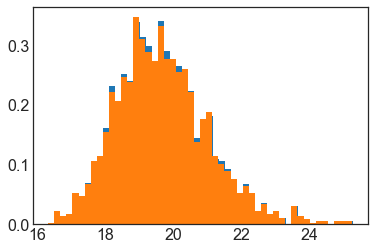

In [18]:
_=plt.hist(N_list2,density=True,bins=50)
_=plt.hist(NS_list2,density=True,bins=50)

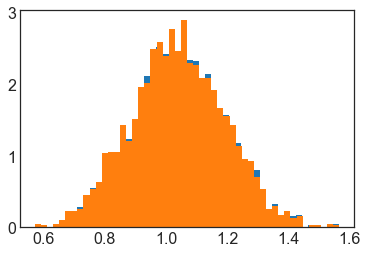

In [19]:
_=plt.hist(D_list2,density=True,bins=50)
_=plt.hist(DS_list2,density=True,bins=50)

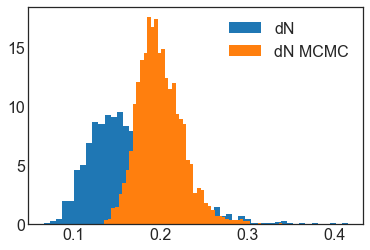

In [20]:
_=plt.hist(dN_list2,density=True,bins=50,label="dN")
_=plt.hist(dNS_list2,density=True,bins=50,label="dN MCMC")
plt.legend()

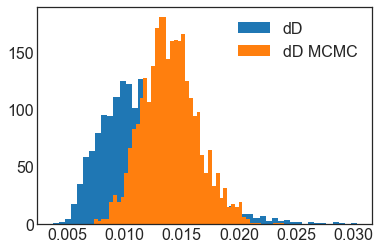

In [21]:
_=plt.hist(dD_list2,density=True,bins=50,label="dD")
_=plt.hist(dDS_list2,density=True,bins=50,label="dD MCMC")
plt.legend()

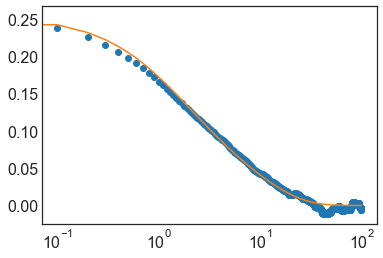

In [22]:
plt.semilogx(t,y,"o")
plt.semilogx(t,residual(result.params,t))

In [23]:
print("median of posterior probability distribution")
print('--------------------------------------------')
lm.report_fit(res.params)

median of posterior probability distribution
--------------------------------------------
[[Variables]]
    D:  0.98740831 +/- 0.01022771 (1.04%) (init = 0.9874135)
    N:  17.3269158 +/- 0.14683581 (0.85%) (init = 17.31784)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, N) = -0.775


1.0389749953007823 0.15261753125390815 0.011802034765477771
1.0391292479920153 0.15264505036964937 0.013994605647922013


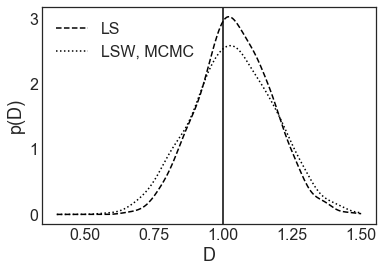

In [41]:
xd = np.linspace(0.4,1.5,200)
densityD2 = gaussian_kde(D_list2)
densityDS2 = gaussian_kde(DS_list2)
plt.figure(figsize=(6, 4))
plt.plot(xd,densityD(xd),"k--",label="LS")
plt.plot(xd,densityD2(xd),"k:",label="LSW, MCMC")
#plt.plot(xd,densityDS2(xd),"k:",label="LSW")
plt.axvline(x=1.0,color="k")
plt.xlabel("D")
plt.ylabel("p(D)")

plt.legend(loc='upper left')
print(D_list2.mean(),D_list2.std(),dD_list2.mean())
print(DS_list2.mean(),DS_list2.std(),dDS_list2.mean())
plt.savefig("FCS_D300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

1.2330381752614916 0.08548898686720549 0.007318508116798695
1.2332113546016052 0.08550812063567007 0.012510551854386053


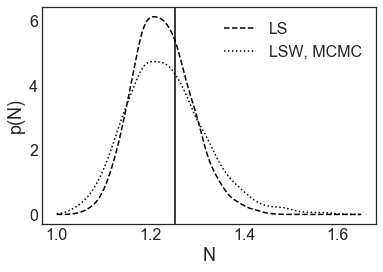

In [43]:
xn = np.linspace(1,1.65,200)
densityF2 = gaussian_kde(F_list2)
densityFS2 = gaussian_kde(FS_list2)
plt.figure(figsize=(6, 4))
plt.plot(xn,densityF(xn),"k--",label="LS")
plt.plot(xn,densityFS2(xn),"k:",label="LSW, MCMC")
plt.axvline(x=np.sqrt(np.pi/2),color="k")
plt.xlabel("N")
plt.ylabel("p(N)")
print(F_list2.mean(),F_list2.std(),dF_list2.mean())
print(FS_list2.mean(),FS_list2.std(),dFS_list2.mean())

plt.legend()
plt.savefig("FCS_N300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")